In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests, ccf
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Alternative BSTS implementations
try:
    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    pandas2ri.activate()
    R_AVAILABLE = True
    print("R integration available via rpy2")
except ImportError:
    R_AVAILABLE = False
    print("rpy2 not available. Will use alternative methods.")

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
    print("Prophet available as BSTS alternative")
except ImportError:
    PROPHET_AVAILABLE = False
    print("Prophet not available. Install with: pip install prophet")

try:
    from statsmodels.tsa.statespace.structural import UnobservedComponents
    STATSMODELS_UC_AVAILABLE = True
    print("Statsmodels Unobserved Components available")
except ImportError:
    STATSMODELS_UC_AVAILABLE = False
    print("Statsmodels UC not available")

R integration available via rpy2
Prophet available as BSTS alternative
Statsmodels Unobserved Components available


In [ ]:
data = pd.read_csv(r"/content/final_feature_library_all_features.csv")
data['Spread'] = data['USGG10YR_mean'] - data['USGG2YR_mean']
data['Spread'] = data['Spread'].shift(-1)
data = data[:-1]
cols = data.isna().sum()[data.isna().sum()==0].index.tolist()
data = data[cols]
# Drop all columns ending with 'median' from the data DataFrame
data = data.loc[:, ~data.columns.str.endswith('median')]

In [ ]:
def __init__(self, target_col='Spread', test_size=36):
    self.target_col = target_col
    self.test_size = test_size
    self.scaler = StandardScaler()
    self.feature_selector = None
    self.selected_features = None
    self.model = None
    self.feature_data = None

In [ ]:
target_col='Spread'
test_size=36

In [ ]:
def create_lead_lag_features(df, target_col, other_cols=None, max_lags=5):
    """
    Create lead and lag features for time series analysis
    """
    feature_df = df.copy()

    # If no other columns specified, use all numeric columns except target and Date
    if other_cols is None:
        other_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                      if col != target_col and col != 'Date'] # Exclude 'Date' column


    print(f"Creating features for {len(other_cols)} variables...")

    # Create lag features for target variable
    for lag in range(1, max_lags + 1):
        feature_df[f'{target_col}_lag_{lag}'] = feature_df[target_col].shift(lag)

    # Create lag and additional features for other variables
    for col in other_cols:
        # Lag features
        for lag in range(1, max_lags + 1):
            feature_df[f'{col}_lag_{lag}'] = feature_df[col].shift(lag)

        # Ensure column is numeric before creating rolling features
        if pd.api.types.is_numeric_dtype(feature_df[col]):
            # Rolling statistics
            for window in [3, 5, 10]:
                feature_df[f'{col}_rolling_mean_{window}'] = feature_df[col].rolling(window).mean()
                feature_df[f'{col}_rolling_std_{window}'] = feature_df[col].rolling(window).std()
                feature_df[f'{col}_rolling_min_{window}'] = feature_df[col].rolling(window).min()
                feature_df[f'{col}_rolling_max_{window}'] = feature_df[col].rolling(window).max()

            # Differencing features
            feature_df[f'{col}_diff_1'] = feature_df[col].diff(1)
            feature_df[f'{col}_diff_2'] = feature_df[col].diff(2)

            # Percentage change
            feature_df[f'{col}_pct_change'] = feature_df[col].pct_change()

            # Momentum features
            feature_df[f'{col}_momentum_3'] = feature_df[col] - feature_df[col].shift(3)
            feature_df[f'{col}_momentum_5'] = feature_df[col] - feature_df[col].shift(5)
        else:
            print(f"Skipping non-numeric column for rolling features: {col}")


    return feature_df

In [ ]:
def select_features( df, k=30):
    """
    Select top k features using multiple methods
    """
    # Prepare data
    feature_cols = [col for col in df.columns if col != target_col and df[col].dtype in ['float64', 'int64']]

    # Remove rows with NaN in target
    clean_df = df.dropna(subset=[target_col])

    # Prepare feature matrix
    X = clean_df[feature_cols].fillna(clean_df[feature_cols].mean())
    y = clean_df[target_col]

    # Remove features with zero variance or too many NaN values
    valid_features = []
    for col in feature_cols:
        if X[col].std() > 1e-8 and X[col].notna().sum() > len(X) * 0.5:
            valid_features.append(col)

    X = X[valid_features]

    if len(valid_features) == 0:
        print("No valid features found")
        return []

    # Feature selection using F-regression
    k_best = min(k, len(valid_features))
    selector = SelectKBest(score_func=f_regression, k=k_best)
    selector.fit(X, y)

    # Get selected features
    selected_features = [valid_features[i] for i in selector.get_support(indices=True)]

    print(f"Selected {len(selected_features)} features out of {len(valid_features)}")

    return selected_features

In [ ]:
def prepare_data_for_bsts(df, selected_features):
    """
    Prepare data for BSTS model
    """
    # Include target and selected features
    model_cols = [target_col] + selected_features

    # Clean data
    model_data = df[model_cols].dropna()

    # Split train/test
    train_data = model_data[:-test_size]
    test_data = model_data[-test_size:]

    return train_data, test_data

In [ ]:
# def fit_bsts_r(self, train_data, selected_features, niter=1000):
#     """
#     Fit BSTS model using R
#     """
#     if not R_AVAILABLE:
#         return None

#     try:
#         print("Fitting BSTS model using R...")

#         # Import R libraries
#         r_code = '''
#         # Check if bsts package is installed
#         if (!requireNamespace("bsts", quietly = TRUE)) {
#             stop("The R package \"bsts\" is not installed.")
#         }
#         library(bsts)

#         fit_bsts_model <- function(y, X=NULL, niter=1000) {
#             # Create state specification
#             ss <- AddLocalLevel(list(), y)
#             ss <- AddSeasonal(ss, y, nseasons=12)  # Monthly seasonality

#             # Add regression component if predictors available
#             if (!is.null(X)) {
#                 # Fit model with predictors
#                 model <- bsts(y ~ ., data=data.frame(y=y, X),
#                               state.specification=ss, niter=niter, ping=0)
#             } else {
#                 # Fit model without predictors
#                 model <- bsts(y, state.specification=ss, niter=niter, ping=0)
#             }

#             return(model)
#         }

#         predict_bsts <- function(model, horizon, X_new=NULL) {
#             library(bsts) # Ensure bsts is loaded for prediction as well
#             if (!is.null(X_new)) {
#                 pred <- predict(model, newdata=data.frame(X_new), horizon=horizon)
#             } else {
#                 pred <- predict(model, horizon=horizon)
#             }
#             return(list(mean=as.numeric(pred$mean),
#                         lower=as.numeric(pred$interval[1,]),
#                         upper=as.numeric(pred$interval[2,])))
#         }
#         '''

#         robjects.r(r_code)

#         # Prepare data
#         y = train_data[self.target_col].values
#         X = train_data[selected_features].values if selected_features else None

#         # Convert to R objects
#         r_y = robjects.FloatVector(y)
#         r_X = None
#         if X is not None and X.shape[1] > 0:
#             r_X = robjects.r.matrix(robjects.FloatVector(X.flatten()),
#                                     nrow=X.shape[0], ncol=X.shape[1])
#             # Set column names
#             colnames = robjects.StrVector(selected_features)
#             r_X.colnames = colnames

#         # Fit model
#         fit_function = robjects.globalenv['fit_bsts_model']
#         model = fit_function(r_y, r_X, niter)

#         self.model_type = 'bsts_r'
#         return model

#     except Exception as e:
#         print(f"Error fitting BSTS model with R: {str(e)}")
#         return None

def fit_prophet_model( train_data, selected_features):
    """
    Fit Prophet model as BSTS alternative
    """
    if not PROPHET_AVAILABLE:
        return None

    try:
        print("Fitting Prophet model as BSTS alternative...")

        # Prepare data for Prophet
        # Prophet requires 'ds' (datestamp) and 'y' (target) columns
        prophet_data = pd.DataFrame({
            'ds': pd.date_range(start='2000-01-01', periods=len(train_data), freq='M'),
            'y': train_data[target_col].values
        })

        # Initialize Prophet with monthly seasonality
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='multiplicative',
            interval_width=0.95
        )

        # Add monthly seasonality
        model.add_seasonality(name='monthly', period=12, fourier_order=5)

        # Add regressors (selected features)
        for feature in selected_features[:10]:  # Limit to top 10 features
            model.add_regressor(feature)
            prophet_data[feature] = train_data[feature].fillna(train_data[feature].mean()).values

        # Fit model
        model.fit(prophet_data)

        model_type = 'prophet'
        return model

    except Exception as e:
        print(f"Error fitting Prophet model: {str(e)}")
        return None

def fit_unobserved_components( train_data, selected_features):
    """
    Fit Unobserved Components model using statsmodels
    """
    if not STATSMODELS_UC_AVAILABLE:
        return None

    try:
        print("Fitting Unobserved Components model...")

        # Prepare data
        y = train_data[target_col].values

        # Fit UC model with trend and seasonal components
        model = UnobservedComponents(
            y,
            level='local level',
            seasonal=12,  # Monthly seasonality
            trend=True,
            freq_seasonal=[{'period': 12, 'harmonics': 2}]
        )

        fitted_model = model.fit(disp=False)
        model_type = 'unobserved_components'
        return fitted_model

    except Exception as e:
        print(f"Error fitting Unobserved Components model: {str(e)}")
        return None

In [ ]:
def predict_model(model, model_type, test_data, selected_features):
    """
    Make predictions based on model type
    """
    if model is None:
        return None

    try:
        horizon = len(test_data)

        if model_type == 'bsts_r':
            # R BSTS prediction
            predict_function = robjects.globalenv['predict_bsts']

            # Prepare test data for R
            if selected_features:
                X_test = test_data[selected_features].fillna(test_data[selected_features].mean()).values
                r_X_test = robjects.r.matrix(robjects.FloatVector(X_test.flatten()),
                                            nrow=X_test.shape[0], ncol=X_test.shape[1])
                colnames = robjects.StrVector(selected_features)
                r_X_test.colnames = colnames

                result = predict_function(model, horizon, r_X_test)
            else:
                result = predict_function(model, horizon)

            predictions = np.array(result[0])  # mean predictions
            return predictions

        elif model_type == 'prophet':
            # Prophet prediction
            future = pd.DataFrame({
                'ds': pd.date_range(start='2000-01-01', periods=len(test_data), freq='M')
            })

            # Add regressors
            for feature in selected_features[:10]:
                if feature in test_data.columns:
                    future[feature] = test_data[feature].fillna(test_data[feature].mean()).values

            forecast = model.predict(future)
            return forecast['yhat'].values

        elif model_type == 'unobserved_components':
            # Unobserved Components prediction
            forecast = model.forecast(steps=horizon)
            return forecast

        else:
            return None

    except Exception as e:
        print(f"Error making predictions: {str(e)}")
        return None

In [ ]:
def time_series_cross_validation( df, selected_features, n_splits=5):
    """
    Perform time series cross validation
    """
    print(f"\nPerforming Time Series Cross Validation with {n_splits} splits...")

    # Prepare data
    model_cols = [target_col] + selected_features
    clean_data = df[model_cols].dropna()

    # Use only the last portion of data for CV
    cv_data = clean_data[-test_size*3:]  # Use 3x test_size for CV

    if len(cv_data) < 30:
        print("Not enough data for cross-validation. Using all available data.")
        cv_data = clean_data

    # Time series split
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=max(6, len(cv_data)//8))

    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(cv_data)):
        print(f"Fold {fold + 1}/{n_splits}")

        train_fold = cv_data.iloc[train_idx]
        val_fold = cv_data.iloc[val_idx]

        if len(train_fold) < 20 or len(val_fold) < 3:
            print(f"  Skipping fold {fold + 1} - insufficient data")
            continue

        # Prepare data
        X_train = train_fold[selected_features].fillna(train_fold[selected_features].mean())
        y_train = train_fold[target_col]
        X_val = val_fold[selected_features].fillna(train_fold[selected_features].mean())
        y_val = val_fold[target_col]

        # Use Ridge regression for CV (more stable than BSTS for CV)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Fit Ridge regression
        reg = Ridge(alpha=1.0)
        reg.fit(X_train_scaled, y_train)

        # Predict
        y_pred = reg.predict(X_val_scaled)

        # Calculate MAE
        mae = mean_absolute_error(y_val, y_pred)
        cv_scores.append(mae)

        print(f"  Fold {fold + 1} MAE: {mae:.4f}")

    if cv_scores:
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        print(f"\nCross Validation Results:")
        print(f"Mean MAE: {mean_cv_score:.4f} (+/- {std_cv_score:.4f})")
    else:
        print("No valid CV folds completed.")
        cv_scores = [np.nan]

    return cv_scores

In [ ]:
print("="*80)
print("BAYESIAN TIME SERIES MODEL FOR TREASURY CURVE FORECASTING")
print("="*80)
# Load data
print("Loading data...")
data = pd.read_csv(r"/content/final_feature_library_all_features.csv")

# Create target variable
data['Spread'] = data['USGG10YR_mean'] - data['USGG2YR_mean']
data['Spread'] = data['Spread'].shift(-1)
data = data[:-1]

# Clean data
cols = data.isna().sum()[data.isna().sum()==0].index.tolist()
data = data[cols]

# Drop all columns ending with 'median'
data = data.loc[:, ~data.columns.str.endswith('median')]

print(f"Final data shape: {data.shape}")
print(f"Target variable (Spread) statistics:")
print(data['Spread'].describe())
print(f"Target variable range: [{data['Spread'].min():.4f}, {data['Spread'].max():.4f}]")

BAYESIAN TIME SERIES MODEL FOR TREASURY CURVE FORECASTING
Loading data...
Final data shape: (302, 45)
Target variable (Spread) statistics:
count    302.000000
mean       1.079759
std        0.983391
min       -0.961171
25%        0.220384
50%        1.132589
75%        1.891962
max        2.836100
Name: Spread, dtype: float64
Target variable range: [-0.9612, 2.8361]


# Step 1: Feature Engineering

In [ ]:
df = data.copy()
print(f"Original data shape: {df.shape}")
# Get other features (exclude target)
other_features = [col for col in data.columns if col != 'Spread' and col != 'Date'] # Exclude 'Date' column
print(f"Available features for modeling: {len(other_features)}")

print("\n1. Feature Engineering...")
feature_data = create_lead_lag_features(df,target_col=target_col,other_cols=other_features)
print(f"After feature engineering: {feature_data.shape}")

Original data shape: (302, 45)
Available features for modeling: 43

1. Feature Engineering...
Creating features for 43 variables...
After feature engineering: (302, 996)


# Step 2: Feature Selection

In [ ]:
print("\n2. Feature Selection...")
selected_features = select_features(feature_data, k=150)

if len(selected_features) == 0:
    print("No features selected. Using basic lag features.")
    # Create basic lag features as fallback
    selected_features = [f'{target_col}_lag_{i}' for i in range(1, 4)
                            if f'{target_col}_lag_{i}' in feature_data.columns]



2. Feature Selection...
Selected 150 features out of 994


# Step 3: Prepare data

In [ ]:
print("\n3. Preparing data...")
model_cols = [target_col] + selected_features
clean_data = feature_data[model_cols].dropna()

train_data = clean_data[:-test_size]
test_data = clean_data[-test_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

if len(train_data) < 50:
    print("Warning: Limited training data available.")


3. Preparing data...
Train data shape: (257, 151)
Test data shape: (36, 151)


  # Step 4: Time Series Cross Validation

In [ ]:
print("\n4. Time Series Cross Validation...")
cv_scores = time_series_cross_validation(feature_data, selected_features)


4. Time Series Cross Validation...

Performing Time Series Cross Validation with 5 splits...
Fold 1/5
  Fold 1 MAE: 0.0853
Fold 2/5
  Fold 2 MAE: 0.1952
Fold 3/5
  Fold 3 MAE: 0.1398
Fold 4/5
  Fold 4 MAE: 0.1526
Fold 5/5
  Fold 5 MAE: 0.1289

Cross Validation Results:
Mean MAE: 0.1403 (+/- 0.0356)


# Step 5: Fit Models (trying multiple approaches)

In [ ]:
print("\n5. Fitting Models...")

model = None

# # Try R BSTS first
# if R_AVAILABLE:
#     model = fit_bsts_r(train_data, selected_features[:15])  # Limit features for stability

# Try Prophet if R BSTS failed
if model is None and PROPHET_AVAILABLE:
    model = fit_prophet_model(train_data, selected_features[:10])
    if model is not None:
        model_type = 'prophet'


# Try Unobserved Components if others failed
if model is None and STATSMODELS_UC_AVAILABLE:
    model = fit_unobserved_components(train_data, selected_features)
    if model is not None:
        model_type = 'unobserved_components'


# Fallback to ensemble method
if model is None:
    print("All Bayesian methods failed. Using ensemble fallback...")
    model_type = 'ensemble'

    # Prepare data
    X_train = train_data[selected_features].fillna(train_data[selected_features].mean())
    y_train = train_data[target_col]
    X_test = test_data[selected_features].fillna(train_data[selected_features].mean())

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit ensemble of models
    models = {
        'ridge': Ridge(alpha=1.0),
        'rf': RandomForestRegressor(n_estimators=100, random_state=42),
        'linear': LinearRegression()
    }

    predictions = []
    for name, model_obj in models.items():
        model_obj.fit(X_train_scaled, y_train)
        pred = model_obj.predict(X_test_scaled)
        predictions.append(pred)
        print(f"  {name} fitted successfully")

    # Ensemble prediction (average)
    y_pred = np.mean(predictions, axis=0)
    model = models  # Store all models

else:
    # Use fitted Bayesian model
    y_pred = predict_model(model, model_type, test_data, selected_features)

model = model

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2webng0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z8hannvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14490', 'data', 'file=/tmp/tmpcd8gtw_v/2webng0r.json', 'init=/tmp/tmpcd8gtw_v/z8hannvm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0f83g86c/prophet_model-20250622011514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:15:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



5. Fitting Models...
Fitting Prophet model as BSTS alternative...


# Step 6: Evaluate performance

In [ ]:
print("\n6. Model Evaluation...")

y_test = test_data[target_col].values

if y_pred is None:
    print("Prediction failed.")
    # return None

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test Set Performance:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Model Type: {model_type}")


6. Model Evaluation...
Test Set Performance:
MAE:  0.1210
RMSE: 0.1584
R²:   0.8110
Model Type: prophet


In [ ]:
# Results summary
results = {
    'model': model,
    'model_type': model_type,
    'selected_features': selected_features,
    'test_mae': mae,
    'test_rmse': rmse,
    'test_r2': r2,
    'cv_scores': cv_scores,
    'predictions': y_pred,
    'actual': y_test
}

In [ ]:
if results:
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    print(f"Model Type: {results['model_type']}")
    print(f"Test MAE: {results['test_mae']:.4f}")
    print(f"Test RMSE: {results['test_rmse']:.4f}")
    print(f"Test R²: {results['test_r2']:.4f}")

    if not np.isnan(results['cv_scores'][0]):
        print(f"Cross-validation MAE: {np.mean(results['cv_scores']):.4f} (+/- {np.std(results['cv_scores']):.4f})")

    print(f"Number of selected features: {len(results['selected_features'])}")


FINAL RESULTS SUMMARY
Model Type: prophet
Test MAE: 0.1210
Test RMSE: 0.1584
Test R²: 0.8110
Cross-validation MAE: 0.1403 (+/- 0.0356)
Number of selected features: 50


In [ ]:
# Save results
results_df = pd.DataFrame({
    'Actual': results['actual'],
    'Predicted': results['predictions'],
    'Error': results['actual'] - results['predictions'],
    'Abs_Error': np.abs(results['actual'] - results['predictions'])
})

print("\nSample predictions vs actual:")
print(results_df.head(10).round(4))

print(f"\nPrediction error statistics:")
print(f"Mean Error: {results_df['Error'].mean():.4f}")
print(f"Std Error: {results_df['Error'].std():.4f}")
print(f"Max Abs Error: {results_df['Abs_Error'].max():.4f}")


Sample predictions vs actual:
   Actual  Predicted   Error  Abs_Error
0  0.2242     0.1737  0.0505     0.0505
1  0.2851     0.1767  0.1084     0.1084
2  0.1302     0.3612 -0.2310     0.2310
3 -0.1396     0.0086 -0.1482     0.1482
4 -0.3536    -0.1556 -0.1980     0.1980
5 -0.3401    -0.4238  0.0837     0.0837
6 -0.4053    -0.3542 -0.0510     0.0510
7 -0.6286    -0.5244 -0.1042     0.1042
8 -0.6782    -0.6242 -0.0539     0.0539
9 -0.6889    -0.6885 -0.0004     0.0004

Prediction error statistics:
Mean Error: -0.0188
Std Error: 0.1596
Max Abs Error: 0.4944


In [ ]:
results_df['Abs_Error'].mean()

np.float64(0.12099416366889972)

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from itertools import product
import warnings
warnings.filterwarnings('ignore')

def select_top_features(X_train, y_train, n_features):
    """
    Select top n features using univariate feature selection
    """
    if n_features >= X_train.shape[1] or n_features <= 0:
        return list(X_train.columns)

    selector = SelectKBest(score_func=f_regression, k=n_features)
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()].tolist()
    return selected_features

def train_prophet_model(train_data, target_col, selected_features, prophet_params):
    """
    Train Prophet model with given parameters and features
    """
    try:
        # Prepare training data for Prophet
        prophet_data = pd.DataFrame({
            'ds': pd.date_range(start='2000-01-01', periods=len(train_data), freq='M'),
            'y': train_data[target_col].values
        })

        # Initialize Prophet with parameters
        model = Prophet(**prophet_params)

        # Add regressors
        for feature in selected_features:
            if feature in train_data.columns and feature != target_col:
                model.add_regressor(feature)
                prophet_data[feature] = train_data[feature].fillna(train_data[feature].mean()).values

        # Fit the model
        model.fit(prophet_data)
        return model

    except Exception as e:
        print(f"Error training Prophet model: {str(e)}")
        return None

def evaluate_prophet_model(model, test_data, target_col, selected_features):
    """
    Evaluate Prophet model on test data
    """
    try:
        if model is None:
            return float('inf'), float('inf')

        # Prepare test data for prediction
        future = pd.DataFrame({
            'ds': pd.date_range(start='2000-01-01', periods=len(test_data), freq='M')
        })

        # Add regressors
        for feature in selected_features:
            if feature in test_data.columns and feature != target_col:
                future[feature] = test_data[feature].fillna(test_data[feature].mean()).values

        # Make predictions
        forecast = model.predict(future)
        predictions = forecast['yhat'].values

        # Calculate metrics
        y_true = test_data[target_col].values
        mae = mean_absolute_error(y_true, predictions)
        rmse = np.sqrt(mean_squared_error(y_true, predictions))

        return mae, rmse

    except Exception as e:
        print(f"Error evaluating model: {str(e)}")
        return float('inf'), float('inf')

def hyperparameter_tuning_prophet(train_data, test_data, target_col,
                                feature_cols, param_grid, n_features_range):
    """
    Perform hyperparameter tuning for Prophet model including feature selection

    Parameters:
    -----------
    train_data : pd.DataFrame
        Training dataset
    test_data : pd.DataFrame
        Test dataset
    target_col : str
        Name of target column
    feature_cols : list
        List of potential feature columns
    param_grid : dict
        Dictionary of Prophet parameters to tune
    n_features_range : list
        List of number of features to try (e.g., [5, 10, 15, 20])

    Returns:
    --------
    dict : Best parameters and results
    """

    best_mae = float('inf')
    best_params = None
    best_n_features = None
    best_features = None
    results = []

    print("Starting hyperparameter tuning...")
    print(f"Total combinations to test: {len(list(product(*param_grid.values()))) * len(n_features_range)}")

    # Get parameter combinations
    param_names = list(param_grid.keys())
    param_combinations = list(product(*param_grid.values()))

    iteration = 0

    for n_features in n_features_range:
        print(f"\nTesting with {n_features} features...")

        # Select top features
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        selected_features = select_top_features(X_train, y_train, n_features)

        print(f"Selected features: {selected_features[:5]}..." if len(selected_features) > 5 else f"Selected features: {selected_features}")

        for param_combination in param_combinations:
            iteration += 1

            # Create parameter dictionary
            current_params = dict(zip(param_names, param_combination))

            print(f"Iteration {iteration}: Testing params {current_params}")

            # Train model
            model = train_prophet_model(train_data, target_col, selected_features, current_params)

            # Evaluate model
            mae, rmse = evaluate_prophet_model(model, test_data, target_col, selected_features)

            # Store results
            result = {
                'n_features': n_features,
                'selected_features': selected_features.copy(),
                'params': current_params.copy(),
                'mae': mae,
                'rmse': rmse
            }
            results.append(result)

            print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

            # Update best parameters
            if mae < best_mae:
                best_mae = mae
                best_params = current_params.copy()
                best_n_features = n_features
                best_features = selected_features.copy()
                print(f"New best MAE: {best_mae:.4f}")

    # Create results summary
    tuning_results = {
        'best_params': best_params,
        'best_n_features': best_n_features,
        'best_features': best_features,
        'best_mae': best_mae,
        'all_results': results
    }

    return tuning_results

def train_best_prophet_model(train_data, target_col, tuning_results):
    """
    Train the final Prophet model with best parameters
    """
    best_params = tuning_results['best_params']
    best_features = tuning_results['best_features']

    print(f"Training final model with best parameters: {best_params}")
    print(f"Using {len(best_features)} features: {best_features}")

    model = train_prophet_model(train_data, target_col, best_features, best_params)
    return model

# Example usage and parameter grid
def example_usage():
    """
    Example of how to use the hyperparameter tuning function
    """

    # Define parameter grid for Prophet
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_range': [0.8, 0.9, 0.95]
    }

    # Define range of features to test
    n_features_range = [5, 10, 15, 20, 25]

    # Assuming you have train_data, test_data, target_col, and feature_cols defined
    # tuning_results = hyperparameter_tuning_prophet(
    #     train_data=train_data,
    #     test_data=test_data,
    #     target_col='your_target_column',
    #     feature_cols=['feature1', 'feature2', 'feature3', ...],
    #     param_grid=param_grid,
    #     n_features_range=n_features_range
    # )

    # # Train final model
    # best_model = train_best_prophet_model(train_data, 'your_target_column', tuning_results)

    return param_grid, n_features_range

# Alternative: Grid search with cross-validation
def cross_validation_tuning(train_data, target_col, feature_cols, param_grid, n_features_range, cv_folds=3):
    """
    Hyperparameter tuning with time series cross-validation
    """
    from sklearn.model_selection import TimeSeriesSplit

    best_score = float('inf')
    best_params = None
    best_n_features = None
    best_features = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    for n_features in n_features_range:
        # Select features
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        selected_features = select_top_features(X_train, y_train, n_features)

        param_combinations = list(product(*param_grid.values()))
        param_names = list(param_grid.keys())

        for param_combination in param_combinations:
            current_params = dict(zip(param_names, param_combination))

            cv_scores = []

            for train_idx, val_idx in tscv.split(train_data):
                train_fold = train_data.iloc[train_idx]
                val_fold = train_data.iloc[val_idx]

                # Train model on fold
                model = train_prophet_model(train_fold, target_col, selected_features, current_params)

                # Evaluate on validation fold
                mae, _ = evaluate_prophet_model(model, val_fold, target_col, selected_features)
                cv_scores.append(mae)

            # Average CV score
            avg_score = np.mean(cv_scores)

            if avg_score < best_score:
                best_score = avg_score
                best_params = current_params.copy()
                best_n_features = n_features
                best_features = selected_features.copy()

    return {
        'best_params': best_params,
        'best_n_features': best_n_features,
        'best_features': best_features,
        'best_cv_score': best_score
    }

# Display results function
def display_tuning_results(tuning_results):
    """
    Display the results of hyperparameter tuning
    """
    print("\n" + "="*50)
    print("HYPERPARAMETER TUNING RESULTS")
    print("="*50)

    print(f"Best MAE: {tuning_results['best_mae']:.4f}")
    print(f"Best number of features: {tuning_results['best_n_features']}")
    print(f"Best parameters: {tuning_results['best_params']}")
    print(f"Best features: {tuning_results['best_features']}")

    # Show top 5 results
    results_df = pd.DataFrame(tuning_results['all_results'])
    results_df = results_df.sort_values('mae').head(5)

    print(f"\nTop 5 parameter combinations:")
    for i, (_, row) in enumerate(results_df.iterrows(), 1):
        print(f"{i}. MAE: {row['mae']:.4f}, Features: {row['n_features']}, Params: {row['params']}")

In [ ]:
feature_cols = [col for col in train_data.columns if col != 'Date' and col != 'Spread']
# 1. Define your parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 0.95]
}

# 2. Define feature selection range
n_features_range = [5, 10, 15, 20, 25]

# 3. Run hyperparameter tuning
tuning_results = hyperparameter_tuning_prophet(
    train_data= train_data,
    test_data= test_data,
    target_col= target_col,
    feature_cols = feature_cols, # List of all potential features
    param_grid=param_grid,
    n_features_range=n_features_range
)

# 4. Display results
display_tuning_results(tuning_results)

# 5. Train final model with best parameters
best_model = train_best_prophet_model(train_data, 'Spread', tuning_results)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6qzca7_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eppm0t9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26602', 'data', 'file=/tmp/tmpcd8gtw_v/6qzca7_2.json', 'init=/tmp/tmpcd8gtw_v/eppm0t9x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld2k0mt9g/prophet_model-20250622013054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:30:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:30:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:30:54 - cmdstanpy - ERROR - Chain [1]

Starting hyperparameter tuning...
Total combinations to test: 1920

Testing with 5 features...
Selected features: ['USYC2Y10_Index_mean', 'Spread_lag_1', 'USYC2Y10_Index_mean_rolling_mean_3', 'USYC2Y10_Index_mean_rolling_min_3', 'USYC2Y10_Index_mean_rolling_max_3']
Iteration 1: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:30:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/89r7p65v.json


MAE: 0.1820, RMSE: 0.2218
New best MAE: 0.1820
Iteration 2: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/soe46_r8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59007', 'data', 'file=/tmp/tmpcd8gtw_v/89r7p65v.json', 'init=/tmp/tmpcd8gtw_v/soe46_r8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelloaq01ws/prophet_model-20250622013056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:30:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:30:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:30:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9ribooba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_18816_j.json
DE

MAE: 0.1820, RMSE: 0.2218
New best MAE: 0.1820
Iteration 3: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:30:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/49b92der.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ugvdkcu3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57622', 'data', 'file=/tmp/tmpcd8gtw_v/49b92der.json', 'init=/tmp/tmpcd8gtw_v/ugvdkcu3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxxco9ql6/prophet_model-20250622013058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:30:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:30:58 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1820, RMSE: 0.2218
New best MAE: 0.1820
Iteration 4: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:30:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/plgxgw6w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/47ba0tjm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44365', 'data', 'file=/tmp/tmpcd8gtw_v/plgxgw6w.json', 'init=/tmp/tmpcd8gtw_v/47ba0tjm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model70dksnsm/prophet_model-20250622013059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:30:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:30:59 - cmdstanpy - INFO - Chain [1] 

MAE: 0.5431, RMSE: 0.5702
Iteration 5: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6j0az3uf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_za6tb9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4432', 'data', 'file=/tmp/tmpcd8gtw_v/6j0az3uf.json', 'init=/tmp/tmpcd8gtw_v/_za6tb9l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkazx7lbe/prophet_model-20250622013100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:00 - cmdstanpy - INFO - Chain [1] d

MAE: 0.5402, RMSE: 0.5674
Iteration 6: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:31:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fhkjymjg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6thf_u9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67310', 'data', 'file=/tmp/tmpcd8gtw_v/fhkjymjg.json', 'init=/tmp/tmpcd8gtw_v/6thf_u9g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh2x16gr9/prophet_model-20250622013101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:01 - cmdstanpy - INFO - Chain [1] 

MAE: 0.5412, RMSE: 0.5683
Iteration 7: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hk08z3ez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93018', 'data', 'file=/tmp/tmpcd8gtw_v/jho8gync.json', 'init=/tmp/tmpcd8gtw_v/hk08z3ez.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2mzpem_s/prophet_model-20250622013101.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3_g_l3ak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1287, RMSE: 0.1619
New best MAE: 0.1287
Iteration 8: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/glz2w_bm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_bbey3ki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71626', 'data', 'file=/tmp/tmpcd8gtw_v/glz2w_bm.json', 'init=/tmp/tmpcd8gtw_v/_bbey3ki.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaykm2vo5/prophet_model-20250622013103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:03 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1286, RMSE: 0.1617
New best MAE: 0.1286
Iteration 9: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z8duea6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m2y0dlsl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20827', 'data', 'file=/tmp/tmpcd8gtw_v/z8duea6r.json', 'init=/tmp/tmpcd8gtw_v/m2y0dlsl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3ndluwoa/prophet_model-20250622013104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:04 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1286, RMSE: 0.1617
New best MAE: 0.1286
Iteration 10: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9p6n62rx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5jydrduy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48087', 'data', 'file=/tmp/tmpcd8gtw_v/9p6n62rx.json', 'init=/tmp/tmpcd8gtw_v/5jydrduy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9ml1icc1/prophet_model-20250622013105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


MAE: 0.1209, RMSE: 0.1526
New best MAE: 0.1209
Iteration 11: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:31:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eknlegb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1n421cyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36040', 'data', 'file=/tmp/tmpcd8gtw_v/eknlegb8.json', 'init=/tmp/tmpcd8gtw_v/1n421cyd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9sk1lrmd/prophet_model-20250622013105.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

MAE: 0.1209, RMSE: 0.1526
New best MAE: 0.1209
Iteration 12: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/epicmdb5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ml_pjdl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97679', 'data', 'file=/tmp/tmpcd8gtw_v/epicmdb5.json', 'init=/tmp/tmpcd8gtw_v/ml_pjdl3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model18hd9fxy/prophet_model-20250622013106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:06 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1209, RMSE: 0.1526
Iteration 13: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0c_7xh52.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wwqylim1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4013', 'data', 'file=/tmp/tmpcd8gtw_v/0c_7xh52.json', 'init=/tmp/tmpcd8gtw_v/wwqylim1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrpktokc5/prophet_model-20250622013107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:07 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1238, RMSE: 0.1575
Iteration 14: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4u8e_5wo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n6jubyh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72181', 'data', 'file=/tmp/tmpcd8gtw_v/4u8e_5wo.json', 'init=/tmp/tmpcd8gtw_v/n6jubyh8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5iws9ocg/prophet_model-20250622013107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:07 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1238, RMSE: 0.1575
Iteration 15: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pg21f3af.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zkpjltyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47588', 'data', 'file=/tmp/tmpcd8gtw_v/pg21f3af.json', 'init=/tmp/tmpcd8gtw_v/zkpjltyg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgyhtj4j5/prophet_model-20250622013108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:08 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1238, RMSE: 0.1575
Iteration 16: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r7opjr6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p456ase9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89642', 'data', 'file=/tmp/tmpcd8gtw_v/r7opjr6p.json', 'init=/tmp/tmpcd8gtw_v/p456ase9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelllczovm6/prophet_model-20250622013109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:09 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1219, RMSE: 0.1546
Iteration 17: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7ygy4lr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w872_prm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51999', 'data', 'file=/tmp/tmpcd8gtw_v/7ygy4lr2.json', 'init=/tmp/tmpcd8gtw_v/w872_prm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelj6v1phyd/prophet_model-20250622013110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:10 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1218, RMSE: 0.1545
Iteration 18: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lym0d2qe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x9oc85g3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34688', 'data', 'file=/tmp/tmpcd8gtw_v/lym0d2qe.json', 'init=/tmp/tmpcd8gtw_v/x9oc85g3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvgsb417x/prophet_model-20250622013110.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1218, RMSE: 0.1546
Iteration 19: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:31:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/456rwcuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fblr1xbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38997', 'data', 'file=/tmp/tmpcd8gtw_v/456rwcuw.json', 'init=/tmp/tmpcd8gtw_v/fblr1xbj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4ma4tokr/prophet_model-20250622013111.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1224, RMSE: 0.1560
Iteration 20: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/szalb1iw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y61z39cw.json


MAE: 0.1224, RMSE: 0.1560
Iteration 21: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41263', 'data', 'file=/tmp/tmpcd8gtw_v/szalb1iw.json', 'init=/tmp/tmpcd8gtw_v/y61z39cw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3jrbbrc9/prophet_model-20250622013114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:31:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/or_da03b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dw9364sa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thread

MAE: 0.1224, RMSE: 0.1560
Iteration 22: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qlnz4k43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9mbxw8sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65082', 'data', 'file=/tmp/tmpcd8gtw_v/qlnz4k43.json', 'init=/tmp/tmpcd8gtw_v/9mbxw8sl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln1ztf_qa/prophet_model-20250622013115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:15 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1206, RMSE: 0.1527
New best MAE: 0.1206
Iteration 23: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pi6g036w.json


MAE: 0.1205, RMSE: 0.1527
New best MAE: 0.1205
Iteration 24: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xade1ngy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79974', 'data', 'file=/tmp/tmpcd8gtw_v/pi6g036w.json', 'init=/tmp/tmpcd8gtw_v/xade1ngy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc10xouk0/prophet_model-20250622013116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:31:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7cxhig92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nu4hext8.json
DE

MAE: 0.1205, RMSE: 0.1527
Iteration 25: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zhh0y7n3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/187jutyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42537', 'data', 'file=/tmp/tmpcd8gtw_v/zhh0y7n3.json', 'init=/tmp/tmpcd8gtw_v/187jutyw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeleyon_iat/prophet_model-20250622013118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:18 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1805, RMSE: 0.2207
Iteration 26: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zu__11_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90182', 'data', 'file=/tmp/tmpcd8gtw_v/zt6g_g_e.json', 'init=/tmp/tmpcd8gtw_v/zu__11_f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5c_yn956/prophet_model-20250622013118.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0ei17oas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1803, RMSE: 0.2204
Iteration 27: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g83pu4eh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ks2kuyx4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61288', 'data', 'file=/tmp/tmpcd8gtw_v/g83pu4eh.json', 'init=/tmp/tmpcd8gtw_v/ks2kuyx4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelanmopeti/prophet_model-20250622013120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:20 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1797, RMSE: 0.2199
Iteration 28: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gpr045x5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0l5trm45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67606', 'data', 'file=/tmp/tmpcd8gtw_v/gpr045x5.json', 'init=/tmp/tmpcd8gtw_v/0l5trm45.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelddxej34t/prophet_model-20250622013121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:21 - cmdstanpy - INFO - Chain [1] 

MAE: 0.5384, RMSE: 0.5660
Iteration 29: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w9zxi4iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96791', 'data', 'file=/tmp/tmpcd8gtw_v/a235b1vs.json', 'init=/tmp/tmpcd8gtw_v/w9zxi4iw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbq_1lna9/prophet_model-20250622013121.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ts0m2t6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.5341, RMSE: 0.5618
Iteration 30: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8bughzs1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_s4ob6yr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3293', 'data', 'file=/tmp/tmpcd8gtw_v/8bughzs1.json', 'init=/tmp/tmpcd8gtw_v/_s4ob6yr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluwkv8p5q/prophet_model-20250622013122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:22 - cmdstanpy - INFO - Chain [1] d

MAE: 0.5336, RMSE: 0.5614
Iteration 31: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t2p_42gu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x_anhd9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57579', 'data', 'file=/tmp/tmpcd8gtw_v/t2p_42gu.json', 'init=/tmp/tmpcd8gtw_v/x_anhd9o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmj89g8a4/prophet_model-20250622013123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:23 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1308, RMSE: 0.1637
Iteration 32: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oqqgfp57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w88djzir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52141', 'data', 'file=/tmp/tmpcd8gtw_v/oqqgfp57.json', 'init=/tmp/tmpcd8gtw_v/w88djzir.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln8bwrpvd/prophet_model-20250622013125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1307, RMSE: 0.1636
Iteration 33: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:31:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5l70icy7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rc21fdjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6695', 'data', 'file=/tmp/tmpcd8gtw_v/5l70icy7.json', 'init=/tmp/tmpcd8gtw_v/rc21fdjy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkumi50of/prophet_model-20250622013125.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmds

MAE: 0.1306, RMSE: 0.1635
Iteration 34: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_c6uykcn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gyjz54fe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60959', 'data', 'file=/tmp/tmpcd8gtw_v/_c6uykcn.json', 'init=/tmp/tmpcd8gtw_v/gyjz54fe.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelybzvagwc/prophet_model-20250622013127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:27 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1215, RMSE: 0.1543
Iteration 35: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xb3fxjcv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xuk5uqot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1947', 'data', 'file=/tmp/tmpcd8gtw_v/xb3fxjcv.json', 'init=/tmp/tmpcd8gtw_v/xuk5uqot.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelflb4jz0n/prophet_model-20250622013128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:28 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1216, RMSE: 0.1543
Iteration 36: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:31:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dtzr25bj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7dphztd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70873', 'data', 'file=/tmp/tmpcd8gtw_v/dtzr25bj.json', 'init=/tmp/tmpcd8gtw_v/7dphztd2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg5v2no5u/prophet_model-20250622013128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:28 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1216, RMSE: 0.1543
Iteration 37: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d0gdkp4v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rd0guw93.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26508', 'data', 'file=/tmp/tmpcd8gtw_v/d0gdkp4v.json', 'init=/tmp/tmpcd8gtw_v/rd0guw93.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelj6ts5re6/prophet_model-20250622013129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:29 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1247, RMSE: 0.1592
Iteration 38: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n15ozlkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98752', 'data', 'file=/tmp/tmpcd8gtw_v/54jjcnoh.json', 'init=/tmp/tmpcd8gtw_v/n15ozlkk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelliedm8dm/prophet_model-20250622013129.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4mp7mldc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1247, RMSE: 0.1592
Iteration 39: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/juu0kis1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wkqfursy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37043', 'data', 'file=/tmp/tmpcd8gtw_v/juu0kis1.json', 'init=/tmp/tmpcd8gtw_v/wkqfursy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4svky6d6/prophet_model-20250622013131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:31 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1247, RMSE: 0.1592
Iteration 40: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1ubzo65l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hqq7o88d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41066', 'data', 'file=/tmp/tmpcd8gtw_v/1ubzo65l.json', 'init=/tmp/tmpcd8gtw_v/hqq7o88d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc572oy4c/prophet_model-20250622013131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:31 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1231, RMSE: 0.1567
Iteration 41: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pkl4eqv6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mf0_5u7h.json
DEBUG:cmdstanpy:idx 0


MAE: 0.1233, RMSE: 0.1567
Iteration 42: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13373', 'data', 'file=/tmp/tmpcd8gtw_v/pkl4eqv6.json', 'init=/tmp/tmpcd8gtw_v/mf0_5u7h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelx4adihp3/prophet_model-20250622013132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:31:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oe353b7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/afzajkqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanp

MAE: 0.1232, RMSE: 0.1567
Iteration 43: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/onvkzg2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lmr_3bzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43241', 'data', 'file=/tmp/tmpcd8gtw_v/onvkzg2p.json', 'init=/tmp/tmpcd8gtw_v/lmr_3bzm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelejiu5vxc/prophet_model-20250622013134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:34 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1238, RMSE: 0.1576
Iteration 44: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hej89zb6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3bmx67bh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46718', 'data', 'file=/tmp/tmpcd8gtw_v/hej89zb6.json', 'init=/tmp/tmpcd8gtw_v/3bmx67bh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modell1p1jzz2/prophet_model-20250622013134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:35 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1238, RMSE: 0.1576
Iteration 45: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r8pwyatd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_giuma5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89628', 'data', 'file=/tmp/tmpcd8gtw_v/r8pwyatd.json', 'init=/tmp/tmpcd8gtw_v/_giuma5l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwowi9bzw/prophet_model-20250622013135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:35 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1238, RMSE: 0.1580
Iteration 46: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/agi8113p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/repufj8i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21199', 'data', 'file=/tmp/tmpcd8gtw_v/agi8113p.json', 'init=/tmp/tmpcd8gtw_v/repufj8i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4ppm1gnv/prophet_model-20250622013136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:36 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1227, RMSE: 0.1556
Iteration 47: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fpsm2d6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gs2d3lm7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34318', 'data', 'file=/tmp/tmpcd8gtw_v/fpsm2d6d.json', 'init=/tmp/tmpcd8gtw_v/gs2d3lm7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8_c2cp0v/prophet_model-20250622013138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:38 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1228, RMSE: 0.1557
Iteration 48: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:31:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pd6njqrv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yvkctb0q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47520', 'data', 'file=/tmp/tmpcd8gtw_v/pd6njqrv.json', 'init=/tmp/tmpcd8gtw_v/yvkctb0q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelex3r_fyo/prophet_model-20250622013139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:39 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1229, RMSE: 0.1558
Iteration 49: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ry3oghj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h5ltxrn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30217', 'data', 'file=/tmp/tmpcd8gtw_v/3ry3oghj.json', 'init=/tmp/tmpcd8gtw_v/h5ltxrn9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh_02_k95/prophet_model-20250622013140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:40 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1808, RMSE: 0.2211
Iteration 50: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ogx5i7o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v83sxnlj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69057', 'data', 'file=/tmp/tmpcd8gtw_v/ogx5i7o5.json', 'init=/tmp/tmpcd8gtw_v/v83sxnlj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsz7lznnb/prophet_model-20250622013141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:41 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1808, RMSE: 0.2211
Iteration 51: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3orbz9cn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c685a8_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12573', 'data', 'file=/tmp/tmpcd8gtw_v/3orbz9cn.json', 'init=/tmp/tmpcd8gtw_v/c685a8_i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelep1110s2/prophet_model-20250622013141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:41 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1808, RMSE: 0.2211
Iteration 52: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i1ggpelz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1g1z9zet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13998', 'data', 'file=/tmp/tmpcd8gtw_v/i1ggpelz.json', 'init=/tmp/tmpcd8gtw_v/1g1z9zet.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models7nj52kb/prophet_model-20250622013142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:42 - cmdstanpy - INFO - Chain [1] 

MAE: 0.4529, RMSE: 0.4927
Iteration 53: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xtil6yl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/87g7n89d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49412', 'data', 'file=/tmp/tmpcd8gtw_v/xtil6yl6.json', 'init=/tmp/tmpcd8gtw_v/87g7n89d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfajhh6o1/prophet_model-20250622013143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:43 - cmdstanpy - INFO - Chain [1] 

MAE: 0.4513, RMSE: 0.4912
Iteration 54: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:31:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kglxin13.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4iyj3vut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54443', 'data', 'file=/tmp/tmpcd8gtw_v/kglxin13.json', 'init=/tmp/tmpcd8gtw_v/4iyj3vut.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6ei81640/prophet_model-20250622013144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:44 - cmdstanpy - INFO - Chain [1] 

MAE: 0.4464, RMSE: 0.4870
Iteration 55: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/js5q9cms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kkly0oe1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34575', 'data', 'file=/tmp/tmpcd8gtw_v/js5q9cms.json', 'init=/tmp/tmpcd8gtw_v/kkly0oe1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpw2k7hye/prophet_model-20250622013145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:45 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1323, RMSE: 0.1649
Iteration 56: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7lcxqyf4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hlqu6cv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34115', 'data', 'file=/tmp/tmpcd8gtw_v/7lcxqyf4.json', 'init=/tmp/tmpcd8gtw_v/hlqu6cv3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelar9z766o/prophet_model-20250622013146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:46 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1323, RMSE: 0.1649
Iteration 57: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eesobiet.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2shw1xmv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63393', 'data', 'file=/tmp/tmpcd8gtw_v/eesobiet.json', 'init=/tmp/tmpcd8gtw_v/2shw1xmv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcy0ghb5r/prophet_model-20250622013148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:48 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1323, RMSE: 0.1649
Iteration 58: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ooepf0hb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i70dyxas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67795', 'data', 'file=/tmp/tmpcd8gtw_v/ooepf0hb.json', 'init=/tmp/tmpcd8gtw_v/i70dyxas.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloascs75o/prophet_model-20250622013149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:49 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1231, RMSE: 0.1558
Iteration 59: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kpet6uez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q6wwg4_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53989', 'data', 'file=/tmp/tmpcd8gtw_v/kpet6uez.json', 'init=/tmp/tmpcd8gtw_v/q6wwg4_z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_5l9oxm6/prophet_model-20250622013150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:50 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1231, RMSE: 0.1558
Iteration 60: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:31:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w9aike9i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iizfoh8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78543', 'data', 'file=/tmp/tmpcd8gtw_v/w9aike9i.json', 'init=/tmp/tmpcd8gtw_v/iizfoh8e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxem9n7dw/prophet_model-20250622013151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:51 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1231, RMSE: 0.1558
Iteration 61: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/20u1iykt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xrkavr_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74856', 'data', 'file=/tmp/tmpcd8gtw_v/20u1iykt.json', 'init=/tmp/tmpcd8gtw_v/xrkavr_2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgbnk2da9/prophet_model-20250622013152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:52 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1255, RMSE: 0.1607
Iteration 62: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2l8mu65n.json


MAE: 0.1255, RMSE: 0.1607
Iteration 63: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/btug2vg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39712', 'data', 'file=/tmp/tmpcd8gtw_v/2l8mu65n.json', 'init=/tmp/tmpcd8gtw_v/btug2vg_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model532rvfy6/prophet_model-20250622013153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:31:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lby70snp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eojya0ts.json
DE

MAE: 0.1255, RMSE: 0.1607
Iteration 64: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dfsuk_4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rgar8p2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82774', 'data', 'file=/tmp/tmpcd8gtw_v/dfsuk_4p.json', 'init=/tmp/tmpcd8gtw_v/rgar8p2x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelehwbgxhk/prophet_model-20250622013155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1250, RMSE: 0.1588
Iteration 65: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:31:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4t6f66rf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b9r3is8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63122', 'data', 'file=/tmp/tmpcd8gtw_v/4t6f66rf.json', 'init=/tmp/tmpcd8gtw_v/b9r3is8x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelci3u_mf3/prophet_model-20250622013155.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:31:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1253, RMSE: 0.1590
Iteration 66: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:31:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ohd06b2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z4s92i5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62458', 'data', 'file=/tmp/tmpcd8gtw_v/ohd06b2_.json', 'init=/tmp/tmpcd8gtw_v/z4s92i5n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltq0fzq3u/prophet_model-20250622013157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:57 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1253, RMSE: 0.1590
Iteration 67: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:31:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4trkwzmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2h_so9j4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14852', 'data', 'file=/tmp/tmpcd8gtw_v/4trkwzmx.json', 'init=/tmp/tmpcd8gtw_v/2h_so9j4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8_xoeufs/prophet_model-20250622013157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:57 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1251, RMSE: 0.1593
Iteration 68: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:31:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z5gfmiwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k907uwtj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39543', 'data', 'file=/tmp/tmpcd8gtw_v/z5gfmiwm.json', 'init=/tmp/tmpcd8gtw_v/k907uwtj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5fhqa6td/prophet_model-20250622013158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:58 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1252, RMSE: 0.1596
Iteration 69: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:31:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0bd9qy7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o4p9cmo9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68779', 'data', 'file=/tmp/tmpcd8gtw_v/0bd9qy7w.json', 'init=/tmp/tmpcd8gtw_v/o4p9cmo9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzkn_gnic/prophet_model-20250622013159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:59 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1251, RMSE: 0.1590
Iteration 70: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:32:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h9snlkuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/guke1vrj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33145', 'data', 'file=/tmp/tmpcd8gtw_v/h9snlkuw.json', 'init=/tmp/tmpcd8gtw_v/guke1vrj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5pzwfx5g/prophet_model-20250622013200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:00 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1249, RMSE: 0.1579
Iteration 71: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:32:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7pf0jfzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3et94i9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8', 'data', 'file=/tmp/tmpcd8gtw_v/7pf0jfzc.json', 'init=/tmp/tmpcd8gtw_v/3et94i9n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk6eg0vdh/prophet_model-20250622013201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:01 - cmdstanpy - INFO - Chain [1] done

MAE: 0.1249, RMSE: 0.1580
Iteration 72: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:32:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zhsftecg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qalagjum.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12968', 'data', 'file=/tmp/tmpcd8gtw_v/zhsftecg.json', 'init=/tmp/tmpcd8gtw_v/qalagjum.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7m6059z0/prophet_model-20250622013203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:03 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1248, RMSE: 0.1580
Iteration 73: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:32:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3z0z67nf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tqjwln82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87161', 'data', 'file=/tmp/tmpcd8gtw_v/3z0z67nf.json', 'init=/tmp/tmpcd8gtw_v/tqjwln82.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model77xryhp_/prophet_model-20250622013204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:04 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1823, RMSE: 0.2227
Iteration 74: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:32:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r8b17ds3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x144822e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96192', 'data', 'file=/tmp/tmpcd8gtw_v/r8b17ds3.json', 'init=/tmp/tmpcd8gtw_v/x144822e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp5t2y1a9/prophet_model-20250622013206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1828, RMSE: 0.2231
Iteration 75: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:32:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:32:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jpy5dfct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vbvuskwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79783', 'data', 'file=/tmp/tmpcd8gtw_v/jpy5dfct.json', 'init=/tmp/tmpcd8gtw_v/vbvuskwv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljxirl9gx/prophet_model-20250622013206.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:32:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1824, RMSE: 0.2227
Iteration 76: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:32:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ooo22dtq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4qp35617.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59276', 'data', 'file=/tmp/tmpcd8gtw_v/ooo22dtq.json', 'init=/tmp/tmpcd8gtw_v/4qp35617.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrcapfick/prophet_model-20250622013207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:07 - cmdstanpy - INFO - Chain [1] 

MAE: 0.4557, RMSE: 0.4971
Iteration 77: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:32:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l6rcnknb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pssqxvho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97662', 'data', 'file=/tmp/tmpcd8gtw_v/l6rcnknb.json', 'init=/tmp/tmpcd8gtw_v/pssqxvho.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model49nmvf1l/prophet_model-20250622013208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:08 - cmdstanpy - INFO - Chain [1] 

MAE: 0.4443, RMSE: 0.4863
Iteration 78: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:32:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9kma6f55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r14ioviy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68119', 'data', 'file=/tmp/tmpcd8gtw_v/9kma6f55.json', 'init=/tmp/tmpcd8gtw_v/r14ioviy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelagpao30y/prophet_model-20250622013209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:09 - cmdstanpy - INFO - Chain [1] 

MAE: 0.4479, RMSE: 0.4897
Iteration 79: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:32:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xhv44bq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g793lhj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27520', 'data', 'file=/tmp/tmpcd8gtw_v/xhv44bq7.json', 'init=/tmp/tmpcd8gtw_v/g793lhj3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelymnp77hn/prophet_model-20250622013210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:10 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1327, RMSE: 0.1657
Iteration 80: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:32:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8zffxlhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wt0iq4as.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20234', 'data', 'file=/tmp/tmpcd8gtw_v/8zffxlhu.json', 'init=/tmp/tmpcd8gtw_v/wt0iq4as.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyxbok5me/prophet_model-20250622013210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:10 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1327, RMSE: 0.1657
Iteration 81: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:32:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tgdkte2s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ttbovzpn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98007', 'data', 'file=/tmp/tmpcd8gtw_v/tgdkte2s.json', 'init=/tmp/tmpcd8gtw_v/ttbovzpn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeleyqa509c/prophet_model-20250622013211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:11 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1327, RMSE: 0.1657
Iteration 82: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:32:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tbnp7s8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ynf_1wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76175', 'data', 'file=/tmp/tmpcd8gtw_v/tbnp7s8j.json', 'init=/tmp/tmpcd8gtw_v/2ynf_1wj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwwz1ao2x/prophet_model-20250622013212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:12 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1236, RMSE: 0.1559
Iteration 83: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:32:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lg09w0hi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/16inowsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63280', 'data', 'file=/tmp/tmpcd8gtw_v/lg09w0hi.json', 'init=/tmp/tmpcd8gtw_v/16inowsc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwuvp5eip/prophet_model-20250622013213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:13 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1238, RMSE: 0.1559
Iteration 84: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:32:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6v3f0ida.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x6_rd6xp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27133', 'data', 'file=/tmp/tmpcd8gtw_v/6v3f0ida.json', 'init=/tmp/tmpcd8gtw_v/x6_rd6xp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldp9ha9uu/prophet_model-20250622013214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:14 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1236, RMSE: 0.1559
Iteration 85: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:32:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_vt9o_7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6o2flfkx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50176', 'data', 'file=/tmp/tmpcd8gtw_v/_vt9o_7s.json', 'init=/tmp/tmpcd8gtw_v/6o2flfkx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelj_7ejyhp/prophet_model-20250622013215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:15 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1255, RMSE: 0.1607
Iteration 86: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:32:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/suhtxxrv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wzsrkyrp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27546', 'data', 'file=/tmp/tmpcd8gtw_v/suhtxxrv.json', 'init=/tmp/tmpcd8gtw_v/wzsrkyrp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg9uqlbyg/prophet_model-20250622013217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:17 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1255, RMSE: 0.1608
Iteration 87: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:32:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sbg_y4dq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fecpdmjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82364', 'data', 'file=/tmp/tmpcd8gtw_v/sbg_y4dq.json', 'init=/tmp/tmpcd8gtw_v/fecpdmjv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldrdqgupy/prophet_model-20250622013219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:19 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1254, RMSE: 0.1605
Iteration 88: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:32:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/od46pms4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h6j4m62a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69727', 'data', 'file=/tmp/tmpcd8gtw_v/od46pms4.json', 'init=/tmp/tmpcd8gtw_v/h6j4m62a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele_3km89y/prophet_model-20250622013220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:20 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1253, RMSE: 0.1591
Iteration 89: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u7j4paxs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/epbvxxuo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10355', 'data', 'file=/tmp/tmpcd8gtw_v/u7j4paxs.json', 'init=/tmp/tmpcd8gtw_v/epbvxxuo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela32616x_/prophet_model-20250622013221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:21 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1255, RMSE: 0.1592
Iteration 90: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:32:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k5dgyluk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4zk2rgzf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83790', 'data', 'file=/tmp/tmpcd8gtw_v/k5dgyluk.json', 'init=/tmp/tmpcd8gtw_v/4zk2rgzf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelok2_cb3m/prophet_model-20250622013222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:22 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1253, RMSE: 0.1590
Iteration 91: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:32:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8a88puil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lecpp5vp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8776', 'data', 'file=/tmp/tmpcd8gtw_v/8a88puil.json', 'init=/tmp/tmpcd8gtw_v/lecpp5vp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelospn0btx/prophet_model-20250622013223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:23 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1252, RMSE: 0.1596
Iteration 92: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:32:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x11vvc6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iid8bvcz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69016', 'data', 'file=/tmp/tmpcd8gtw_v/x11vvc6m.json', 'init=/tmp/tmpcd8gtw_v/iid8bvcz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelei2cv2dm/prophet_model-20250622013224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:24 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1252, RMSE: 0.1594
Iteration 93: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:32:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9ukiz7ig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jekzn3op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17980', 'data', 'file=/tmp/tmpcd8gtw_v/9ukiz7ig.json', 'init=/tmp/tmpcd8gtw_v/jekzn3op.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8aizd10b/prophet_model-20250622013225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:25 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1252, RMSE: 0.1595
Iteration 94: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:32:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mr4dxrao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/97c7uodi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32832', 'data', 'file=/tmp/tmpcd8gtw_v/mr4dxrao.json', 'init=/tmp/tmpcd8gtw_v/97c7uodi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhr2e8zqi/prophet_model-20250622013226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:26 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1251, RMSE: 0.1581
Iteration 95: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:32:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/36opkt0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bgw2wcmx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31582', 'data', 'file=/tmp/tmpcd8gtw_v/36opkt0r.json', 'init=/tmp/tmpcd8gtw_v/bgw2wcmx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgj7xzjs5/prophet_model-20250622013227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:27 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1250, RMSE: 0.1581
Iteration 96: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:32:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tfdvzn16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sv9cuiu7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53518', 'data', 'file=/tmp/tmpcd8gtw_v/tfdvzn16.json', 'init=/tmp/tmpcd8gtw_v/sv9cuiu7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1cm0xp3k/prophet_model-20250622013227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:28 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1251, RMSE: 0.1581
Iteration 97: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.1766, RMSE: 0.2159
Iteration 98: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1q19zxj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_k60kbof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89557', 'data', 'file=/tmp/tmpcd8gtw_v/1q19zxj6.json', 'init=/tmp/tmpcd8gtw_v/_k60kbof.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9w0d1fa1/prophet_model-20250622013228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1819, RMSE: 0.2214
Iteration 99: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1758, RMSE: 0.2153
Iteration 100: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nux_ocdo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kp98ceax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68340', 'data', 'file=/tmp/tmpcd8gtw_v/nux_ocdo.json', 'init=/tmp/tmpcd8gtw_v/kp98ceax.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz6fbmgkn/prophet_model-20250622013228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.4444, RMSE: 0.4757
Iteration 101: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yt19jqr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jv9tinb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90969', 'data', 'file=/tmp/tmpcd8gtw_v/yt19jqr6.json', 'init=/tmp/tmpcd8gtw_v/jv9tinb8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelozdd44pw/prophet_model-20250622013229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.4340, RMSE: 0.4660
Iteration 102: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
MAE: 0.4759, RMSE: 0.5057
Iteration 103: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c4cabz23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/134s847r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91095', 'data', 'file=/tmp/tmpcd8gtw_v/c4cabz23.json', 'init=/tmp/tmpcd8gtw_v/134s847r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxio_27jz/prophet_model-20250622013229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1280, RMSE: 0.1601
Iteration 104: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1305, RMSE: 0.1635
Iteration 105: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oh8m8un0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45620', 'data', 'file=/tmp/tmpcd8gtw_v/p_smyx50.json', 'init=/tmp/tmpcd8gtw_v/oh8m8un0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3v6j6uhj/prophet_model-20250622013229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rcp_xdvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1290, RMSE: 0.1621
Iteration 106: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0zy5ql0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l9632o6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84577', 'data', 'file=/tmp/tmpcd8gtw_v/0zy5ql0n.json', 'init=/tmp/tmpcd8gtw_v/l9632o6_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgc9388gd/prophet_model-20250622013230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1235, RMSE: 0.1535
Iteration 107: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nfqx2_wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6opdcahb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57378', 'data', 'file=/tmp/tmpcd8gtw_v/nfqx2_wf.json', 'init=/tmp/tmpcd8gtw_v/6opdcahb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelez9mlfds/prophet_model-20250622013230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1223, RMSE: 0.1534
Iteration 108: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e0m8t7ue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vtfxbmtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91700', 'data', 'file=/tmp/tmpcd8gtw_v/e0m8t7ue.json', 'init=/tmp/tmpcd8gtw_v/vtfxbmtl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsa9rjmyt/prophet_model-20250622013230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1218, RMSE: 0.1524
Iteration 109: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:32:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n610oalk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8u77p2ko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73024', 'data', 'file=/tmp/tmpcd8gtw_v/n610oalk.json', 'init=/tmp/tmpcd8gtw_v/8u77p2ko.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxwpta0vu/prophet_model-20250622013231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:31 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1304, RMSE: 0.1627
Iteration 110: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nkr_j1gh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9l61nb10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67845', 'data', 'file=/tmp/tmpcd8gtw_v/nkr_j1gh.json', 'init=/tmp/tmpcd8gtw_v/9l61nb10.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz491gh5f/prophet_model-20250622013231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1337, RMSE: 0.1671
Iteration 111: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/71d6frc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tv6faurw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80197', 'data', 'file=/tmp/tmpcd8gtw_v/71d6frc5.json', 'init=/tmp/tmpcd8gtw_v/tv6faurw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_el49b2s/prophet_model-20250622013231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1329, RMSE: 0.1661
Iteration 112: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xjuwdrgm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s97y7gem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=939', 'data', 'file=/tmp/tmpcd8gtw_v/xjuwdrgm.json', 'init=/tmp/tmpcd8gtw_v/s97y7gem.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model89twvlbv/prophet_model-20250622013231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1255, RMSE: 0.1542
Iteration 113: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/arzmsd06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j2b35a1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16532', 'data', 'file=/tmp/tmpcd8gtw_v/arzmsd06.json', 'init=/tmp/tmpcd8gtw_v/j2b35a1u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model19h9pli5/prophet_model-20250622013232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1238, RMSE: 0.1534
Iteration 114: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/981royhn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5xzat1_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43726', 'data', 'file=/tmp/tmpcd8gtw_v/981royhn.json', 'init=/tmp/tmpcd8gtw_v/5xzat1_g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcgedytxr/prophet_model-20250622013232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1229, RMSE: 0.1530
Iteration 115: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1aw2zqqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bkth6vx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86694', 'data', 'file=/tmp/tmpcd8gtw_v/1aw2zqqb.json', 'init=/tmp/tmpcd8gtw_v/bkth6vx7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld_2el_b4/prophet_model-20250622013232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1329, RMSE: 0.1656
Iteration 116: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:32:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7s6dyhmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aw9anyu7.json


MAE: 0.1307, RMSE: 0.1635
Iteration 117: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87027', 'data', 'file=/tmp/tmpcd8gtw_v/7s6dyhmg.json', 'init=/tmp/tmpcd8gtw_v/aw9anyu7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqoyn76nk/prophet_model-20250622013233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mt_5gi5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aemn3oo1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

MAE: 0.1283, RMSE: 0.1604
Iteration 118: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.1227, RMSE: 0.1523
Iteration 119: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m4r2hmvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8oy930df.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5808', 'data', 'file=/tmp/tmpcd8gtw_v/m4r2hmvu.json', 'init=/tmp/tmpcd8gtw_v/8oy930df.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf8p8y7nm/prophet_model-20250622013233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1230, RMSE: 0.1522
Iteration 120: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
MAE: 0.1237, RMSE: 0.1529
Iteration 121: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vfmwkcfc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8exat6a1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73044', 'data', 'file=/tmp/tmpcd8gtw_v/vfmwkcfc.json', 'init=/tmp/tmpcd8gtw_v/8exat6a1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsnkxabbh/prophet_model-20250622013233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1777, RMSE: 0.2178
Iteration 122: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1740, RMSE: 0.2130
Iteration 123: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hd4sppxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p3ohn46d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95210', 'data', 'file=/tmp/tmpcd8gtw_v/hd4sppxr.json', 'init=/tmp/tmpcd8gtw_v/p3ohn46d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm7e6pkf6/prophet_model-20250622013234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1945, RMSE: 0.2340
Iteration 124: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.4378, RMSE: 0.4697
Iteration 125: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ai9n4t2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kpxv4g3l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3005', 'data', 'file=/tmp/tmpcd8gtw_v/ai9n4t2n.json', 'init=/tmp/tmpcd8gtw_v/kpxv4g3l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh8hczs6z/prophet_model-20250622013234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality

MAE: 0.4545, RMSE: 0.4855
Iteration 126: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nspfvv7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10555', 'data', 'file=/tmp/tmpcd8gtw_v/5iopojhj.json', 'init=/tmp/tmpcd8gtw_v/nspfvv7i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8xyokzjr/prophet_model-20250622013235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7ziw1g5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.4697, RMSE: 0.5009
Iteration 127: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.1335, RMSE: 0.1663
Iteration 128: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bns4h263.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pfzikdfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11522', 'data', 'file=/tmp/tmpcd8gtw_v/bns4h263.json', 'init=/tmp/tmpcd8gtw_v/pfzikdfm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvrcar_9d/prophet_model-20250622013235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1287, RMSE: 0.1616
Iteration 129: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1322, RMSE: 0.1655
Iteration 130: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/apqhawk9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wjplyz_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58374', 'data', 'file=/tmp/tmpcd8gtw_v/apqhawk9.json', 'init=/tmp/tmpcd8gtw_v/wjplyz_u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf2we870f/prophet_model-20250622013235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1237, RMSE: 0.1540
Iteration 131: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1223, RMSE: 0.1543
Iteration 132: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p745s2h9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74152', 'data', 'file=/tmp/tmpcd8gtw_v/mo5w03y7.json', 'init=/tmp/tmpcd8gtw_v/p745s2h9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model48f2tery/prophet_model-20250622013236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5m1lczii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1235, RMSE: 0.1541
Iteration 133: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ud1iv9mn.json


MAE: 0.1334, RMSE: 0.1654
Iteration 134: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kk7ob0g5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98217', 'data', 'file=/tmp/tmpcd8gtw_v/ud1iv9mn.json', 'init=/tmp/tmpcd8gtw_v/kk7ob0g5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwwasvntq/prophet_model-20250622013236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p1d_t2lp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1314, RMSE: 0.1645
Iteration 135: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1293, RMSE: 0.1612
Iteration 136: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t4hnl2kj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2g77eyay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18649', 'data', 'file=/tmp/tmpcd8gtw_v/t4hnl2kj.json', 'init=/tmp/tmpcd8gtw_v/2g77eyay.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzb9esa25/prophet_model-20250622013237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1238, RMSE: 0.1546
Iteration 137: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1262, RMSE: 0.1561
Iteration 138: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xy4edqbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nzzsnznz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74011', 'data', 'file=/tmp/tmpcd8gtw_v/xy4edqbr.json', 'init=/tmp/tmpcd8gtw_v/nzzsnznz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5x1q_t2y/prophet_model-20250622013237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1268, RMSE: 0.1556
Iteration 139: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.1307, RMSE: 0.1628
Iteration 140: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2_lob7zh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pgkslatk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73903', 'data', 'file=/tmp/tmpcd8gtw_v/2_lob7zh.json', 'init=/tmp/tmpcd8gtw_v/pgkslatk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk_suu4px/prophet_model-20250622013237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1356, RMSE: 0.1687
Iteration 141: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1337, RMSE: 0.1664
Iteration 142: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/be_sjnul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3vyt8a8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20292', 'data', 'file=/tmp/tmpcd8gtw_v/be_sjnul.json', 'init=/tmp/tmpcd8gtw_v/3vyt8a8j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz5dxvihn/prophet_model-20250622013238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1253, RMSE: 0.1552
Iteration 143: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y0ayzooz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9tks5_1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5988', 'data', 'file=/tmp/tmpcd8gtw_v/y0ayzooz.json', 'init=/tmp/tmpcd8gtw_v/9tks5_1o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo25qukhc/prophet_model-20250622013238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality

MAE: 0.1250, RMSE: 0.1551
Iteration 144: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
MAE: 0.1273, RMSE: 0.1563
Iteration 145: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wi5v4841.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t2__wism.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65212', 'data', 'file=/tmp/tmpcd8gtw_v/wi5v4841.json', 'init=/tmp/tmpcd8gtw_v/t2__wism.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelii7gl0nt/prophet_model-20250622013238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1786, RMSE: 0.2178
Iteration 146: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1736, RMSE: 0.2125
Iteration 147: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vplitgnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77195', 'data', 'file=/tmp/tmpcd8gtw_v/xgzvzzl5.json', 'init=/tmp/tmpcd8gtw_v/vplitgnx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpu2_nmmh/prophet_model-20250622013239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g6n0y1dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1916, RMSE: 0.2312
Iteration 148: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qmfmcdlz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0nm9frl1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59683', 'data', 'file=/tmp/tmpcd8gtw_v/qmfmcdlz.json', 'init=/tmp/tmpcd8gtw_v/0nm9frl1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7q4jilvz/prophet_model-20250622013239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.4039, RMSE: 0.4386
Iteration 149: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ibqi9_gs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lxzfcear.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54632', 'data', 'file=/tmp/tmpcd8gtw_v/ibqi9_gs.json', 'init=/tmp/tmpcd8gtw_v/lxzfcear.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqrjko_t9/prophet_model-20250622013239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.4547, RMSE: 0.4859
Iteration 150: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
MAE: 0.4744, RMSE: 0.5049
Iteration 151: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lsyndgq1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4iqav81d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39218', 'data', 'file=/tmp/tmpcd8gtw_v/lsyndgq1.json', 'init=/tmp/tmpcd8gtw_v/4iqav81d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt12z7ak3/prophet_model-20250622013240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1346, RMSE: 0.1682
Iteration 152: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1310, RMSE: 0.1637
Iteration 153: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e5u2wqja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ajlzygq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57396', 'data', 'file=/tmp/tmpcd8gtw_v/e5u2wqja.json', 'init=/tmp/tmpcd8gtw_v/ajlzygq4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu3iumo21/prophet_model-20250622013240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1311, RMSE: 0.1641
Iteration 154: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.1220, RMSE: 0.1542
Iteration 155: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1loo_hjl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/azxqlqw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35465', 'data', 'file=/tmp/tmpcd8gtw_v/1loo_hjl.json', 'init=/tmp/tmpcd8gtw_v/azxqlqw6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt1m530q3/prophet_model-20250622013240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1233, RMSE: 0.1538
Iteration 156: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
MAE: 0.1227, RMSE: 0.1532
Iteration 157: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x45wa38v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5kmw4o0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34507', 'data', 'file=/tmp/tmpcd8gtw_v/x45wa38v.json', 'init=/tmp/tmpcd8gtw_v/5kmw4o0y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrr8zcikg/prophet_model-20250622013241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1317, RMSE: 0.1641
Iteration 158: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jw70usvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96785', 'data', 'file=/tmp/tmpcd8gtw_v/4qgkcga4.json', 'init=/tmp/tmpcd8gtw_v/jw70usvn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modell5ramgyj/prophet_model-20250622013241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vq36lawu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1320, RMSE: 0.1651
Iteration 159: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1309, RMSE: 0.1625
Iteration 160: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1w88p5fm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z0kjqy61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49049', 'data', 'file=/tmp/tmpcd8gtw_v/1w88p5fm.json', 'init=/tmp/tmpcd8gtw_v/z0kjqy61.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelym2gnnz9/prophet_model-20250622013241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1261, RMSE: 0.1567
Iteration 161: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1271, RMSE: 0.1559
Iteration 162: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fb04insi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41378', 'data', 'file=/tmp/tmpcd8gtw_v/mddmhcek.json', 'init=/tmp/tmpcd8gtw_v/fb04insi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfp4cv0z1/prophet_model-20250622013242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fpejnal9.json


MAE: 0.1246, RMSE: 0.1543
Iteration 163: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/86eudwh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51391', 'data', 'file=/tmp/tmpcd8gtw_v/fpejnal9.json', 'init=/tmp/tmpcd8gtw_v/86eudwh6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmqtkpkht/prophet_model-20250622013242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kr2ixa4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1344, RMSE: 0.1672
Iteration 164: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1297, RMSE: 0.1619
Iteration 165: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2fbdzddw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n5pzki0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24869', 'data', 'file=/tmp/tmpcd8gtw_v/2fbdzddw.json', 'init=/tmp/tmpcd8gtw_v/n5pzki0z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli5llep6s/prophet_model-20250622013243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1320, RMSE: 0.1649
Iteration 166: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.1261, RMSE: 0.1551
Iteration 167: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/90du4czi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kta9_k08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81909', 'data', 'file=/tmp/tmpcd8gtw_v/90du4czi.json', 'init=/tmp/tmpcd8gtw_v/kta9_k08.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model18mvw7sz/prophet_model-20250622013243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1266, RMSE: 0.1559
Iteration 168: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2skb57bv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nodbr_q9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40131', 'data', 'file=/tmp/tmpcd8gtw_v/2skb57bv.json', 'init=/tmp/tmpcd8gtw_v/nodbr_q9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7_pbrs1g/prophet_model-20250622013243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1264, RMSE: 0.1554
Iteration 169: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fz95nj7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kutnblxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68962', 'data', 'file=/tmp/tmpcd8gtw_v/fz95nj7f.json', 'init=/tmp/tmpcd8gtw_v/kutnblxs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp7koimrz/prophet_model-20250622013244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1715, RMSE: 0.2111
Iteration 170: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/684l5tmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pkwprc7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86208', 'data', 'file=/tmp/tmpcd8gtw_v/684l5tmy.json', 'init=/tmp/tmpcd8gtw_v/pkwprc7n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldveuq0e0/prophet_model-20250622013244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1789, RMSE: 0.2188
Iteration 171: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:32:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gymj5ojq.json


MAE: 0.1883, RMSE: 0.2280
Iteration 172: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x99an66h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3467', 'data', 'file=/tmp/tmpcd8gtw_v/gymj5ojq.json', 'init=/tmp/tmpcd8gtw_v/x99an66h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model544wvjye/prophet_model-20250622013244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/858z3_7g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.4229, RMSE: 0.4563
Iteration 173: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lqb10jqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z3luwkyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43395', 'data', 'file=/tmp/tmpcd8gtw_v/lqb10jqy.json', 'init=/tmp/tmpcd8gtw_v/z3luwkyr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelynw5vkf9/prophet_model-20250622013245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.4386, RMSE: 0.4710
Iteration 174: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
MAE: 0.4776, RMSE: 0.5078
Iteration 175: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n6rscicw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b6k_vw6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70196', 'data', 'file=/tmp/tmpcd8gtw_v/n6rscicw.json', 'init=/tmp/tmpcd8gtw_v/b6k_vw6o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf9cbjxkx/prophet_model-20250622013245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1347, RMSE: 0.1676
Iteration 176: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8yr3j20x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uo0yzyob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77682', 'data', 'file=/tmp/tmpcd8gtw_v/8yr3j20x.json', 'init=/tmp/tmpcd8gtw_v/uo0yzyob.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model09h9jr7r/prophet_model-20250622013246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1304, RMSE: 0.1632
Iteration 177: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7uwy3nm8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4qdp_s5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94727', 'data', 'file=/tmp/tmpcd8gtw_v/7uwy3nm8.json', 'init=/tmp/tmpcd8gtw_v/4qdp_s5g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2_e0j47t/prophet_model-20250622013246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1298, RMSE: 0.1625
Iteration 178: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f15kxha1.json


MAE: 0.1217, RMSE: 0.1534
Iteration 179: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h3ns0hwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15627', 'data', 'file=/tmp/tmpcd8gtw_v/f15kxha1.json', 'init=/tmp/tmpcd8gtw_v/h3ns0hwb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld95nfbvg/prophet_model-20250622013246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yq1bh58f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1243, RMSE: 0.1547
Iteration 180: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/was9bc84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8hycf58z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31033', 'data', 'file=/tmp/tmpcd8gtw_v/was9bc84.json', 'init=/tmp/tmpcd8gtw_v/8hycf58z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb_fup6tg/prophet_model-20250622013247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1216, RMSE: 0.1535
Iteration 181: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.1304, RMSE: 0.1625
Iteration 182: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kplmbpfe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ainr1pi4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66785', 'data', 'file=/tmp/tmpcd8gtw_v/kplmbpfe.json', 'init=/tmp/tmpcd8gtw_v/ainr1pi4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6ulln5mf/prophet_model-20250622013247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1334, RMSE: 0.1665
Iteration 183: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1320, RMSE: 0.1640
Iteration 184: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2d2ocbmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zxho52w4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73440', 'data', 'file=/tmp/tmpcd8gtw_v/2d2ocbmn.json', 'init=/tmp/tmpcd8gtw_v/zxho52w4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgxrnqk1a/prophet_model-20250622013247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1251, RMSE: 0.1553
Iteration 185: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1258, RMSE: 0.1548
Iteration 186: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0zh25iqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8hpbmz23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66193', 'data', 'file=/tmp/tmpcd8gtw_v/0zh25iqb.json', 'init=/tmp/tmpcd8gtw_v/8hpbmz23.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelka7qdlje/prophet_model-20250622013248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1246, RMSE: 0.1533
Iteration 187: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.1299, RMSE: 0.1628
Iteration 188: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/am97t907.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4oswf6zy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59100', 'data', 'file=/tmp/tmpcd8gtw_v/am97t907.json', 'init=/tmp/tmpcd8gtw_v/4oswf6zy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele74za4gk/prophet_model-20250622013248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1342, RMSE: 0.1670
Iteration 189: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1315, RMSE: 0.1635
Iteration 190: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2pw2qxif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ozqgzmy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49563', 'data', 'file=/tmp/tmpcd8gtw_v/2pw2qxif.json', 'init=/tmp/tmpcd8gtw_v/ozqgzmy5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model38_bd53z/prophet_model-20250622013249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality

MAE: 0.1264, RMSE: 0.1554
Iteration 191: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1281, RMSE: 0.1566
Iteration 192: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1wszpumc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78020', 'data', 'file=/tmp/tmpcd8gtw_v/6de1dzfw.json', 'init=/tmp/tmpcd8gtw_v/1wszpumc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf24h29_t/prophet_model-20250622013249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yfaf0n98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1282, RMSE: 0.1577
Iteration 193: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.2427, RMSE: 0.2894
Iteration 194: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sppw9got.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a69bvci1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92186', 'data', 'file=/tmp/tmpcd8gtw_v/sppw9got.json', 'init=/tmp/tmpcd8gtw_v/a69bvci1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelj0xnayvy/prophet_model-20250622013249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.2411, RMSE: 0.2881
Iteration 195: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rn5ezx6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uvin7msy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32001', 'data', 'file=/tmp/tmpcd8gtw_v/rn5ezx6d.json', 'init=/tmp/tmpcd8gtw_v/uvin7msy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_upi7hi6/prophet_model-20250622013250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2405, RMSE: 0.2870
Iteration 196: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.6517, RMSE: 0.6771
Iteration 197: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/snuq6912.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pw_o3eep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5643', 'data', 'file=/tmp/tmpcd8gtw_v/snuq6912.json', 'init=/tmp/tmpcd8gtw_v/pw_o3eep.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6pp9jyal/prophet_model-20250622013250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality

MAE: 0.6533, RMSE: 0.6792
Iteration 198: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/19wzlm8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e_fvbvar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38854', 'data', 'file=/tmp/tmpcd8gtw_v/19wzlm8r.json', 'init=/tmp/tmpcd8gtw_v/e_fvbvar.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwr_27vts/prophet_model-20250622013251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.6464, RMSE: 0.6723
Iteration 199: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.1434, RMSE: 0.1785
Iteration 200: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/74s_fxr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c2se4rgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71258', 'data', 'file=/tmp/tmpcd8gtw_v/74s_fxr7.json', 'init=/tmp/tmpcd8gtw_v/c2se4rgu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqs3h3k3y/prophet_model-20250622013251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1441, RMSE: 0.1791
Iteration 201: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1484, RMSE: 0.1836
Iteration 202: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m5eu1n06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v6pg1jhp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23256', 'data', 'file=/tmp/tmpcd8gtw_v/m5eu1n06.json', 'init=/tmp/tmpcd8gtw_v/v6pg1jhp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaeh9xdie/prophet_model-20250622013251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1220, RMSE: 0.1545
Iteration 203: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1224, RMSE: 0.1549
Iteration 204: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/21xrqosa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oz7f0rql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92009', 'data', 'file=/tmp/tmpcd8gtw_v/21xrqosa.json', 'init=/tmp/tmpcd8gtw_v/oz7f0rql.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg4a3v4c4/prophet_model-20250622013252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1227, RMSE: 0.1549
Iteration 205: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4dydw0oq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kv6faljd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72524', 'data', 'file=/tmp/tmpcd8gtw_v/4dydw0oq.json', 'init=/tmp/tmpcd8gtw_v/kv6faljd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsx467_3x/prophet_model-20250622013252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1435, RMSE: 0.1809
Iteration 206: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1437, RMSE: 0.1815
Iteration 207: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cl6de2_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zermdnh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89706', 'data', 'file=/tmp/tmpcd8gtw_v/cl6de2_e.json', 'init=/tmp/tmpcd8gtw_v/zermdnh5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2_s3jaiz/prophet_model-20250622013252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1391, RMSE: 0.1769
Iteration 208: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.1231, RMSE: 0.1564
Iteration 209: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lhtkzfga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v0a3l9v4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77843', 'data', 'file=/tmp/tmpcd8gtw_v/lhtkzfga.json', 'init=/tmp/tmpcd8gtw_v/v0a3l9v4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model35up8c22/prophet_model-20250622013253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1229, RMSE: 0.1568
Iteration 210: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
MAE: 0.1229, RMSE: 0.1569
Iteration 211: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/66rinzsc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/btu1pp59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71623', 'data', 'file=/tmp/tmpcd8gtw_v/66rinzsc.json', 'init=/tmp/tmpcd8gtw_v/btu1pp59.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwh1p71ua/prophet_model-20250622013254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1452, RMSE: 0.1827
Iteration 212: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1429, RMSE: 0.1804
Iteration 213: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uy_ey_j0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hlx5d91b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65850', 'data', 'file=/tmp/tmpcd8gtw_v/uy_ey_j0.json', 'init=/tmp/tmpcd8gtw_v/hlx5d91b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbqpqbu6k/prophet_model-20250622013254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1399, RMSE: 0.1777
Iteration 214: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f438f3eu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f5w06t7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67299', 'data', 'file=/tmp/tmpcd8gtw_v/f438f3eu.json', 'init=/tmp/tmpcd8gtw_v/f5w06t7g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliv1pchjd/prophet_model-20250622013254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1236, RMSE: 0.1574
Iteration 215: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1228, RMSE: 0.1564
Iteration 216: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u134n7sz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/whut3yd6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5863', 'data', 'file=/tmp/tmpcd8gtw_v/u134n7sz.json', 'init=/tmp/tmpcd8gtw_v/whut3yd6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model49jb4fwt/prophet_model-20250622013255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1233, RMSE: 0.1563
Iteration 217: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/333j_u94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7r7gek7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84396', 'data', 'file=/tmp/tmpcd8gtw_v/333j_u94.json', 'init=/tmp/tmpcd8gtw_v/7r7gek7p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyj4hwt4t/prophet_model-20250622013255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2477, RMSE: 0.2960
Iteration 218: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.2414, RMSE: 0.2890
Iteration 219: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ltw9k6wq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f7ijx0rh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61534', 'data', 'file=/tmp/tmpcd8gtw_v/ltw9k6wq.json', 'init=/tmp/tmpcd8gtw_v/f7ijx0rh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf7ydye78/prophet_model-20250622013255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.2409, RMSE: 0.2885
Iteration 220: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.6303, RMSE: 0.6571
Iteration 221: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/61w5xfkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t6a02k8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94620', 'data', 'file=/tmp/tmpcd8gtw_v/61w5xfkd.json', 'init=/tmp/tmpcd8gtw_v/t6a02k8r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5rqmoi14/prophet_model-20250622013256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.6266, RMSE: 0.6535
Iteration 222: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8g9pz_aq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yde43hgk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19857', 'data', 'file=/tmp/tmpcd8gtw_v/8g9pz_aq.json', 'init=/tmp/tmpcd8gtw_v/yde43hgk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1i1y5dtt/prophet_model-20250622013256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.6371, RMSE: 0.6636
Iteration 223: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.1438, RMSE: 0.1799
Iteration 224: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4fx27xcf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5ky94jeo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14514', 'data', 'file=/tmp/tmpcd8gtw_v/4fx27xcf.json', 'init=/tmp/tmpcd8gtw_v/5ky94jeo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw7zb5wgv/prophet_model-20250622013256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1419, RMSE: 0.1778
Iteration 225: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r231ug_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i9uvdo1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58206', 'data', 'file=/tmp/tmpcd8gtw_v/r231ug_i.json', 'init=/tmp/tmpcd8gtw_v/i9uvdo1j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelj7iqldb5/prophet_model-20250622013257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1436, RMSE: 0.1799
Iteration 226: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h5rg0o5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p1bkhcox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25460', 'data', 'file=/tmp/tmpcd8gtw_v/h5rg0o5_.json', 'init=/tmp/tmpcd8gtw_v/p1bkhcox.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelowu04t6w/prophet_model-20250622013257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1223, RMSE: 0.1562
Iteration 227: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2bxj5x9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ar8_4_sc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70494', 'data', 'file=/tmp/tmpcd8gtw_v/2bxj5x9v.json', 'init=/tmp/tmpcd8gtw_v/ar8_4_sc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelthuqfg3k/prophet_model-20250622013258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:58 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1229, RMSE: 0.1565
Iteration 228: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cj455rjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ysrij3x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32305', 'data', 'file=/tmp/tmpcd8gtw_v/cj455rjm.json', 'init=/tmp/tmpcd8gtw_v/ysrij3x3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6o5ppg0h/prophet_model-20250622013258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1226, RMSE: 0.1565
Iteration 229: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jln72qfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ygyvlu_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12929', 'data', 'file=/tmp/tmpcd8gtw_v/jln72qfp.json', 'init=/tmp/tmpcd8gtw_v/ygyvlu_p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2how4pw1/prophet_model-20250622013258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1457, RMSE: 0.1840
Iteration 230: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l29cp38_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lykyr5eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53102', 'data', 'file=/tmp/tmpcd8gtw_v/l29cp38_.json', 'init=/tmp/tmpcd8gtw_v/lykyr5eb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwmt7duu6/prophet_model-20250622013259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:32:59 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.1428, RMSE: 0.1814
Iteration 231: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/obiyq65q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/33fszt8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26318', 'data', 'file=/tmp/tmpcd8gtw_v/obiyq65q.json', 'init=/tmp/tmpcd8gtw_v/33fszt8b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnzhpxqct/prophet_model-20250622013259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1383, RMSE: 0.1770
Iteration 232: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tp24jzos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ffofz_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40691', 'data', 'file=/tmp/tmpcd8gtw_v/tp24jzos.json', 'init=/tmp/tmpcd8gtw_v/2ffofz_4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model58_q4e5c/prophet_model-20250622013259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:32:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1242, RMSE: 0.1589
Iteration 233: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qm94edy_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k8tlf_w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6242', 'data', 'file=/tmp/tmpcd8gtw_v/qm94edy_.json', 'init=/tmp/tmpcd8gtw_v/k8tlf_w6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelthtmy02e/prophet_model-20250622013300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1242, RMSE: 0.1591
Iteration 234: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k08gklo6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mopo2kj0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35815', 'data', 'file=/tmp/tmpcd8gtw_v/k08gklo6.json', 'init=/tmp/tmpcd8gtw_v/mopo2kj0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5igz_4_9/prophet_model-20250622013300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:00 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1241, RMSE: 0.1588
Iteration 235: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yiux9j_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rr7uue6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85505', 'data', 'file=/tmp/tmpcd8gtw_v/yiux9j_2.json', 'init=/tmp/tmpcd8gtw_v/rr7uue6o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgu5gbswt/prophet_model-20250622013300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1438, RMSE: 0.1824
Iteration 236: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x11hcmr5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ked529b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6191', 'data', 'file=/tmp/tmpcd8gtw_v/x11hcmr5.json', 'init=/tmp/tmpcd8gtw_v/3ked529b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhph_8q38/prophet_model-20250622013301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1449, RMSE: 0.1838
Iteration 237: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rwkn0_0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h6dtizpo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84011', 'data', 'file=/tmp/tmpcd8gtw_v/rwkn0_0r.json', 'init=/tmp/tmpcd8gtw_v/h6dtizpo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelimabc_0c/prophet_model-20250622013301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:01 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1401, RMSE: 0.1788
Iteration 238: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.1253, RMSE: 0.1605
Iteration 239: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4793mr_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_718qnrq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34715', 'data', 'file=/tmp/tmpcd8gtw_v/4793mr_z.json', 'init=/tmp/tmpcd8gtw_v/_718qnrq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model50rb5yg9/prophet_model-20250622013301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1241, RMSE: 0.1590
Iteration 240: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/39_mhdqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60123', 'data', 'file=/tmp/tmpcd8gtw_v/g6ul74vd.json', 'init=/tmp/tmpcd8gtw_v/39_mhdqw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1l1uk6v6/prophet_model-20250622013301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6438bhjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1250, RMSE: 0.1600
Iteration 241: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jt_2g8sh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w0gc54tz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30286', 'data', 'file=/tmp/tmpcd8gtw_v/jt_2g8sh.json', 'init=/tmp/tmpcd8gtw_v/w0gc54tz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5drclfrm/prophet_model-20250622013302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2432, RMSE: 0.2922
Iteration 242: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l7f25aag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y2me6v5y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11218', 'data', 'file=/tmp/tmpcd8gtw_v/l7f25aag.json', 'init=/tmp/tmpcd8gtw_v/y2me6v5y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln1zq6y0l/prophet_model-20250622013302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2502, RMSE: 0.3003
Iteration 243: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tjfijvom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t1pr0fcz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1148', 'data', 'file=/tmp/tmpcd8gtw_v/tjfijvom.json', 'init=/tmp/tmpcd8gtw_v/t1pr0fcz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq49h9hop/prophet_model-20250622013302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2414, RMSE: 0.2905
Iteration 244: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.5204, RMSE: 0.5557
Iteration 245: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ymauj772.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bi1ehije.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86984', 'data', 'file=/tmp/tmpcd8gtw_v/ymauj772.json', 'init=/tmp/tmpcd8gtw_v/bi1ehije.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model11hi34zq/prophet_model-20250622013303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.5268, RMSE: 0.5602
Iteration 246: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g1n87xhx.json


MAE: 0.5129, RMSE: 0.5467
Iteration 247: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p4sa5vb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72896', 'data', 'file=/tmp/tmpcd8gtw_v/g1n87xhx.json', 'init=/tmp/tmpcd8gtw_v/p4sa5vb2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltdl2294h/prophet_model-20250622013303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1by3a546.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1433, RMSE: 0.1794
Iteration 248: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1485, RMSE: 0.1857
Iteration 249: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tay1z0f0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ljyhu1xk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94674', 'data', 'file=/tmp/tmpcd8gtw_v/tay1z0f0.json', 'init=/tmp/tmpcd8gtw_v/ljyhu1xk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modell7cu8fb0/prophet_model-20250622013304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1446, RMSE: 0.1812
Iteration 250: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.1229, RMSE: 0.1573
Iteration 251: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h2bexhv2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kpwa7p4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67914', 'data', 'file=/tmp/tmpcd8gtw_v/h2bexhv2.json', 'init=/tmp/tmpcd8gtw_v/kpwa7p4r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm5s_l22s/prophet_model-20250622013304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1228, RMSE: 0.1571
Iteration 252: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
MAE: 0.1233, RMSE: 0.1574
Iteration 253: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t7qr5m44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3pv2w2ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86601', 'data', 'file=/tmp/tmpcd8gtw_v/t7qr5m44.json', 'init=/tmp/tmpcd8gtw_v/3pv2w2ls.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyk9ssr2r/prophet_model-20250622013304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1455, RMSE: 0.1850
Iteration 254: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w5a8wow1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5_pi17v2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49786', 'data', 'file=/tmp/tmpcd8gtw_v/w5a8wow1.json', 'init=/tmp/tmpcd8gtw_v/5_pi17v2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqfq9k234/prophet_model-20250622013305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1444, RMSE: 0.1837
Iteration 255: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ptyr6jo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0x3dm1rm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48687', 'data', 'file=/tmp/tmpcd8gtw_v/2ptyr6jo.json', 'init=/tmp/tmpcd8gtw_v/0x3dm1rm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model05pz5n_r/prophet_model-20250622013305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1440, RMSE: 0.1832
Iteration 256: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dnxi1dp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iw9gtanw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14468', 'data', 'file=/tmp/tmpcd8gtw_v/dnxi1dp8.json', 'init=/tmp/tmpcd8gtw_v/iw9gtanw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8bfk3xmt/prophet_model-20250622013305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1267, RMSE: 0.1625
Iteration 257: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1253, RMSE: 0.1608
Iteration 258: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ods6464p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cq6rpxts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8918', 'data', 'file=/tmp/tmpcd8gtw_v/ods6464p.json', 'init=/tmp/tmpcd8gtw_v/cq6rpxts.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo65j0zrj/prophet_model-20250622013306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1252, RMSE: 0.1607
Iteration 259: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_e7cbttf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/07cvf3ld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49946', 'data', 'file=/tmp/tmpcd8gtw_v/_e7cbttf.json', 'init=/tmp/tmpcd8gtw_v/07cvf3ld.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgssc95op/prophet_model-20250622013306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1450, RMSE: 0.1845
Iteration 260: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/88gqlzrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ypjlte68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37488', 'data', 'file=/tmp/tmpcd8gtw_v/88gqlzrj.json', 'init=/tmp/tmpcd8gtw_v/ypjlte68.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model33ke0804/prophet_model-20250622013306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1406, RMSE: 0.1794
Iteration 261: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}
MAE: 0.1438, RMSE: 0.1829
Iteration 262: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/09m72jq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/igixtvj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34640', 'data', 'file=/tmp/tmpcd8gtw_v/09m72jq7.json', 'init=/tmp/tmpcd8gtw_v/igixtvj5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljitdpdna/prophet_model-20250622013307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1268, RMSE: 0.1622
Iteration 263: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1256, RMSE: 0.1615
Iteration 264: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vp63znwl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qpcp30jw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28002', 'data', 'file=/tmp/tmpcd8gtw_v/vp63znwl.json', 'init=/tmp/tmpcd8gtw_v/qpcp30jw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwqep68rl/prophet_model-20250622013307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1268, RMSE: 0.1627
Iteration 265: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}
MAE: 0.2365, RMSE: 0.2843
Iteration 266: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dm838r3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qwgeg5j0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29326', 'data', 'file=/tmp/tmpcd8gtw_v/dm838r3i.json', 'init=/tmp/tmpcd8gtw_v/qwgeg5j0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models4r9el13/prophet_model-20250622013307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2471, RMSE: 0.2968
Iteration 267: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ery_zsf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_8nd3iac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65924', 'data', 'file=/tmp/tmpcd8gtw_v/ery_zsf2.json', 'init=/tmp/tmpcd8gtw_v/_8nd3iac.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8q2agixm/prophet_model-20250622013308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2396, RMSE: 0.2883
Iteration 268: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:33:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5pu68psw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/086ijl1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82978', 'data', 'file=/tmp/tmpcd8gtw_v/5pu68psw.json', 'init=/tmp/tmpcd8gtw_v/086ijl1o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqbpwls86/prophet_model-20250622013308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:09 - cmdstanpy - INFO - Chain [1] 

MAE: 0.5208, RMSE: 0.5547
Iteration 269: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.5095, RMSE: 0.5455
Iteration 270: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zdtefx_k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yh3jxbec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52971', 'data', 'file=/tmp/tmpcd8gtw_v/zdtefx_k.json', 'init=/tmp/tmpcd8gtw_v/yh3jxbec.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltj18s5yc/prophet_model-20250622013309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.5256, RMSE: 0.5604
Iteration 271: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pemio9lp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l_q0rax6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25927', 'data', 'file=/tmp/tmpcd8gtw_v/pemio9lp.json', 'init=/tmp/tmpcd8gtw_v/l_q0rax6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbwrr0ezs/prophet_model-20250622013309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1460, RMSE: 0.1828
Iteration 272: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1446, RMSE: 0.1811
Iteration 273: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y_fi8ro1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ocxswlqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22318', 'data', 'file=/tmp/tmpcd8gtw_v/y_fi8ro1.json', 'init=/tmp/tmpcd8gtw_v/ocxswlqx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellgp9r2ix/prophet_model-20250622013309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1444, RMSE: 0.1808
Iteration 274: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xrmvz71n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9l1nhvbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35499', 'data', 'file=/tmp/tmpcd8gtw_v/xrmvz71n.json', 'init=/tmp/tmpcd8gtw_v/9l1nhvbp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmqm_gmjh/prophet_model-20250622013310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1231, RMSE: 0.1576
Iteration 275: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}
MAE: 0.1232, RMSE: 0.1575
Iteration 276: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/shyzhxoy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x1bg63w8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18011', 'data', 'file=/tmp/tmpcd8gtw_v/shyzhxoy.json', 'init=/tmp/tmpcd8gtw_v/x1bg63w8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmpfap_se/prophet_model-20250622013310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1228, RMSE: 0.1572
Iteration 277: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g6cau21c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ainkqme8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83939', 'data', 'file=/tmp/tmpcd8gtw_v/g6cau21c.json', 'init=/tmp/tmpcd8gtw_v/ainkqme8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliqa4h0ig/prophet_model-20250622013311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1437, RMSE: 0.1829
Iteration 278: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
MAE: 0.1442, RMSE: 0.1834
Iteration 279: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mwolp0mj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/whmfs9gg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93175', 'data', 'file=/tmp/tmpcd8gtw_v/mwolp0mj.json', 'init=/tmp/tmpcd8gtw_v/whmfs9gg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelemfkbs8x/prophet_model-20250622013311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1425, RMSE: 0.1816
Iteration 280: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/37wt477k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9rf93nib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95726', 'data', 'file=/tmp/tmpcd8gtw_v/37wt477k.json', 'init=/tmp/tmpcd8gtw_v/9rf93nib.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqr3lpcbg/prophet_model-20250622013311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1256, RMSE: 0.1607
Iteration 281: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ll2i8nr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_qw759x6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31821', 'data', 'file=/tmp/tmpcd8gtw_v/3ll2i8nr.json', 'init=/tmp/tmpcd8gtw_v/_qw759x6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely8iqhojx/prophet_model-20250622013312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:12 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1256, RMSE: 0.1611
Iteration 282: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ihsv8t25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/018pqkg4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43183', 'data', 'file=/tmp/tmpcd8gtw_v/ihsv8t25.json', 'init=/tmp/tmpcd8gtw_v/018pqkg4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_xkhyhau/prophet_model-20250622013312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1263, RMSE: 0.1621
Iteration 283: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9nlhbk3k.json


MAE: 0.1463, RMSE: 0.1858
Iteration 284: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3r7k8rlp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46717', 'data', 'file=/tmp/tmpcd8gtw_v/9nlhbk3k.json', 'init=/tmp/tmpcd8gtw_v/3r7k8rlp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8m0d9x1l/prophet_model-20250622013312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z4nlivtq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1432, RMSE: 0.1822
Iteration 285: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mda_uu1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yik47jjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34847', 'data', 'file=/tmp/tmpcd8gtw_v/mda_uu1j.json', 'init=/tmp/tmpcd8gtw_v/yik47jjh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7bp3go69/prophet_model-20250622013313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1444, RMSE: 0.1836
Iteration 286: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gruk5o5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/quu6ao9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76306', 'data', 'file=/tmp/tmpcd8gtw_v/gruk5o5c.json', 'init=/tmp/tmpcd8gtw_v/quu6ao9x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6p66zm_w/prophet_model-20250622013313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1262, RMSE: 0.1616
Iteration 287: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hwn0_ay5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1_dmu9xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63272', 'data', 'file=/tmp/tmpcd8gtw_v/hwn0_ay5.json', 'init=/tmp/tmpcd8gtw_v/1_dmu9xj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelopdv3opi/prophet_model-20250622013313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1261, RMSE: 0.1619
Iteration 288: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l1lo2tfr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xq6lipew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96966', 'data', 'file=/tmp/tmpcd8gtw_v/l1lo2tfr.json', 'init=/tmp/tmpcd8gtw_v/xq6lipew.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelik3rvl55/prophet_model-20250622013314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1263, RMSE: 0.1617
Iteration 289: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:33:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v245u3yp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_859e8c6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73141', 'data', 'file=/tmp/tmpcd8gtw_v/v245u3yp.json', 'init=/tmp/tmpcd8gtw_v/_859e8c6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeleyi17eeo/prophet_model-20250622013314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4610, RMSE: 0.4836
Iteration 290: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:33:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/na9_90nw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jrfby7x8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72659', 'data', 'file=/tmp/tmpcd8gtw_v/na9_90nw.json', 'init=/tmp/tmpcd8gtw_v/jrfby7x8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv8bblaf3/prophet_model-20250622013315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4802, RMSE: 0.5021
Iteration 291: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/96pbw59a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/syvtqked.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2669', 'data', 'file=/tmp/tmpcd8gtw_v/96pbw59a.json', 'init=/tmp/tmpcd8gtw_v/syvtqked.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxj0mdu01/prophet_model-20250622013315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:15 - cmdstanpy - INFO - Chain [1] start processing


MAE: 0.4653, RMSE: 0.4884
Iteration 292: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] start processing
01:33:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6lfqex3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g4b625f1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95702', 'data', 'file=/tmp/tmpcd8gtw_v/6lfqex3s.json', 'init=/tmp/tmpcd8gtw_v/g4b625f1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln9q3rr2y/prophet_model-20250622013315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processin

MAE: 1.3267, RMSE: 1.3693
Iteration 293: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oyp96exg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e676xcfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44981', 'data', 'file=/tmp/tmpcd8gtw_v/oyp96exg.json', 'init=/tmp/tmpcd8gtw_v/e676xcfy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellwp6psz3/prophet_model-20250622013316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1.3629, RMSE: 1.4112
Iteration 294: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yhetzngm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/djd4kvn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79143', 'data', 'file=/tmp/tmpcd8gtw_v/yhetzngm.json', 'init=/tmp/tmpcd8gtw_v/djd4kvn7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelok43k_b4/prophet_model-20250622013316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1.3050, RMSE: 1.3568
Iteration 295: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d40cen7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uuyo8qak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92463', 'data', 'file=/tmp/tmpcd8gtw_v/d40cen7y.json', 'init=/tmp/tmpcd8gtw_v/uuyo8qak.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcj48n6p1/prophet_model-20250622013316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1955, RMSE: 0.2347
Iteration 296: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kheskuez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hipwiomk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10102', 'data', 'file=/tmp/tmpcd8gtw_v/kheskuez.json', 'init=/tmp/tmpcd8gtw_v/hipwiomk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp_rj6uza/prophet_model-20250622013316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1860, RMSE: 0.2247
Iteration 297: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hqtzng5w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cqtm1eyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57987', 'data', 'file=/tmp/tmpcd8gtw_v/hqtzng5w.json', 'init=/tmp/tmpcd8gtw_v/cqtm1eyt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcuiv7fvh/prophet_model-20250622013317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1923, RMSE: 0.2306
Iteration 298: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.1237, RMSE: 0.1566
Iteration 299: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oaqvqjbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hswumkgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51575', 'data', 'file=/tmp/tmpcd8gtw_v/oaqvqjbs.json', 'init=/tmp/tmpcd8gtw_v/hswumkgc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmvy003q5/prophet_model-20250622013317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1230, RMSE: 0.1563
Iteration 300: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9r2csfyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6m_aruxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85651', 'data', 'file=/tmp/tmpcd8gtw_v/9r2csfyg.json', 'init=/tmp/tmpcd8gtw_v/6m_aruxt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnzuovfmf/prophet_model-20250622013318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1229, RMSE: 0.1561
Iteration 301: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hcaselzh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bg3ejj_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94561', 'data', 'file=/tmp/tmpcd8gtw_v/hcaselzh.json', 'init=/tmp/tmpcd8gtw_v/bg3ejj_9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8r52_vf3/prophet_model-20250622013318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1768, RMSE: 0.2158
Iteration 302: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cz9mf203.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ace414gs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55439', 'data', 'file=/tmp/tmpcd8gtw_v/cz9mf203.json', 'init=/tmp/tmpcd8gtw_v/ace414gs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu__8w9vg/prophet_model-20250622013318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1665, RMSE: 0.2052
Iteration 303: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mrltl6dg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hdsmh29h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92290', 'data', 'file=/tmp/tmpcd8gtw_v/mrltl6dg.json', 'init=/tmp/tmpcd8gtw_v/hdsmh29h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelye5yswt4/prophet_model-20250622013318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1693, RMSE: 0.2069
Iteration 304: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w37cjwco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1ew80e8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77293', 'data', 'file=/tmp/tmpcd8gtw_v/w37cjwco.json', 'init=/tmp/tmpcd8gtw_v/1ew80e8w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model54fb_sst/prophet_model-20250622013319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1225, RMSE: 0.1576
Iteration 305: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a0oo99ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zb99bopm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91807', 'data', 'file=/tmp/tmpcd8gtw_v/a0oo99ne.json', 'init=/tmp/tmpcd8gtw_v/zb99bopm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliypwro1d/prophet_model-20250622013319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1222, RMSE: 0.1572
Iteration 306: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qnt8ok_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/htnvm20u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44564', 'data', 'file=/tmp/tmpcd8gtw_v/qnt8ok_v.json', 'init=/tmp/tmpcd8gtw_v/htnvm20u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2go25_wf/prophet_model-20250622013319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1215, RMSE: 0.1566
Iteration 307: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uqrk_wdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4fd5r3x8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92191', 'data', 'file=/tmp/tmpcd8gtw_v/uqrk_wdn.json', 'init=/tmp/tmpcd8gtw_v/4fd5r3x8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelky_plp1_/prophet_model-20250622013319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1696, RMSE: 0.2089
Iteration 308: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0iclgspo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8oc8zw7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84132', 'data', 'file=/tmp/tmpcd8gtw_v/0iclgspo.json', 'init=/tmp/tmpcd8gtw_v/8oc8zw7d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpzn9dwvp/prophet_model-20250622013320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1638, RMSE: 0.2027
Iteration 309: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6u7ocqjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jpye1ufi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98085', 'data', 'file=/tmp/tmpcd8gtw_v/6u7ocqjb.json', 'init=/tmp/tmpcd8gtw_v/jpye1ufi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model46qwcpxo/prophet_model-20250622013320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1648, RMSE: 0.2023
Iteration 310: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jvfakr5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ihrs33rt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69099', 'data', 'file=/tmp/tmpcd8gtw_v/jvfakr5n.json', 'init=/tmp/tmpcd8gtw_v/ihrs33rt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1htvmdtl/prophet_model-20250622013320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1210, RMSE: 0.1560
Iteration 311: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q202otq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8ae37oix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5149', 'data', 'file=/tmp/tmpcd8gtw_v/q202otq4.json', 'init=/tmp/tmpcd8gtw_v/8ae37oix.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_kyt7i_f/prophet_model-20250622013321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1203, RMSE: 0.1550
New best MAE: 0.1203
Iteration 312: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1yzkhq4m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ct1r_qqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66928', 'data', 'file=/tmp/tmpcd8gtw_v/1yzkhq4m.json', 'init=/tmp/tmpcd8gtw_v/ct1r_qqa.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrvysmvur/prophet_model-20250622013321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1201, RMSE: 0.1552
New best MAE: 0.1201
Iteration 313: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0zs397vl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wt8r7jdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8666', 'data', 'file=/tmp/tmpcd8gtw_v/0zs397vl.json', 'init=/tmp/tmpcd8gtw_v/wt8r7jdq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelior21sq5/prophet_model-20250622013321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.4678, RMSE: 0.4895
Iteration 314: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pmonnfww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a5pxmaoi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26885', 'data', 'file=/tmp/tmpcd8gtw_v/pmonnfww.json', 'init=/tmp/tmpcd8gtw_v/a5pxmaoi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqibufan9/prophet_model-20250622013321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4703, RMSE: 0.4928
Iteration 315: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ob9y_1fh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9e6c4j1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47010', 'data', 'file=/tmp/tmpcd8gtw_v/ob9y_1fh.json', 'init=/tmp/tmpcd8gtw_v/9e6c4j1g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model05ahmzjb/prophet_model-20250622013322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4630, RMSE: 0.4863
Iteration 316: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:33:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lw_92on1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gcb0j8ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51936', 'data', 'file=/tmp/tmpcd8gtw_v/lw_92on1.json', 'init=/tmp/tmpcd8gtw_v/gcb0j8ck.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_5w2cb3f/prophet_model-20250622013322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1.3085, RMSE: 1.3527
Iteration 317: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:33:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/13tr3uuk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bn1yut9m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88535', 'data', 'file=/tmp/tmpcd8gtw_v/13tr3uuk.json', 'init=/tmp/tmpcd8gtw_v/bn1yut9m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele9zxs8f_/prophet_model-20250622013323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1.3702, RMSE: 1.4209
Iteration 318: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:33:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ybpvn1du.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2oni3rki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16657', 'data', 'file=/tmp/tmpcd8gtw_v/ybpvn1du.json', 'init=/tmp/tmpcd8gtw_v/2oni3rki.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8urg0y5m/prophet_model-20250622013323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:23 - cmdstanpy - INFO - Chain [1] 

MAE: 1.3035, RMSE: 1.3554
Iteration 319: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x5gnxlho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zw58en06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74165', 'data', 'file=/tmp/tmpcd8gtw_v/x5gnxlho.json', 'init=/tmp/tmpcd8gtw_v/zw58en06.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxkufuean/prophet_model-20250622013323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1958, RMSE: 0.2358
Iteration 320: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:33:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/plls5og8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9pywlgiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70016', 'data', 'file=/tmp/tmpcd8gtw_v/plls5og8.json', 'init=/tmp/tmpcd8gtw_v/9pywlgiv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5jh4b3mt/prophet_model-20250622013324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:24 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1889, RMSE: 0.2289
Iteration 321: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ljvk2uyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s7rit0mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46490', 'data', 'file=/tmp/tmpcd8gtw_v/ljvk2uyx.json', 'init=/tmp/tmpcd8gtw_v/s7rit0mm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluf1z9396/prophet_model-20250622013324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1891, RMSE: 0.2284
Iteration 322: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}
MAE: 0.1243, RMSE: 0.1585
Iteration 323: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e17n2hwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/itjppgtm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6322', 'data', 'file=/tmp/tmpcd8gtw_v/e17n2hwy.json', 'init=/tmp/tmpcd8gtw_v/itjppgtm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljktvq5kp/prophet_model-20250622013324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality

MAE: 0.1235, RMSE: 0.1581
Iteration 324: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ytpb_df0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5j7j_3s4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79344', 'data', 'file=/tmp/tmpcd8gtw_v/ytpb_df0.json', 'init=/tmp/tmpcd8gtw_v/5j7j_3s4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0r2wrcsc/prophet_model-20250622013324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1232, RMSE: 0.1577
Iteration 325: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uzzfknl1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lvl3z26q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38556', 'data', 'file=/tmp/tmpcd8gtw_v/uzzfknl1.json', 'init=/tmp/tmpcd8gtw_v/lvl3z26q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7a6uu528/prophet_model-20250622013325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1734, RMSE: 0.2129
Iteration 326: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jad25qkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yv1vojsh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78301', 'data', 'file=/tmp/tmpcd8gtw_v/jad25qkm.json', 'init=/tmp/tmpcd8gtw_v/yv1vojsh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelww29gzau/prophet_model-20250622013325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1692, RMSE: 0.2084
Iteration 327: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i2otskwo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/trrwnuf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33359', 'data', 'file=/tmp/tmpcd8gtw_v/i2otskwo.json', 'init=/tmp/tmpcd8gtw_v/trrwnuf5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelblouzevj/prophet_model-20250622013326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:26 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1783, RMSE: 0.2169
Iteration 328: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4moi1hd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r3xe8tkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33682', 'data', 'file=/tmp/tmpcd8gtw_v/4moi1hd6.json', 'init=/tmp/tmpcd8gtw_v/r3xe8tkf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3eivl2md/prophet_model-20250622013326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1236, RMSE: 0.1599
Iteration 329: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:33:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9s56_yrr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ut9edfu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39016', 'data', 'file=/tmp/tmpcd8gtw_v/9s56_yrr.json', 'init=/tmp/tmpcd8gtw_v/3ut9edfu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelynq4qr75/prophet_model-20250622013326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1232, RMSE: 0.1596
Iteration 330: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:33:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h9r3wbvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4dh83zxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66874', 'data', 'file=/tmp/tmpcd8gtw_v/h9r3wbvy.json', 'init=/tmp/tmpcd8gtw_v/4dh83zxb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln0kvc61u/prophet_model-20250622013327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1223, RMSE: 0.1588
Iteration 331: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:33:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_4p0iikk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uior4r38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50161', 'data', 'file=/tmp/tmpcd8gtw_v/_4p0iikk.json', 'init=/tmp/tmpcd8gtw_v/uior4r38.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyi_vev76/prophet_model-20250622013327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1711, RMSE: 0.2104
Iteration 332: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:33:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_b0z4vwl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7zv41tvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59307', 'data', 'file=/tmp/tmpcd8gtw_v/_b0z4vwl.json', 'init=/tmp/tmpcd8gtw_v/7zv41tvk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelejsrj5od/prophet_model-20250622013328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1647, RMSE: 0.2037
Iteration 333: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r06u_saj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c17mb7bq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26377', 'data', 'file=/tmp/tmpcd8gtw_v/r06u_saj.json', 'init=/tmp/tmpcd8gtw_v/c17mb7bq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4cdoaapn/prophet_model-20250622013328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1753, RMSE: 0.2135
Iteration 334: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:33:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2t0n91lo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zxh6gswc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74901', 'data', 'file=/tmp/tmpcd8gtw_v/2t0n91lo.json', 'init=/tmp/tmpcd8gtw_v/zxh6gswc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbf31v34q/prophet_model-20250622013328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1212, RMSE: 0.1574
Iteration 335: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:33:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uquud2yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1qjnt3u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66433', 'data', 'file=/tmp/tmpcd8gtw_v/uquud2yl.json', 'init=/tmp/tmpcd8gtw_v/1qjnt3u5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8n95subd/prophet_model-20250622013329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1219, RMSE: 0.1584
Iteration 336: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:33:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cepkp4y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mj8rwsge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46380', 'data', 'file=/tmp/tmpcd8gtw_v/cepkp4y0.json', 'init=/tmp/tmpcd8gtw_v/mj8rwsge.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelore0t2u3/prophet_model-20250622013329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:29 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1209, RMSE: 0.1576
Iteration 337: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m_oyeccf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/alw57x_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27380', 'data', 'file=/tmp/tmpcd8gtw_v/m_oyeccf.json', 'init=/tmp/tmpcd8gtw_v/alw57x_p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbv9z4r_2/prophet_model-20250622013329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.4421, RMSE: 0.4662
Iteration 338: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t8j3da2i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/es0a4lcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59169', 'data', 'file=/tmp/tmpcd8gtw_v/t8j3da2i.json', 'init=/tmp/tmpcd8gtw_v/es0a4lcq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpqvfkp0x/prophet_model-20250622013330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4454, RMSE: 0.4701
Iteration 339: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l52boxd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xll33mw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89030', 'data', 'file=/tmp/tmpcd8gtw_v/l52boxd6.json', 'init=/tmp/tmpcd8gtw_v/xll33mw6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrvuhutym/prophet_model-20250622013330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:30 - cmdstanpy - INFO - Chain [1] 

MAE: 0.4712, RMSE: 0.4941
Iteration 340: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4n9_3gmz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o4zorpq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91954', 'data', 'file=/tmp/tmpcd8gtw_v/4n9_3gmz.json', 'init=/tmp/tmpcd8gtw_v/o4zorpq3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhq7gwz2m/prophet_model-20250622013330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1.3339, RMSE: 1.3735
Iteration 341: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/os0q68xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4o1vocg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44165', 'data', 'file=/tmp/tmpcd8gtw_v/os0q68xq.json', 'init=/tmp/tmpcd8gtw_v/4o1vocg6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2owx01ac/prophet_model-20250622013331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1.3772, RMSE: 1.4234
Iteration 342: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:33:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yydby46i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vjukw6j5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29686', 'data', 'file=/tmp/tmpcd8gtw_v/yydby46i.json', 'init=/tmp/tmpcd8gtw_v/vjukw6j5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloj218n5g/prophet_model-20250622013331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1.3226, RMSE: 1.3757
Iteration 343: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:33:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ph_ilvnh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7qeipgsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6792', 'data', 'file=/tmp/tmpcd8gtw_v/ph_ilvnh.json', 'init=/tmp/tmpcd8gtw_v/7qeipgsp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelx2nxtlvf/prophet_model-20250622013331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:31 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1970, RMSE: 0.2382
Iteration 344: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dmw7ojbb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_6s3zrdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76393', 'data', 'file=/tmp/tmpcd8gtw_v/dmw7ojbb.json', 'init=/tmp/tmpcd8gtw_v/_6s3zrdp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3b004fpj/prophet_model-20250622013332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1863, RMSE: 0.2271
Iteration 345: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pa2jl0zx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_e7w8bii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80398', 'data', 'file=/tmp/tmpcd8gtw_v/pa2jl0zx.json', 'init=/tmp/tmpcd8gtw_v/_e7w8bii.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2e9_hsra/prophet_model-20250622013332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2000, RMSE: 0.2395
Iteration 346: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a39it_32.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7rgsfsc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88253', 'data', 'file=/tmp/tmpcd8gtw_v/a39it_32.json', 'init=/tmp/tmpcd8gtw_v/7rgsfsc5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model07mpfeup/prophet_model-20250622013332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1247, RMSE: 0.1598
Iteration 347: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oa3aiawl.json


MAE: 0.1243, RMSE: 0.1596
Iteration 348: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nejud0nf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82005', 'data', 'file=/tmp/tmpcd8gtw_v/oa3aiawl.json', 'init=/tmp/tmpcd8gtw_v/nejud0nf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxczb3llz/prophet_model-20250622013332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r9o1b4vg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1243, RMSE: 0.1595
Iteration 349: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y22jirnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/og3w4svo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86685', 'data', 'file=/tmp/tmpcd8gtw_v/y22jirnd.json', 'init=/tmp/tmpcd8gtw_v/og3w4svo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model26rxvnel/prophet_model-20250622013333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1789, RMSE: 0.2192
Iteration 350: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4lo9dlrt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wll5p6k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89245', 'data', 'file=/tmp/tmpcd8gtw_v/4lo9dlrt.json', 'init=/tmp/tmpcd8gtw_v/wll5p6k7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelre207iw4/prophet_model-20250622013333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1719, RMSE: 0.2118
Iteration 351: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g1uqm8yn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mkk6j_yx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35874', 'data', 'file=/tmp/tmpcd8gtw_v/g1uqm8yn.json', 'init=/tmp/tmpcd8gtw_v/mkk6j_yx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_7_jght2/prophet_model-20250622013334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:34 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1863, RMSE: 0.2245
Iteration 352: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lw9ojfiu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w04mfdzs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35402', 'data', 'file=/tmp/tmpcd8gtw_v/lw9ojfiu.json', 'init=/tmp/tmpcd8gtw_v/w04mfdzs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrbxuggim/prophet_model-20250622013334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1245, RMSE: 0.1625
Iteration 353: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0cnczy4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d4mj3d2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56815', 'data', 'file=/tmp/tmpcd8gtw_v/0cnczy4x.json', 'init=/tmp/tmpcd8gtw_v/d4mj3d2_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbk5d83ln/prophet_model-20250622013334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1243, RMSE: 0.1622
Iteration 354: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e5beowkf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yem0kklc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35936', 'data', 'file=/tmp/tmpcd8gtw_v/e5beowkf.json', 'init=/tmp/tmpcd8gtw_v/yem0kklc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0prozm0g/prophet_model-20250622013334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1236, RMSE: 0.1616
Iteration 355: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/78wnyu7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fxl5mog_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15985', 'data', 'file=/tmp/tmpcd8gtw_v/78wnyu7h.json', 'init=/tmp/tmpcd8gtw_v/fxl5mog_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpa9ywyhl/prophet_model-20250622013335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1716, RMSE: 0.2107
Iteration 356: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ulhmju6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bax9go01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38112', 'data', 'file=/tmp/tmpcd8gtw_v/ulhmju6r.json', 'init=/tmp/tmpcd8gtw_v/bax9go01.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely2zcjxcw/prophet_model-20250622013335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1667, RMSE: 0.2055
Iteration 357: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tal1aqcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fz7gtxmj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74454', 'data', 'file=/tmp/tmpcd8gtw_v/tal1aqcj.json', 'init=/tmp/tmpcd8gtw_v/fz7gtxmj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelskl1crwe/prophet_model-20250622013336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:36 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1736, RMSE: 0.2123
Iteration 358: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wq2yo09q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ygwlrkgm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16607', 'data', 'file=/tmp/tmpcd8gtw_v/wq2yo09q.json', 'init=/tmp/tmpcd8gtw_v/ygwlrkgm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli331o7z7/prophet_model-20250622013336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1227, RMSE: 0.1605
Iteration 359: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a8n_kc9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ze1s9ach.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92778', 'data', 'file=/tmp/tmpcd8gtw_v/a8n_kc9r.json', 'init=/tmp/tmpcd8gtw_v/ze1s9ach.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrnu8g0qa/prophet_model-20250622013336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1229, RMSE: 0.1607
Iteration 360: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qv4iy39i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uon2qcl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56921', 'data', 'file=/tmp/tmpcd8gtw_v/qv4iy39i.json', 'init=/tmp/tmpcd8gtw_v/uon2qcl8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq0cggacb/prophet_model-20250622013336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1222, RMSE: 0.1601
Iteration 361: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o0vgottx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s51u6_jp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5769', 'data', 'file=/tmp/tmpcd8gtw_v/o0vgottx.json', 'init=/tmp/tmpcd8gtw_v/s51u6_jp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf5khrsb8/prophet_model-20250622013337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.4530, RMSE: 0.4758
Iteration 362: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cag9vdrd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0gkz6kkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3867', 'data', 'file=/tmp/tmpcd8gtw_v/cag9vdrd.json', 'init=/tmp/tmpcd8gtw_v/0gkz6kkn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4bzfluf7/prophet_model-20250622013337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4499, RMSE: 0.4741
Iteration 363: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vttai2np.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qx6ny7ht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23460', 'data', 'file=/tmp/tmpcd8gtw_v/vttai2np.json', 'init=/tmp/tmpcd8gtw_v/qx6ny7ht.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc1nudew4/prophet_model-20250622013337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:37 - cmdstanpy - INFO - Chain [1] 

MAE: 0.4660, RMSE: 0.4893
Iteration 364: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ba3u9uzk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/woe4rjz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27306', 'data', 'file=/tmp/tmpcd8gtw_v/ba3u9uzk.json', 'init=/tmp/tmpcd8gtw_v/woe4rjz9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhs6nf43e/prophet_model-20250622013338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1.3207, RMSE: 1.3654
Iteration 365: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_ad_r8jw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0q2avisq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22591', 'data', 'file=/tmp/tmpcd8gtw_v/_ad_r8jw.json', 'init=/tmp/tmpcd8gtw_v/0q2avisq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr0uooslr/prophet_model-20250622013338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1.3817, RMSE: 1.4291
Iteration 366: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4270cguf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9rqbolrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87789', 'data', 'file=/tmp/tmpcd8gtw_v/4270cguf.json', 'init=/tmp/tmpcd8gtw_v/9rqbolrx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrd463g3c/prophet_model-20250622013338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1.3305, RMSE: 1.3835
Iteration 367: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/thdenjpw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vnem2ymf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98417', 'data', 'file=/tmp/tmpcd8gtw_v/thdenjpw.json', 'init=/tmp/tmpcd8gtw_v/vnem2ymf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3hmlqbak/prophet_model-20250622013338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1979, RMSE: 0.2389
Iteration 368: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j5g2v7wh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/21jj2gep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93533', 'data', 'file=/tmp/tmpcd8gtw_v/j5g2v7wh.json', 'init=/tmp/tmpcd8gtw_v/21jj2gep.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvbi89gkg/prophet_model-20250622013339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1934, RMSE: 0.2345
Iteration 369: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6_1nrl6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fsr7ydbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57501', 'data', 'file=/tmp/tmpcd8gtw_v/6_1nrl6a.json', 'init=/tmp/tmpcd8gtw_v/fsr7ydbi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf77a1j8f/prophet_model-20250622013339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1994, RMSE: 0.2391
Iteration 370: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gp4pl0_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rayjon66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82698', 'data', 'file=/tmp/tmpcd8gtw_v/gp4pl0_3.json', 'init=/tmp/tmpcd8gtw_v/rayjon66.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7m9s3zma/prophet_model-20250622013339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:40 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1250, RMSE: 0.1602
Iteration 371: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vb_78t3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1pq2hoob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59560', 'data', 'file=/tmp/tmpcd8gtw_v/vb_78t3v.json', 'init=/tmp/tmpcd8gtw_v/1pq2hoob.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellkocxj_y/prophet_model-20250622013340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1245, RMSE: 0.1599
Iteration 372: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:33:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4f8muieg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/am1u_794.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52904', 'data', 'file=/tmp/tmpcd8gtw_v/4f8muieg.json', 'init=/tmp/tmpcd8gtw_v/am1u_794.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg43wm_5r/prophet_model-20250622013340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1243, RMSE: 0.1596
Iteration 373: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:33:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/as0dgymp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x5zgndpf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67852', 'data', 'file=/tmp/tmpcd8gtw_v/as0dgymp.json', 'init=/tmp/tmpcd8gtw_v/x5zgndpf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzy0_v5yu/prophet_model-20250622013341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1786, RMSE: 0.2190
Iteration 374: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:33:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y9u0b7qy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6kg_vmwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45747', 'data', 'file=/tmp/tmpcd8gtw_v/y9u0b7qy.json', 'init=/tmp/tmpcd8gtw_v/6kg_vmwb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelepl3xq7z/prophet_model-20250622013341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1696, RMSE: 0.2094
Iteration 375: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5gr6_py0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sz2_e6_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82545', 'data', 'file=/tmp/tmpcd8gtw_v/5gr6_py0.json', 'init=/tmp/tmpcd8gtw_v/sz2_e6_o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4bwhhzuk/prophet_model-20250622013341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:41 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1826, RMSE: 0.2213
Iteration 376: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x1qjwiht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/543rs3cq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25398', 'data', 'file=/tmp/tmpcd8gtw_v/x1qjwiht.json', 'init=/tmp/tmpcd8gtw_v/543rs3cq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7f59a4pk/prophet_model-20250622013342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1248, RMSE: 0.1631
Iteration 377: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:33:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q8lnygf3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/trg6vnue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51790', 'data', 'file=/tmp/tmpcd8gtw_v/q8lnygf3.json', 'init=/tmp/tmpcd8gtw_v/trg6vnue.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelok5mrhpp/prophet_model-20250622013342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1244, RMSE: 0.1624
Iteration 378: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:33:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zuyqhf5s.json


MAE: 0.1240, RMSE: 0.1621
Iteration 379: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7esjh1y2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17834', 'data', 'file=/tmp/tmpcd8gtw_v/zuyqhf5s.json', 'init=/tmp/tmpcd8gtw_v/7esjh1y2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5n764b8p/prophet_model-20250622013342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r8x3l4uw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1714, RMSE: 0.2104
Iteration 380: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:33:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0rn1e717.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f3zvidp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57997', 'data', 'file=/tmp/tmpcd8gtw_v/0rn1e717.json', 'init=/tmp/tmpcd8gtw_v/f3zvidp6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv_fh7_3l/prophet_model-20250622013343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1669, RMSE: 0.2058
Iteration 381: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h5pz79ai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4o90ioan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49617', 'data', 'file=/tmp/tmpcd8gtw_v/h5pz79ai.json', 'init=/tmp/tmpcd8gtw_v/4o90ioan.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldsyp4ahy/prophet_model-20250622013344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1769, RMSE: 0.2150
Iteration 382: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:33:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x2wg1ejc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g7kv1v__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63000', 'data', 'file=/tmp/tmpcd8gtw_v/x2wg1ejc.json', 'init=/tmp/tmpcd8gtw_v/g7kv1v__.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr8xskq3s/prophet_model-20250622013344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:44 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1232, RMSE: 0.1612
Iteration 383: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fsb8qbd3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i3xl8gpm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65185', 'data', 'file=/tmp/tmpcd8gtw_v/fsb8qbd3.json', 'init=/tmp/tmpcd8gtw_v/i3xl8gpm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnm3ep_lo/prophet_model-20250622013345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing

MAE: 0.1230, RMSE: 0.1610
Iteration 384: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i0tn2lvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ccuxbpx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97336', 'data', 'file=/tmp/tmpcd8gtw_v/i0tn2lvl.json', 'init=/tmp/tmpcd8gtw_v/ccuxbpx7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk507e9ni/prophet_model-20250622013345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:33:45 - cmdstanpy - ERROR - Chain [1]

MAE: 0.1229, RMSE: 0.1609

Testing with 10 features...
Selected features: ['USYC2Y10_Index_mean', 'Spread_lag_1', 'Spread_lag_2', 'USYC2Y10_Index_mean_lag_1', 'USYC2Y10_Index_mean_lag_2']...
Iteration 385: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_yctyoah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/td11wxtm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81303', 'data', 'file=/tmp/tmpcd8gtw_v/_yctyoah.json', 'init=/tmp/tmpcd8gtw_v/td11wxtm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqu2qdzyb/prophet_model-20250622013346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:46 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1881, RMSE: 0.2317
Iteration 386: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:33:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rq5x6gu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p6abkej0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88818', 'data', 'file=/tmp/tmpcd8gtw_v/rq5x6gu3.json', 'init=/tmp/tmpcd8gtw_v/p6abkej0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelohgsdws_/prophet_model-20250622013347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:47 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1881, RMSE: 0.2317
Iteration 387: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ebkhdd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gga7h677.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70922', 'data', 'file=/tmp/tmpcd8gtw_v/3ebkhdd8.json', 'init=/tmp/tmpcd8gtw_v/gga7h677.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modell7zlygmz/prophet_model-20250622013348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:48 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1881, RMSE: 0.2317
Iteration 388: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:33:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hdk2hkqw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gn_col5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38434', 'data', 'file=/tmp/tmpcd8gtw_v/hdk2hkqw.json', 'init=/tmp/tmpcd8gtw_v/gn_col5i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpph9ed1n/prophet_model-20250622013349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:49 - cmdstanpy - INFO - Chain [1] 

MAE: 0.3125, RMSE: 0.3591
Iteration 389: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/scy58mo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28115', 'data', 'file=/tmp/tmpcd8gtw_v/4ruvk87i.json', 'init=/tmp/tmpcd8gtw_v/scy58mo8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeleucwxzy0/prophet_model-20250622013349.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:33:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fh73n7zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.3149, RMSE: 0.3615
Iteration 390: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/16njdgyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29963', 'data', 'file=/tmp/tmpcd8gtw_v/yr1r2gg4.json', 'init=/tmp/tmpcd8gtw_v/16njdgyk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrkvhjk5z/prophet_model-20250622013351.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:33:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wnmrw6it.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.3150, RMSE: 0.3616
Iteration 391: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6qmggv1t.json


MAE: 0.1178, RMSE: 0.1552
New best MAE: 0.1178
Iteration 392: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l7mud8ue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20357', 'data', 'file=/tmp/tmpcd8gtw_v/6qmggv1t.json', 'init=/tmp/tmpcd8gtw_v/l7mud8ue.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelozltuh71/prophet_model-20250622013354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:33:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c8xm4wk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/39uzb21m.json
DE

MAE: 0.1178, RMSE: 0.1552
Iteration 393: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:33:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n7aiw_4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q5ekmsfu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93229', 'data', 'file=/tmp/tmpcd8gtw_v/n7aiw_4d.json', 'init=/tmp/tmpcd8gtw_v/q5ekmsfu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0p1amvvw/prophet_model-20250622013357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:57 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1178, RMSE: 0.1552
New best MAE: 0.1178
Iteration 394: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:33:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5d4gfmin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0o6ph5gs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54569', 'data', 'file=/tmp/tmpcd8gtw_v/5d4gfmin.json', 'init=/tmp/tmpcd8gtw_v/0o6ph5gs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelevft5rfb/prophet_model-20250622013358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:58 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1124, RMSE: 0.1477
New best MAE: 0.1124
Iteration 395: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:33:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vpy3d7pk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y6f_4wwi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50586', 'data', 'file=/tmp/tmpcd8gtw_v/vpy3d7pk.json', 'init=/tmp/tmpcd8gtw_v/y6f_4wwi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbkb0m6gc/prophet_model-20250622013359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:33:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:33:59 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1124, RMSE: 0.1477
Iteration 396: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:34:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ycevrtlp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wnod5w0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78033', 'data', 'file=/tmp/tmpcd8gtw_v/ycevrtlp.json', 'init=/tmp/tmpcd8gtw_v/wnod5w0z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkexehvii/prophet_model-20250622013400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:00 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1124, RMSE: 0.1477
Iteration 397: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:34:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_gfponxy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jjbfd64c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91808', 'data', 'file=/tmp/tmpcd8gtw_v/_gfponxy.json', 'init=/tmp/tmpcd8gtw_v/jjbfd64c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellc_vg66s/prophet_model-20250622013402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:02 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1108, RMSE: 0.1487
New best MAE: 0.1108
Iteration 398: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:34:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sp8lbbdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bamrtm_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26723', 'data', 'file=/tmp/tmpcd8gtw_v/sp8lbbdh.json', 'init=/tmp/tmpcd8gtw_v/bamrtm_t.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6dpjvhbc/prophet_model-20250622013402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:02 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1107, RMSE: 0.1487
New best MAE: 0.1107
Iteration 399: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:34:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/prqui166.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/efwfv510.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3347', 'data', 'file=/tmp/tmpcd8gtw_v/prqui166.json', 'init=/tmp/tmpcd8gtw_v/efwfv510.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzq0d066f/prophet_model-20250622013403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:03 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1107, RMSE: 0.1487
New best MAE: 0.1107
Iteration 400: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:34:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0g4rmk21.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0e7ql_kz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13522', 'data', 'file=/tmp/tmpcd8gtw_v/0g4rmk21.json', 'init=/tmp/tmpcd8gtw_v/0e7ql_kz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf2k6c7q9/prophet_model-20250622013405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:05 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1099, RMSE: 0.1472
New best MAE: 0.1099
Iteration 401: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:34:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ulcpxbmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ho5hog6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49070', 'data', 'file=/tmp/tmpcd8gtw_v/ulcpxbmj.json', 'init=/tmp/tmpcd8gtw_v/ho5hog6i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaxbg0kg_/prophet_model-20250622013406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:06 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1100, RMSE: 0.1465
Iteration 402: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:34:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h79drgv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7ul0ls70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65151', 'data', 'file=/tmp/tmpcd8gtw_v/h79drgv8.json', 'init=/tmp/tmpcd8gtw_v/7ul0ls70.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelui999s7k/prophet_model-20250622013407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:07 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1098, RMSE: 0.1469
New best MAE: 0.1098
Iteration 403: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:34:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jnuniezy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8sddv1ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11709', 'data', 'file=/tmp/tmpcd8gtw_v/jnuniezy.json', 'init=/tmp/tmpcd8gtw_v/8sddv1ws.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln33f7lwo/prophet_model-20250622013408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1115, RMSE: 0.1487
Iteration 404: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:34:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:34:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/81c25er4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d6wnqgk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38906', 'data', 'file=/tmp/tmpcd8gtw_v/81c25er4.json', 'init=/tmp/tmpcd8gtw_v/d6wnqgk7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model23qm95v_/prophet_model-20250622013408.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:34:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1115, RMSE: 0.1487
Iteration 405: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:34:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yop35_zf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ybz3krr2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83934', 'data', 'file=/tmp/tmpcd8gtw_v/yop35_zf.json', 'init=/tmp/tmpcd8gtw_v/ybz3krr2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelahi6l9_b/prophet_model-20250622013411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:11 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1115, RMSE: 0.1487
Iteration 406: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f_7lwca8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84974', 'data', 'file=/tmp/tmpcd8gtw_v/a550j99e.json', 'init=/tmp/tmpcd8gtw_v/f_7lwca8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgx1qvr68/prophet_model-20250622013411.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:34:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ge1_1exj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1098, RMSE: 0.1458
Iteration 407: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:34:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r88xf2_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/obxc8epc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7811', 'data', 'file=/tmp/tmpcd8gtw_v/r88xf2_y.json', 'init=/tmp/tmpcd8gtw_v/obxc8epc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelysnhsf_x/prophet_model-20250622013413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:13 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1098, RMSE: 0.1457
Iteration 408: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6rso004k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27843', 'data', 'file=/tmp/tmpcd8gtw_v/vfrag12b.json', 'init=/tmp/tmpcd8gtw_v/6rso004k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkh7ss9sh/prophet_model-20250622013413.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:34:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/efolm38q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1098, RMSE: 0.1458
Iteration 409: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:34:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kdi8gbd_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0v1emtzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34330', 'data', 'file=/tmp/tmpcd8gtw_v/kdi8gbd_.json', 'init=/tmp/tmpcd8gtw_v/0v1emtzl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvnmshx78/prophet_model-20250622013415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:15 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1869, RMSE: 0.2312
Iteration 410: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:34:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ne06un6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bp7378gm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77094', 'data', 'file=/tmp/tmpcd8gtw_v/ne06un6j.json', 'init=/tmp/tmpcd8gtw_v/bp7378gm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelasl4hqek/prophet_model-20250622013417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:17 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1850, RMSE: 0.2300
Iteration 411: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:34:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ogzsp6_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x8c96pg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76124', 'data', 'file=/tmp/tmpcd8gtw_v/ogzsp6_n.json', 'init=/tmp/tmpcd8gtw_v/x8c96pg9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model59tabkm7/prophet_model-20250622013419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:19 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1854, RMSE: 0.2302
Iteration 412: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:34:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7d9thh7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0ae4762r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41729', 'data', 'file=/tmp/tmpcd8gtw_v/7d9thh7y.json', 'init=/tmp/tmpcd8gtw_v/0ae4762r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1mvu2fyp/prophet_model-20250622013420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:20 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2992, RMSE: 0.3468
Iteration 413: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:34:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7acvumn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kc8xiq6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46370', 'data', 'file=/tmp/tmpcd8gtw_v/7acvumn_.json', 'init=/tmp/tmpcd8gtw_v/kc8xiq6d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljo3hzzy4/prophet_model-20250622013421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:21 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2994, RMSE: 0.3470
Iteration 414: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:34:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9ceacml6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nj__7g2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65950', 'data', 'file=/tmp/tmpcd8gtw_v/9ceacml6.json', 'init=/tmp/tmpcd8gtw_v/nj__7g2u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_o2bivom/prophet_model-20250622013422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:22 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2995, RMSE: 0.3471
Iteration 415: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p_j68th4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/723y12nz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25489', 'data', 'file=/tmp/tmpcd8gtw_v/p_j68th4.json', 'init=/tmp/tmpcd8gtw_v/723y12nz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2nvdo0qg/prophet_model-20250622013423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:23 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1190, RMSE: 0.1563
Iteration 416: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:34:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3bazdrsb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7lga311g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72618', 'data', 'file=/tmp/tmpcd8gtw_v/3bazdrsb.json', 'init=/tmp/tmpcd8gtw_v/7lga311g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsdnd9e_j/prophet_model-20250622013424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1190, RMSE: 0.1564
Iteration 417: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:34:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:34:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uj9ghrii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0noviamh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47740', 'data', 'file=/tmp/tmpcd8gtw_v/uj9ghrii.json', 'init=/tmp/tmpcd8gtw_v/0noviamh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxyep2mfz/prophet_model-20250622013425.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:34:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1190, RMSE: 0.1564
Iteration 418: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:34:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4p3lqgfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jhy3am2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65843', 'data', 'file=/tmp/tmpcd8gtw_v/4p3lqgfo.json', 'init=/tmp/tmpcd8gtw_v/jhy3am2_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5b3k_f5k/prophet_model-20250622013427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:27 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1130, RMSE: 0.1492
Iteration 419: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:34:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i3urc6lx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m48fxrsd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74455', 'data', 'file=/tmp/tmpcd8gtw_v/i3urc6lx.json', 'init=/tmp/tmpcd8gtw_v/m48fxrsd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely6s6o50c/prophet_model-20250622013428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:28 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1130, RMSE: 0.1492
Iteration 420: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:34:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cxb5mjw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t2fldqhv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40642', 'data', 'file=/tmp/tmpcd8gtw_v/cxb5mjw8.json', 'init=/tmp/tmpcd8gtw_v/t2fldqhv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld0emj56a/prophet_model-20250622013429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:29 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1130, RMSE: 0.1492
Iteration 421: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/97gwk9wy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kvys38p4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74211', 'data', 'file=/tmp/tmpcd8gtw_v/97gwk9wy.json', 'init=/tmp/tmpcd8gtw_v/kvys38p4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltoqw3hvg/prophet_model-20250622013430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:30 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1134, RMSE: 0.1507
Iteration 422: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1iunecod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jwe1q6o2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52562', 'data', 'file=/tmp/tmpcd8gtw_v/1iunecod.json', 'init=/tmp/tmpcd8gtw_v/jwe1q6o2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo6f7yycl/prophet_model-20250622013431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:31 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1134, RMSE: 0.1507
Iteration 423: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:34:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zy55aw_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vtk6fu2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33050', 'data', 'file=/tmp/tmpcd8gtw_v/zy55aw_w.json', 'init=/tmp/tmpcd8gtw_v/vtk6fu2u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltdtmk5p_/prophet_model-20250622013432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:32 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1134, RMSE: 0.1507
Iteration 424: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:34:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cn1dutz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yzxjd32v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59791', 'data', 'file=/tmp/tmpcd8gtw_v/cn1dutz9.json', 'init=/tmp/tmpcd8gtw_v/yzxjd32v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellorzrozj/prophet_model-20250622013433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:33 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1111, RMSE: 0.1485
Iteration 425: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/542m_28c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r1_snw6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26953', 'data', 'file=/tmp/tmpcd8gtw_v/542m_28c.json', 'init=/tmp/tmpcd8gtw_v/r1_snw6a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwgu0b7c6/prophet_model-20250622013434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:34 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1110, RMSE: 0.1483
Iteration 426: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uarz8ym_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d8myt2os.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26276', 'data', 'file=/tmp/tmpcd8gtw_v/uarz8ym_.json', 'init=/tmp/tmpcd8gtw_v/d8myt2os.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrtizb2dt/prophet_model-20250622013435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:35 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1111, RMSE: 0.1487
Iteration 427: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:34:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1rvev50_.json


MAE: 0.1143, RMSE: 0.1510
Iteration 428: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ydjl22ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8456', 'data', 'file=/tmp/tmpcd8gtw_v/1rvev50_.json', 'init=/tmp/tmpcd8gtw_v/ydjl22ws.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrtvhiya5/prophet_model-20250622013436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:34:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x1gk0hnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_dsgryk2.json
DEB

MAE: 0.1140, RMSE: 0.1507
Iteration 429: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10002', 'data', 'file=/tmp/tmpcd8gtw_v/rm7lc62u.json', 'init=/tmp/tmpcd8gtw_v/g2e__15m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo0lxrgd7/prophet_model-20250622013438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:34:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b39hsrvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gu35c51e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thread

MAE: 0.1138, RMSE: 0.1505
Iteration 430: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/akjwkcv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rloztkkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8058', 'data', 'file=/tmp/tmpcd8gtw_v/akjwkcv9.json', 'init=/tmp/tmpcd8gtw_v/rloztkkl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelje523hdy/prophet_model-20250622013441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:41 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1116, RMSE: 0.1483
Iteration 431: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:34:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0kwejly9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rbiui15w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4974', 'data', 'file=/tmp/tmpcd8gtw_v/0kwejly9.json', 'init=/tmp/tmpcd8gtw_v/rbiui15w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelok9iv66j/prophet_model-20250622013442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:42 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1114, RMSE: 0.1483
Iteration 432: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hetmbd_b.json


MAE: 0.1111, RMSE: 0.1480
Iteration 433: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ia8wjuxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12347', 'data', 'file=/tmp/tmpcd8gtw_v/hetmbd_b.json', 'init=/tmp/tmpcd8gtw_v/ia8wjuxu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt3lq2dti/prophet_model-20250622013443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:34:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5i2s6c74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m12t7jw2.json
DE

MAE: 0.1868, RMSE: 0.2309
Iteration 434: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:34:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dml4zw1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0fjv9a4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90822', 'data', 'file=/tmp/tmpcd8gtw_v/dml4zw1f.json', 'init=/tmp/tmpcd8gtw_v/0fjv9a4h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv7u61nay/prophet_model-20250622013445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:45 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1868, RMSE: 0.2309
Iteration 435: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iqmp7bi8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nrrfz0xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16665', 'data', 'file=/tmp/tmpcd8gtw_v/iqmp7bi8.json', 'init=/tmp/tmpcd8gtw_v/nrrfz0xq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgzzu0y59/prophet_model-20250622013446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:46 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1868, RMSE: 0.2309
Iteration 436: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vyhbx002.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/geaki71c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36166', 'data', 'file=/tmp/tmpcd8gtw_v/vyhbx002.json', 'init=/tmp/tmpcd8gtw_v/geaki71c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp6cw7d85/prophet_model-20250622013447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:47 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2840, RMSE: 0.3394
Iteration 437: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:34:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ea19c71r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p6_ueav4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32934', 'data', 'file=/tmp/tmpcd8gtw_v/ea19c71r.json', 'init=/tmp/tmpcd8gtw_v/p6_ueav4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0ssjqawt/prophet_model-20250622013448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:48 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2839, RMSE: 0.3393
Iteration 438: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8185', 'data', 'file=/tmp/tmpcd8gtw_v/8df_jpfr.json', 'init=/tmp/tmpcd8gtw_v/o2ihn4d6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1llkrslo/prophet_model-20250622013448.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:34:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2jdnh8to.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6vjptyd3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thr

MAE: 0.2839, RMSE: 0.3393
Iteration 439: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:34:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eukam5p2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zzo3ley7.json


MAE: 0.1208, RMSE: 0.1579
Iteration 440: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54905', 'data', 'file=/tmp/tmpcd8gtw_v/eukam5p2.json', 'init=/tmp/tmpcd8gtw_v/zzo3ley7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv9dtgnis/prophet_model-20250622013451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:34:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w52c0bla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jyvbnh59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thread

MAE: 0.1208, RMSE: 0.1579
Iteration 441: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97024', 'data', 'file=/tmp/tmpcd8gtw_v/_u8bcrcg.json', 'init=/tmp/tmpcd8gtw_v/0mg3mdp9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltwfgze4r/prophet_model-20250622013452.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:34:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ekibw0py.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ec9095f1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_th

MAE: 0.1208, RMSE: 0.1579
Iteration 442: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/trtbxvv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yk56ui7w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46988', 'data', 'file=/tmp/tmpcd8gtw_v/trtbxvv3.json', 'init=/tmp/tmpcd8gtw_v/yk56ui7w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxrfrqocw/prophet_model-20250622013455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:55 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1140, RMSE: 0.1505
Iteration 443: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:34:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lu9x0p76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nfdj7zf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94445', 'data', 'file=/tmp/tmpcd8gtw_v/lu9x0p76.json', 'init=/tmp/tmpcd8gtw_v/nfdj7zf1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3cz73_8m/prophet_model-20250622013456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:56 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1141, RMSE: 0.1505
Iteration 444: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:34:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1mxrsbge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ytxbew0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15489', 'data', 'file=/tmp/tmpcd8gtw_v/1mxrsbge.json', 'init=/tmp/tmpcd8gtw_v/ytxbew0s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcuz3d1wz/prophet_model-20250622013457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:57 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1141, RMSE: 0.1505
Iteration 445: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:34:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wa6r84sl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pddzugjb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9349', 'data', 'file=/tmp/tmpcd8gtw_v/wa6r84sl.json', 'init=/tmp/tmpcd8gtw_v/pddzugjb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6ynxhyb3/prophet_model-20250622013459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:59 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1175, RMSE: 0.1543
Iteration 446: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:35:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ru3ynhnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vme2wmfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16615', 'data', 'file=/tmp/tmpcd8gtw_v/ru3ynhnr.json', 'init=/tmp/tmpcd8gtw_v/vme2wmfk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhprualr5/prophet_model-20250622013500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:00 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1174, RMSE: 0.1542
Iteration 447: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:35:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/va37ooi0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eparcn1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53917', 'data', 'file=/tmp/tmpcd8gtw_v/va37ooi0.json', 'init=/tmp/tmpcd8gtw_v/eparcn1t.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhenzo8zc/prophet_model-20250622013502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:02 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1175, RMSE: 0.1543
Iteration 448: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:35:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qnsjalnu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0oaczmva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62152', 'data', 'file=/tmp/tmpcd8gtw_v/qnsjalnu.json', 'init=/tmp/tmpcd8gtw_v/0oaczmva.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhvkvbjne/prophet_model-20250622013504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:04 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1144, RMSE: 0.1512
Iteration 449: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:35:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h1gwlth8.json


MAE: 0.1148, RMSE: 0.1513
Iteration 450: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/try6195e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73740', 'data', 'file=/tmp/tmpcd8gtw_v/h1gwlth8.json', 'init=/tmp/tmpcd8gtw_v/try6195e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelie29y9np/prophet_model-20250622013505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:35:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tgj85t1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iae044nr.json
DE

MAE: 0.1144, RMSE: 0.1512
Iteration 451: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:35:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yntlcgdl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dzaweh0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61415', 'data', 'file=/tmp/tmpcd8gtw_v/yntlcgdl.json', 'init=/tmp/tmpcd8gtw_v/dzaweh0p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model87o7gblx/prophet_model-20250622013508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:08 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1168, RMSE: 0.1530
Iteration 452: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:35:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nqnhv5ra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5nj02bkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20626', 'data', 'file=/tmp/tmpcd8gtw_v/nqnhv5ra.json', 'init=/tmp/tmpcd8gtw_v/5nj02bkk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf4f_fiqz/prophet_model-20250622013509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:09 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1169, RMSE: 0.1530
Iteration 453: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:35:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rbm_vyjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5ccx9deu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71086', 'data', 'file=/tmp/tmpcd8gtw_v/rbm_vyjf.json', 'init=/tmp/tmpcd8gtw_v/5ccx9deu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele0gzu2fa/prophet_model-20250622013510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:10 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1168, RMSE: 0.1529
Iteration 454: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:35:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aqnjpmbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/07fjlpmu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43913', 'data', 'file=/tmp/tmpcd8gtw_v/aqnjpmbi.json', 'init=/tmp/tmpcd8gtw_v/07fjlpmu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqu6ppypv/prophet_model-20250622013512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:12 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1158, RMSE: 0.1516
Iteration 455: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:35:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mzgvxjh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8ws5g3dv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62324', 'data', 'file=/tmp/tmpcd8gtw_v/mzgvxjh5.json', 'init=/tmp/tmpcd8gtw_v/8ws5g3dv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0f_y6xd5/prophet_model-20250622013513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:13 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1158, RMSE: 0.1516
Iteration 456: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:35:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0af5ptdp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x0mturh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91660', 'data', 'file=/tmp/tmpcd8gtw_v/0af5ptdp.json', 'init=/tmp/tmpcd8gtw_v/x0mturh2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6h3jbld6/prophet_model-20250622013514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:14 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1158, RMSE: 0.1516
Iteration 457: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j33sr6he.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kljf6zg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68212', 'data', 'file=/tmp/tmpcd8gtw_v/j33sr6he.json', 'init=/tmp/tmpcd8gtw_v/kljf6zg1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model67idk_dl/prophet_model-20250622013515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:15 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1859, RMSE: 0.2300
Iteration 458: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:cmdstanpy:Chain [1] done processing
01:35:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_neu12mi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qk1sp4ca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52959', 'data', 'file=/tmp/tmpcd8gtw_v/_neu12mi.json', 'init=/tmp/tmpcd8gtw_v/qk1sp4ca.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelanbery0l/prophet_model-20250622013515.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling 

MAE: 0.1867, RMSE: 0.2308
Iteration 459: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0u2_fyhd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2dquz4wd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32924', 'data', 'file=/tmp/tmpcd8gtw_v/0u2_fyhd.json', 'init=/tmp/tmpcd8gtw_v/2dquz4wd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfg8tuden/prophet_model-20250622013517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1867, RMSE: 0.2308
Iteration 460: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:35:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vvnz8uf3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8g3i3y0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54024', 'data', 'file=/tmp/tmpcd8gtw_v/vvnz8uf3.json', 'init=/tmp/tmpcd8gtw_v/8g3i3y0e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2ptjdguz/prophet_model-20250622013517.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:35:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.2803, RMSE: 0.3366
Iteration 461: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gbrplufx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ovoq7n4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80455', 'data', 'file=/tmp/tmpcd8gtw_v/gbrplufx.json', 'init=/tmp/tmpcd8gtw_v/ovoq7n4r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln9yzt6sv/prophet_model-20250622013520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:20 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2818, RMSE: 0.3380
Iteration 462: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/75mbl0um.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44690', 'data', 'file=/tmp/tmpcd8gtw_v/25hp9qpa.json', 'init=/tmp/tmpcd8gtw_v/75mbl0um.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcte39_4q/prophet_model-20250622013520.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y3kfl564.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2806, RMSE: 0.3370
Iteration 463: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:35:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ndj6okgg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cm81z6ae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70550', 'data', 'file=/tmp/tmpcd8gtw_v/ndj6okgg.json', 'init=/tmp/tmpcd8gtw_v/cm81z6ae.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelazvvco1x/prophet_model-20250622013522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:22 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1208, RMSE: 0.1579
Iteration 464: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w2b1e9d2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eivqpf7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60903', 'data', 'file=/tmp/tmpcd8gtw_v/w2b1e9d2.json', 'init=/tmp/tmpcd8gtw_v/eivqpf7a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt4x4bm7k/prophet_model-20250622013522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:35:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1208, RMSE: 0.1579
Iteration 465: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:35:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zdvm54f5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6ggmu9za.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74502', 'data', 'file=/tmp/tmpcd8gtw_v/zdvm54f5.json', 'init=/tmp/tmpcd8gtw_v/6ggmu9za.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli_6vxej7/prophet_model-20250622013524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:24 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1208, RMSE: 0.1579
Iteration 466: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:35:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wkd8evh4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zq_zgg0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9908', 'data', 'file=/tmp/tmpcd8gtw_v/wkd8evh4.json', 'init=/tmp/tmpcd8gtw_v/zq_zgg0w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelecl6754l/prophet_model-20250622013526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:26 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1142, RMSE: 0.1506
Iteration 467: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:35:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e5pclkfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7r6o86fx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10291', 'data', 'file=/tmp/tmpcd8gtw_v/e5pclkfk.json', 'init=/tmp/tmpcd8gtw_v/7r6o86fx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu_lph5in/prophet_model-20250622013527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:27 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1145, RMSE: 0.1507
Iteration 468: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sn8wgmrc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5c79ky43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83231', 'data', 'file=/tmp/tmpcd8gtw_v/sn8wgmrc.json', 'init=/tmp/tmpcd8gtw_v/5c79ky43.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeleo_zjqfs/prophet_model-20250622013528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:28 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1144, RMSE: 0.1507
Iteration 469: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_cwtrbic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g_fozjzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


MAE: 0.1172, RMSE: 0.1537
Iteration 470: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61058', 'data', 'file=/tmp/tmpcd8gtw_v/_cwtrbic.json', 'init=/tmp/tmpcd8gtw_v/g_fozjzm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld0n3p9vi/prophet_model-20250622013529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:35:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xal_nmz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b6n8ha75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-pa

MAE: 0.1172, RMSE: 0.1537
Iteration 471: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:35:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2q0qwqxo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jpeq02q5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34290', 'data', 'file=/tmp/tmpcd8gtw_v/2q0qwqxo.json', 'init=/tmp/tmpcd8gtw_v/jpeq02q5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsy8swv21/prophet_model-20250622013532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:32 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1172, RMSE: 0.1537
Iteration 472: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o98p26xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71347', 'data', 'file=/tmp/tmpcd8gtw_v/7luo07z3.json', 'init=/tmp/tmpcd8gtw_v/o98p26xj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg0bqy4wn/prophet_model-20250622013532.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:35:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/khgda4lf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1147, RMSE: 0.1515
Iteration 473: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/schaq82n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83754', 'data', 'file=/tmp/tmpcd8gtw_v/o69az8o0.json', 'init=/tmp/tmpcd8gtw_v/schaq82n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpfm499xc/prophet_model-20250622013534.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:35:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ihktijlu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1146, RMSE: 0.1514
Iteration 474: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:35:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vkdy0_h3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8x7d6c1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16187', 'data', 'file=/tmp/tmpcd8gtw_v/vkdy0_h3.json', 'init=/tmp/tmpcd8gtw_v/8x7d6c1i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model27sjg3n1/prophet_model-20250622013536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:36 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1146, RMSE: 0.1514
Iteration 475: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:35:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mkrn468j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/chb1_06q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74495', 'data', 'file=/tmp/tmpcd8gtw_v/mkrn468j.json', 'init=/tmp/tmpcd8gtw_v/chb1_06q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6ih_zsx7/prophet_model-20250622013540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:40 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1192, RMSE: 0.1558
Iteration 476: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:35:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jxqum40u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ll20xc11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76663', 'data', 'file=/tmp/tmpcd8gtw_v/jxqum40u.json', 'init=/tmp/tmpcd8gtw_v/ll20xc11.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelie002b93/prophet_model-20250622013542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:42 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1194, RMSE: 0.1560
Iteration 477: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:35:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/undbglxs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jqgb58hx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23163', 'data', 'file=/tmp/tmpcd8gtw_v/undbglxs.json', 'init=/tmp/tmpcd8gtw_v/jqgb58hx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7pwomgo5/prophet_model-20250622013544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1188, RMSE: 0.1553
Iteration 478: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:35:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:35:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l5tr49ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f58ehg3t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41751', 'data', 'file=/tmp/tmpcd8gtw_v/l5tr49ap.json', 'init=/tmp/tmpcd8gtw_v/f58ehg3t.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpb1b7cc7/prophet_model-20250622013544.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:35:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1163, RMSE: 0.1519
Iteration 479: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dlvqftz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20197', 'data', 'file=/tmp/tmpcd8gtw_v/xuc6u4ol.json', 'init=/tmp/tmpcd8gtw_v/dlvqftz1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model27qugfwa/prophet_model-20250622013547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:35:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7l90zphn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k74grndq.json
DE

MAE: 0.1160, RMSE: 0.1518
Iteration 480: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w9u2_j12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rua924f6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73752', 'data', 'file=/tmp/tmpcd8gtw_v/w9u2_j12.json', 'init=/tmp/tmpcd8gtw_v/rua924f6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpav5vg25/prophet_model-20250622013549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:49 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1160, RMSE: 0.1519
Iteration 481: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ir3pu5_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ea6m5nxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13416', 'data', 'file=/tmp/tmpcd8gtw_v/ir3pu5_r.json', 'init=/tmp/tmpcd8gtw_v/ea6m5nxy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqrhs6x6c/prophet_model-20250622013550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1792, RMSE: 0.2226
Iteration 482: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kxsny98c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/67a0yc2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47830', 'data', 'file=/tmp/tmpcd8gtw_v/kxsny98c.json', 'init=/tmp/tmpcd8gtw_v/67a0yc2r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqi5hi4q8/prophet_model-20250622013550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1819, RMSE: 0.2253
Iteration 483: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1783, RMSE: 0.2214
Iteration 484: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i5_78x39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i_gi3bnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77688', 'data', 'file=/tmp/tmpcd8gtw_v/i5_78x39.json', 'init=/tmp/tmpcd8gtw_v/i_gi3bnw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9r00lf3a/prophet_model-20250622013550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2790, RMSE: 0.3257
Iteration 485: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4w_kb671.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lhbd4hp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47229', 'data', 'file=/tmp/tmpcd8gtw_v/4w_kb671.json', 'init=/tmp/tmpcd8gtw_v/lhbd4hp1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9w3avb6r/prophet_model-20250622013551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2834, RMSE: 0.3299
Iteration 486: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2rrdqa71.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4e6_ih1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11921', 'data', 'file=/tmp/tmpcd8gtw_v/2rrdqa71.json', 'init=/tmp/tmpcd8gtw_v/4e6_ih1h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzjknzil4/prophet_model-20250622013551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2785, RMSE: 0.3250
Iteration 487: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/opqymcqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oz9w5_wn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26928', 'data', 'file=/tmp/tmpcd8gtw_v/opqymcqg.json', 'init=/tmp/tmpcd8gtw_v/oz9w5_wn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld00mokrl/prophet_model-20250622013551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1169, RMSE: 0.1541
Iteration 488: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1137, RMSE: 0.1548
Iteration 489: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/boaujmhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zi8cwcgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22450', 'data', 'file=/tmp/tmpcd8gtw_v/boaujmhb.json', 'init=/tmp/tmpcd8gtw_v/zi8cwcgt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp2yiud44/prophet_model-20250622013552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1179, RMSE: 0.1558
Iteration 490: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ghnjroxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vw26x9ew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52838', 'data', 'file=/tmp/tmpcd8gtw_v/ghnjroxh.json', 'init=/tmp/tmpcd8gtw_v/vw26x9ew.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljmstqydq/prophet_model-20250622013552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1150, RMSE: 0.1494
Iteration 491: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4vj5_5kw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3n93wjhc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58596', 'data', 'file=/tmp/tmpcd8gtw_v/4vj5_5kw.json', 'init=/tmp/tmpcd8gtw_v/3n93wjhc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg5a1ud12/prophet_model-20250622013553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1141, RMSE: 0.1489
Iteration 492: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7wcu0g2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hn4jbdkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55615', 'data', 'file=/tmp/tmpcd8gtw_v/7wcu0g2z.json', 'init=/tmp/tmpcd8gtw_v/hn4jbdkf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcwyh2b6e/prophet_model-20250622013553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1135, RMSE: 0.1486
Iteration 493: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/73r_p_tx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ypdmr1av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77446', 'data', 'file=/tmp/tmpcd8gtw_v/73r_p_tx.json', 'init=/tmp/tmpcd8gtw_v/ypdmr1av.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpzvy8s0m/prophet_model-20250622013553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1175, RMSE: 0.1550
Iteration 494: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ay2lam3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d4_f_51w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2392', 'data', 'file=/tmp/tmpcd8gtw_v/ay2lam3f.json', 'init=/tmp/tmpcd8gtw_v/d4_f_51w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnfsqx08a/prophet_model-20250622013553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1153, RMSE: 0.1548
Iteration 495: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bexvkfym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/viy6rwnb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1568', 'data', 'file=/tmp/tmpcd8gtw_v/bexvkfym.json', 'init=/tmp/tmpcd8gtw_v/viy6rwnb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelruwah6tn/prophet_model-20250622013554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1121, RMSE: 0.1510
Iteration 496: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4aoxhk1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3togpytl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80998', 'data', 'file=/tmp/tmpcd8gtw_v/4aoxhk1t.json', 'init=/tmp/tmpcd8gtw_v/3togpytl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8pkmvnoi/prophet_model-20250622013554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1148, RMSE: 0.1484
Iteration 497: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rb60kz24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/12kalzbq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25176', 'data', 'file=/tmp/tmpcd8gtw_v/rb60kz24.json', 'init=/tmp/tmpcd8gtw_v/12kalzbq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9w1b0pny/prophet_model-20250622013554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:54 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1167, RMSE: 0.1497
Iteration 498: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lvb797s7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ud0lw3_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95128', 'data', 'file=/tmp/tmpcd8gtw_v/lvb797s7.json', 'init=/tmp/tmpcd8gtw_v/ud0lw3_i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyivqhczc/prophet_model-20250622013555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1138, RMSE: 0.1489
Iteration 499: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7l94b8jv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/edhf9z06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3459', 'data', 'file=/tmp/tmpcd8gtw_v/7l94b8jv.json', 'init=/tmp/tmpcd8gtw_v/edhf9z06.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh5d11wpr/prophet_model-20250622013555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1197, RMSE: 0.1563
Iteration 500: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mfggz4q0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4m634sfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28077', 'data', 'file=/tmp/tmpcd8gtw_v/mfggz4q0.json', 'init=/tmp/tmpcd8gtw_v/4m634sfs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellxm0tvjk/prophet_model-20250622013555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1149, RMSE: 0.1537
Iteration 501: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wx4l5_wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/26tvqs5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30137', 'data', 'file=/tmp/tmpcd8gtw_v/wx4l5_wf.json', 'init=/tmp/tmpcd8gtw_v/26tvqs5z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld9gsa9h5/prophet_model-20250622013555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1119, RMSE: 0.1526
Iteration 502: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rezu5etp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zh0gq0xg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58207', 'data', 'file=/tmp/tmpcd8gtw_v/rezu5etp.json', 'init=/tmp/tmpcd8gtw_v/zh0gq0xg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqwyur602/prophet_model-20250622013556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1149, RMSE: 0.1487
Iteration 503: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/seupu3tj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gk8vfzg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45169', 'data', 'file=/tmp/tmpcd8gtw_v/seupu3tj.json', 'init=/tmp/tmpcd8gtw_v/gk8vfzg3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelddjhi8z2/prophet_model-20250622013556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1148, RMSE: 0.1495
Iteration 504: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8vderavu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vfaxhgf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77395', 'data', 'file=/tmp/tmpcd8gtw_v/8vderavu.json', 'init=/tmp/tmpcd8gtw_v/vfaxhgf0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8iyhqces/prophet_model-20250622013556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1137, RMSE: 0.1481
Iteration 505: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/caodtknw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rb4266ua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16230', 'data', 'file=/tmp/tmpcd8gtw_v/caodtknw.json', 'init=/tmp/tmpcd8gtw_v/rb4266ua.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9s7ryiuw/prophet_model-20250622013557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:57 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1818, RMSE: 0.2253
Iteration 506: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nmbo0fxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/24k2jx55.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40064', 'data', 'file=/tmp/tmpcd8gtw_v/nmbo0fxd.json', 'init=/tmp/tmpcd8gtw_v/24k2jx55.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc_vvwdd4/prophet_model-20250622013557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1894, RMSE: 0.2329
Iteration 507: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o8jz6luw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tf66n02x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34127', 'data', 'file=/tmp/tmpcd8gtw_v/o8jz6luw.json', 'init=/tmp/tmpcd8gtw_v/tf66n02x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwsdpwix5/prophet_model-20250622013557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1782, RMSE: 0.2222
Iteration 508: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y7oxz4lm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/70m4cd6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75971', 'data', 'file=/tmp/tmpcd8gtw_v/y7oxz4lm.json', 'init=/tmp/tmpcd8gtw_v/70m4cd6s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnpw_17wp/prophet_model-20250622013557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2811, RMSE: 0.3289
Iteration 509: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/42cwuv4v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/igplp1pr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59242', 'data', 'file=/tmp/tmpcd8gtw_v/42cwuv4v.json', 'init=/tmp/tmpcd8gtw_v/igplp1pr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelazyusj2n/prophet_model-20250622013558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2783, RMSE: 0.3264
Iteration 510: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2pic_1dj.json


MAE: 0.3074, RMSE: 0.3546
Iteration 511: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f5gqvnlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13605', 'data', 'file=/tmp/tmpcd8gtw_v/2pic_1dj.json', 'init=/tmp/tmpcd8gtw_v/f5gqvnlz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfamakpa2/prophet_model-20250622013558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fwy0wwh2.json


MAE: 0.1224, RMSE: 0.1584
Iteration 512: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2edddlqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65257', 'data', 'file=/tmp/tmpcd8gtw_v/fwy0wwh2.json', 'init=/tmp/tmpcd8gtw_v/2edddlqz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model240_bals/prophet_model-20250622013559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/743sqq7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1151, RMSE: 0.1526
Iteration 513: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/129kdli5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sgk58idh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57448', 'data', 'file=/tmp/tmpcd8gtw_v/129kdli5.json', 'init=/tmp/tmpcd8gtw_v/sgk58idh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5eplq3an/prophet_model-20250622013559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1140, RMSE: 0.1527
Iteration 514: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_uhvt8mi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nk_gfzy6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18841', 'data', 'file=/tmp/tmpcd8gtw_v/_uhvt8mi.json', 'init=/tmp/tmpcd8gtw_v/nk_gfzy6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsbwjt1ez/prophet_model-20250622013559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1203, RMSE: 0.1525
Iteration 515: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yjf26p5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tjksmtl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50055', 'data', 'file=/tmp/tmpcd8gtw_v/yjf26p5f.json', 'init=/tmp/tmpcd8gtw_v/tjksmtl0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbgljk9q3/prophet_model-20250622013600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1154, RMSE: 0.1507
Iteration 516: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0zxox8g2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d_54cvf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85891', 'data', 'file=/tmp/tmpcd8gtw_v/0zxox8g2.json', 'init=/tmp/tmpcd8gtw_v/d_54cvf5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_gko1zq5/prophet_model-20250622013600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1156, RMSE: 0.1516
Iteration 517: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7p13x24v.json


MAE: 0.1166, RMSE: 0.1541
Iteration 518: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hn3zuvtv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99370', 'data', 'file=/tmp/tmpcd8gtw_v/7p13x24v.json', 'init=/tmp/tmpcd8gtw_v/hn3zuvtv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz7r8hbxf/prophet_model-20250622013600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fr1255go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1177, RMSE: 0.1556
Iteration 519: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f2vn9b18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dflfeuvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2539', 'data', 'file=/tmp/tmpcd8gtw_v/f2vn9b18.json', 'init=/tmp/tmpcd8gtw_v/dflfeuvt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljdwocixa/prophet_model-20250622013601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:01 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.1142, RMSE: 0.1540
Iteration 520: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2kaal0ze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/49od_pgy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33247', 'data', 'file=/tmp/tmpcd8gtw_v/2kaal0ze.json', 'init=/tmp/tmpcd8gtw_v/49od_pgy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltcf5s0pj/prophet_model-20250622013601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing

MAE: 0.1144, RMSE: 0.1504
Iteration 521: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kdmry94c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/axa0g5u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51375', 'data', 'file=/tmp/tmpcd8gtw_v/kdmry94c.json', 'init=/tmp/tmpcd8gtw_v/axa0g5u6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model53csocbj/prophet_model-20250622013602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1163, RMSE: 0.1510
Iteration 522: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5onu4mjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k2xmurxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78949', 'data', 'file=/tmp/tmpcd8gtw_v/5onu4mjf.json', 'init=/tmp/tmpcd8gtw_v/k2xmurxs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt7n75wgz/prophet_model-20250622013602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1147, RMSE: 0.1505
Iteration 523: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r_r_hgm3.json


MAE: 0.1201, RMSE: 0.1578
Iteration 524: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yq9hemhk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13103', 'data', 'file=/tmp/tmpcd8gtw_v/r_r_hgm3.json', 'init=/tmp/tmpcd8gtw_v/yq9hemhk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo2bf34q5/prophet_model-20250622013603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qyr10o1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1173, RMSE: 0.1558
Iteration 525: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2uavfi93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/foaxon7w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67950', 'data', 'file=/tmp/tmpcd8gtw_v/2uavfi93.json', 'init=/tmp/tmpcd8gtw_v/foaxon7w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzdk2fpeh/prophet_model-20250622013603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1178, RMSE: 0.1567
Iteration 526: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s3kridgm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/76utmca1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59580', 'data', 'file=/tmp/tmpcd8gtw_v/s3kridgm.json', 'init=/tmp/tmpcd8gtw_v/76utmca1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluttn8uh3/prophet_model-20250622013604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1151, RMSE: 0.1504
Iteration 527: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p2enb4p7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zk5ew6g2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60487', 'data', 'file=/tmp/tmpcd8gtw_v/p2enb4p7.json', 'init=/tmp/tmpcd8gtw_v/zk5ew6g2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnrrlw_of/prophet_model-20250622013604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1165, RMSE: 0.1511
Iteration 528: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pqtbdbhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wskn5l46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75578', 'data', 'file=/tmp/tmpcd8gtw_v/pqtbdbhj.json', 'init=/tmp/tmpcd8gtw_v/wskn5l46.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgcn0948v/prophet_model-20250622013604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1192, RMSE: 0.1530
Iteration 529: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fte5xpxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e0pq3c9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16214', 'data', 'file=/tmp/tmpcd8gtw_v/fte5xpxh.json', 'init=/tmp/tmpcd8gtw_v/e0pq3c9x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model98oy6_c7/prophet_model-20250622013604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2045, RMSE: 0.2485
Iteration 530: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hzreadsa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6ojgtvao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37877', 'data', 'file=/tmp/tmpcd8gtw_v/hzreadsa.json', 'init=/tmp/tmpcd8gtw_v/6ojgtvao.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsnqwd04w/prophet_model-20250622013605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1826, RMSE: 0.2260
Iteration 531: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i24ypmfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k4ifevyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24171', 'data', 'file=/tmp/tmpcd8gtw_v/i24ypmfl.json', 'init=/tmp/tmpcd8gtw_v/k4ifevyv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb7p4dyzs/prophet_model-20250622013605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2005, RMSE: 0.2441
Iteration 532: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_l1fv8sy.json


MAE: 0.2843, RMSE: 0.3322
Iteration 533: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mghu0v00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34271', 'data', 'file=/tmp/tmpcd8gtw_v/_l1fv8sy.json', 'init=/tmp/tmpcd8gtw_v/mghu0v00.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5wf9gi3p/prophet_model-20250622013605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4wnx9n2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2981, RMSE: 0.3459
Iteration 534: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5fv52fpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0zg3tgq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60479', 'data', 'file=/tmp/tmpcd8gtw_v/5fv52fpu.json', 'init=/tmp/tmpcd8gtw_v/0zg3tgq9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7_pwoqlt/prophet_model-20250622013606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2724, RMSE: 0.3205
Iteration 535: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6_1wmy8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y6mz1jc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46678', 'data', 'file=/tmp/tmpcd8gtw_v/6_1wmy8y.json', 'init=/tmp/tmpcd8gtw_v/y6mz1jc5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld5tkdueu/prophet_model-20250622013606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1191, RMSE: 0.1555
Iteration 536: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vnvw9cgz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yjbo0l9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71784', 'data', 'file=/tmp/tmpcd8gtw_v/vnvw9cgz.json', 'init=/tmp/tmpcd8gtw_v/yjbo0l9w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld5hncqdj/prophet_model-20250622013606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1156, RMSE: 0.1537
Iteration 537: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/og9h5_m1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e6_5h7vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51289', 'data', 'file=/tmp/tmpcd8gtw_v/og9h5_m1.json', 'init=/tmp/tmpcd8gtw_v/e6_5h7vt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw0erxy_0/prophet_model-20250622013607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1173, RMSE: 0.1567
Iteration 538: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3_6cvvzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bvk312bs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40139', 'data', 'file=/tmp/tmpcd8gtw_v/3_6cvvzw.json', 'init=/tmp/tmpcd8gtw_v/bvk312bs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltksynt_8/prophet_model-20250622013607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1188, RMSE: 0.1521
Iteration 539: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bq7f6bi4.json


MAE: 0.1166, RMSE: 0.1517
Iteration 540: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lwkwa2y6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39013', 'data', 'file=/tmp/tmpcd8gtw_v/bq7f6bi4.json', 'init=/tmp/tmpcd8gtw_v/lwkwa2y6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7k_tfu17/prophet_model-20250622013607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bigws4l7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1118, RMSE: 0.1504
Iteration 541: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/71nyrf40.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o2ep4j4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26868', 'data', 'file=/tmp/tmpcd8gtw_v/71nyrf40.json', 'init=/tmp/tmpcd8gtw_v/o2ep4j4o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelx6h1_5ia/prophet_model-20250622013608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:08 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1186, RMSE: 0.1559
Iteration 542: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/shcovd8q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/prs8_zlw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9317', 'data', 'file=/tmp/tmpcd8gtw_v/shcovd8q.json', 'init=/tmp/tmpcd8gtw_v/prs8_zlw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldakwe5d3/prophet_model-20250622013608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1168, RMSE: 0.1548
Iteration 543: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b679_epc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/003s6win.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68410', 'data', 'file=/tmp/tmpcd8gtw_v/b679_epc.json', 'init=/tmp/tmpcd8gtw_v/003s6win.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelojhn_7ep/prophet_model-20250622013609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1149, RMSE: 0.1535
Iteration 544: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wyf01m_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h0gxgdgj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57755', 'data', 'file=/tmp/tmpcd8gtw_v/wyf01m_b.json', 'init=/tmp/tmpcd8gtw_v/h0gxgdgj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqrzn7nmo/prophet_model-20250622013609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1132, RMSE: 0.1501
Iteration 545: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g48b8s7d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/20m7712h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44386', 'data', 'file=/tmp/tmpcd8gtw_v/g48b8s7d.json', 'init=/tmp/tmpcd8gtw_v/20m7712h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwpg8_wdy/prophet_model-20250622013609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1174, RMSE: 0.1522
Iteration 546: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g46gtbvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lv0fg1h6.json
DEBUG:cmdstanpy:idx 0


MAE: 0.1204, RMSE: 0.1538
Iteration 547: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19094', 'data', 'file=/tmp/tmpcd8gtw_v/g46gtbvm.json', 'init=/tmp/tmpcd8gtw_v/lv0fg1h6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2icxthau/prophet_model-20250622013609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jv_i5vj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_jj_5k8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thr

MAE: 0.1160, RMSE: 0.1543
Iteration 548: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y9nv6smd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_haqc9ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74022', 'data', 'file=/tmp/tmpcd8gtw_v/y9nv6smd.json', 'init=/tmp/tmpcd8gtw_v/_haqc9ns.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhehyze05/prophet_model-20250622013610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1218, RMSE: 0.1594
Iteration 549: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t8hsf974.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uas31uj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58170', 'data', 'file=/tmp/tmpcd8gtw_v/t8hsf974.json', 'init=/tmp/tmpcd8gtw_v/uas31uj8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelavhs_mbz/prophet_model-20250622013610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1173, RMSE: 0.1564
Iteration 550: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zxuac0in.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ghdl2h9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37918', 'data', 'file=/tmp/tmpcd8gtw_v/zxuac0in.json', 'init=/tmp/tmpcd8gtw_v/ghdl2h9e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm640kt7o/prophet_model-20250622013611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1225, RMSE: 0.1542
Iteration 551: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/epfe9s06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nesvl5_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35160', 'data', 'file=/tmp/tmpcd8gtw_v/epfe9s06.json', 'init=/tmp/tmpcd8gtw_v/nesvl5_k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb1oi15um/prophet_model-20250622013611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1162, RMSE: 0.1511
Iteration 552: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7lsup8_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s862easl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80496', 'data', 'file=/tmp/tmpcd8gtw_v/7lsup8_j.json', 'init=/tmp/tmpcd8gtw_v/s862easl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2z26w67j/prophet_model-20250622013611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1167, RMSE: 0.1511
Iteration 553: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3puw3tm5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vvouf7xh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16297', 'data', 'file=/tmp/tmpcd8gtw_v/3puw3tm5.json', 'init=/tmp/tmpcd8gtw_v/vvouf7xh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluuodp36u/prophet_model-20250622013611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1969, RMSE: 0.2409
Iteration 554: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ggc98rl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1xoxd_f8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75875', 'data', 'file=/tmp/tmpcd8gtw_v/ggc98rl_.json', 'init=/tmp/tmpcd8gtw_v/1xoxd_f8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsy059oyg/prophet_model-20250622013612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1849, RMSE: 0.2292
Iteration 555: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8djd5qgo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rd0pk329.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12321', 'data', 'file=/tmp/tmpcd8gtw_v/8djd5qgo.json', 'init=/tmp/tmpcd8gtw_v/rd0pk329.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcolqbuu8/prophet_model-20250622013612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1819, RMSE: 0.2252
Iteration 556: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/imvlwoh1.json


MAE: 0.2703, RMSE: 0.3187
Iteration 557: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hum89jzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16288', 'data', 'file=/tmp/tmpcd8gtw_v/imvlwoh1.json', 'init=/tmp/tmpcd8gtw_v/hum89jzt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvka99hsj/prophet_model-20250622013612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/64vroafh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2644, RMSE: 0.3129
Iteration 558: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7syuowgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kf1in0t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58037', 'data', 'file=/tmp/tmpcd8gtw_v/7syuowgj.json', 'init=/tmp/tmpcd8gtw_v/kf1in0t6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_lpaor8f/prophet_model-20250622013613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2745, RMSE: 0.3223
Iteration 559: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wgh2g5uj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/05gni7z6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82506', 'data', 'file=/tmp/tmpcd8gtw_v/wgh2g5uj.json', 'init=/tmp/tmpcd8gtw_v/05gni7z6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr71gudwv/prophet_model-20250622013613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1165, RMSE: 0.1533
Iteration 560: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/72dua3s7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/22ri9bx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8214', 'data', 'file=/tmp/tmpcd8gtw_v/72dua3s7.json', 'init=/tmp/tmpcd8gtw_v/22ri9bx8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluvya6cge/prophet_model-20250622013614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1159, RMSE: 0.1563
Iteration 561: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fvqulex_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xewrtlon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61817', 'data', 'file=/tmp/tmpcd8gtw_v/fvqulex_.json', 'init=/tmp/tmpcd8gtw_v/xewrtlon.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9s0u_eg5/prophet_model-20250622013614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1206, RMSE: 0.1589
Iteration 562: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/reprh7sq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hp10_cgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13842', 'data', 'file=/tmp/tmpcd8gtw_v/reprh7sq.json', 'init=/tmp/tmpcd8gtw_v/hp10_cgr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelib9xsj_8/prophet_model-20250622013614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1189, RMSE: 0.1516
Iteration 563: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rf752ciy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o1l2f_jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66676', 'data', 'file=/tmp/tmpcd8gtw_v/rf752ciy.json', 'init=/tmp/tmpcd8gtw_v/o1l2f_jf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelclm016e2/prophet_model-20250622013615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1157, RMSE: 0.1510
Iteration 564: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yjx4uy2y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ibc_kjtu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83867', 'data', 'file=/tmp/tmpcd8gtw_v/yjx4uy2y.json', 'init=/tmp/tmpcd8gtw_v/ibc_kjtu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6d2bmce8/prophet_model-20250622013615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1128, RMSE: 0.1490
Iteration 565: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mkwnwrl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/edu1hyai.json


MAE: 0.1201, RMSE: 0.1574
Iteration 566: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84418', 'data', 'file=/tmp/tmpcd8gtw_v/mkwnwrl6.json', 'init=/tmp/tmpcd8gtw_v/edu1hyai.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modell6wn6vg8/prophet_model-20250622013616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tbfo_275.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f25i4b01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

MAE: 0.1151, RMSE: 0.1523
Iteration 567: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j0_72qgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d5bkabd2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13038', 'data', 'file=/tmp/tmpcd8gtw_v/j0_72qgr.json', 'init=/tmp/tmpcd8gtw_v/d5bkabd2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkpk0ccqm/prophet_model-20250622013616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1175, RMSE: 0.1562
Iteration 568: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ebwwzrmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/27kgmyuh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26425', 'data', 'file=/tmp/tmpcd8gtw_v/ebwwzrmr.json', 'init=/tmp/tmpcd8gtw_v/27kgmyuh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modell7lpgiu9/prophet_model-20250622013616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1156, RMSE: 0.1505
Iteration 569: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qurlu9dp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z7p92_d4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63267', 'data', 'file=/tmp/tmpcd8gtw_v/qurlu9dp.json', 'init=/tmp/tmpcd8gtw_v/z7p92_d4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld2zc1vgk/prophet_model-20250622013617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1157, RMSE: 0.1508
Iteration 570: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yy5mqq8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jx6xw5t9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39157', 'data', 'file=/tmp/tmpcd8gtw_v/yy5mqq8h.json', 'init=/tmp/tmpcd8gtw_v/jx6xw5t9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_nlf1b45/prophet_model-20250622013617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1167, RMSE: 0.1522
Iteration 571: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/720f0ozg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vp3nrfx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15922', 'data', 'file=/tmp/tmpcd8gtw_v/720f0ozg.json', 'init=/tmp/tmpcd8gtw_v/vp3nrfx5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models9bf2cx7/prophet_model-20250622013617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1195, RMSE: 0.1573
Iteration 572: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pv214rr0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rb1ci9zr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21800', 'data', 'file=/tmp/tmpcd8gtw_v/pv214rr0.json', 'init=/tmp/tmpcd8gtw_v/rb1ci9zr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4x9tkkp5/prophet_model-20250622013618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1172, RMSE: 0.1557
Iteration 573: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5b_9gscq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k74sk4v5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11657', 'data', 'file=/tmp/tmpcd8gtw_v/5b_9gscq.json', 'init=/tmp/tmpcd8gtw_v/k74sk4v5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelotxd4px_/prophet_model-20250622013618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1198, RMSE: 0.1582
Iteration 574: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_q4cgcfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/86qrdsi6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37657', 'data', 'file=/tmp/tmpcd8gtw_v/_q4cgcfk.json', 'init=/tmp/tmpcd8gtw_v/86qrdsi6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6q2mcqid/prophet_model-20250622013618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1224, RMSE: 0.1540
Iteration 575: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pbusbie9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/arydyw1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42742', 'data', 'file=/tmp/tmpcd8gtw_v/pbusbie9.json', 'init=/tmp/tmpcd8gtw_v/arydyw1c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmvdtmgnr/prophet_model-20250622013619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:19 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1160, RMSE: 0.1512
Iteration 576: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2sg4ul01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ddn4uh45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99330', 'data', 'file=/tmp/tmpcd8gtw_v/2sg4ul01.json', 'init=/tmp/tmpcd8gtw_v/ddn4uh45.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln4ouqdcy/prophet_model-20250622013619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1155, RMSE: 0.1504
Iteration 577: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zwiji18c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zrve6gh2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52357', 'data', 'file=/tmp/tmpcd8gtw_v/zwiji18c.json', 'init=/tmp/tmpcd8gtw_v/zrve6gh2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf5gd7plu/prophet_model-20250622013619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2485, RMSE: 0.3007
Iteration 578: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ox2zmldo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uiofq40o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78198', 'data', 'file=/tmp/tmpcd8gtw_v/ox2zmldo.json', 'init=/tmp/tmpcd8gtw_v/uiofq40o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkh0u0_zk/prophet_model-20250622013619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2434, RMSE: 0.2952
Iteration 579: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cnn302kc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wfp_e49k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74173', 'data', 'file=/tmp/tmpcd8gtw_v/cnn302kc.json', 'init=/tmp/tmpcd8gtw_v/wfp_e49k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltq7j9waw/prophet_model-20250622013620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2486, RMSE: 0.3009
Iteration 580: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q894b735.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vwo33_gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8542', 'data', 'file=/tmp/tmpcd8gtw_v/q894b735.json', 'init=/tmp/tmpcd8gtw_v/vwo33_gq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu86qttyv/prophet_model-20250622013620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.3359, RMSE: 0.3836
Iteration 581: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o5e9xn0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g5ad26mf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52151', 'data', 'file=/tmp/tmpcd8gtw_v/o5e9xn0_.json', 'init=/tmp/tmpcd8gtw_v/g5ad26mf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnwl51uvh/prophet_model-20250622013620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3371, RMSE: 0.3851
Iteration 582: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g0jwz6un.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h3_p6gnv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1672', 'data', 'file=/tmp/tmpcd8gtw_v/g0jwz6un.json', 'init=/tmp/tmpcd8gtw_v/h3_p6gnv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmx_l6ce5/prophet_model-20250622013621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:21 - cmdstanpy - INFO - Chain [1] d

MAE: 0.3389, RMSE: 0.3869
Iteration 583: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3zt64ocs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xh54hmqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87117', 'data', 'file=/tmp/tmpcd8gtw_v/3zt64ocs.json', 'init=/tmp/tmpcd8gtw_v/xh54hmqq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8aba36qo/prophet_model-20250622013621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1300, RMSE: 0.1672
Iteration 584: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jvyrvcb3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4rzak2qg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96513', 'data', 'file=/tmp/tmpcd8gtw_v/jvyrvcb3.json', 'init=/tmp/tmpcd8gtw_v/4rzak2qg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt0fqv577/prophet_model-20250622013621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1344, RMSE: 0.1712
Iteration 585: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/measudn3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kry2elpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34855', 'data', 'file=/tmp/tmpcd8gtw_v/measudn3.json', 'init=/tmp/tmpcd8gtw_v/kry2elpp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9va6w2rv/prophet_model-20250622013622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1253, RMSE: 0.1627
Iteration 586: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9yab2w27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1tb12mq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80266', 'data', 'file=/tmp/tmpcd8gtw_v/9yab2w27.json', 'init=/tmp/tmpcd8gtw_v/1tb12mq6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_5bz_ayz/prophet_model-20250622013622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1157, RMSE: 0.1502
Iteration 587: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7zn79pzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jbk0t2ek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59061', 'data', 'file=/tmp/tmpcd8gtw_v/7zn79pzx.json', 'init=/tmp/tmpcd8gtw_v/jbk0t2ek.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelezeuz2dl/prophet_model-20250622013622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1157, RMSE: 0.1502
Iteration 588: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ot5ht438.json


MAE: 0.1158, RMSE: 0.1502
Iteration 589: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8kmofava.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26808', 'data', 'file=/tmp/tmpcd8gtw_v/ot5ht438.json', 'init=/tmp/tmpcd8gtw_v/8kmofava.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9sdx1_1b/prophet_model-20250622013623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fv3awchu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1188, RMSE: 0.1564
Iteration 590: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5xpqq5lm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7kj5j546.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6421', 'data', 'file=/tmp/tmpcd8gtw_v/5xpqq5lm.json', 'init=/tmp/tmpcd8gtw_v/7kj5j546.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5ad9kwo9/prophet_model-20250622013623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:23 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1236, RMSE: 0.1607
Iteration 591: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6efk3w_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6csdi5_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88415', 'data', 'file=/tmp/tmpcd8gtw_v/6efk3w_1.json', 'init=/tmp/tmpcd8gtw_v/6csdi5_p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluijqd2y6/prophet_model-20250622013624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1278, RMSE: 0.1643
Iteration 592: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7jaq4t_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/favrqazb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29072', 'data', 'file=/tmp/tmpcd8gtw_v/7jaq4t_x.json', 'init=/tmp/tmpcd8gtw_v/favrqazb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmwgdc1le/prophet_model-20250622013624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1126, RMSE: 0.1498
Iteration 593: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5744flan.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i3gx7r63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79403', 'data', 'file=/tmp/tmpcd8gtw_v/5744flan.json', 'init=/tmp/tmpcd8gtw_v/i3gx7r63.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model14_ug9nn/prophet_model-20250622013624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1124, RMSE: 0.1497
Iteration 594: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8o3w864m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/96hp976o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67243', 'data', 'file=/tmp/tmpcd8gtw_v/8o3w864m.json', 'init=/tmp/tmpcd8gtw_v/96hp976o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelue1n9o0y/prophet_model-20250622013625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1127, RMSE: 0.1497
Iteration 595: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2xqxdmo8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ybgydnh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3490', 'data', 'file=/tmp/tmpcd8gtw_v/2xqxdmo8.json', 'init=/tmp/tmpcd8gtw_v/ybgydnh3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelba21oy4a/prophet_model-20250622013625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1174, RMSE: 0.1547
Iteration 596: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1wc6ybu6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f43_8xq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83972', 'data', 'file=/tmp/tmpcd8gtw_v/1wc6ybu6.json', 'init=/tmp/tmpcd8gtw_v/f43_8xq9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8uqbb9cf/prophet_model-20250622013626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1210, RMSE: 0.1582
Iteration 597: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1z_a0hph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qgirajl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54640', 'data', 'file=/tmp/tmpcd8gtw_v/1z_a0hph.json', 'init=/tmp/tmpcd8gtw_v/qgirajl0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluk8g880i/prophet_model-20250622013626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:26 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1255, RMSE: 0.1623
Iteration 598: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/neeqnuce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ufezjxvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94312', 'data', 'file=/tmp/tmpcd8gtw_v/neeqnuce.json', 'init=/tmp/tmpcd8gtw_v/ufezjxvv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbesvippz/prophet_model-20250622013626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1124, RMSE: 0.1497
Iteration 599: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jjc124gb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r0r35wa_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88378', 'data', 'file=/tmp/tmpcd8gtw_v/jjc124gb.json', 'init=/tmp/tmpcd8gtw_v/r0r35wa_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelntjf5ici/prophet_model-20250622013626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:27 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1127, RMSE: 0.1497
Iteration 600: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q5vcifsb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/78pdumbk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32259', 'data', 'file=/tmp/tmpcd8gtw_v/q5vcifsb.json', 'init=/tmp/tmpcd8gtw_v/78pdumbk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelytk8sxu2/prophet_model-20250622013627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1125, RMSE: 0.1498
Iteration 601: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/21s7d039.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l8axjjiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77003', 'data', 'file=/tmp/tmpcd8gtw_v/21s7d039.json', 'init=/tmp/tmpcd8gtw_v/l8axjjiy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0o7d2u26/prophet_model-20250622013627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2544, RMSE: 0.3085
Iteration 602: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eztowca9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jbcqn71o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42255', 'data', 'file=/tmp/tmpcd8gtw_v/eztowca9.json', 'init=/tmp/tmpcd8gtw_v/jbcqn71o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg3_4z4g5/prophet_model-20250622013628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:28 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2466, RMSE: 0.2991
Iteration 603: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8ebi7qsa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/631wwtmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72650', 'data', 'file=/tmp/tmpcd8gtw_v/8ebi7qsa.json', 'init=/tmp/tmpcd8gtw_v/631wwtmn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg4rfcy4g/prophet_model-20250622013628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2504, RMSE: 0.3034
Iteration 604: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ujj73t3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5nu11h2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45609', 'data', 'file=/tmp/tmpcd8gtw_v/ujj73t3s.json', 'init=/tmp/tmpcd8gtw_v/5nu11h2p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7kdsrcqf/prophet_model-20250622013628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.3350, RMSE: 0.3845
Iteration 605: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9nb__gmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s9u9tnqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83650', 'data', 'file=/tmp/tmpcd8gtw_v/9nb__gmd.json', 'init=/tmp/tmpcd8gtw_v/s9u9tnqb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmu7346cm/prophet_model-20250622013629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.3327, RMSE: 0.3810
Iteration 606: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oyrqbax9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0qbpgdvd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25406', 'data', 'file=/tmp/tmpcd8gtw_v/oyrqbax9.json', 'init=/tmp/tmpcd8gtw_v/0qbpgdvd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model35gtyot1/prophet_model-20250622013629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.3358, RMSE: 0.3850
Iteration 607: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mhy2uz3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jaif33eo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37147', 'data', 'file=/tmp/tmpcd8gtw_v/mhy2uz3k.json', 'init=/tmp/tmpcd8gtw_v/jaif33eo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9h29uezw/prophet_model-20250622013629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 0.1336, RMSE: 0.1709
Iteration 608: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:cmdstanpy:Chain [1] start processing
01:36:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b2uf6d04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rzn9mot5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36988', 'data', 'file=/tmp/tmpcd8gtw_v/b2uf6d04.json', 'init=/tmp/tmpcd8gtw_v/rzn9mot5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltbxlw8r6/prophet_model-20250622013630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processin

MAE: 0.1299, RMSE: 0.1671
Iteration 609: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mrhrxvpd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uwheqv21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16385', 'data', 'file=/tmp/tmpcd8gtw_v/mrhrxvpd.json', 'init=/tmp/tmpcd8gtw_v/uwheqv21.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzo8s__pz/prophet_model-20250622013630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:30 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1299, RMSE: 0.1671
Iteration 610: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b6gar30n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5z298vl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17402', 'data', 'file=/tmp/tmpcd8gtw_v/b6gar30n.json', 'init=/tmp/tmpcd8gtw_v/5z298vl9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1673sr2p/prophet_model-20250622013631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1165, RMSE: 0.1515
Iteration 611: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:36:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5mu3wl_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0pacd6o6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5939', 'data', 'file=/tmp/tmpcd8gtw_v/5mu3wl_3.json', 'init=/tmp/tmpcd8gtw_v/0pacd6o6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4yb4nxcf/prophet_model-20250622013631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1160, RMSE: 0.1514
Iteration 612: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b22uchx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/twwwhn_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48611', 'data', 'file=/tmp/tmpcd8gtw_v/b22uchx6.json', 'init=/tmp/tmpcd8gtw_v/twwwhn_x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model80yxhxjk/prophet_model-20250622013631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1165, RMSE: 0.1515
Iteration 613: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m4__edg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8roca4m1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79857', 'data', 'file=/tmp/tmpcd8gtw_v/m4__edg1.json', 'init=/tmp/tmpcd8gtw_v/8roca4m1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmdb0w_77/prophet_model-20250622013632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1270, RMSE: 0.1636
Iteration 614: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a_38e5w9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q6_7uw9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47873', 'data', 'file=/tmp/tmpcd8gtw_v/a_38e5w9.json', 'init=/tmp/tmpcd8gtw_v/q6_7uw9x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmgjddz6n/prophet_model-20250622013632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:32 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1274, RMSE: 0.1634
Iteration 615: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tg9678rq.json


MAE: 0.1314, RMSE: 0.1678
Iteration 616: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zs39pmqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45183', 'data', 'file=/tmp/tmpcd8gtw_v/tg9678rq.json', 'init=/tmp/tmpcd8gtw_v/zs39pmqj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf9c2e5io/prophet_model-20250622013632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ygtjsbev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1139, RMSE: 0.1517
Iteration 617: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:36:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6418gcg4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xm7e8yq2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37886', 'data', 'file=/tmp/tmpcd8gtw_v/6418gcg4.json', 'init=/tmp/tmpcd8gtw_v/xm7e8yq2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhe9kcu50/prophet_model-20250622013633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:33 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1136, RMSE: 0.1514
Iteration 618: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/425gbnqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dafniu5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36276', 'data', 'file=/tmp/tmpcd8gtw_v/425gbnqy.json', 'init=/tmp/tmpcd8gtw_v/dafniu5h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmkjtdfsc/prophet_model-20250622013633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1139, RMSE: 0.1516
Iteration 619: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ub92jacs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_3s6d1ur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65639', 'data', 'file=/tmp/tmpcd8gtw_v/ub92jacs.json', 'init=/tmp/tmpcd8gtw_v/_3s6d1ur.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5871589l/prophet_model-20250622013634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1229, RMSE: 0.1590
Iteration 620: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xliavqgk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_bakgeon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5194', 'data', 'file=/tmp/tmpcd8gtw_v/xliavqgk.json', 'init=/tmp/tmpcd8gtw_v/_bakgeon.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh5ia193x/prophet_model-20250622013634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1245, RMSE: 0.1607
Iteration 621: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jm_5eaey.json


MAE: 0.1264, RMSE: 0.1627
Iteration 622: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n3mj224o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=890', 'data', 'file=/tmp/tmpcd8gtw_v/jm_5eaey.json', 'init=/tmp/tmpcd8gtw_v/n3mj224o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model30wugcst/prophet_model-20250622013635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v1svggh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd

MAE: 0.1135, RMSE: 0.1489
Iteration 623: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u4s1b6sf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c85oigra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25965', 'data', 'file=/tmp/tmpcd8gtw_v/u4s1b6sf.json', 'init=/tmp/tmpcd8gtw_v/c85oigra.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2x1ajm6m/prophet_model-20250622013635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1135, RMSE: 0.1513
Iteration 624: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xqntjg3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hlfbaj62.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18641', 'data', 'file=/tmp/tmpcd8gtw_v/xqntjg3s.json', 'init=/tmp/tmpcd8gtw_v/hlfbaj62.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5zy13eax/prophet_model-20250622013636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1136, RMSE: 0.1515
Iteration 625: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u39exk72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/26yxl30u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63931', 'data', 'file=/tmp/tmpcd8gtw_v/u39exk72.json', 'init=/tmp/tmpcd8gtw_v/26yxl30u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkzutn8i0/prophet_model-20250622013636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2502, RMSE: 0.3038
Iteration 626: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ctioe4al.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vhk0rqc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55957', 'data', 'file=/tmp/tmpcd8gtw_v/ctioe4al.json', 'init=/tmp/tmpcd8gtw_v/vhk0rqc3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloaakhplg/prophet_model-20250622013636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2481, RMSE: 0.3014
Iteration 627: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/unlele7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/65l3u4m1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97717', 'data', 'file=/tmp/tmpcd8gtw_v/unlele7z.json', 'init=/tmp/tmpcd8gtw_v/65l3u4m1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelub3l7m55/prophet_model-20250622013636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2426, RMSE: 0.2954
Iteration 628: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m2b4tagp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6b1asl01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19778', 'data', 'file=/tmp/tmpcd8gtw_v/m2b4tagp.json', 'init=/tmp/tmpcd8gtw_v/6b1asl01.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvhv125o8/prophet_model-20250622013637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.3166, RMSE: 0.3712
Iteration 629: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/koq02x6e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/49rw0ov2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37914', 'data', 'file=/tmp/tmpcd8gtw_v/koq02x6e.json', 'init=/tmp/tmpcd8gtw_v/49rw0ov2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8xsh1kkx/prophet_model-20250622013637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3163, RMSE: 0.3712
Iteration 630: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sbwjz6am.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wwr3o_7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27131', 'data', 'file=/tmp/tmpcd8gtw_v/sbwjz6am.json', 'init=/tmp/tmpcd8gtw_v/wwr3o_7a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcz9r_lz0/prophet_model-20250622013638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3162, RMSE: 0.3692
Iteration 631: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xvq8kfj_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q96bcjgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64293', 'data', 'file=/tmp/tmpcd8gtw_v/xvq8kfj_.json', 'init=/tmp/tmpcd8gtw_v/q96bcjgx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelatlvurbp/prophet_model-20250622013638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:38 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1312, RMSE: 0.1682
Iteration 632: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/khgz2wdu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b9vcft25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64787', 'data', 'file=/tmp/tmpcd8gtw_v/khgz2wdu.json', 'init=/tmp/tmpcd8gtw_v/b9vcft25.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6om3mctg/prophet_model-20250622013638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1300, RMSE: 0.1669
Iteration 633: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6cjno_s0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ove3trrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29157', 'data', 'file=/tmp/tmpcd8gtw_v/6cjno_s0.json', 'init=/tmp/tmpcd8gtw_v/ove3trrl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2bdk1k2d/prophet_model-20250622013638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1296, RMSE: 0.1665
Iteration 634: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sgufa1ve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m70lxkme.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92686', 'data', 'file=/tmp/tmpcd8gtw_v/sgufa1ve.json', 'init=/tmp/tmpcd8gtw_v/m70lxkme.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb_44rvzd/prophet_model-20250622013639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1172, RMSE: 0.1522
Iteration 635: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/337oqzdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q3vxtnsd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25825', 'data', 'file=/tmp/tmpcd8gtw_v/337oqzdq.json', 'init=/tmp/tmpcd8gtw_v/q3vxtnsd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellqbgdeqw/prophet_model-20250622013639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1166, RMSE: 0.1523
Iteration 636: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7xaxv8fx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z38g9jek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6145', 'data', 'file=/tmp/tmpcd8gtw_v/7xaxv8fx.json', 'init=/tmp/tmpcd8gtw_v/z38g9jek.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkwqb1785/prophet_model-20250622013639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1170, RMSE: 0.1523
Iteration 637: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/70kpm83k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rav8nx7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95638', 'data', 'file=/tmp/tmpcd8gtw_v/70kpm83k.json', 'init=/tmp/tmpcd8gtw_v/rav8nx7e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model437_4jy8/prophet_model-20250622013640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1277, RMSE: 0.1633
Iteration 638: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3xoh6nig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/un_f95ix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83604', 'data', 'file=/tmp/tmpcd8gtw_v/3xoh6nig.json', 'init=/tmp/tmpcd8gtw_v/un_f95ix.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele1udymrs/prophet_model-20250622013640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:40 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1280, RMSE: 0.1636
Iteration 639: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/evr5apkk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4628qqzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44827', 'data', 'file=/tmp/tmpcd8gtw_v/evr5apkk.json', 'init=/tmp/tmpcd8gtw_v/4628qqzp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3fctkvrz/prophet_model-20250622013641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1292, RMSE: 0.1647
Iteration 640: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bi9k7_bw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yt7ymlhp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16689', 'data', 'file=/tmp/tmpcd8gtw_v/bi9k7_bw.json', 'init=/tmp/tmpcd8gtw_v/yt7ymlhp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2_ttlk9g/prophet_model-20250622013641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1162, RMSE: 0.1535
Iteration 641: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7oyy05dp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/li2c8n5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18264', 'data', 'file=/tmp/tmpcd8gtw_v/7oyy05dp.json', 'init=/tmp/tmpcd8gtw_v/li2c8n5a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0ggzf33v/prophet_model-20250622013641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1173, RMSE: 0.1544
Iteration 642: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3iv7ocuk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p7s7j2wy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20035', 'data', 'file=/tmp/tmpcd8gtw_v/3iv7ocuk.json', 'init=/tmp/tmpcd8gtw_v/p7s7j2wy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6_kxsg33/prophet_model-20250622013642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1165, RMSE: 0.1538
Iteration 643: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yeqedgn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b0pzaw80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28736', 'data', 'file=/tmp/tmpcd8gtw_v/yeqedgn2.json', 'init=/tmp/tmpcd8gtw_v/b0pzaw80.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrltp6iob/prophet_model-20250622013642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1195, RMSE: 0.1563
Iteration 644: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dyjx3co5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7hekc1iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90223', 'data', 'file=/tmp/tmpcd8gtw_v/dyjx3co5.json', 'init=/tmp/tmpcd8gtw_v/7hekc1iw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg6nkzssz/prophet_model-20250622013642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1257, RMSE: 0.1617
Iteration 645: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6myrvy7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3jrtzzgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58124', 'data', 'file=/tmp/tmpcd8gtw_v/6myrvy7e.json', 'init=/tmp/tmpcd8gtw_v/3jrtzzgb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model46w6e42y/prophet_model-20250622013643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1306, RMSE: 0.1662
Iteration 646: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:36:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c9fri94c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6na48_2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22216', 'data', 'file=/tmp/tmpcd8gtw_v/c9fri94c.json', 'init=/tmp/tmpcd8gtw_v/6na48_2_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model80iiqcvo/prophet_model-20250622013643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:43 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1170, RMSE: 0.1544
Iteration 647: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w2rpoa4n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lsi747ij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76845', 'data', 'file=/tmp/tmpcd8gtw_v/w2rpoa4n.json', 'init=/tmp/tmpcd8gtw_v/lsi747ij.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely703cvyh/prophet_model-20250622013644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1167, RMSE: 0.1539
Iteration 648: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/po1tq6rr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dmzpm0u2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58705', 'data', 'file=/tmp/tmpcd8gtw_v/po1tq6rr.json', 'init=/tmp/tmpcd8gtw_v/dmzpm0u2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgtgswq20/prophet_model-20250622013644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1170, RMSE: 0.1545
Iteration 649: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ruu97foa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t0_sjt19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14501', 'data', 'file=/tmp/tmpcd8gtw_v/ruu97foa.json', 'init=/tmp/tmpcd8gtw_v/t0_sjt19.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq_g1tbr6/prophet_model-20250622013645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2504, RMSE: 0.3040
Iteration 650: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3m87328j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ltma2kos.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44505', 'data', 'file=/tmp/tmpcd8gtw_v/3m87328j.json', 'init=/tmp/tmpcd8gtw_v/ltma2kos.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4uiahcgx/prophet_model-20250622013645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:45 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2433, RMSE: 0.2960
Iteration 651: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b6mxkzcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ezl8d5cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12783', 'data', 'file=/tmp/tmpcd8gtw_v/b6mxkzcq.json', 'init=/tmp/tmpcd8gtw_v/ezl8d5cg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsvuvb07x/prophet_model-20250622013645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2590, RMSE: 0.3145
Iteration 652: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:36:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uiczeamu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m31cokh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41421', 'data', 'file=/tmp/tmpcd8gtw_v/uiczeamu.json', 'init=/tmp/tmpcd8gtw_v/m31cokh8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1osehml3/prophet_model-20250622013646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3140, RMSE: 0.3688
Iteration 653: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:36:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/70t_083r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c2vqggxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77176', 'data', 'file=/tmp/tmpcd8gtw_v/70t_083r.json', 'init=/tmp/tmpcd8gtw_v/c2vqggxv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0bvnbuag/prophet_model-20250622013646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3164, RMSE: 0.3708
Iteration 654: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7nb9bf40.json


MAE: 0.3189, RMSE: 0.3730
Iteration 655: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zyp1_yc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94753', 'data', 'file=/tmp/tmpcd8gtw_v/7nb9bf40.json', 'init=/tmp/tmpcd8gtw_v/zyp1_yc6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli_4xsxkn/prophet_model-20250622013647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vv7u817g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1327, RMSE: 0.1700
Iteration 656: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8_0nfosz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h_10uenc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=264', 'data', 'file=/tmp/tmpcd8gtw_v/8_0nfosz.json', 'init=/tmp/tmpcd8gtw_v/h_10uenc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldr1ut2b4/prophet_model-20250622013647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1310, RMSE: 0.1678
Iteration 657: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ougtsz0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kpl1f0hk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40693', 'data', 'file=/tmp/tmpcd8gtw_v/ougtsz0s.json', 'init=/tmp/tmpcd8gtw_v/kpl1f0hk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw9a_onvk/prophet_model-20250622013648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:48 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1306, RMSE: 0.1675
Iteration 658: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wggcyjlm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w34q4bcm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18422', 'data', 'file=/tmp/tmpcd8gtw_v/wggcyjlm.json', 'init=/tmp/tmpcd8gtw_v/w34q4bcm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqtz5xld7/prophet_model-20250622013648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1171, RMSE: 0.1521
Iteration 659: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sbqfy756.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gx6dl4rv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51707', 'data', 'file=/tmp/tmpcd8gtw_v/sbqfy756.json', 'init=/tmp/tmpcd8gtw_v/gx6dl4rv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgp9_4r_6/prophet_model-20250622013648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1171, RMSE: 0.1524
Iteration 660: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xed3eivd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/007vsj22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99597', 'data', 'file=/tmp/tmpcd8gtw_v/xed3eivd.json', 'init=/tmp/tmpcd8gtw_v/007vsj22.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely3cn1p15/prophet_model-20250622013649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1169, RMSE: 0.1524
Iteration 661: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1hb0vpht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l71uy6zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31870', 'data', 'file=/tmp/tmpcd8gtw_v/1hb0vpht.json', 'init=/tmp/tmpcd8gtw_v/l71uy6zq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model043wne2s/prophet_model-20250622013649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1283, RMSE: 0.1643
Iteration 662: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3rpcnjcp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9t_r6abh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50604', 'data', 'file=/tmp/tmpcd8gtw_v/3rpcnjcp.json', 'init=/tmp/tmpcd8gtw_v/9t_r6abh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_t5h2wgf/prophet_model-20250622013649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1252, RMSE: 0.1614
Iteration 663: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yhvoqdei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hkhxclga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33773', 'data', 'file=/tmp/tmpcd8gtw_v/yhvoqdei.json', 'init=/tmp/tmpcd8gtw_v/hkhxclga.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelco0zdszt/prophet_model-20250622013650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1291, RMSE: 0.1651
Iteration 664: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:36:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jb5vl20c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/manlakah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95059', 'data', 'file=/tmp/tmpcd8gtw_v/jb5vl20c.json', 'init=/tmp/tmpcd8gtw_v/manlakah.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxb33mt00/prophet_model-20250622013650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:50 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1167, RMSE: 0.1535
Iteration 665: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qwfpz3_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tys3d9jl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23008', 'data', 'file=/tmp/tmpcd8gtw_v/qwfpz3_0.json', 'init=/tmp/tmpcd8gtw_v/tys3d9jl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2hajadit/prophet_model-20250622013651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1172, RMSE: 0.1547
Iteration 666: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8dilfkzo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5h3ag37g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97326', 'data', 'file=/tmp/tmpcd8gtw_v/8dilfkzo.json', 'init=/tmp/tmpcd8gtw_v/5h3ag37g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyz7ztjb5/prophet_model-20250622013651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1170, RMSE: 0.1546
Iteration 667: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rvn4vmtu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/072qzpzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60691', 'data', 'file=/tmp/tmpcd8gtw_v/rvn4vmtu.json', 'init=/tmp/tmpcd8gtw_v/072qzpzq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_311n5m8/prophet_model-20250622013651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1238, RMSE: 0.1599
Iteration 668: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ovh7jcs6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hbdzi99u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36195', 'data', 'file=/tmp/tmpcd8gtw_v/ovh7jcs6.json', 'init=/tmp/tmpcd8gtw_v/hbdzi99u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu6l66shx/prophet_model-20250622013652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1257, RMSE: 0.1620
Iteration 669: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f9h5dnht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vxttqv3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33219', 'data', 'file=/tmp/tmpcd8gtw_v/f9h5dnht.json', 'init=/tmp/tmpcd8gtw_v/vxttqv3z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltin1b8ve/prophet_model-20250622013652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1257, RMSE: 0.1615
Iteration 670: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:36:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yjhcmknz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lijm46_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31032', 'data', 'file=/tmp/tmpcd8gtw_v/yjhcmknz.json', 'init=/tmp/tmpcd8gtw_v/lijm46_c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcv78ayrh/prophet_model-20250622013652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:52 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1169, RMSE: 0.1540
Iteration 671: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5usq46jd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u4gwr5dt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51917', 'data', 'file=/tmp/tmpcd8gtw_v/5usq46jd.json', 'init=/tmp/tmpcd8gtw_v/u4gwr5dt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9ul288oi/prophet_model-20250622013653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1174, RMSE: 0.1545
Iteration 672: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mhsajgvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sjoqn_xr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36181', 'data', 'file=/tmp/tmpcd8gtw_v/mhsajgvl.json', 'init=/tmp/tmpcd8gtw_v/sjoqn_xr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmu2n8aw6/prophet_model-20250622013653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1172, RMSE: 0.1547
Iteration 673: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e4j1q95w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w1ozx2dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45', 'data', 'file=/tmp/tmpcd8gtw_v/e4j1q95w.json', 'init=/tmp/tmpcd8gtw_v/w1ozx2dx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0aqwne5l/prophet_model-20250622013653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4245, RMSE: 0.4533
Iteration 674: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vog5i4z4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9kugca6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79993', 'data', 'file=/tmp/tmpcd8gtw_v/vog5i4z4.json', 'init=/tmp/tmpcd8gtw_v/9kugca6s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4nx74n33/prophet_model-20250622013654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4025, RMSE: 0.4358
Iteration 675: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/su6ehmhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/neh071c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


MAE: 0.3976, RMSE: 0.4313
Iteration 676: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52187', 'data', 'file=/tmp/tmpcd8gtw_v/su6ehmhw.json', 'init=/tmp/tmpcd8gtw_v/neh071c9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw_ou17n2/prophet_model-20250622013655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0s41sh1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a6z7h3np.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/loc

MAE: 0.5665, RMSE: 0.5976
Iteration 677: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:36:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8jt7s6iw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kbxmcpb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3491', 'data', 'file=/tmp/tmpcd8gtw_v/8jt7s6iw.json', 'init=/tmp/tmpcd8gtw_v/kbxmcpb4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model57a4wdwv/prophet_model-20250622013655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.9049, RMSE: 0.9251
Iteration 678: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3g0we362.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7afzkzfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2698', 'data', 'file=/tmp/tmpcd8gtw_v/3g0we362.json', 'init=/tmp/tmpcd8gtw_v/7afzkzfh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2y45g7w9/prophet_model-20250622013656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.9399, RMSE: 0.9621
Iteration 679: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:36:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z2pzr0m4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pt0ixxwc.json


MAE: 0.1876, RMSE: 0.2240
Iteration 680: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92386', 'data', 'file=/tmp/tmpcd8gtw_v/z2pzr0m4.json', 'init=/tmp/tmpcd8gtw_v/pt0ixxwc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model67yzbl4k/prophet_model-20250622013656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_a2a52vg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/endo7cyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

MAE: 0.1822, RMSE: 0.2188
Iteration 681: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uw8mrzfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jxw3tfkd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96483', 'data', 'file=/tmp/tmpcd8gtw_v/uw8mrzfw.json', 'init=/tmp/tmpcd8gtw_v/jxw3tfkd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0b492l5w/prophet_model-20250622013657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1837, RMSE: 0.2198
Iteration 682: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y01gupio.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f2bjkoss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82038', 'data', 'file=/tmp/tmpcd8gtw_v/y01gupio.json', 'init=/tmp/tmpcd8gtw_v/f2bjkoss.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyh9a7uxz/prophet_model-20250622013658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1139, RMSE: 0.1512
Iteration 683: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:36:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qqw0px72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wf2h6132.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10848', 'data', 'file=/tmp/tmpcd8gtw_v/qqw0px72.json', 'init=/tmp/tmpcd8gtw_v/wf2h6132.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqtepvp07/prophet_model-20250622013658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1134, RMSE: 0.1509
Iteration 684: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:36:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v5kdofgv.json


MAE: 0.1130, RMSE: 0.1507
Iteration 685: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sp1vzayk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43933', 'data', 'file=/tmp/tmpcd8gtw_v/v5kdofgv.json', 'init=/tmp/tmpcd8gtw_v/sp1vzayk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt2v8n93t/prophet_model-20250622013659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:36:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:36:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l10m17ji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1631, RMSE: 0.2008
Iteration 686: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:36:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4m76b0uz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ebkppre.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57964', 'data', 'file=/tmp/tmpcd8gtw_v/4m76b0uz.json', 'init=/tmp/tmpcd8gtw_v/3ebkppre.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg_9v7idg/prophet_model-20250622013700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1649, RMSE: 0.2037
Iteration 687: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xbna2bre.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mphy4fcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97576', 'data', 'file=/tmp/tmpcd8gtw_v/xbna2bre.json', 'init=/tmp/tmpcd8gtw_v/mphy4fcc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model683g7ny3/prophet_model-20250622013700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1659, RMSE: 0.2032
Iteration 688: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cw0tkj16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lypfj_bk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46858', 'data', 'file=/tmp/tmpcd8gtw_v/cw0tkj16.json', 'init=/tmp/tmpcd8gtw_v/lypfj_bk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloh40wnvc/prophet_model-20250622013701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1112, RMSE: 0.1486
Iteration 689: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qa3rff_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mghx_ytm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17138', 'data', 'file=/tmp/tmpcd8gtw_v/qa3rff_t.json', 'init=/tmp/tmpcd8gtw_v/mghx_ytm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgmah0ou5/prophet_model-20250622013701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:01 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1107, RMSE: 0.1482
Iteration 690: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vvrk1tqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jszioyzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98339', 'data', 'file=/tmp/tmpcd8gtw_v/vvrk1tqc.json', 'init=/tmp/tmpcd8gtw_v/jszioyzo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhyywx_fr/prophet_model-20250622013701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1115, RMSE: 0.1491
Iteration 691: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y2rpx415.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8suy0zkv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25143', 'data', 'file=/tmp/tmpcd8gtw_v/y2rpx415.json', 'init=/tmp/tmpcd8gtw_v/8suy0zkv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmslo1z21/prophet_model-20250622013702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1598, RMSE: 0.1977
Iteration 692: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xf1jo8of.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2imhgctq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54502', 'data', 'file=/tmp/tmpcd8gtw_v/xf1jo8of.json', 'init=/tmp/tmpcd8gtw_v/2imhgctq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models7n2trk2/prophet_model-20250622013702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1578, RMSE: 0.1959
Iteration 693: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zszktf8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ylfywi0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51670', 'data', 'file=/tmp/tmpcd8gtw_v/zszktf8r.json', 'init=/tmp/tmpcd8gtw_v/ylfywi0b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelupft195i/prophet_model-20250622013703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1623, RMSE: 0.1997
Iteration 694: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ncokt03s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f8zfzqf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12045', 'data', 'file=/tmp/tmpcd8gtw_v/ncokt03s.json', 'init=/tmp/tmpcd8gtw_v/f8zfzqf5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model36j77mp8/prophet_model-20250622013703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1107, RMSE: 0.1476
Iteration 695: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jed_s5ha.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/82546q2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28467', 'data', 'file=/tmp/tmpcd8gtw_v/jed_s5ha.json', 'init=/tmp/tmpcd8gtw_v/82546q2d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk9mqt6_k/prophet_model-20250622013704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:04 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1103, RMSE: 0.1470
Iteration 696: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_2k12mrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hesl00q1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78155', 'data', 'file=/tmp/tmpcd8gtw_v/_2k12mrq.json', 'init=/tmp/tmpcd8gtw_v/hesl00q1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model84f4w104/prophet_model-20250622013704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1098, RMSE: 0.1459
Iteration 697: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/srbptx7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gsk219s2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88641', 'data', 'file=/tmp/tmpcd8gtw_v/srbptx7r.json', 'init=/tmp/tmpcd8gtw_v/gsk219s2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqh3w3enj/prophet_model-20250622013704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4098, RMSE: 0.4409
Iteration 698: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ug5ir_45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zdj1e651.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77468', 'data', 'file=/tmp/tmpcd8gtw_v/ug5ir_45.json', 'init=/tmp/tmpcd8gtw_v/zdj1e651.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw8vv73eh/prophet_model-20250622013705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4034, RMSE: 0.4365
Iteration 699: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ein35po9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wcpeq_n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23960', 'data', 'file=/tmp/tmpcd8gtw_v/ein35po9.json', 'init=/tmp/tmpcd8gtw_v/wcpeq_n6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk8leznfw/prophet_model-20250622013705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4007, RMSE: 0.4341
Iteration 700: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gvcuv_g3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ql8_0tyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61872', 'data', 'file=/tmp/tmpcd8gtw_v/gvcuv_g3.json', 'init=/tmp/tmpcd8gtw_v/ql8_0tyv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2vdr3mds/prophet_model-20250622013706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.5528, RMSE: 0.5851
Iteration 701: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nr6eisug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2m4da9qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38247', 'data', 'file=/tmp/tmpcd8gtw_v/nr6eisug.json', 'init=/tmp/tmpcd8gtw_v/2m4da9qm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele70vyndm/prophet_model-20250622013706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.9010, RMSE: 0.9215
Iteration 702: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ihoy0y29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f3kzfc8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76426', 'data', 'file=/tmp/tmpcd8gtw_v/ihoy0y29.json', 'init=/tmp/tmpcd8gtw_v/f3kzfc8r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli3n_le4e/prophet_model-20250622013707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.9038, RMSE: 0.9250
Iteration 703: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/93_doq6q.json


MAE: 0.1862, RMSE: 0.2243
Iteration 704: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y5h3s2cv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51630', 'data', 'file=/tmp/tmpcd8gtw_v/93_doq6q.json', 'init=/tmp/tmpcd8gtw_v/y5h3s2cv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6qib94l9/prophet_model-20250622013707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wizx_510.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1837, RMSE: 0.2220
Iteration 705: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qsifzw1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tq12dp0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4237', 'data', 'file=/tmp/tmpcd8gtw_v/qsifzw1n.json', 'init=/tmp/tmpcd8gtw_v/tq12dp0e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellacq_f23/prophet_model-20250622013708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:08 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1878, RMSE: 0.2254
Iteration 706: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3_v6ee62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v6_jsb0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10416', 'data', 'file=/tmp/tmpcd8gtw_v/3_v6ee62.json', 'init=/tmp/tmpcd8gtw_v/v6_jsb0p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh69ae7li/prophet_model-20250622013708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1137, RMSE: 0.1525
Iteration 707: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l9bam8_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_tooj2mr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48996', 'data', 'file=/tmp/tmpcd8gtw_v/l9bam8_4.json', 'init=/tmp/tmpcd8gtw_v/_tooj2mr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv9cbnvyg/prophet_model-20250622013709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1136, RMSE: 0.1525
Iteration 708: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fbbh_dnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bik6p2w1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44629', 'data', 'file=/tmp/tmpcd8gtw_v/fbbh_dnd.json', 'init=/tmp/tmpcd8gtw_v/bik6p2w1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyfs6g4ul/prophet_model-20250622013709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1129, RMSE: 0.1519
Iteration 709: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vmpnvlgu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b_bc6exe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65509', 'data', 'file=/tmp/tmpcd8gtw_v/vmpnvlgu.json', 'init=/tmp/tmpcd8gtw_v/b_bc6exe.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0ym7c65z/prophet_model-20250622013710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1663, RMSE: 0.2041
Iteration 710: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/14emiui7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5s6ruo6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62840', 'data', 'file=/tmp/tmpcd8gtw_v/14emiui7.json', 'init=/tmp/tmpcd8gtw_v/5s6ruo6w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu58pnpe4/prophet_model-20250622013710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1605, RMSE: 0.1979
Iteration 711: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/944gnlsd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9mr294d9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66674', 'data', 'file=/tmp/tmpcd8gtw_v/944gnlsd.json', 'init=/tmp/tmpcd8gtw_v/9mr294d9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgfgbtqqv/prophet_model-20250622013710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:10 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1684, RMSE: 0.2062
Iteration 712: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r3jvg2_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8uturaay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43041', 'data', 'file=/tmp/tmpcd8gtw_v/r3jvg2_7.json', 'init=/tmp/tmpcd8gtw_v/8uturaay.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloehedkra/prophet_model-20250622013711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1121, RMSE: 0.1504
Iteration 713: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j_918l2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7c_8hjr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98004', 'data', 'file=/tmp/tmpcd8gtw_v/j_918l2u.json', 'init=/tmp/tmpcd8gtw_v/7c_8hjr1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbwubkoqu/prophet_model-20250622013711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1117, RMSE: 0.1500
Iteration 714: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sn57xfbu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e1i_4p6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40476', 'data', 'file=/tmp/tmpcd8gtw_v/sn57xfbu.json', 'init=/tmp/tmpcd8gtw_v/e1i_4p6c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7shontd5/prophet_model-20250622013711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1116, RMSE: 0.1496
Iteration 715: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/20qsxtz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r2cukmbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30571', 'data', 'file=/tmp/tmpcd8gtw_v/20qsxtz0.json', 'init=/tmp/tmpcd8gtw_v/r2cukmbn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld7mhi9bu/prophet_model-20250622013712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1614, RMSE: 0.1987
Iteration 716: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q3qp0ugq.json


MAE: 0.1624, RMSE: 0.2001
Iteration 717: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y3i821en.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12334', 'data', 'file=/tmp/tmpcd8gtw_v/q3qp0ugq.json', 'init=/tmp/tmpcd8gtw_v/y3i821en.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8d2el56d/prophet_model-20250622013712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qsbsb0ze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1622, RMSE: 0.1995
Iteration 718: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p5z7ytse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zah_d850.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43338', 'data', 'file=/tmp/tmpcd8gtw_v/p5z7ytse.json', 'init=/tmp/tmpcd8gtw_v/zah_d850.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2xrwaycr/prophet_model-20250622013713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1116, RMSE: 0.1488
Iteration 719: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ga19wp3p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_5b2yqlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60128', 'data', 'file=/tmp/tmpcd8gtw_v/ga19wp3p.json', 'init=/tmp/tmpcd8gtw_v/_5b2yqlz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely852i1d_/prophet_model-20250622013714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1117, RMSE: 0.1491
Iteration 720: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1115, RMSE: 0.1489
Iteration 721: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g47y3zvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rqhbyjnk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30884', 'data', 'file=/tmp/tmpcd8gtw_v/g47y3zvx.json', 'init=/tmp/tmpcd8gtw_v/rqhbyjnk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkcgqvaq7/prophet_model-20250622013715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.4096, RMSE: 0.4405
Iteration 722: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z_gk0af6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a6lgfwub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19101', 'data', 'file=/tmp/tmpcd8gtw_v/z_gk0af6.json', 'init=/tmp/tmpcd8gtw_v/a6lgfwub.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2vok7jyh/prophet_model-20250622013716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3984, RMSE: 0.4324
Iteration 723: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dzbh3iva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9hu3kf26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51383', 'data', 'file=/tmp/tmpcd8gtw_v/dzbh3iva.json', 'init=/tmp/tmpcd8gtw_v/9hu3kf26.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2gdo7an3/prophet_model-20250622013716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3954, RMSE: 0.4295
Iteration 724: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.4822, RMSE: 0.5206
Iteration 725: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gouvzz_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vqrq3und.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78950', 'data', 'file=/tmp/tmpcd8gtw_v/gouvzz_4.json', 'init=/tmp/tmpcd8gtw_v/vqrq3und.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6mrvhc0u/prophet_model-20250622013717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.8307, RMSE: 0.8514
Iteration 726: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hy3o2de8.json


MAE: 0.7563, RMSE: 0.7790
Iteration 727: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_18egj26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13717', 'data', 'file=/tmp/tmpcd8gtw_v/hy3o2de8.json', 'init=/tmp/tmpcd8gtw_v/_18egj26.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8w94e9rj/prophet_model-20250622013718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/61nxg7df.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1787, RMSE: 0.2173
Iteration 728: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3dg1_my8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k9nli6e0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34510', 'data', 'file=/tmp/tmpcd8gtw_v/3dg1_my8.json', 'init=/tmp/tmpcd8gtw_v/k9nli6e0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnj8qac16/prophet_model-20250622013719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1812, RMSE: 0.2204
Iteration 729: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2elar7ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x95fufdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35263', 'data', 'file=/tmp/tmpcd8gtw_v/2elar7ry.json', 'init=/tmp/tmpcd8gtw_v/x95fufdz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0nxlzdzu/prophet_model-20250622013719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1850, RMSE: 0.2240
Iteration 730: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v3o0amgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v4vc7e2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51419', 'data', 'file=/tmp/tmpcd8gtw_v/v3o0amgr.json', 'init=/tmp/tmpcd8gtw_v/v4vc7e2v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelorjuplow/prophet_model-20250622013720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:20 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1162, RMSE: 0.1546
Iteration 731: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c5cpgxmi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2cn5zljh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98958', 'data', 'file=/tmp/tmpcd8gtw_v/c5cpgxmi.json', 'init=/tmp/tmpcd8gtw_v/2cn5zljh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhxfg1aev/prophet_model-20250622013720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1154, RMSE: 0.1539
Iteration 732: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_y9k7b6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w6_dugxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54246', 'data', 'file=/tmp/tmpcd8gtw_v/_y9k7b6r.json', 'init=/tmp/tmpcd8gtw_v/w6_dugxx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu4q4boua/prophet_model-20250622013720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1161, RMSE: 0.1544
Iteration 733: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l323mte2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vckmc8yg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20037', 'data', 'file=/tmp/tmpcd8gtw_v/l323mte2.json', 'init=/tmp/tmpcd8gtw_v/vckmc8yg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf9kqn9vo/prophet_model-20250622013721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1681, RMSE: 0.2059
Iteration 734: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zf9mmtjp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zgbaqte4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39014', 'data', 'file=/tmp/tmpcd8gtw_v/zf9mmtjp.json', 'init=/tmp/tmpcd8gtw_v/zgbaqte4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelokhv9bq0/prophet_model-20250622013721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1669, RMSE: 0.2048
Iteration 735: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vh0jvzlz.json


MAE: 0.1708, RMSE: 0.2088
Iteration 736: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t0qvgpjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80898', 'data', 'file=/tmp/tmpcd8gtw_v/vh0jvzlz.json', 'init=/tmp/tmpcd8gtw_v/t0qvgpjh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0xy6d3j1/prophet_model-20250622013722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wcrpri43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1155, RMSE: 0.1533
Iteration 737: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/akx6i0p8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/db0ywub5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33728', 'data', 'file=/tmp/tmpcd8gtw_v/akx6i0p8.json', 'init=/tmp/tmpcd8gtw_v/db0ywub5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8bethuqw/prophet_model-20250622013722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:22 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1152, RMSE: 0.1529
Iteration 738: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1rsj448v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z9u3y2zg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96063', 'data', 'file=/tmp/tmpcd8gtw_v/1rsj448v.json', 'init=/tmp/tmpcd8gtw_v/z9u3y2zg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelahl6x5ya/prophet_model-20250622013722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1151, RMSE: 0.1521
Iteration 739: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u8qgykl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pgi1cplm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32372', 'data', 'file=/tmp/tmpcd8gtw_v/u8qgykl5.json', 'init=/tmp/tmpcd8gtw_v/pgi1cplm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellhgjtild/prophet_model-20250622013723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1639, RMSE: 0.2012
Iteration 740: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/itttrbjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mm7rvusw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5387', 'data', 'file=/tmp/tmpcd8gtw_v/itttrbjb.json', 'init=/tmp/tmpcd8gtw_v/mm7rvusw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxvzbqfo5/prophet_model-20250622013723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1636, RMSE: 0.2012
Iteration 741: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s5mxcw56.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z7l0rnfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78746', 'data', 'file=/tmp/tmpcd8gtw_v/s5mxcw56.json', 'init=/tmp/tmpcd8gtw_v/z7l0rnfz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellvthctc8/prophet_model-20250622013724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1673, RMSE: 0.2049
Iteration 742: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xzhgr_35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8yjdt0cz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82955', 'data', 'file=/tmp/tmpcd8gtw_v/xzhgr_35.json', 'init=/tmp/tmpcd8gtw_v/8yjdt0cz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1so7dovz/prophet_model-20250622013724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1158, RMSE: 0.1527
Iteration 743: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ozx0romz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d9ab22wb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74940', 'data', 'file=/tmp/tmpcd8gtw_v/ozx0romz.json', 'init=/tmp/tmpcd8gtw_v/d9ab22wb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8rosb4e2/prophet_model-20250622013725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1156, RMSE: 0.1526
Iteration 744: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/saa5uai4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p6waas1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26784', 'data', 'file=/tmp/tmpcd8gtw_v/saa5uai4.json', 'init=/tmp/tmpcd8gtw_v/p6waas1v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk4yjhx72/prophet_model-20250622013725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1149, RMSE: 0.1517
Iteration 745: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3q5u1alj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/75pa3wt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41711', 'data', 'file=/tmp/tmpcd8gtw_v/3q5u1alj.json', 'init=/tmp/tmpcd8gtw_v/75pa3wt3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluzw81ioz/prophet_model-20250622013725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4154, RMSE: 0.4452
Iteration 746: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ar6gbx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kugwubmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27580', 'data', 'file=/tmp/tmpcd8gtw_v/3ar6gbx3.json', 'init=/tmp/tmpcd8gtw_v/kugwubmh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4x86on2n/prophet_model-20250622013726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4018, RMSE: 0.4351
Iteration 747: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bs9e9l3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jbw3f1vo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67355', 'data', 'file=/tmp/tmpcd8gtw_v/bs9e9l3j.json', 'init=/tmp/tmpcd8gtw_v/jbw3f1vo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model65lzdj3a/prophet_model-20250622013726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4112, RMSE: 0.4427
Iteration 748: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/awmam1bj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w6f11ilw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68049', 'data', 'file=/tmp/tmpcd8gtw_v/awmam1bj.json', 'init=/tmp/tmpcd8gtw_v/w6f11ilw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsmwvwqvh/prophet_model-20250622013727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.4614, RMSE: 0.5029
Iteration 749: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/celqik6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w63gxzgz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19349', 'data', 'file=/tmp/tmpcd8gtw_v/celqik6d.json', 'init=/tmp/tmpcd8gtw_v/w63gxzgz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltt3jgnuf/prophet_model-20250622013727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.8557, RMSE: 0.8759
Iteration 750: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0u9xmsl1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fle_v4yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5734', 'data', 'file=/tmp/tmpcd8gtw_v/0u9xmsl1.json', 'init=/tmp/tmpcd8gtw_v/fle_v4yf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhexhg800/prophet_model-20250622013728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.9414, RMSE: 0.9644
Iteration 751: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v_yfa5t7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4coih_69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64318', 'data', 'file=/tmp/tmpcd8gtw_v/v_yfa5t7.json', 'init=/tmp/tmpcd8gtw_v/4coih_69.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9gml4x8l/prophet_model-20250622013729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1876, RMSE: 0.2268
Iteration 752: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m9ivivp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tcm7bb_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69844', 'data', 'file=/tmp/tmpcd8gtw_v/m9ivivp3.json', 'init=/tmp/tmpcd8gtw_v/tcm7bb_u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw16wwp_j/prophet_model-20250622013729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1837, RMSE: 0.2230
Iteration 753: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j4xbmaw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/le6iimys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68514', 'data', 'file=/tmp/tmpcd8gtw_v/j4xbmaw_.json', 'init=/tmp/tmpcd8gtw_v/le6iimys.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc_6y81b_/prophet_model-20250622013729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1866, RMSE: 0.2256
Iteration 754: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w3ghc1_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qlu24hgj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71016', 'data', 'file=/tmp/tmpcd8gtw_v/w3ghc1_t.json', 'init=/tmp/tmpcd8gtw_v/qlu24hgj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo_effpjh/prophet_model-20250622013730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1163, RMSE: 0.1548
Iteration 755: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t1qq8it9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vp40n__k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85539', 'data', 'file=/tmp/tmpcd8gtw_v/t1qq8it9.json', 'init=/tmp/tmpcd8gtw_v/vp40n__k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkuilighg/prophet_model-20250622013730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1160, RMSE: 0.1545
Iteration 756: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/umzbq7b4.json


MAE: 0.1152, RMSE: 0.1538
Iteration 757: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s27tdmdc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38257', 'data', 'file=/tmp/tmpcd8gtw_v/umzbq7b4.json', 'init=/tmp/tmpcd8gtw_v/s27tdmdc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8b5g1cnf/prophet_model-20250622013731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w9wy03vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1656, RMSE: 0.2030
Iteration 758: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3h2a0y18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jcekj87n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32658', 'data', 'file=/tmp/tmpcd8gtw_v/3h2a0y18.json', 'init=/tmp/tmpcd8gtw_v/jcekj87n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelguykt72k/prophet_model-20250622013732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1663, RMSE: 0.2041
Iteration 759: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yfhvvg4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/43dtlpg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15140', 'data', 'file=/tmp/tmpcd8gtw_v/yfhvvg4k.json', 'init=/tmp/tmpcd8gtw_v/43dtlpg1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvdqok0bz/prophet_model-20250622013732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1668, RMSE: 0.2045
Iteration 760: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/in2r9fne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k41mxveg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15451', 'data', 'file=/tmp/tmpcd8gtw_v/in2r9fne.json', 'init=/tmp/tmpcd8gtw_v/k41mxveg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelarwemzxp/prophet_model-20250622013732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1160, RMSE: 0.1536
Iteration 761: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ebo7l0qg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0yr6x0ao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28891', 'data', 'file=/tmp/tmpcd8gtw_v/ebo7l0qg.json', 'init=/tmp/tmpcd8gtw_v/0yr6x0ao.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelht92a0l2/prophet_model-20250622013733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:33 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1157, RMSE: 0.1533
Iteration 762: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cgbi39yv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6dqb8rm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47551', 'data', 'file=/tmp/tmpcd8gtw_v/cgbi39yv.json', 'init=/tmp/tmpcd8gtw_v/6dqb8rm5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_kffasxw/prophet_model-20250622013733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1156, RMSE: 0.1527
Iteration 763: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rbb60_8d.json


MAE: 0.1659, RMSE: 0.2035
Iteration 764: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e1jhtpcq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88991', 'data', 'file=/tmp/tmpcd8gtw_v/rbb60_8d.json', 'init=/tmp/tmpcd8gtw_v/e1jhtpcq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu2zvp65z/prophet_model-20250622013734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s94othgo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1626, RMSE: 0.2000
Iteration 765: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tlfg0uzb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hq5ncgav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57751', 'data', 'file=/tmp/tmpcd8gtw_v/tlfg0uzb.json', 'init=/tmp/tmpcd8gtw_v/hq5ncgav.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvq5jy0lh/prophet_model-20250622013735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1658, RMSE: 0.2032
Iteration 766: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m3nmg1rl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h0ic2a7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98727', 'data', 'file=/tmp/tmpcd8gtw_v/m3nmg1rl.json', 'init=/tmp/tmpcd8gtw_v/h0ic2a7f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1ydnl0qs/prophet_model-20250622013735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1159, RMSE: 0.1524
Iteration 767: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vy3lof73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1nj_aa99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35181', 'data', 'file=/tmp/tmpcd8gtw_v/vy3lof73.json', 'init=/tmp/tmpcd8gtw_v/1nj_aa99.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhthsvoy5/prophet_model-20250622013735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1158, RMSE: 0.1529
Iteration 768: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/imlm82v3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tck7xrdg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87292', 'data', 'file=/tmp/tmpcd8gtw_v/imlm82v3.json', 'init=/tmp/tmpcd8gtw_v/tck7xrdg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm8lzhple/prophet_model-20250622013736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:36 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1155, RMSE: 0.1517

Testing with 15 features...
Selected features: ['USYC5Y30_Index_mean', 'USYC2Y10_Index_mean', 'Spread_lag_1', 'Spread_lag_2', 'Spread_lag_3']...
Iteration 769: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ac60vn95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7x9izhkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59882', 'data', 'file=/tmp/tmpcd8gtw_v/ac60vn95.json', 'init=/tmp/tmpcd8gtw_v/7x9izhkt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrixxr5yn/prophet_model-20250622013736.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1918, RMSE: 0.2327
Iteration 770: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vjo3axbt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95349', 'data', 'file=/tmp/tmpcd8gtw_v/d_3s7q3h.json', 'init=/tmp/tmpcd8gtw_v/vjo3axbt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele0czl0nc/prophet_model-20250622013737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gjeeenri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1925, RMSE: 0.2333
Iteration 771: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ewhq7m9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p785mib7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94877', 'data', 'file=/tmp/tmpcd8gtw_v/ewhq7m9j.json', 'init=/tmp/tmpcd8gtw_v/p785mib7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4aryogx6/prophet_model-20250622013740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:40 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1924, RMSE: 0.2332
Iteration 772: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48659', 'data', 'file=/tmp/tmpcd8gtw_v/72w65g_7.json', 'init=/tmp/tmpcd8gtw_v/2r82h2_t.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpadrtean/prophet_model-20250622013740.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/itk5rxkm.json


MAE: 0.2548, RMSE: 0.3037
Iteration 773: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i_oydkbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1158', 'data', 'file=/tmp/tmpcd8gtw_v/itk5rxkm.json', 'init=/tmp/tmpcd8gtw_v/i_oydkbj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmzw27y22/prophet_model-20250622013743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:37:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1750inxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5qzr7g2z.json
DEB

MAE: 0.2554, RMSE: 0.3043
Iteration 774: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mfsq0g0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20818', 'data', 'file=/tmp/tmpcd8gtw_v/x5eifd5k.json', 'init=/tmp/tmpcd8gtw_v/mfsq0g0y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1oz9kkk3/prophet_model-20250622013744.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x46totok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2557, RMSE: 0.3045
Iteration 775: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w0nqtz6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84464', 'data', 'file=/tmp/tmpcd8gtw_v/h8v1bznl.json', 'init=/tmp/tmpcd8gtw_v/w0nqtz6d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh69n36ek/prophet_model-20250622013746.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/31cjn62o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1244, RMSE: 0.1637
Iteration 776: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ols9pbnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x1snsbq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77835', 'data', 'file=/tmp/tmpcd8gtw_v/ols9pbnr.json', 'init=/tmp/tmpcd8gtw_v/x1snsbq9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwrfmsakl/prophet_model-20250622013748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:48 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1244, RMSE: 0.1637
Iteration 777: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:37:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_omasdfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zy0lb82z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86896', 'data', 'file=/tmp/tmpcd8gtw_v/_omasdfy.json', 'init=/tmp/tmpcd8gtw_v/zy0lb82z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelam9lqdkb/prophet_model-20250622013750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:50 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1244, RMSE: 0.1637
Iteration 778: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/avhpsx5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/44ll75pv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2203', 'data', 'file=/tmp/tmpcd8gtw_v/avhpsx5a.json', 'init=/tmp/tmpcd8gtw_v/44ll75pv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf_p03wv6/prophet_model-20250622013751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:51 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1145, RMSE: 0.1497
Iteration 779: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:37:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qndzprch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aks6l4ny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31581', 'data', 'file=/tmp/tmpcd8gtw_v/qndzprch.json', 'init=/tmp/tmpcd8gtw_v/aks6l4ny.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelufdlobc7/prophet_model-20250622013752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:52 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1145, RMSE: 0.1497
Iteration 780: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:37:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5wh3ydc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bsb1ebip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5767', 'data', 'file=/tmp/tmpcd8gtw_v/5wh3ydc_.json', 'init=/tmp/tmpcd8gtw_v/bsb1ebip.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh0hzaa59/prophet_model-20250622013753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:53 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1145, RMSE: 0.1497
Iteration 781: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:37:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jhbly67g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yi929ngi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=398', 'data', 'file=/tmp/tmpcd8gtw_v/jhbly67g.json', 'init=/tmp/tmpcd8gtw_v/yi929ngi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkelih_l5/prophet_model-20250622013754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:54 - cmdstanpy - INFO - Chain [1] do

MAE: 0.1181, RMSE: 0.1567
Iteration 782: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:37:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kfcfkwmo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8dgni0ig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26808', 'data', 'file=/tmp/tmpcd8gtw_v/kfcfkwmo.json', 'init=/tmp/tmpcd8gtw_v/8dgni0ig.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model14rw06kf/prophet_model-20250622013756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:56 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1183, RMSE: 0.1571
Iteration 783: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59235', 'data', 'file=/tmp/tmpcd8gtw_v/6ju9k_hp.json', 'init=/tmp/tmpcd8gtw_v/oy988hzf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbzqk7bzm/prophet_model-20250622013756.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mb8slku1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k8lia3uc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_th

MAE: 0.1183, RMSE: 0.1571
Iteration 784: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:37:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/03j3d06p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/51riab49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40210', 'data', 'file=/tmp/tmpcd8gtw_v/03j3d06p.json', 'init=/tmp/tmpcd8gtw_v/51riab49.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5b96e620/prophet_model-20250622013758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:37:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:58 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1111, RMSE: 0.1482
Iteration 785: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iyxr1er3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85489', 'data', 'file=/tmp/tmpcd8gtw_v/yjeu8yuq.json', 'init=/tmp/tmpcd8gtw_v/iyxr1er3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelavpbimvz/prophet_model-20250622013758.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ilkyduyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1111, RMSE: 0.1484
Iteration 786: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ak0zokvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3155', 'data', 'file=/tmp/tmpcd8gtw_v/3ji8v5jl.json', 'init=/tmp/tmpcd8gtw_v/ak0zokvr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltu6bu3sg/prophet_model-20250622013800.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rx3e0mbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1114, RMSE: 0.1487
Iteration 787: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:38:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a0eewt5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mff30u0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6692', 'data', 'file=/tmp/tmpcd8gtw_v/a0eewt5r.json', 'init=/tmp/tmpcd8gtw_v/mff30u0d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4sr1uyqv/prophet_model-20250622013803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:03 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1173, RMSE: 0.1557
Iteration 788: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:38:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8pixpvk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ikoa11jc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79067', 'data', 'file=/tmp/tmpcd8gtw_v/8pixpvk5.json', 'init=/tmp/tmpcd8gtw_v/ikoa11jc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu7w7nhpm/prophet_model-20250622013805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:05 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1173, RMSE: 0.1557
Iteration 789: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:38:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mhy1f0_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k4rn5kjm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58451', 'data', 'file=/tmp/tmpcd8gtw_v/mhy1f0_y.json', 'init=/tmp/tmpcd8gtw_v/k4rn5kjm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_375tqyu/prophet_model-20250622013806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:06 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1170, RMSE: 0.1552
Iteration 790: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:38:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l5f7ydt5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1017rwc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45135', 'data', 'file=/tmp/tmpcd8gtw_v/l5f7ydt5.json', 'init=/tmp/tmpcd8gtw_v/1017rwc6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt585flzg/prophet_model-20250622013807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:07 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1108, RMSE: 0.1475
Iteration 791: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:38:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/47fvygrp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9kgn0vie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47928', 'data', 'file=/tmp/tmpcd8gtw_v/47fvygrp.json', 'init=/tmp/tmpcd8gtw_v/9kgn0vie.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo3_4b0c0/prophet_model-20250622013809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:09 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1108, RMSE: 0.1475
Iteration 792: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jte7d1gy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ohiryjgp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25644', 'data', 'file=/tmp/tmpcd8gtw_v/jte7d1gy.json', 'init=/tmp/tmpcd8gtw_v/ohiryjgp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgvr9_8am/prophet_model-20250622013810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:10 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1108, RMSE: 0.1475
Iteration 793: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:38:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sl99e4is.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/np85qmwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12915', 'data', 'file=/tmp/tmpcd8gtw_v/sl99e4is.json', 'init=/tmp/tmpcd8gtw_v/np85qmwf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltn8bcrlv/prophet_model-20250622013812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:12 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1891, RMSE: 0.2311
Iteration 794: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98544', 'data', 'file=/tmp/tmpcd8gtw_v/zizvgc5_.json', 'init=/tmp/tmpcd8gtw_v/8neaxt6_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhxynjcb6/prophet_model-20250622013812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b__s2fbh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dl7xyxde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/lo

MAE: 0.1911, RMSE: 0.2328
Iteration 795: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fbkvkegw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91846', 'data', 'file=/tmp/tmpcd8gtw_v/cmg1z3a0.json', 'init=/tmp/tmpcd8gtw_v/fbkvkegw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbk4l7i18/prophet_model-20250622013814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c0bzkfx5.json


MAE: 0.1909, RMSE: 0.2326
Iteration 796: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d7l8o0f3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45459', 'data', 'file=/tmp/tmpcd8gtw_v/c0bzkfx5.json', 'init=/tmp/tmpcd8gtw_v/d7l8o0f3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw4zzrc83/prophet_model-20250622013815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:38:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9lskplu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rya2l0vr.json
DE

MAE: 0.2607, RMSE: 0.3105
Iteration 797: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:38:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bsc4v12f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/icoctamt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30529', 'data', 'file=/tmp/tmpcd8gtw_v/bsc4v12f.json', 'init=/tmp/tmpcd8gtw_v/icoctamt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelifp646ln/prophet_model-20250622013819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:19 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2567, RMSE: 0.3065
Iteration 798: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rg05opfv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9q7j188a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66015', 'data', 'file=/tmp/tmpcd8gtw_v/rg05opfv.json', 'init=/tmp/tmpcd8gtw_v/9q7j188a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwjez2upu/prophet_model-20250622013820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:20 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2589, RMSE: 0.3088
Iteration 799: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nilf3uev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58938', 'data', 'file=/tmp/tmpcd8gtw_v/s1fo9tko.json', 'init=/tmp/tmpcd8gtw_v/nilf3uev.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6txf_twp/prophet_model-20250622013820.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yxq4s8jx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1264, RMSE: 0.1650
Iteration 800: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:38:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2xm4oip0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dvt5zfzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61077', 'data', 'file=/tmp/tmpcd8gtw_v/2xm4oip0.json', 'init=/tmp/tmpcd8gtw_v/dvt5zfzp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model789xt_oa/prophet_model-20250622013823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:23 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1264, RMSE: 0.1649
Iteration 801: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y24mzkt2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jzz8n_h6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3783', 'data', 'file=/tmp/tmpcd8gtw_v/y24mzkt2.json', 'init=/tmp/tmpcd8gtw_v/jzz8n_h6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5_f7_vga/prophet_model-20250622013824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:24 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1264, RMSE: 0.1649
Iteration 802: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:38:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gb1dbvti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u1ziu3aw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81778', 'data', 'file=/tmp/tmpcd8gtw_v/gb1dbvti.json', 'init=/tmp/tmpcd8gtw_v/u1ziu3aw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7zd84324/prophet_model-20250622013825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:25 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1153, RMSE: 0.1512
Iteration 803: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:38:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a0tf8x0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/32a65m9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20482', 'data', 'file=/tmp/tmpcd8gtw_v/a0tf8x0v.json', 'init=/tmp/tmpcd8gtw_v/32a65m9q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2gt4sl31/prophet_model-20250622013827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:27 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1153, RMSE: 0.1512
Iteration 804: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:38:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cwk7p6sh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/awtmeb5s.json


MAE: 0.1154, RMSE: 0.1513
Iteration 805: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87076', 'data', 'file=/tmp/tmpcd8gtw_v/cwk7p6sh.json', 'init=/tmp/tmpcd8gtw_v/awtmeb5s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbmerl194/prophet_model-20250622013828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:38:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5wihzrfu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iwpyppnc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thread

MAE: 0.1207, RMSE: 0.1589
Iteration 806: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ijzas1yw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22216', 'data', 'file=/tmp/tmpcd8gtw_v/2az_u3ry.json', 'init=/tmp/tmpcd8gtw_v/ijzas1yw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrvvi5ewc/prophet_model-20250622013830.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2vj6seui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1206, RMSE: 0.1588
Iteration 807: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:38:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mo5bm_c_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p3l0nmob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11861', 'data', 'file=/tmp/tmpcd8gtw_v/mo5bm_c_.json', 'init=/tmp/tmpcd8gtw_v/p3l0nmob.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhd7d07um/prophet_model-20250622013832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:32 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1216, RMSE: 0.1600
Iteration 808: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:38:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9htrruqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4165wux7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44286', 'data', 'file=/tmp/tmpcd8gtw_v/9htrruqh.json', 'init=/tmp/tmpcd8gtw_v/4165wux7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modello4b3mo_/prophet_model-20250622013834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:34 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1131, RMSE: 0.1507
Iteration 809: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:38:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ru6kvs36.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0wtpf_9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47543', 'data', 'file=/tmp/tmpcd8gtw_v/ru6kvs36.json', 'init=/tmp/tmpcd8gtw_v/0wtpf_9h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfgf0aqdp/prophet_model-20250622013835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:35 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1127, RMSE: 0.1502
Iteration 810: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:38:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wkkxvt2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p1h372zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90351', 'data', 'file=/tmp/tmpcd8gtw_v/wkkxvt2x.json', 'init=/tmp/tmpcd8gtw_v/p1h372zm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3rdwpb2f/prophet_model-20250622013837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:37 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1127, RMSE: 0.1502
Iteration 811: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:38:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p0n6zbpo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/41dyvggx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53321', 'data', 'file=/tmp/tmpcd8gtw_v/p0n6zbpo.json', 'init=/tmp/tmpcd8gtw_v/41dyvggx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgb896kem/prophet_model-20250622013840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:41 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1205, RMSE: 0.1588
Iteration 812: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qyr5ikd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94281', 'data', 'file=/tmp/tmpcd8gtw_v/wut2d9te.json', 'init=/tmp/tmpcd8gtw_v/qyr5ikd8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3tcp97hz/prophet_model-20250622013841.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wc56fkvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1198, RMSE: 0.1573
Iteration 813: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:38:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_cll4fni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7gpdj1zb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16663', 'data', 'file=/tmp/tmpcd8gtw_v/_cll4fni.json', 'init=/tmp/tmpcd8gtw_v/7gpdj1zb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela3_4y7xl/prophet_model-20250622013846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:46 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1201, RMSE: 0.1579
Iteration 814: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:38:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6pw_5mhz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v6pif3y7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10856', 'data', 'file=/tmp/tmpcd8gtw_v/6pw_5mhz.json', 'init=/tmp/tmpcd8gtw_v/v6pif3y7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelix59b29v/prophet_model-20250622013847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:48 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1126, RMSE: 0.1500
Iteration 815: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:38:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/im65ymu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ibmuuzp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43939', 'data', 'file=/tmp/tmpcd8gtw_v/im65ymu7.json', 'init=/tmp/tmpcd8gtw_v/ibmuuzp2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelezjlgvky/prophet_model-20250622013849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:49 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1127, RMSE: 0.1500
Iteration 816: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:38:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ej_t9eiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/05my77vl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79390', 'data', 'file=/tmp/tmpcd8gtw_v/ej_t9eiq.json', 'init=/tmp/tmpcd8gtw_v/05my77vl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldln_l592/prophet_model-20250622013850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:50 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1127, RMSE: 0.1501
Iteration 817: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:38:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k69twjqq.json


MAE: 0.1892, RMSE: 0.2317
Iteration 818: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cj3oxlqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98941', 'data', 'file=/tmp/tmpcd8gtw_v/k69twjqq.json', 'init=/tmp/tmpcd8gtw_v/cj3oxlqb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3ofv4l8p/prophet_model-20250622013853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:38:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9qp1k1k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jbb5n7vu.json
DE

MAE: 0.1919, RMSE: 0.2347
Iteration 819: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r7z4ke9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25815', 'data', 'file=/tmp/tmpcd8gtw_v/fyrrkgu9.json', 'init=/tmp/tmpcd8gtw_v/r7z4ke9q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelic8r0sdi/prophet_model-20250622013855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j9o8vzvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1923, RMSE: 0.2352
Iteration 820: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8b9fxkrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81791', 'data', 'file=/tmp/tmpcd8gtw_v/p2o0r041.json', 'init=/tmp/tmpcd8gtw_v/8b9fxkrs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr7quim2f/prophet_model-20250622013856.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vg9wztcx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2495, RMSE: 0.3055
Iteration 821: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:38:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xkflxx_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/an15_hr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12771', 'data', 'file=/tmp/tmpcd8gtw_v/xkflxx_a.json', 'init=/tmp/tmpcd8gtw_v/an15_hr9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkrj9amsd/prophet_model-20250622013858.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:38:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.2480, RMSE: 0.3039
Iteration 822: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:39:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ed4sjdmv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q_r3d7qt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75621', 'data', 'file=/tmp/tmpcd8gtw_v/ed4sjdmv.json', 'init=/tmp/tmpcd8gtw_v/q_r3d7qt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaeacgny5/prophet_model-20250622013900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:01 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2489, RMSE: 0.3049
Iteration 823: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:39:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m1b8dycs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jhd8jgt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75471', 'data', 'file=/tmp/tmpcd8gtw_v/m1b8dycs.json', 'init=/tmp/tmpcd8gtw_v/jhd8jgt0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluw_b7u4e/prophet_model-20250622013902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:02 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1282, RMSE: 0.1666
Iteration 824: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:39:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uz8uqs7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rbq2pk_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13413', 'data', 'file=/tmp/tmpcd8gtw_v/uz8uqs7_.json', 'init=/tmp/tmpcd8gtw_v/rbq2pk_o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7nsfnf9z/prophet_model-20250622013903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:03 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1282, RMSE: 0.1666
Iteration 825: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:39:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p5dh5z7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hv9zjz2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31222', 'data', 'file=/tmp/tmpcd8gtw_v/p5dh5z7r.json', 'init=/tmp/tmpcd8gtw_v/hv9zjz2u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr9yllb4s/prophet_model-20250622013904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:04 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1282, RMSE: 0.1666
Iteration 826: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a2vuixyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58623', 'data', 'file=/tmp/tmpcd8gtw_v/g1bkx9jt.json', 'init=/tmp/tmpcd8gtw_v/a2vuixyw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7dm8pwde/prophet_model-20250622013904.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/226pt73p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1169, RMSE: 0.1527
Iteration 827: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:39:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uzf5lrz3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gebio_k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61626', 'data', 'file=/tmp/tmpcd8gtw_v/uzf5lrz3.json', 'init=/tmp/tmpcd8gtw_v/gebio_k7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvhn5bxxp/prophet_model-20250622013907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:07 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1184, RMSE: 0.1533
Iteration 828: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54673', 'data', 'file=/tmp/tmpcd8gtw_v/rkdamnuq.json', 'init=/tmp/tmpcd8gtw_v/6i7cdznp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnilx1dyc/prophet_model-20250622013907.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xmh0zki3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/50cb0lpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/lo

MAE: 0.1178, RMSE: 0.1531
Iteration 829: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:39:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qxoomvqe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wvt0kkz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49065', 'data', 'file=/tmp/tmpcd8gtw_v/qxoomvqe.json', 'init=/tmp/tmpcd8gtw_v/wvt0kkz0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluhv2kyd5/prophet_model-20250622013909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:09 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1228, RMSE: 0.1609
Iteration 830: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yay3qp8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94813', 'data', 'file=/tmp/tmpcd8gtw_v/47oqraxu.json', 'init=/tmp/tmpcd8gtw_v/yay3qp8g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvxxhv5io/prophet_model-20250622013909.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hp1_4rrv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1228, RMSE: 0.1609
Iteration 831: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_76peeps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86052', 'data', 'file=/tmp/tmpcd8gtw_v/0jc81yer.json', 'init=/tmp/tmpcd8gtw_v/_76peeps.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzjj1jcp8/prophet_model-20250622013911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iiyaar9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1228, RMSE: 0.1609
Iteration 832: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:39:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yohokf7b.json


MAE: 0.1159, RMSE: 0.1530
Iteration 833: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2p7d01be.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88749', 'data', 'file=/tmp/tmpcd8gtw_v/yohokf7b.json', 'init=/tmp/tmpcd8gtw_v/2p7d01be.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltzf83oj5/prophet_model-20250622013915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:39:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ltpjb5ki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nv6p2whc.json
DE

MAE: 0.1162, RMSE: 0.1531
Iteration 834: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:39:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d8eym_x9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_8497i57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92386', 'data', 'file=/tmp/tmpcd8gtw_v/d8eym_x9.json', 'init=/tmp/tmpcd8gtw_v/_8497i57.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp0jm9xuk/prophet_model-20250622013918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:18 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1161, RMSE: 0.1531
Iteration 835: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:39:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cnv0xkfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lebs9m4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42521', 'data', 'file=/tmp/tmpcd8gtw_v/cnv0xkfz.json', 'init=/tmp/tmpcd8gtw_v/lebs9m4s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1cs58we8/prophet_model-20250622013919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:19 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1228, RMSE: 0.1603
Iteration 836: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:39:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rfrakygf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qanle4af.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95582', 'data', 'file=/tmp/tmpcd8gtw_v/rfrakygf.json', 'init=/tmp/tmpcd8gtw_v/qanle4af.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5aofwizf/prophet_model-20250622013921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:21 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1228, RMSE: 0.1603
Iteration 837: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:39:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kgeriq4i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/odaxi8mz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86126', 'data', 'file=/tmp/tmpcd8gtw_v/kgeriq4i.json', 'init=/tmp/tmpcd8gtw_v/odaxi8mz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltxtss5m8/prophet_model-20250622013921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:21 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1228, RMSE: 0.1603
Iteration 838: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:39:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q2ztrvif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fdk41a34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66052', 'data', 'file=/tmp/tmpcd8gtw_v/q2ztrvif.json', 'init=/tmp/tmpcd8gtw_v/fdk41a34.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk8_3l_3v/prophet_model-20250622013923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:23 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1175, RMSE: 0.1537
Iteration 839: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:39:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oxfmui1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/arloxa3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66658', 'data', 'file=/tmp/tmpcd8gtw_v/oxfmui1l.json', 'init=/tmp/tmpcd8gtw_v/arloxa3i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model66vol6fr/prophet_model-20250622013925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:25 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1175, RMSE: 0.1537
Iteration 840: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2365fltb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23136', 'data', 'file=/tmp/tmpcd8gtw_v/8465i_d2.json', 'init=/tmp/tmpcd8gtw_v/2365fltb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbqp8rqsk/prophet_model-20250622013925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5kg5owdw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1175, RMSE: 0.1537
Iteration 841: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zzqzm1f9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82164', 'data', 'file=/tmp/tmpcd8gtw_v/0dxrdis5.json', 'init=/tmp/tmpcd8gtw_v/zzqzm1f9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model31t4yfqa/prophet_model-20250622013927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xnmrzzn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1892, RMSE: 0.2322
Iteration 842: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:39:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:39:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zi8ieuek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i8arkp5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39116', 'data', 'file=/tmp/tmpcd8gtw_v/zi8ieuek.json', 'init=/tmp/tmpcd8gtw_v/i8arkp5n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltpxz8g6c/prophet_model-20250622013928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1870, RMSE: 0.2300
Iteration 843: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:39:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/muoriyrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t43zptt4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83941', 'data', 'file=/tmp/tmpcd8gtw_v/muoriyrn.json', 'init=/tmp/tmpcd8gtw_v/t43zptt4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpyb6720l/prophet_model-20250622013931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:31 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1873, RMSE: 0.2303
Iteration 844: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:39:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i9eib8xe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s8squmvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32059', 'data', 'file=/tmp/tmpcd8gtw_v/i9eib8xe.json', 'init=/tmp/tmpcd8gtw_v/s8squmvm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli0p933v7/prophet_model-20250622013932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:32 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2490, RMSE: 0.3052
Iteration 845: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:39:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2dtfe_na.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/djgvb481.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40963', 'data', 'file=/tmp/tmpcd8gtw_v/2dtfe_na.json', 'init=/tmp/tmpcd8gtw_v/djgvb481.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu9prpbf9/prophet_model-20250622013933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:33 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2486, RMSE: 0.3046
Iteration 846: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:39:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zdtdi3za.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g1yxxza8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1143', 'data', 'file=/tmp/tmpcd8gtw_v/zdtdi3za.json', 'init=/tmp/tmpcd8gtw_v/g1yxxza8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelji_uahtg/prophet_model-20250622013934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:34 - cmdstanpy - INFO - Chain [1] d

MAE: 0.2485, RMSE: 0.3045
Iteration 847: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:39:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z4rwld31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/18f6fapn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69247', 'data', 'file=/tmp/tmpcd8gtw_v/z4rwld31.json', 'init=/tmp/tmpcd8gtw_v/18f6fapn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp3t8y40o/prophet_model-20250622013936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:36 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1283, RMSE: 0.1667
Iteration 848: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:39:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fu_ocwj0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fcmkzp5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54806', 'data', 'file=/tmp/tmpcd8gtw_v/fu_ocwj0.json', 'init=/tmp/tmpcd8gtw_v/fcmkzp5l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4j_ixxy4/prophet_model-20250622013937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:37 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1283, RMSE: 0.1667
Iteration 849: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:39:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2hgeyb5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aaftcfih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62781', 'data', 'file=/tmp/tmpcd8gtw_v/2hgeyb5b.json', 'init=/tmp/tmpcd8gtw_v/aaftcfih.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyyskwvbh/prophet_model-20250622013939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:39 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1283, RMSE: 0.1667
Iteration 850: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:39:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tigwuzcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q6lcorpd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86113', 'data', 'file=/tmp/tmpcd8gtw_v/tigwuzcr.json', 'init=/tmp/tmpcd8gtw_v/q6lcorpd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaq26w_a4/prophet_model-20250622013940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1169, RMSE: 0.1528
Iteration 851: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:39:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:39:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hgaybqof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z841x02y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13721', 'data', 'file=/tmp/tmpcd8gtw_v/hgaybqof.json', 'init=/tmp/tmpcd8gtw_v/z841x02y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln9at7f0n/prophet_model-20250622013940.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1169, RMSE: 0.1528
Iteration 852: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5orta44n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26157', 'data', 'file=/tmp/tmpcd8gtw_v/c8m0t7kx.json', 'init=/tmp/tmpcd8gtw_v/5orta44n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely_vc_pgt/prophet_model-20250622013942.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:39:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zq6v8ftj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1169, RMSE: 0.1528
Iteration 853: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:39:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pbho8vf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eggn3kg7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69861', 'data', 'file=/tmp/tmpcd8gtw_v/pbho8vf9.json', 'init=/tmp/tmpcd8gtw_v/eggn3kg7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhx6a4g3p/prophet_model-20250622013946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:46 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1228, RMSE: 0.1612
Iteration 854: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p_uiy13u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/73uffl5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95063', 'data', 'file=/tmp/tmpcd8gtw_v/p_uiy13u.json', 'init=/tmp/tmpcd8gtw_v/73uffl5k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele0lf7nen/prophet_model-20250622013948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:48 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1228, RMSE: 0.1614
Iteration 855: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:39:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lex2kgmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j27_136m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46878', 'data', 'file=/tmp/tmpcd8gtw_v/lex2kgmu.json', 'init=/tmp/tmpcd8gtw_v/j27_136m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr88zp9cx/prophet_model-20250622013950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:50 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1227, RMSE: 0.1613
Iteration 856: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:39:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ujtxkwod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oqxrc98o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9515', 'data', 'file=/tmp/tmpcd8gtw_v/ujtxkwod.json', 'init=/tmp/tmpcd8gtw_v/oqxrc98o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxgibethl/prophet_model-20250622013951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:52 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1166, RMSE: 0.1534
Iteration 857: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ya16pecj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/er455pip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31577', 'data', 'file=/tmp/tmpcd8gtw_v/ya16pecj.json', 'init=/tmp/tmpcd8gtw_v/er455pip.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltc7bc2_m/prophet_model-20250622013958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:58 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1169, RMSE: 0.1539
Iteration 858: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:39:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gl1p3t8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wdug4vv8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29478', 'data', 'file=/tmp/tmpcd8gtw_v/gl1p3t8b.json', 'init=/tmp/tmpcd8gtw_v/wdug4vv8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli7d8gc48/prophet_model-20250622013959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:39:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:39:59 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1168, RMSE: 0.1537
Iteration 859: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yjgtop2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kidf0nbq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18101', 'data', 'file=/tmp/tmpcd8gtw_v/yjgtop2n.json', 'init=/tmp/tmpcd8gtw_v/kidf0nbq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcrrk5zgk/prophet_model-20250622014001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:01 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1229, RMSE: 0.1606
Iteration 860: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7306', 'data', 'file=/tmp/tmpcd8gtw_v/5flzjiiu.json', 'init=/tmp/tmpcd8gtw_v/su_xogmq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela7znlch0/prophet_model-20250622014001.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:40:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/90lt3gin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_e1yllgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thr

MAE: 0.1229, RMSE: 0.1606
Iteration 861: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21759', 'data', 'file=/tmp/tmpcd8gtw_v/0fwxs2yh.json', 'init=/tmp/tmpcd8gtw_v/s6zr8ptb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrwr7svkh/prophet_model-20250622014002.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:40:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n97yjghh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9sh_vxq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/lo

MAE: 0.1229, RMSE: 0.1606
Iteration 862: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:40:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9wk2eldx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0g1zrtop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32201', 'data', 'file=/tmp/tmpcd8gtw_v/9wk2eldx.json', 'init=/tmp/tmpcd8gtw_v/0g1zrtop.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp11pp0q4/prophet_model-20250622014005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:05 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1178, RMSE: 0.1537
Iteration 863: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:40:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/efa2jjr9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pqki51vy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35096', 'data', 'file=/tmp/tmpcd8gtw_v/efa2jjr9.json', 'init=/tmp/tmpcd8gtw_v/pqki51vy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhp4kt1tp/prophet_model-20250622014007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:07 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1178, RMSE: 0.1539
Iteration 864: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0fryby9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63735', 'data', 'file=/tmp/tmpcd8gtw_v/v2ne0on5.json', 'init=/tmp/tmpcd8gtw_v/0fryby9g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelby0205m5/prophet_model-20250622014007.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:40:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/55fi2z98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1179, RMSE: 0.1539
Iteration 865: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/et9hz9fh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rc2lurem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83870', 'data', 'file=/tmp/tmpcd8gtw_v/et9hz9fh.json', 'init=/tmp/tmpcd8gtw_v/rc2lurem.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb9bmzilv/prophet_model-20250622014009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:09 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1782, RMSE: 0.2190
Iteration 866: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/svavq2_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i2teshuk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68189', 'data', 'file=/tmp/tmpcd8gtw_v/svavq2_u.json', 'init=/tmp/tmpcd8gtw_v/i2teshuk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7lv6yx7d/prophet_model-20250622014010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1781, RMSE: 0.2203
Iteration 867: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ouvpzoff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6i3e4mdg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31053', 'data', 'file=/tmp/tmpcd8gtw_v/ouvpzoff.json', 'init=/tmp/tmpcd8gtw_v/6i3e4mdg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4kc2drj_/prophet_model-20250622014010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1843, RMSE: 0.2258
Iteration 868: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p9u2vauy.json


MAE: 0.2611, RMSE: 0.3088
Iteration 869: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nwsikc_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3699', 'data', 'file=/tmp/tmpcd8gtw_v/p9u2vauy.json', 'init=/tmp/tmpcd8gtw_v/nwsikc_w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgqz2e2j5/prophet_model-20250622014010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c70k1cju.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.2625, RMSE: 0.3100
Iteration 870: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:40:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gjce2v5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dxpj992s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69175', 'data', 'file=/tmp/tmpcd8gtw_v/gjce2v5o.json', 'init=/tmp/tmpcd8gtw_v/dxpj992s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0an3qk3h/prophet_model-20250622014011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:11 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2368, RMSE: 0.2842
Iteration 871: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8fqo7_dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4jdj10b_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14019', 'data', 'file=/tmp/tmpcd8gtw_v/8fqo7_dl.json', 'init=/tmp/tmpcd8gtw_v/4jdj10b_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelglpzsyta/prophet_model-20250622014011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1190, RMSE: 0.1608
Iteration 872: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ccnhzevs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zoyhfr5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26855', 'data', 'file=/tmp/tmpcd8gtw_v/ccnhzevs.json', 'init=/tmp/tmpcd8gtw_v/zoyhfr5s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2hj7xthn/prophet_model-20250622014012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1217, RMSE: 0.1610
Iteration 873: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ncc_syse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xjf2r_mu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74849', 'data', 'file=/tmp/tmpcd8gtw_v/ncc_syse.json', 'init=/tmp/tmpcd8gtw_v/xjf2r_mu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmwdkexdz/prophet_model-20250622014012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1197, RMSE: 0.1601
Iteration 874: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/19bvarwx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c5f62cxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87247', 'data', 'file=/tmp/tmpcd8gtw_v/19bvarwx.json', 'init=/tmp/tmpcd8gtw_v/c5f62cxt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluf9i1c72/prophet_model-20250622014012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1193, RMSE: 0.1517
Iteration 875: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4sq925fv.json


MAE: 0.1149, RMSE: 0.1499
Iteration 876: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zb_pzlxd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17887', 'data', 'file=/tmp/tmpcd8gtw_v/4sq925fv.json', 'init=/tmp/tmpcd8gtw_v/zb_pzlxd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4zr6msw1/prophet_model-20250622014013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c39ueqk7.json


MAE: 0.1178, RMSE: 0.1520
Iteration 877: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bbc34psb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24784', 'data', 'file=/tmp/tmpcd8gtw_v/c39ueqk7.json', 'init=/tmp/tmpcd8gtw_v/bbc34psb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldk63e6rx/prophet_model-20250622014013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u9gm82ae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1191, RMSE: 0.1593
Iteration 878: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r0i2uo1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fdt0h6ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75899', 'data', 'file=/tmp/tmpcd8gtw_v/r0i2uo1o.json', 'init=/tmp/tmpcd8gtw_v/fdt0h6ls.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8veol3ub/prophet_model-20250622014014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1197, RMSE: 0.1622
Iteration 879: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pdllrwtk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g3w8_t_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36042', 'data', 'file=/tmp/tmpcd8gtw_v/pdllrwtk.json', 'init=/tmp/tmpcd8gtw_v/g3w8_t_p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgrofcj0b/prophet_model-20250622014014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1240, RMSE: 0.1652
Iteration 880: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6akno4rh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kftppkiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71403', 'data', 'file=/tmp/tmpcd8gtw_v/6akno4rh.json', 'init=/tmp/tmpcd8gtw_v/kftppkiz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9zvvdjrq/prophet_model-20250622014014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1152, RMSE: 0.1503
Iteration 881: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pd3k1sn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/red_0083.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33540', 'data', 'file=/tmp/tmpcd8gtw_v/pd3k1sn_.json', 'init=/tmp/tmpcd8gtw_v/red_0083.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelomvk749n/prophet_model-20250622014015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1152, RMSE: 0.1505
Iteration 882: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/le_0wk2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1656udjq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49322', 'data', 'file=/tmp/tmpcd8gtw_v/le_0wk2q.json', 'init=/tmp/tmpcd8gtw_v/1656udjq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9xr_60u2/prophet_model-20250622014015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1161, RMSE: 0.1508
Iteration 883: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b4mebnm8.json


MAE: 0.1197, RMSE: 0.1621
Iteration 884: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hb49awyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60009', 'data', 'file=/tmp/tmpcd8gtw_v/b4mebnm8.json', 'init=/tmp/tmpcd8gtw_v/hb49awyp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsxve88mt/prophet_model-20250622014016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/slpvtqxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1222, RMSE: 0.1623
Iteration 885: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cy5f98q8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_qliyb5c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99320', 'data', 'file=/tmp/tmpcd8gtw_v/cy5f98q8.json', 'init=/tmp/tmpcd8gtw_v/_qliyb5c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfrb434r5/prophet_model-20250622014016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1173, RMSE: 0.1595
Iteration 886: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bhkgcmnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cpk90zb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33229', 'data', 'file=/tmp/tmpcd8gtw_v/bhkgcmnx.json', 'init=/tmp/tmpcd8gtw_v/cpk90zb8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelei2shkbs/prophet_model-20250622014016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1177, RMSE: 0.1510
Iteration 887: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3indas5k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r7k13owr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53397', 'data', 'file=/tmp/tmpcd8gtw_v/3indas5k.json', 'init=/tmp/tmpcd8gtw_v/r7k13owr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1q8eu_c7/prophet_model-20250622014017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1133, RMSE: 0.1498
Iteration 888: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mdtimky1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_5woj2na.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64008', 'data', 'file=/tmp/tmpcd8gtw_v/mdtimky1.json', 'init=/tmp/tmpcd8gtw_v/_5woj2na.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelziuj6pjx/prophet_model-20250622014017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1149, RMSE: 0.1503
Iteration 889: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f311ripo.json


MAE: 0.1791, RMSE: 0.2206
Iteration 890: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ij6tpcs_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4907', 'data', 'file=/tmp/tmpcd8gtw_v/f311ripo.json', 'init=/tmp/tmpcd8gtw_v/ij6tpcs_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltzpcomsu/prophet_model-20250622014018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fo_7jcji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1790, RMSE: 0.2210
Iteration 891: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0vximqkn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cmv353ia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87950', 'data', 'file=/tmp/tmpcd8gtw_v/0vximqkn.json', 'init=/tmp/tmpcd8gtw_v/cmv353ia.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhfzn0km5/prophet_model-20250622014018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1785, RMSE: 0.2210
Iteration 892: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mf7fk5ph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7qcyyj22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88813', 'data', 'file=/tmp/tmpcd8gtw_v/mf7fk5ph.json', 'init=/tmp/tmpcd8gtw_v/7qcyyj22.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluvhwsmy0/prophet_model-20250622014019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2442, RMSE: 0.2945
Iteration 893: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jjuo91we.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5wbv74vv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63522', 'data', 'file=/tmp/tmpcd8gtw_v/jjuo91we.json', 'init=/tmp/tmpcd8gtw_v/5wbv74vv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1k4l66jg/prophet_model-20250622014019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2555, RMSE: 0.3051
Iteration 894: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ygo_c18s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iizg1yv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21272', 'data', 'file=/tmp/tmpcd8gtw_v/ygo_c18s.json', 'init=/tmp/tmpcd8gtw_v/iizg1yv9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelska18k4w/prophet_model-20250622014019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2393, RMSE: 0.2896
Iteration 895: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ye5r_ziz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hy830tmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=153', 'data', 'file=/tmp/tmpcd8gtw_v/ye5r_ziz.json', 'init=/tmp/tmpcd8gtw_v/hy830tmo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloxr9cirs/prophet_model-20250622014019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1224, RMSE: 0.1612
Iteration 896: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:40:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eqvoa807.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uy88_bpu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61219', 'data', 'file=/tmp/tmpcd8gtw_v/eqvoa807.json', 'init=/tmp/tmpcd8gtw_v/uy88_bpu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqlo5pj2z/prophet_model-20250622014020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:20 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1276, RMSE: 0.1692
Iteration 897: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a6wq9bwa.json


MAE: 0.1233, RMSE: 0.1626
Iteration 898: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/syuv6ir6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44975', 'data', 'file=/tmp/tmpcd8gtw_v/a6wq9bwa.json', 'init=/tmp/tmpcd8gtw_v/syuv6ir6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwjrbwl7y/prophet_model-20250622014020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g6isxwkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1210, RMSE: 0.1539
Iteration 899: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ob4xffym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p8n0godz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43596', 'data', 'file=/tmp/tmpcd8gtw_v/ob4xffym.json', 'init=/tmp/tmpcd8gtw_v/p8n0godz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljkfr0ks2/prophet_model-20250622014021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1140, RMSE: 0.1506
Iteration 900: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2km71yfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vbruj7ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1497', 'data', 'file=/tmp/tmpcd8gtw_v/2km71yfm.json', 'init=/tmp/tmpcd8gtw_v/vbruj7ja.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelch1iptxh/prophet_model-20250622014021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1168, RMSE: 0.1518
Iteration 901: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8ga1c61c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/whkzijxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8340', 'data', 'file=/tmp/tmpcd8gtw_v/8ga1c61c.json', 'init=/tmp/tmpcd8gtw_v/whkzijxg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3_m71vpo/prophet_model-20250622014022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1274, RMSE: 0.1704
Iteration 902: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:40:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7cebeyib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i1mv9fzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13451', 'data', 'file=/tmp/tmpcd8gtw_v/7cebeyib.json', 'init=/tmp/tmpcd8gtw_v/i1mv9fzd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzy8a_hgx/prophet_model-20250622014022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:22 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1229, RMSE: 0.1643
Iteration 903: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q4rzthpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nl0chkhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9968', 'data', 'file=/tmp/tmpcd8gtw_v/q4rzthpf.json', 'init=/tmp/tmpcd8gtw_v/nl0chkhh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq_4rnbaq/prophet_model-20250622014022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:23 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.1253, RMSE: 0.1666
Iteration 904: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hek9436f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xai2vmyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5363', 'data', 'file=/tmp/tmpcd8gtw_v/hek9436f.json', 'init=/tmp/tmpcd8gtw_v/xai2vmyb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh9hyu50e/prophet_model-20250622014023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1174, RMSE: 0.1530
Iteration 905: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:40:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j_1rp55c.json


MAE: 0.1174, RMSE: 0.1532
Iteration 906: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yevpajqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92107', 'data', 'file=/tmp/tmpcd8gtw_v/j_1rp55c.json', 'init=/tmp/tmpcd8gtw_v/yevpajqd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelirag3kjv/prophet_model-20250622014023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ff98jxib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1135, RMSE: 0.1513
Iteration 907: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yg1sbqrt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2fadjq11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62956', 'data', 'file=/tmp/tmpcd8gtw_v/yg1sbqrt.json', 'init=/tmp/tmpcd8gtw_v/2fadjq11.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1rx8p9dc/prophet_model-20250622014024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1221, RMSE: 0.1634
Iteration 908: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/13aai32l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pge9wmwr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84809', 'data', 'file=/tmp/tmpcd8gtw_v/13aai32l.json', 'init=/tmp/tmpcd8gtw_v/pge9wmwr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5eso1dia/prophet_model-20250622014024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1255, RMSE: 0.1652
Iteration 909: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3om_ljdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4a5i643k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96677', 'data', 'file=/tmp/tmpcd8gtw_v/3om_ljdf.json', 'init=/tmp/tmpcd8gtw_v/4a5i643k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr_kdiq7g/prophet_model-20250622014025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1244, RMSE: 0.1647
Iteration 910: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xwbcllmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wdokxgaw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67372', 'data', 'file=/tmp/tmpcd8gtw_v/xwbcllmj.json', 'init=/tmp/tmpcd8gtw_v/wdokxgaw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1wg6kgcu/prophet_model-20250622014025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1155, RMSE: 0.1516
Iteration 911: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jdms14od.json


MAE: 0.1149, RMSE: 0.1521
Iteration 912: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r2go_zke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42080', 'data', 'file=/tmp/tmpcd8gtw_v/jdms14od.json', 'init=/tmp/tmpcd8gtw_v/r2go_zke.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt3wx6xdk/prophet_model-20250622014026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s3b292wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1167, RMSE: 0.1530
Iteration 913: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s52cs_38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rdgodi1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82979', 'data', 'file=/tmp/tmpcd8gtw_v/s52cs_38.json', 'init=/tmp/tmpcd8gtw_v/rdgodi1_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg5uve80h/prophet_model-20250622014026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1778, RMSE: 0.2196
Iteration 914: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nryyubxy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3rx1dic0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34617', 'data', 'file=/tmp/tmpcd8gtw_v/nryyubxy.json', 'init=/tmp/tmpcd8gtw_v/3rx1dic0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltdmdhsjn/prophet_model-20250622014026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1895, RMSE: 0.2314
Iteration 915: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nsxfeqr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g2e3soil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3722', 'data', 'file=/tmp/tmpcd8gtw_v/nsxfeqr8.json', 'init=/tmp/tmpcd8gtw_v/g2e3soil.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelod4sfesz/prophet_model-20250622014027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1937, RMSE: 0.2351
Iteration 916: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y_4d9bid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dct1gmdo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78015', 'data', 'file=/tmp/tmpcd8gtw_v/y_4d9bid.json', 'init=/tmp/tmpcd8gtw_v/dct1gmdo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmrez87xr/prophet_model-20250622014027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2392, RMSE: 0.2891
Iteration 917: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v2e5gn7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pcek0asu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33101', 'data', 'file=/tmp/tmpcd8gtw_v/v2e5gn7a.json', 'init=/tmp/tmpcd8gtw_v/pcek0asu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1wxrm5n4/prophet_model-20250622014027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2571, RMSE: 0.3077
Iteration 918: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e09bt9dh.json


MAE: 0.2471, RMSE: 0.2972
Iteration 919: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y9bo2i4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32940', 'data', 'file=/tmp/tmpcd8gtw_v/e09bt9dh.json', 'init=/tmp/tmpcd8gtw_v/y9bo2i4v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelajsbfpsk/prophet_model-20250622014028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q9_q6i5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1239, RMSE: 0.1627
Iteration 920: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a7ffdk2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1en1teqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73921', 'data', 'file=/tmp/tmpcd8gtw_v/a7ffdk2z.json', 'init=/tmp/tmpcd8gtw_v/1en1teqf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelniiasgz5/prophet_model-20250622014028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1248, RMSE: 0.1615
Iteration 921: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/185s5rfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6_qxohs6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97581', 'data', 'file=/tmp/tmpcd8gtw_v/185s5rfm.json', 'init=/tmp/tmpcd8gtw_v/6_qxohs6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelznk9hpsx/prophet_model-20250622014029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1240, RMSE: 0.1642
Iteration 922: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l6jjvui6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8j_jh6ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7004', 'data', 'file=/tmp/tmpcd8gtw_v/l6jjvui6.json', 'init=/tmp/tmpcd8gtw_v/8j_jh6ke.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc1r6gekk/prophet_model-20250622014029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1171, RMSE: 0.1514
Iteration 923: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aml20nyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/boo5hkc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29289', 'data', 'file=/tmp/tmpcd8gtw_v/aml20nyo.json', 'init=/tmp/tmpcd8gtw_v/boo5hkc5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1re14kzl/prophet_model-20250622014029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1142, RMSE: 0.1514
Iteration 924: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r_3y6yin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/26k2cx7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25977', 'data', 'file=/tmp/tmpcd8gtw_v/r_3y6yin.json', 'init=/tmp/tmpcd8gtw_v/26k2cx7f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model87cdikod/prophet_model-20250622014029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1179, RMSE: 0.1530
Iteration 925: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rnuislod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h9llnz3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31849', 'data', 'file=/tmp/tmpcd8gtw_v/rnuislod.json', 'init=/tmp/tmpcd8gtw_v/h9llnz3s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhbapww9g/prophet_model-20250622014030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1248, RMSE: 0.1663
Iteration 926: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p69xn24k.json


MAE: 0.1272, RMSE: 0.1682
Iteration 927: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ox008lv7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68879', 'data', 'file=/tmp/tmpcd8gtw_v/p69xn24k.json', 'init=/tmp/tmpcd8gtw_v/ox008lv7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqw67k3ti/prophet_model-20250622014030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zmodpaiv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1279, RMSE: 0.1685
Iteration 928: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oyed1kyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/38vcdgue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41269', 'data', 'file=/tmp/tmpcd8gtw_v/oyed1kyi.json', 'init=/tmp/tmpcd8gtw_v/38vcdgue.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model21fbwyzb/prophet_model-20250622014031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1159, RMSE: 0.1512
Iteration 929: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3i74je5k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hfl6id3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26590', 'data', 'file=/tmp/tmpcd8gtw_v/3i74je5k.json', 'init=/tmp/tmpcd8gtw_v/hfl6id3u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7ditmog_/prophet_model-20250622014031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1161, RMSE: 0.1521
Iteration 930: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u67ijk1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ud5218_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28641', 'data', 'file=/tmp/tmpcd8gtw_v/u67ijk1f.json', 'init=/tmp/tmpcd8gtw_v/ud5218_q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2z3_e5ba/prophet_model-20250622014031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1142, RMSE: 0.1515
Iteration 931: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hzf3tf2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u3jqmlgg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57757', 'data', 'file=/tmp/tmpcd8gtw_v/hzf3tf2t.json', 'init=/tmp/tmpcd8gtw_v/u3jqmlgg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model493rh84j/prophet_model-20250622014032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1237, RMSE: 0.1634
Iteration 932: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j3umudy9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z2al9ht8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76699', 'data', 'file=/tmp/tmpcd8gtw_v/j3umudy9.json', 'init=/tmp/tmpcd8gtw_v/z2al9ht8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt1294kwz/prophet_model-20250622014032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1238, RMSE: 0.1660
Iteration 933: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0eh2bshr.json


MAE: 0.1194, RMSE: 0.1593
Iteration 934: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/inqmf3i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32687', 'data', 'file=/tmp/tmpcd8gtw_v/0eh2bshr.json', 'init=/tmp/tmpcd8gtw_v/inqmf3i4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu9bowpl5/prophet_model-20250622014033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zngut3tb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1163, RMSE: 0.1521
Iteration 935: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xr_q65iz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c9c6aerh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10109', 'data', 'file=/tmp/tmpcd8gtw_v/xr_q65iz.json', 'init=/tmp/tmpcd8gtw_v/c9c6aerh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4208m7t6/prophet_model-20250622014033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1127, RMSE: 0.1499
Iteration 936: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/70gagbdj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mb0fmetp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20443', 'data', 'file=/tmp/tmpcd8gtw_v/70gagbdj.json', 'init=/tmp/tmpcd8gtw_v/mb0fmetp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelssndbejv/prophet_model-20250622014033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1132, RMSE: 0.1509
Iteration 937: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tjohzg9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iz2j4t5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67127', 'data', 'file=/tmp/tmpcd8gtw_v/tjohzg9z.json', 'init=/tmp/tmpcd8gtw_v/iz2j4t5o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhwujushn/prophet_model-20250622014034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1815, RMSE: 0.2232
Iteration 938: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iwvzx32r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ukv3uyu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69082', 'data', 'file=/tmp/tmpcd8gtw_v/iwvzx32r.json', 'init=/tmp/tmpcd8gtw_v/ukv3uyu4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp7yusdb_/prophet_model-20250622014034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1812, RMSE: 0.2234
Iteration 939: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1850, RMSE: 0.2271
Iteration 940: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uu5h_mcf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8dt9wefy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39155', 'data', 'file=/tmp/tmpcd8gtw_v/uu5h_mcf.json', 'init=/tmp/tmpcd8gtw_v/8dt9wefy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelytix9a6n/prophet_model-20250622014035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2386, RMSE: 0.2884
Iteration 941: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ui56rtdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bdqstn3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9999', 'data', 'file=/tmp/tmpcd8gtw_v/ui56rtdf.json', 'init=/tmp/tmpcd8gtw_v/bdqstn3u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfynm1ogc/prophet_model-20250622014035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2482, RMSE: 0.2986
Iteration 942: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aribvyng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jpuiq10f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8535', 'data', 'file=/tmp/tmpcd8gtw_v/aribvyng.json', 'init=/tmp/tmpcd8gtw_v/jpuiq10f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2j_7teh9/prophet_model-20250622014036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2556, RMSE: 0.3057
Iteration 943: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t8te3t8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vupna3c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87765', 'data', 'file=/tmp/tmpcd8gtw_v/t8te3t8k.json', 'init=/tmp/tmpcd8gtw_v/vupna3c9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3g0la00k/prophet_model-20250622014036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1245, RMSE: 0.1646
Iteration 944: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/scpd5x1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5jispwo3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77238', 'data', 'file=/tmp/tmpcd8gtw_v/scpd5x1m.json', 'init=/tmp/tmpcd8gtw_v/5jispwo3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelajuoyhoe/prophet_model-20250622014036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1236, RMSE: 0.1629
Iteration 945: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:40:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oa9x8bik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ojg0y9lo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2410', 'data', 'file=/tmp/tmpcd8gtw_v/oa9x8bik.json', 'init=/tmp/tmpcd8gtw_v/ojg0y9lo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2r77t7_2/prophet_model-20250622014037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:37 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1218, RMSE: 0.1620
Iteration 946: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1h1g6od1.json


MAE: 0.1206, RMSE: 0.1532
Iteration 947: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e0fyduo9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24301', 'data', 'file=/tmp/tmpcd8gtw_v/1h1g6od1.json', 'init=/tmp/tmpcd8gtw_v/e0fyduo9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnp4bbjoh/prophet_model-20250622014037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u5h3kdf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1146, RMSE: 0.1513
Iteration 948: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/phpowb6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_lci96jt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72343', 'data', 'file=/tmp/tmpcd8gtw_v/phpowb6j.json', 'init=/tmp/tmpcd8gtw_v/_lci96jt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele8bnwylr/prophet_model-20250622014038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1172, RMSE: 0.1519
Iteration 949: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0yh8n88n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4wol0h0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98061', 'data', 'file=/tmp/tmpcd8gtw_v/0yh8n88n.json', 'init=/tmp/tmpcd8gtw_v/4wol0h0o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7o47vxio/prophet_model-20250622014039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1237, RMSE: 0.1665
Iteration 950: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hvs2d725.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s2rsyamf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92947', 'data', 'file=/tmp/tmpcd8gtw_v/hvs2d725.json', 'init=/tmp/tmpcd8gtw_v/s2rsyamf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelewyigpa9/prophet_model-20250622014039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:39 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1238, RMSE: 0.1652
Iteration 951: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vh2ywuno.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p7rqahte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44463', 'data', 'file=/tmp/tmpcd8gtw_v/vh2ywuno.json', 'init=/tmp/tmpcd8gtw_v/p7rqahte.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldfqjld_c/prophet_model-20250622014039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1221, RMSE: 0.1619
Iteration 952: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rvcklrci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bdoiqkzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81316', 'data', 'file=/tmp/tmpcd8gtw_v/rvcklrci.json', 'init=/tmp/tmpcd8gtw_v/bdoiqkzh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk40pot32/prophet_model-20250622014039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1169, RMSE: 0.1529
Iteration 953: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v2zvie_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5xoqytxz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87034', 'data', 'file=/tmp/tmpcd8gtw_v/v2zvie_x.json', 'init=/tmp/tmpcd8gtw_v/5xoqytxz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela3we_rpe/prophet_model-20250622014040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1145, RMSE: 0.1518
Iteration 954: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hdrmcsxt.json


MAE: 0.1156, RMSE: 0.1523
Iteration 955: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/098lzenm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3677', 'data', 'file=/tmp/tmpcd8gtw_v/hdrmcsxt.json', 'init=/tmp/tmpcd8gtw_v/098lzenm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsfbeai7e/prophet_model-20250622014040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jwuj7vnz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1251, RMSE: 0.1670
Iteration 956: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2pg8mz_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qa0vwnub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12623', 'data', 'file=/tmp/tmpcd8gtw_v/2pg8mz_t.json', 'init=/tmp/tmpcd8gtw_v/qa0vwnub.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcqeck5z7/prophet_model-20250622014041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1213, RMSE: 0.1621
Iteration 957: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/anrd_qpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2704kmst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19928', 'data', 'file=/tmp/tmpcd8gtw_v/anrd_qpa.json', 'init=/tmp/tmpcd8gtw_v/2704kmst.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm331d77w/prophet_model-20250622014041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1263, RMSE: 0.1680
Iteration 958: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n6dkooax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o1f3ymmj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78845', 'data', 'file=/tmp/tmpcd8gtw_v/n6dkooax.json', 'init=/tmp/tmpcd8gtw_v/o1f3ymmj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelghxc0prh/prophet_model-20250622014041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1168, RMSE: 0.1526
Iteration 959: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3yltazz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aqubgjln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16534', 'data', 'file=/tmp/tmpcd8gtw_v/3yltazz9.json', 'init=/tmp/tmpcd8gtw_v/aqubgjln.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljfxxwunj/prophet_model-20250622014042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1169, RMSE: 0.1525
Iteration 960: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gl958rj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xu7dsd_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62743', 'data', 'file=/tmp/tmpcd8gtw_v/gl958rj7.json', 'init=/tmp/tmpcd8gtw_v/xu7dsd_s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq079b_67/prophet_model-20250622014042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1157, RMSE: 0.1530
Iteration 961: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/10nuwmgf.json


MAE: 0.2427, RMSE: 0.2893
Iteration 962: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2y1cm6x2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36282', 'data', 'file=/tmp/tmpcd8gtw_v/10nuwmgf.json', 'init=/tmp/tmpcd8gtw_v/2y1cm6x2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfyggikj4/prophet_model-20250622014043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1celrp10.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2415, RMSE: 0.2883
Iteration 963: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:40:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6elorrkp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yyy7dvzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1706', 'data', 'file=/tmp/tmpcd8gtw_v/6elorrkp.json', 'init=/tmp/tmpcd8gtw_v/yyy7dvzr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld8873yn9/prophet_model-20250622014043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:43 - cmdstanpy - INFO - Chain [1] d

MAE: 0.2455, RMSE: 0.2921
Iteration 964: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u_jm40d_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hp4nyl01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36997', 'data', 'file=/tmp/tmpcd8gtw_v/u_jm40d_.json', 'init=/tmp/tmpcd8gtw_v/hp4nyl01.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0xjwgi6k/prophet_model-20250622014043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2831, RMSE: 0.3318
Iteration 965: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3liu1ye0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4a22vfn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62317', 'data', 'file=/tmp/tmpcd8gtw_v/3liu1ye0.json', 'init=/tmp/tmpcd8gtw_v/4a22vfn0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4gpn4mjd/prophet_model-20250622014044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2805, RMSE: 0.3301
Iteration 966: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z6e64e7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ngop4vkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31998', 'data', 'file=/tmp/tmpcd8gtw_v/z6e64e7f.json', 'init=/tmp/tmpcd8gtw_v/ngop4vkn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4gdkfcww/prophet_model-20250622014044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2887, RMSE: 0.3380
Iteration 967: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vaweq4kk.json


MAE: 0.1347, RMSE: 0.1762
Iteration 968: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lw_q43_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17', 'data', 'file=/tmp/tmpcd8gtw_v/vaweq4kk.json', 'init=/tmp/tmpcd8gtw_v/lw_q43_s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4lmq8_fi/prophet_model-20250622014045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wcj1yyyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8

MAE: 0.1325, RMSE: 0.1742
Iteration 969: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wvx4giid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x6pcwg2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36657', 'data', 'file=/tmp/tmpcd8gtw_v/wvx4giid.json', 'init=/tmp/tmpcd8gtw_v/x6pcwg2o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqne483vg/prophet_model-20250622014045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1340, RMSE: 0.1753
Iteration 970: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:40:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4l5vk9uy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5vpmh3sr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25652', 'data', 'file=/tmp/tmpcd8gtw_v/4l5vk9uy.json', 'init=/tmp/tmpcd8gtw_v/5vpmh3sr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8mbnxg7b/prophet_model-20250622014046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:46 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1145, RMSE: 0.1500
Iteration 971: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e215leby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6y_vic8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52383', 'data', 'file=/tmp/tmpcd8gtw_v/e215leby.json', 'init=/tmp/tmpcd8gtw_v/6y_vic8t.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzi9h2_3k/prophet_model-20250622014046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1156, RMSE: 0.1506
Iteration 972: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/shdwd7bs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_zjo3oni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64065', 'data', 'file=/tmp/tmpcd8gtw_v/shdwd7bs.json', 'init=/tmp/tmpcd8gtw_v/_zjo3oni.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli9ky72n3/prophet_model-20250622014046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:46 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.1149, RMSE: 0.1502
Iteration 973: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_8j49wg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vfrok8mx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97234', 'data', 'file=/tmp/tmpcd8gtw_v/_8j49wg3.json', 'init=/tmp/tmpcd8gtw_v/vfrok8mx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc4i0xezp/prophet_model-20250622014047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1349, RMSE: 0.1760
Iteration 974: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:40:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n1oaarmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t_eujlvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91176', 'data', 'file=/tmp/tmpcd8gtw_v/n1oaarmp.json', 'init=/tmp/tmpcd8gtw_v/t_eujlvy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6g38dlyl/prophet_model-20250622014047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1385, RMSE: 0.1794
Iteration 975: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:40:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jsvxw5mk.json


MAE: 0.1365, RMSE: 0.1774
Iteration 976: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3og1a3sx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57286', 'data', 'file=/tmp/tmpcd8gtw_v/jsvxw5mk.json', 'init=/tmp/tmpcd8gtw_v/3og1a3sx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm90uk3cf/prophet_model-20250622014048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pgrvt56b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1118, RMSE: 0.1503
Iteration 977: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:40:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0oxd6ex4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q5x9kg_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69091', 'data', 'file=/tmp/tmpcd8gtw_v/0oxd6ex4.json', 'init=/tmp/tmpcd8gtw_v/q5x9kg_4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxj884x6z/prophet_model-20250622014048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:48 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1118, RMSE: 0.1498
Iteration 978: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ymj8_0ev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6l_7fl92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28899', 'data', 'file=/tmp/tmpcd8gtw_v/ymj8_0ev.json', 'init=/tmp/tmpcd8gtw_v/6l_7fl92.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz7zq99qj/prophet_model-20250622014048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1122, RMSE: 0.1513
Iteration 979: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jf9uwhvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lvr2141a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53587', 'data', 'file=/tmp/tmpcd8gtw_v/jf9uwhvt.json', 'init=/tmp/tmpcd8gtw_v/lvr2141a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmfajp0es/prophet_model-20250622014049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1332, RMSE: 0.1743
Iteration 980: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:40:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yx3vmyd8.json


MAE: 0.1325, RMSE: 0.1730
Iteration 981: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tmn61kxk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71198', 'data', 'file=/tmp/tmpcd8gtw_v/yx3vmyd8.json', 'init=/tmp/tmpcd8gtw_v/tmn61kxk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfcynl1af/prophet_model-20250622014050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pofv6ph2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1332, RMSE: 0.1743
Iteration 982: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:40:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y31hc5f3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v9424g6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70626', 'data', 'file=/tmp/tmpcd8gtw_v/y31hc5f3.json', 'init=/tmp/tmpcd8gtw_v/v9424g6i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model92q5meza/prophet_model-20250622014051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:51 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1118, RMSE: 0.1496
Iteration 983: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o981x_c8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7psia679.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33659', 'data', 'file=/tmp/tmpcd8gtw_v/o981x_c8.json', 'init=/tmp/tmpcd8gtw_v/7psia679.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelge_3uas1/prophet_model-20250622014051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1121, RMSE: 0.1512
Iteration 984: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:40:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5ntql1wj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pripbsob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69711', 'data', 'file=/tmp/tmpcd8gtw_v/5ntql1wj.json', 'init=/tmp/tmpcd8gtw_v/pripbsob.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0ule73em/prophet_model-20250622014051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:51 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1117, RMSE: 0.1498
Iteration 985: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/peob103u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/piue4yi5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76449', 'data', 'file=/tmp/tmpcd8gtw_v/peob103u.json', 'init=/tmp/tmpcd8gtw_v/piue4yi5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkiag7ebp/prophet_model-20250622014052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2415, RMSE: 0.2885
Iteration 986: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:40:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u_65lrir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9fntbtdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63544', 'data', 'file=/tmp/tmpcd8gtw_v/u_65lrir.json', 'init=/tmp/tmpcd8gtw_v/9fntbtdz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo3ux7o38/prophet_model-20250622014052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2418, RMSE: 0.2899
Iteration 987: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:40:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ilcvz9j4.json


MAE: 0.2529, RMSE: 0.3016
Iteration 988: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4qxztrv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45953', 'data', 'file=/tmp/tmpcd8gtw_v/ilcvz9j4.json', 'init=/tmp/tmpcd8gtw_v/4qxztrv4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmm5nsvs_/prophet_model-20250622014052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6zd6ze0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2786, RMSE: 0.3288
Iteration 989: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:40:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_4rfnj05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fj4xnof_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20875', 'data', 'file=/tmp/tmpcd8gtw_v/_4rfnj05.json', 'init=/tmp/tmpcd8gtw_v/fj4xnof_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc9b72vvy/prophet_model-20250622014053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:53 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2806, RMSE: 0.3308
Iteration 990: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1aqkxsvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ji95_oup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35556', 'data', 'file=/tmp/tmpcd8gtw_v/1aqkxsvn.json', 'init=/tmp/tmpcd8gtw_v/ji95_oup.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwoeti6w2/prophet_model-20250622014054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2831, RMSE: 0.3346
Iteration 991: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ybq9s6fn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kajpmm0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24646', 'data', 'file=/tmp/tmpcd8gtw_v/ybq9s6fn.json', 'init=/tmp/tmpcd8gtw_v/kajpmm0k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model80o72nn1/prophet_model-20250622014054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:54 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1359, RMSE: 0.1775
Iteration 992: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jt99rq7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iq_he50a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92091', 'data', 'file=/tmp/tmpcd8gtw_v/jt99rq7j.json', 'init=/tmp/tmpcd8gtw_v/iq_he50a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln6abvk4o/prophet_model-20250622014054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1352, RMSE: 0.1767
Iteration 993: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:40:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3p32_o04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/__t6iqbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52992', 'data', 'file=/tmp/tmpcd8gtw_v/3p32_o04.json', 'init=/tmp/tmpcd8gtw_v/__t6iqbp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6gm69fr9/prophet_model-20250622014055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1373, RMSE: 0.1791
Iteration 994: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:40:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rb7fx1dv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cmjdeu2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3189', 'data', 'file=/tmp/tmpcd8gtw_v/rb7fx1dv.json', 'init=/tmp/tmpcd8gtw_v/cmjdeu2o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model19nntqqf/prophet_model-20250622014055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:55 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1160, RMSE: 0.1519
Iteration 995: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rkhbugcw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pmg2h3ps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67601', 'data', 'file=/tmp/tmpcd8gtw_v/rkhbugcw.json', 'init=/tmp/tmpcd8gtw_v/pmg2h3ps.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzhc7abnn/prophet_model-20250622014055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:56 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.1157, RMSE: 0.1517
Iteration 996: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6d1u2n8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/96orgrmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12552', 'data', 'file=/tmp/tmpcd8gtw_v/6d1u2n8b.json', 'init=/tmp/tmpcd8gtw_v/96orgrmc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcw2mk5dt/prophet_model-20250622014056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1158, RMSE: 0.1518
Iteration 997: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ytlho43k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a2tvu6jt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88292', 'data', 'file=/tmp/tmpcd8gtw_v/ytlho43k.json', 'init=/tmp/tmpcd8gtw_v/a2tvu6jt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkbe930v0/prophet_model-20250622014056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1376, RMSE: 0.1787
Iteration 998: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:40:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u9mop_c8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ktyyuhxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31067', 'data', 'file=/tmp/tmpcd8gtw_v/u9mop_c8.json', 'init=/tmp/tmpcd8gtw_v/ktyyuhxs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela_9t05w_/prophet_model-20250622014056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1351, RMSE: 0.1764
Iteration 999: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:40:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1cbyvgc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zrq6kdfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44563', 'data', 'file=/tmp/tmpcd8gtw_v/1cbyvgc_.json', 'init=/tmp/tmpcd8gtw_v/zrq6kdfo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model180dh9xb/prophet_model-20250622014057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1344, RMSE: 0.1750
Iteration 1000: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:40:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hp124t9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b9u8dbu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78304', 'data', 'file=/tmp/tmpcd8gtw_v/hp124t9_.json', 'init=/tmp/tmpcd8gtw_v/b9u8dbu1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyc6o0uo7/prophet_model-20250622014058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1134, RMSE: 0.1520
Iteration 1001: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:40:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/plne4686.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oax0in1a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52860', 'data', 'file=/tmp/tmpcd8gtw_v/plne4686.json', 'init=/tmp/tmpcd8gtw_v/oax0in1a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgv8mje92/prophet_model-20250622014058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:40:58 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1133, RMSE: 0.1511
Iteration 1002: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_iy2_zbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7v3i1oiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74785', 'data', 'file=/tmp/tmpcd8gtw_v/_iy2_zbr.json', 'init=/tmp/tmpcd8gtw_v/7v3i1oiv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelste1gv75/prophet_model-20250622014058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1133, RMSE: 0.1520
Iteration 1003: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:40:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pznjvv48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fh8qbive.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82127', 'data', 'file=/tmp/tmpcd8gtw_v/pznjvv48.json', 'init=/tmp/tmpcd8gtw_v/fh8qbive.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli72_xeps/prophet_model-20250622014059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1316, RMSE: 0.1721
Iteration 1004: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:40:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zgz84pk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r41jhi4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38836', 'data', 'file=/tmp/tmpcd8gtw_v/zgz84pk5.json', 'init=/tmp/tmpcd8gtw_v/r41jhi4g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelag26ita1/prophet_model-20250622014059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:40:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1345, RMSE: 0.1754
Iteration 1005: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:40:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6esnxudf.json


MAE: 0.1321, RMSE: 0.1737
Iteration 1006: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/us2p52wi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4498', 'data', 'file=/tmp/tmpcd8gtw_v/6esnxudf.json', 'init=/tmp/tmpcd8gtw_v/us2p52wi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfsfs82jm/prophet_model-20250622014100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e47g28ei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1135, RMSE: 0.1522
Iteration 1007: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_nz2oath.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ezf_363.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76991', 'data', 'file=/tmp/tmpcd8gtw_v/_nz2oath.json', 'init=/tmp/tmpcd8gtw_v/3ezf_363.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_bm82kde/prophet_model-20250622014100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1132, RMSE: 0.1519
Iteration 1008: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/quy7zue7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bxjldodq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52831', 'data', 'file=/tmp/tmpcd8gtw_v/quy7zue7.json', 'init=/tmp/tmpcd8gtw_v/bxjldodq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelidnx5ko8/prophet_model-20250622014100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1136, RMSE: 0.1530
Iteration 1009: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zdy_psy7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_3ejz64_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91177', 'data', 'file=/tmp/tmpcd8gtw_v/zdy_psy7.json', 'init=/tmp/tmpcd8gtw_v/_3ejz64_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbzo7c57t/prophet_model-20250622014101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2447, RMSE: 0.2931
Iteration 1010: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_ziqb4go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g978wmp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43986', 'data', 'file=/tmp/tmpcd8gtw_v/_ziqb4go.json', 'init=/tmp/tmpcd8gtw_v/g978wmp5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxo094ofq/prophet_model-20250622014101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2415, RMSE: 0.2908
Iteration 1011: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m4hxnprt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3hdcqqt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42508', 'data', 'file=/tmp/tmpcd8gtw_v/m4hxnprt.json', 'init=/tmp/tmpcd8gtw_v/3hdcqqt9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5k81ma9d/prophet_model-20250622014102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2401, RMSE: 0.2886
Iteration 1012: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ke4cd8am.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6euva9_w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81817', 'data', 'file=/tmp/tmpcd8gtw_v/ke4cd8am.json', 'init=/tmp/tmpcd8gtw_v/6euva9_w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelddfr48wi/prophet_model-20250622014102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2660, RMSE: 0.3224
Iteration 1013: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/46gpuuil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4765nztm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3299', 'data', 'file=/tmp/tmpcd8gtw_v/46gpuuil.json', 'init=/tmp/tmpcd8gtw_v/4765nztm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model46rni28q/prophet_model-20250622014102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2681, RMSE: 0.3232
Iteration 1014: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/twwtxpkz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jrztddml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28964', 'data', 'file=/tmp/tmpcd8gtw_v/twwtxpkz.json', 'init=/tmp/tmpcd8gtw_v/jrztddml.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2w3hcmod/prophet_model-20250622014103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2663, RMSE: 0.3232
Iteration 1015: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cmv20air.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pjpsz746.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99376', 'data', 'file=/tmp/tmpcd8gtw_v/cmv20air.json', 'init=/tmp/tmpcd8gtw_v/pjpsz746.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model10eec3i9/prophet_model-20250622014103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:03 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1362, RMSE: 0.1775
Iteration 1016: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x03ukf2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qxbjf17r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55085', 'data', 'file=/tmp/tmpcd8gtw_v/x03ukf2m.json', 'init=/tmp/tmpcd8gtw_v/qxbjf17r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb19t87pb/prophet_model-20250622014103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1359, RMSE: 0.1774
Iteration 1017: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eo5a85_s.json


MAE: 0.1361, RMSE: 0.1772
Iteration 1018: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yj4_sxg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93430', 'data', 'file=/tmp/tmpcd8gtw_v/eo5a85_s.json', 'init=/tmp/tmpcd8gtw_v/yj4_sxg8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvhpwyn3s/prophet_model-20250622014104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6k9mrbsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1163, RMSE: 0.1526
Iteration 1019: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e62q_yiy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/urh6a84c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75857', 'data', 'file=/tmp/tmpcd8gtw_v/e62q_yiy.json', 'init=/tmp/tmpcd8gtw_v/urh6a84c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp8a0pcsv/prophet_model-20250622014105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1167, RMSE: 0.1527
Iteration 1020: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k53fyb3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ccsc0ye9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95321', 'data', 'file=/tmp/tmpcd8gtw_v/k53fyb3k.json', 'init=/tmp/tmpcd8gtw_v/ccsc0ye9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelevzuvs3i/prophet_model-20250622014105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1170, RMSE: 0.1531
Iteration 1021: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wz2c19w1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m_nm899t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26350', 'data', 'file=/tmp/tmpcd8gtw_v/wz2c19w1.json', 'init=/tmp/tmpcd8gtw_v/m_nm899t.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_mne9f3f/prophet_model-20250622014105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1356, RMSE: 0.1774
Iteration 1022: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ans2ye9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qbzos4f2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56682', 'data', 'file=/tmp/tmpcd8gtw_v/ans2ye9m.json', 'init=/tmp/tmpcd8gtw_v/qbzos4f2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk0yf_zf2/prophet_model-20250622014106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1401, RMSE: 0.1816
Iteration 1023: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1313, RMSE: 0.1730
Iteration 1024: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7cqs4obi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k79w8lhc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85496', 'data', 'file=/tmp/tmpcd8gtw_v/7cqs4obi.json', 'init=/tmp/tmpcd8gtw_v/k79w8lhc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model17vvoqjv/prophet_model-20250622014107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1164, RMSE: 0.1534
Iteration 1025: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ogl1bo3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3bmbzr15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69442', 'data', 'file=/tmp/tmpcd8gtw_v/ogl1bo3_.json', 'init=/tmp/tmpcd8gtw_v/3bmbzr15.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldqk0m_51/prophet_model-20250622014107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1169, RMSE: 0.1546
Iteration 1026: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vmoe5dpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xompg57u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54356', 'data', 'file=/tmp/tmpcd8gtw_v/vmoe5dpm.json', 'init=/tmp/tmpcd8gtw_v/xompg57u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltl97s4em/prophet_model-20250622014108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1170, RMSE: 0.1547
Iteration 1027: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1348, RMSE: 0.1764
Iteration 1028: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8upvypms.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bjmthorv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36475', 'data', 'file=/tmp/tmpcd8gtw_v/8upvypms.json', 'init=/tmp/tmpcd8gtw_v/bjmthorv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbn1vvtja/prophet_model-20250622014109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1355, RMSE: 0.1773
Iteration 1029: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mqvws4af.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/40lh4b54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3078', 'data', 'file=/tmp/tmpcd8gtw_v/mqvws4af.json', 'init=/tmp/tmpcd8gtw_v/40lh4b54.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz8guscz5/prophet_model-20250622014109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:10 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1344, RMSE: 0.1761
Iteration 1030: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rwqmvgmz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tyvbu2qz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80138', 'data', 'file=/tmp/tmpcd8gtw_v/rwqmvgmz.json', 'init=/tmp/tmpcd8gtw_v/tyvbu2qz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2g603s0u/prophet_model-20250622014110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1171, RMSE: 0.1547
Iteration 1031: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zgbgf3yw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gq14yo2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52913', 'data', 'file=/tmp/tmpcd8gtw_v/zgbgf3yw.json', 'init=/tmp/tmpcd8gtw_v/gq14yo2e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9o0ke2eo/prophet_model-20250622014110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1162, RMSE: 0.1532
Iteration 1032: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lvdz8_22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aav_h96n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88977', 'data', 'file=/tmp/tmpcd8gtw_v/lvdz8_22.json', 'init=/tmp/tmpcd8gtw_v/aav_h96n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgyaol0h6/prophet_model-20250622014111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:11 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1172, RMSE: 0.1548
Iteration 1033: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i68om1pf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kgl6gb8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66483', 'data', 'file=/tmp/tmpcd8gtw_v/i68om1pf.json', 'init=/tmp/tmpcd8gtw_v/kgl6gb8x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely887vtbt/prophet_model-20250622014111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2359, RMSE: 0.2837
Iteration 1034: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/82y539i_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rceyr9r7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85828', 'data', 'file=/tmp/tmpcd8gtw_v/82y539i_.json', 'init=/tmp/tmpcd8gtw_v/rceyr9r7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelezhiyyhj/prophet_model-20250622014111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2406, RMSE: 0.2898
Iteration 1035: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mldbjodv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3xb22d48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22856', 'data', 'file=/tmp/tmpcd8gtw_v/mldbjodv.json', 'init=/tmp/tmpcd8gtw_v/3xb22d48.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0xaua_z_/prophet_model-20250622014112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2421, RMSE: 0.2902
Iteration 1036: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/05d4nutz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4_1xtzty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79995', 'data', 'file=/tmp/tmpcd8gtw_v/05d4nutz.json', 'init=/tmp/tmpcd8gtw_v/4_1xtzty.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzj_9_51l/prophet_model-20250622014112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:12 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2649, RMSE: 0.3222
Iteration 1037: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h4evo3wl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wylu8gf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24856', 'data', 'file=/tmp/tmpcd8gtw_v/h4evo3wl.json', 'init=/tmp/tmpcd8gtw_v/wylu8gf_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4u6pxdqd/prophet_model-20250622014112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2660, RMSE: 0.3246
Iteration 1038: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/smsdle0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g2ci7qzy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38040', 'data', 'file=/tmp/tmpcd8gtw_v/smsdle0i.json', 'init=/tmp/tmpcd8gtw_v/g2ci7qzy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvoj25yd4/prophet_model-20250622014113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2663, RMSE: 0.3247
Iteration 1039: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3s43cnqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bkopfcor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75113', 'data', 'file=/tmp/tmpcd8gtw_v/3s43cnqb.json', 'init=/tmp/tmpcd8gtw_v/bkopfcor.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltj2vmjf6/prophet_model-20250622014113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1363, RMSE: 0.1780
Iteration 1040: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/daci70yy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5tg35p3j.json


MAE: 0.1365, RMSE: 0.1781
Iteration 1041: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62428', 'data', 'file=/tmp/tmpcd8gtw_v/daci70yy.json', 'init=/tmp/tmpcd8gtw_v/5tg35p3j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf0jvxxkq/prophet_model-20250622014113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cc3p7wdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2kq9fxe7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

MAE: 0.1374, RMSE: 0.1792
Iteration 1042: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cqw2zdjt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6hrn4zug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57992', 'data', 'file=/tmp/tmpcd8gtw_v/cqw2zdjt.json', 'init=/tmp/tmpcd8gtw_v/6hrn4zug.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2s0zy0ri/prophet_model-20250622014114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:14 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1163, RMSE: 0.1523
Iteration 1043: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v_8lacdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/scwnce8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89420', 'data', 'file=/tmp/tmpcd8gtw_v/v_8lacdf.json', 'init=/tmp/tmpcd8gtw_v/scwnce8_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeledcd9ovy/prophet_model-20250622014114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1167, RMSE: 0.1528
Iteration 1044: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kyx61dum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hpwewf3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68533', 'data', 'file=/tmp/tmpcd8gtw_v/kyx61dum.json', 'init=/tmp/tmpcd8gtw_v/hpwewf3q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1cfiwdrb/prophet_model-20250622014115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1169, RMSE: 0.1528
Iteration 1045: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yd429cd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8ccqi0f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73537', 'data', 'file=/tmp/tmpcd8gtw_v/yd429cd8.json', 'init=/tmp/tmpcd8gtw_v/8ccqi0f0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp0_xu2i9/prophet_model-20250622014115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1357, RMSE: 0.1778
Iteration 1046: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/96ogmlg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6rfqr3hx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74702', 'data', 'file=/tmp/tmpcd8gtw_v/96ogmlg9.json', 'init=/tmp/tmpcd8gtw_v/6rfqr3hx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwnofrxts/prophet_model-20250622014116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1348, RMSE: 0.1767
Iteration 1047: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/74k8c8ma.json


MAE: 0.1347, RMSE: 0.1766
Iteration 1048: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/filr5s5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=954', 'data', 'file=/tmp/tmpcd8gtw_v/74k8c8ma.json', 'init=/tmp/tmpcd8gtw_v/filr5s5q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvdlatc7g/prophet_model-20250622014116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kcl21umw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd

MAE: 0.1169, RMSE: 0.1546
Iteration 1049: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9adu7iua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aknvadxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42531', 'data', 'file=/tmp/tmpcd8gtw_v/9adu7iua.json', 'init=/tmp/tmpcd8gtw_v/aknvadxq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbcqypexc/prophet_model-20250622014117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1168, RMSE: 0.1546
Iteration 1050: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2avestal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wvsgch60.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87464', 'data', 'file=/tmp/tmpcd8gtw_v/2avestal.json', 'init=/tmp/tmpcd8gtw_v/wvsgch60.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfthw5kcr/prophet_model-20250622014117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1175, RMSE: 0.1553
Iteration 1051: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/97w2bz38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oydgq590.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95739', 'data', 'file=/tmp/tmpcd8gtw_v/97w2bz38.json', 'init=/tmp/tmpcd8gtw_v/oydgq590.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfmoruyjd/prophet_model-20250622014118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1384, RMSE: 0.1804
Iteration 1052: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1q329447.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uydx77vv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75681', 'data', 'file=/tmp/tmpcd8gtw_v/1q329447.json', 'init=/tmp/tmpcd8gtw_v/uydx77vv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7au5lc8c/prophet_model-20250622014118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1342, RMSE: 0.1757
Iteration 1053: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h2j1e10v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b4ptkm_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78973', 'data', 'file=/tmp/tmpcd8gtw_v/h2j1e10v.json', 'init=/tmp/tmpcd8gtw_v/b4ptkm_9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmx4vqe4p/prophet_model-20250622014119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1352, RMSE: 0.1771
Iteration 1054: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/df3cy3o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qpwpghuo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94241', 'data', 'file=/tmp/tmpcd8gtw_v/df3cy3o5.json', 'init=/tmp/tmpcd8gtw_v/qpwpghuo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg7gsn92g/prophet_model-20250622014119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1176, RMSE: 0.1550
Iteration 1055: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/itfotnkk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kgp5j7sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60887', 'data', 'file=/tmp/tmpcd8gtw_v/itfotnkk.json', 'init=/tmp/tmpcd8gtw_v/kgp5j7sy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldbp3vcur/prophet_model-20250622014119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1172, RMSE: 0.1548
Iteration 1056: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f2750na_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/axsefray.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81607', 'data', 'file=/tmp/tmpcd8gtw_v/f2750na_.json', 'init=/tmp/tmpcd8gtw_v/axsefray.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_pzk1vh8/prophet_model-20250622014120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1182, RMSE: 0.1555
Iteration 1057: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gmjsoar5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hfpdzuz4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70549', 'data', 'file=/tmp/tmpcd8gtw_v/gmjsoar5.json', 'init=/tmp/tmpcd8gtw_v/hfpdzuz4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnhpb4460/prophet_model-20250622014121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3211, RMSE: 0.3625
Iteration 1058: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gl_5yqhh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v_9n8pzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47861', 'data', 'file=/tmp/tmpcd8gtw_v/gl_5yqhh.json', 'init=/tmp/tmpcd8gtw_v/v_9n8pzd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh4axi1bb/prophet_model-20250622014121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3154, RMSE: 0.3588
Iteration 1059: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w480kyec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z4510a_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4369', 'data', 'file=/tmp/tmpcd8gtw_v/w480kyec.json', 'init=/tmp/tmpcd8gtw_v/z4510a_n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3ub656vo/prophet_model-20250622014122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3073, RMSE: 0.3514
Iteration 1060: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vd0nhmzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rf1z73pa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82805', 'data', 'file=/tmp/tmpcd8gtw_v/vd0nhmzs.json', 'init=/tmp/tmpcd8gtw_v/rf1z73pa.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models3p2d59k/prophet_model-20250622014122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3546, RMSE: 0.4025
Iteration 1061: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hi9rt925.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ofqv9j5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21854', 'data', 'file=/tmp/tmpcd8gtw_v/hi9rt925.json', 'init=/tmp/tmpcd8gtw_v/ofqv9j5f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhc366k2i/prophet_model-20250622014123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3868, RMSE: 0.4327
Iteration 1062: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qj5vowfj.json


MAE: 0.3699, RMSE: 0.4180
Iteration 1063: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_5zw_0p8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47794', 'data', 'file=/tmp/tmpcd8gtw_v/qj5vowfj.json', 'init=/tmp/tmpcd8gtw_v/_5zw_0p8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2sp_3sp5/prophet_model-20250622014123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_zmbpokw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1656, RMSE: 0.2063
Iteration 1064: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p1qq9mua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m84d1dm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82171', 'data', 'file=/tmp/tmpcd8gtw_v/p1qq9mua.json', 'init=/tmp/tmpcd8gtw_v/m84d1dm_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_zd449in/prophet_model-20250622014124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1635, RMSE: 0.2045
Iteration 1065: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qheurl9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5_n_66c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69150', 'data', 'file=/tmp/tmpcd8gtw_v/qheurl9w.json', 'init=/tmp/tmpcd8gtw_v/5_n_66c9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelblgsy46m/prophet_model-20250622014125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1630, RMSE: 0.2042
Iteration 1066: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qiqa57xm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/32hgno34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54540', 'data', 'file=/tmp/tmpcd8gtw_v/qiqa57xm.json', 'init=/tmp/tmpcd8gtw_v/32hgno34.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbar08z8m/prophet_model-20250622014125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1119, RMSE: 0.1494
Iteration 1067: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r_o5oxri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3t3dbv4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70461', 'data', 'file=/tmp/tmpcd8gtw_v/r_o5oxri.json', 'init=/tmp/tmpcd8gtw_v/3t3dbv4e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7k08iy70/prophet_model-20250622014126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1122, RMSE: 0.1495
Iteration 1068: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8oz20me1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dxq5vg7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59901', 'data', 'file=/tmp/tmpcd8gtw_v/8oz20me1.json', 'init=/tmp/tmpcd8gtw_v/dxq5vg7j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb1_58rbn/prophet_model-20250622014126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1118, RMSE: 0.1493
Iteration 1069: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/imzohu8d.json


MAE: 0.1600, RMSE: 0.2011
Iteration 1070: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uxtlyamb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48957', 'data', 'file=/tmp/tmpcd8gtw_v/imzohu8d.json', 'init=/tmp/tmpcd8gtw_v/uxtlyamb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9lxy37_9/prophet_model-20250622014127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xee3to78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1591, RMSE: 0.2004
Iteration 1071: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ftsmj6f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7zvtk12e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53354', 'data', 'file=/tmp/tmpcd8gtw_v/ftsmj6f_.json', 'init=/tmp/tmpcd8gtw_v/7zvtk12e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu_cf32l3/prophet_model-20250622014128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1603, RMSE: 0.2016
Iteration 1072: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k20bpsyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qmu30q3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80369', 'data', 'file=/tmp/tmpcd8gtw_v/k20bpsyr.json', 'init=/tmp/tmpcd8gtw_v/qmu30q3c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgf02t7yh/prophet_model-20250622014128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1093, RMSE: 0.1481
New best MAE: 0.1093
Iteration 1073: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dxz1dr57.json


MAE: 0.1096, RMSE: 0.1483
Iteration 1074: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6gifdne2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29729', 'data', 'file=/tmp/tmpcd8gtw_v/dxz1dr57.json', 'init=/tmp/tmpcd8gtw_v/6gifdne2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model42mgh514/prophet_model-20250622014128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8c3uxgb5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1096, RMSE: 0.1481
Iteration 1075: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a75cv9j2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9n9r5j7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63437', 'data', 'file=/tmp/tmpcd8gtw_v/a75cv9j2.json', 'init=/tmp/tmpcd8gtw_v/9n9r5j7j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2o68dtdw/prophet_model-20250622014129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1614, RMSE: 0.2024
Iteration 1076: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xsl3ozoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/icmim320.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20024', 'data', 'file=/tmp/tmpcd8gtw_v/xsl3ozoa.json', 'init=/tmp/tmpcd8gtw_v/icmim320.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzj61pjc2/prophet_model-20250622014130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1595, RMSE: 0.2005
Iteration 1077: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jez70yso.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d793xxlj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13269', 'data', 'file=/tmp/tmpcd8gtw_v/jez70yso.json', 'init=/tmp/tmpcd8gtw_v/d793xxlj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldzvn1t7_/prophet_model-20250622014130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1584, RMSE: 0.1995
Iteration 1078: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fj8j9_w8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dlojzgk3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17105', 'data', 'file=/tmp/tmpcd8gtw_v/fj8j9_w8.json', 'init=/tmp/tmpcd8gtw_v/dlojzgk3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv0zlr_k2/prophet_model-20250622014131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1091, RMSE: 0.1474
New best MAE: 0.1091
Iteration 1079: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/abnmw38n.json


MAE: 0.1092, RMSE: 0.1476
Iteration 1080: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gkabtegy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94416', 'data', 'file=/tmp/tmpcd8gtw_v/abnmw38n.json', 'init=/tmp/tmpcd8gtw_v/gkabtegy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluma_xkx4/prophet_model-20250622014131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/45u9gss_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1090, RMSE: 0.1473
New best MAE: 0.1090
Iteration 1081: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5a_34_b9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/81973rtb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94898', 'data', 'file=/tmp/tmpcd8gtw_v/5a_34_b9.json', 'init=/tmp/tmpcd8gtw_v/81973rtb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7r0f79ny/prophet_model-20250622014132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3157, RMSE: 0.3579
Iteration 1082: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y1guwun4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_l08cl0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24569', 'data', 'file=/tmp/tmpcd8gtw_v/y1guwun4.json', 'init=/tmp/tmpcd8gtw_v/_l08cl0s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm537s_4s/prophet_model-20250622014133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3135, RMSE: 0.3571
Iteration 1083: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6fc1aadf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9y971057.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81445', 'data', 'file=/tmp/tmpcd8gtw_v/6fc1aadf.json', 'init=/tmp/tmpcd8gtw_v/9y971057.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzw4fhfag/prophet_model-20250622014133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2974, RMSE: 0.3441
Iteration 1084: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tod_r9nt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/57ty4wbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80521', 'data', 'file=/tmp/tmpcd8gtw_v/tod_r9nt.json', 'init=/tmp/tmpcd8gtw_v/57ty4wbh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellkmdel18/prophet_model-20250622014134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3430, RMSE: 0.3926
Iteration 1085: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0g28bnjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mc3bg60b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38202', 'data', 'file=/tmp/tmpcd8gtw_v/0g28bnjc.json', 'init=/tmp/tmpcd8gtw_v/mc3bg60b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliybekobw/prophet_model-20250622014134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3529, RMSE: 0.4024
Iteration 1086: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/opw0s4ux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d74s7afl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84290', 'data', 'file=/tmp/tmpcd8gtw_v/opw0s4ux.json', 'init=/tmp/tmpcd8gtw_v/d74s7afl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmh6e4gdl/prophet_model-20250622014135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3636, RMSE: 0.4130
Iteration 1087: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y0ury8tg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kmrrpzfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79401', 'data', 'file=/tmp/tmpcd8gtw_v/y0ury8tg.json', 'init=/tmp/tmpcd8gtw_v/kmrrpzfi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelopqiu4fo/prophet_model-20250622014135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1628, RMSE: 0.2058
Iteration 1088: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ir8qamtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1ixmwi_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10141', 'data', 'file=/tmp/tmpcd8gtw_v/ir8qamtz.json', 'init=/tmp/tmpcd8gtw_v/1ixmwi_n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljfyph6wt/prophet_model-20250622014136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1618, RMSE: 0.2049
Iteration 1089: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/48dx8t6f.json


MAE: 0.1622, RMSE: 0.2053
Iteration 1090: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mk722js9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7920', 'data', 'file=/tmp/tmpcd8gtw_v/48dx8t6f.json', 'init=/tmp/tmpcd8gtw_v/mk722js9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6cxpfiq2/prophet_model-20250622014137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0e76tzn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1124, RMSE: 0.1510
Iteration 1091: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/seigyh4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7oge03fv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42064', 'data', 'file=/tmp/tmpcd8gtw_v/seigyh4o.json', 'init=/tmp/tmpcd8gtw_v/7oge03fv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljc6l399x/prophet_model-20250622014138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1127, RMSE: 0.1514
Iteration 1092: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l_2m8srs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fqjmw_66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70439', 'data', 'file=/tmp/tmpcd8gtw_v/l_2m8srs.json', 'init=/tmp/tmpcd8gtw_v/fqjmw_66.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4y0w3tgg/prophet_model-20250622014138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1123, RMSE: 0.1509
Iteration 1093: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/usuozphw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hdbhvotg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63961', 'data', 'file=/tmp/tmpcd8gtw_v/usuozphw.json', 'init=/tmp/tmpcd8gtw_v/hdbhvotg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7lnn0e8j/prophet_model-20250622014139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1614, RMSE: 0.2036
Iteration 1094: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fletjjdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q4jlpcbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91293', 'data', 'file=/tmp/tmpcd8gtw_v/fletjjdd.json', 'init=/tmp/tmpcd8gtw_v/q4jlpcbs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhw43ko77/prophet_model-20250622014139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1623, RMSE: 0.2047
Iteration 1095: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n5bppueh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5dse1ksr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66139', 'data', 'file=/tmp/tmpcd8gtw_v/n5bppueh.json', 'init=/tmp/tmpcd8gtw_v/5dse1ksr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models0a5ir6e/prophet_model-20250622014140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1609, RMSE: 0.2031
Iteration 1096: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_btrx35f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/voi6sf1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28280', 'data', 'file=/tmp/tmpcd8gtw_v/_btrx35f.json', 'init=/tmp/tmpcd8gtw_v/voi6sf1j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1664vmyb/prophet_model-20250622014140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1112, RMSE: 0.1502
Iteration 1097: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f89r6tgb.json


MAE: 0.1114, RMSE: 0.1504
Iteration 1098: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nz5ntd0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39945', 'data', 'file=/tmp/tmpcd8gtw_v/f89r6tgb.json', 'init=/tmp/tmpcd8gtw_v/nz5ntd0l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfqid_sgj/prophet_model-20250622014141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/19ks0m4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1112, RMSE: 0.1503
Iteration 1099: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0ay40s_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qd1ov_sg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86302', 'data', 'file=/tmp/tmpcd8gtw_v/0ay40s_y.json', 'init=/tmp/tmpcd8gtw_v/qd1ov_sg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model33h5psph/prophet_model-20250622014141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1625, RMSE: 0.2045
Iteration 1100: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nlc8rgk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kz0t8k8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66783', 'data', 'file=/tmp/tmpcd8gtw_v/nlc8rgk6.json', 'init=/tmp/tmpcd8gtw_v/kz0t8k8c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmij6ytft/prophet_model-20250622014142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1604, RMSE: 0.2024
Iteration 1101: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bg8ezg85.json


MAE: 0.1607, RMSE: 0.2026
Iteration 1102: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ys4x5jg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79279', 'data', 'file=/tmp/tmpcd8gtw_v/bg8ezg85.json', 'init=/tmp/tmpcd8gtw_v/ys4x5jg5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloo09zlx1/prophet_model-20250622014143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q_wbc800.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1111, RMSE: 0.1498
Iteration 1103: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_40rm8l2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ec4qakje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21150', 'data', 'file=/tmp/tmpcd8gtw_v/_40rm8l2.json', 'init=/tmp/tmpcd8gtw_v/ec4qakje.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9b8v8edn/prophet_model-20250622014144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1115, RMSE: 0.1503
Iteration 1104: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qqa0p_1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/opb_9o6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99075', 'data', 'file=/tmp/tmpcd8gtw_v/qqa0p_1j.json', 'init=/tmp/tmpcd8gtw_v/opb_9o6v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3uwehk9r/prophet_model-20250622014144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1111, RMSE: 0.1496
Iteration 1105: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ipd58z5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q2nsqojq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67310', 'data', 'file=/tmp/tmpcd8gtw_v/ipd58z5j.json', 'init=/tmp/tmpcd8gtw_v/q2nsqojq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljrx165uv/prophet_model-20250622014144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3122, RMSE: 0.3552
Iteration 1106: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ap4yl5ka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wfxtgnem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17654', 'data', 'file=/tmp/tmpcd8gtw_v/ap4yl5ka.json', 'init=/tmp/tmpcd8gtw_v/wfxtgnem.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwyzqj2ms/prophet_model-20250622014145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3120, RMSE: 0.3564
Iteration 1107: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/941hkfmo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fqttc77y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26697', 'data', 'file=/tmp/tmpcd8gtw_v/941hkfmo.json', 'init=/tmp/tmpcd8gtw_v/fqttc77y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelahdsml1m/prophet_model-20250622014146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2945, RMSE: 0.3420
Iteration 1108: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tju3ko_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ms804ay2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70509', 'data', 'file=/tmp/tmpcd8gtw_v/tju3ko_4.json', 'init=/tmp/tmpcd8gtw_v/ms804ay2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh_ai0nko/prophet_model-20250622014146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3180, RMSE: 0.3724
Iteration 1109: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_1wdhfu5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ue6kngpu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38614', 'data', 'file=/tmp/tmpcd8gtw_v/_1wdhfu5.json', 'init=/tmp/tmpcd8gtw_v/ue6kngpu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli50u1qzu/prophet_model-20250622014146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3478, RMSE: 0.3999
Iteration 1110: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n2we2s7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/quqrfzh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93642', 'data', 'file=/tmp/tmpcd8gtw_v/n2we2s7i.json', 'init=/tmp/tmpcd8gtw_v/quqrfzh4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbm83g_ot/prophet_model-20250622014147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3407, RMSE: 0.3941
Iteration 1111: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g6jow3i2.json


MAE: 0.1622, RMSE: 0.2061
Iteration 1112: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gwv1u4_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34496', 'data', 'file=/tmp/tmpcd8gtw_v/g6jow3i2.json', 'init=/tmp/tmpcd8gtw_v/gwv1u4_2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfjvbfijs/prophet_model-20250622014147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jg0h5x7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1607, RMSE: 0.2048
Iteration 1113: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2zjopx8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7eg941la.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70897', 'data', 'file=/tmp/tmpcd8gtw_v/2zjopx8x.json', 'init=/tmp/tmpcd8gtw_v/7eg941la.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelj8c2ij87/prophet_model-20250622014148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1622, RMSE: 0.2062
Iteration 1114: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7sufutzn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7fn516ls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91468', 'data', 'file=/tmp/tmpcd8gtw_v/7sufutzn.json', 'init=/tmp/tmpcd8gtw_v/7fn516ls.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwu_esvmn/prophet_model-20250622014149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1138, RMSE: 0.1530
Iteration 1115: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rwj9il57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hkc1s1f7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46686', 'data', 'file=/tmp/tmpcd8gtw_v/rwj9il57.json', 'init=/tmp/tmpcd8gtw_v/hkc1s1f7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltvsawjwr/prophet_model-20250622014149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1142, RMSE: 0.1532
Iteration 1116: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/enzftlek.json


MAE: 0.1141, RMSE: 0.1532
Iteration 1117: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pseec3eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79147', 'data', 'file=/tmp/tmpcd8gtw_v/enzftlek.json', 'init=/tmp/tmpcd8gtw_v/pseec3eb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf7fd83gk/prophet_model-20250622014150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yhe9jpug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1626, RMSE: 0.2058
Iteration 1118: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vs7ravpj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1f47vly3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22010', 'data', 'file=/tmp/tmpcd8gtw_v/vs7ravpj.json', 'init=/tmp/tmpcd8gtw_v/1f47vly3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzcjlso62/prophet_model-20250622014151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1615, RMSE: 0.2048
Iteration 1119: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/27ndpkro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bpwk98dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6199', 'data', 'file=/tmp/tmpcd8gtw_v/27ndpkro.json', 'init=/tmp/tmpcd8gtw_v/bpwk98dc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelad97z5dl/prophet_model-20250622014151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1601, RMSE: 0.2032
Iteration 1120: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6slj2ojr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qhmfw7r8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35095', 'data', 'file=/tmp/tmpcd8gtw_v/6slj2ojr.json', 'init=/tmp/tmpcd8gtw_v/qhmfw7r8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkubf90l5/prophet_model-20250622014152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1148, RMSE: 0.1531
Iteration 1121: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1151, RMSE: 0.1535
Iteration 1122: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/emw8uuu4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nd9j4d_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23602', 'data', 'file=/tmp/tmpcd8gtw_v/emw8uuu4.json', 'init=/tmp/tmpcd8gtw_v/nd9j4d_4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2f4cru50/prophet_model-20250622014152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1152, RMSE: 0.1534
Iteration 1123: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e7g8au0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/49lujufe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45002', 'data', 'file=/tmp/tmpcd8gtw_v/e7g8au0_.json', 'init=/tmp/tmpcd8gtw_v/49lujufe.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldw1ezdca/prophet_model-20250622014153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1630, RMSE: 0.2061
Iteration 1124: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:41:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3xj_w1r7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7za8qzfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90826', 'data', 'file=/tmp/tmpcd8gtw_v/3xj_w1r7.json', 'init=/tmp/tmpcd8gtw_v/7za8qzfd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmniigxc3/prophet_model-20250622014154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1622, RMSE: 0.2055
Iteration 1125: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zhgv8e4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6e1n3w3x.json


MAE: 0.1617, RMSE: 0.2047
Iteration 1126: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59370', 'data', 'file=/tmp/tmpcd8gtw_v/zhgv8e4b.json', 'init=/tmp/tmpcd8gtw_v/6e1n3w3x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzg2q_b3n/prophet_model-20250622014155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i7yw13ls.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q0hv2h2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

MAE: 0.1156, RMSE: 0.1536
Iteration 1127: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ttm_3rna.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/idfezkl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6532', 'data', 'file=/tmp/tmpcd8gtw_v/ttm_3rna.json', 'init=/tmp/tmpcd8gtw_v/idfezkl3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelogw5nvqg/prophet_model-20250622014155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1157, RMSE: 0.1537
Iteration 1128: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d8qj1p7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v87qr7yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70354', 'data', 'file=/tmp/tmpcd8gtw_v/d8qj1p7a.json', 'init=/tmp/tmpcd8gtw_v/v87qr7yj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp9lt34cz/prophet_model-20250622014156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1155, RMSE: 0.1530
Iteration 1129: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0km_ldzx.json


MAE: 0.3122, RMSE: 0.3553
Iteration 1130: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_7n56u0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99919', 'data', 'file=/tmp/tmpcd8gtw_v/0km_ldzx.json', 'init=/tmp/tmpcd8gtw_v/_7n56u0y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelobs3okvg/prophet_model-20250622014156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:41:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b7q5kp28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.3100, RMSE: 0.3545
Iteration 1131: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:41:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lua16hco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m2qw0b3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68729', 'data', 'file=/tmp/tmpcd8gtw_v/lua16hco.json', 'init=/tmp/tmpcd8gtw_v/m2qw0b3v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxecclfp8/prophet_model-20250622014157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3088, RMSE: 0.3535
Iteration 1132: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ioe2iklh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gzfefuuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76990', 'data', 'file=/tmp/tmpcd8gtw_v/ioe2iklh.json', 'init=/tmp/tmpcd8gtw_v/gzfefuuj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgjgvu412/prophet_model-20250622014158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3140, RMSE: 0.3692
Iteration 1133: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vip3cic5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zs0iiwcm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30527', 'data', 'file=/tmp/tmpcd8gtw_v/vip3cic5.json', 'init=/tmp/tmpcd8gtw_v/zs0iiwcm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbjwjoc5z/prophet_model-20250622014158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3359, RMSE: 0.3897
Iteration 1134: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q4e63l47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e92xo1ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49462', 'data', 'file=/tmp/tmpcd8gtw_v/q4e63l47.json', 'init=/tmp/tmpcd8gtw_v/e92xo1ck.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelna73puv7/prophet_model-20250622014159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3336, RMSE: 0.3880
Iteration 1135: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:41:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9o6lm3mo.json


MAE: 0.1626, RMSE: 0.2066
Iteration 1136: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i9q060dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73582', 'data', 'file=/tmp/tmpcd8gtw_v/9o6lm3mo.json', 'init=/tmp/tmpcd8gtw_v/i9q060dq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvbvfhaqy/prophet_model-20250622014159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xdpig72w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1620, RMSE: 0.2062
Iteration 1137: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t5ezwxi4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eb2usdzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39455', 'data', 'file=/tmp/tmpcd8gtw_v/t5ezwxi4.json', 'init=/tmp/tmpcd8gtw_v/eb2usdzi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwnn74dvy/prophet_model-20250622014200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1619, RMSE: 0.2059
Iteration 1138: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1oyeck5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hxswfb2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41568', 'data', 'file=/tmp/tmpcd8gtw_v/1oyeck5_.json', 'init=/tmp/tmpcd8gtw_v/hxswfb2i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2fy9mrd_/prophet_model-20250622014201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1139, RMSE: 0.1529
Iteration 1139: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:42:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ko6lhy9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ruuwkda.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63797', 'data', 'file=/tmp/tmpcd8gtw_v/ko6lhy9x.json', 'init=/tmp/tmpcd8gtw_v/2ruuwkda.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelql39o69w/prophet_model-20250622014201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1143, RMSE: 0.1535
Iteration 1140: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:42:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/txs4w5m2.json


MAE: 0.1139, RMSE: 0.1531
Iteration 1141: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mw1_3oru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74069', 'data', 'file=/tmp/tmpcd8gtw_v/txs4w5m2.json', 'init=/tmp/tmpcd8gtw_v/mw1_3oru.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelonaibybn/prophet_model-20250622014202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1rcbggsn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1622, RMSE: 0.2055
Iteration 1142: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:42:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1khw6fzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gj12trzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67733', 'data', 'file=/tmp/tmpcd8gtw_v/1khw6fzu.json', 'init=/tmp/tmpcd8gtw_v/gj12trzt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqk4ztbnl/prophet_model-20250622014202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1621, RMSE: 0.2056
Iteration 1143: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:42:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/05h3ri6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/twwc0cmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26420', 'data', 'file=/tmp/tmpcd8gtw_v/05h3ri6r.json', 'init=/tmp/tmpcd8gtw_v/twwc0cmi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_0gpg1nb/prophet_model-20250622014203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1611, RMSE: 0.2043
Iteration 1144: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:42:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lwl1imxn.json


MAE: 0.1151, RMSE: 0.1533
Iteration 1145: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m6hv5c4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57253', 'data', 'file=/tmp/tmpcd8gtw_v/lwl1imxn.json', 'init=/tmp/tmpcd8gtw_v/m6hv5c4f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2xbc_5a0/prophet_model-20250622014204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/skyb0ccm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1154, RMSE: 0.1537
Iteration 1146: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:42:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fbwlhngh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qexo_wcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9440', 'data', 'file=/tmp/tmpcd8gtw_v/fbwlhngh.json', 'init=/tmp/tmpcd8gtw_v/qexo_wcy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliex4folv/prophet_model-20250622014205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1151, RMSE: 0.1533
Iteration 1147: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8va4b_5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3168ycjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34154', 'data', 'file=/tmp/tmpcd8gtw_v/8va4b_5m.json', 'init=/tmp/tmpcd8gtw_v/3168ycjr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrmxi8gte/prophet_model-20250622014205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1632, RMSE: 0.2064
Iteration 1148: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1616, RMSE: 0.2048
Iteration 1149: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/do2r88i1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4fatazsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29864', 'data', 'file=/tmp/tmpcd8gtw_v/do2r88i1.json', 'init=/tmp/tmpcd8gtw_v/4fatazsu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnwzivpov/prophet_model-20250622014206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1611, RMSE: 0.2041
Iteration 1150: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:42:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y4am_es4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0wi8amnu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31037', 'data', 'file=/tmp/tmpcd8gtw_v/y4am_es4.json', 'init=/tmp/tmpcd8gtw_v/0wi8amnu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyi6l5f3v/prophet_model-20250622014207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1156, RMSE: 0.1534
Iteration 1151: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:42:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4_m6dhki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7u_r226h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13595', 'data', 'file=/tmp/tmpcd8gtw_v/4_m6dhki.json', 'init=/tmp/tmpcd8gtw_v/7u_r226h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln11xe87c/prophet_model-20250622014208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1162, RMSE: 0.1541
Iteration 1152: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:42:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


MAE: 0.1156, RMSE: 0.1532

Testing with 20 features...
Selected features: ['USYC5Y30_Index_mean', 'USYC2Y10_Index_mean', 'Spread_lag_1', 'Spread_lag_2', 'Spread_lag_3']...
Iteration 1153: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/klagla9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/51c77tj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47514', 'data', 'file=/tmp/tmpcd8gtw_v/klagla9k.json', 'init=/tmp/tmpcd8gtw_v/51c77tj6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcj6by_bw/prophet_model-20250622014208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:42:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

MAE: 0.1946, RMSE: 0.2329
Iteration 1154: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:42:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:42:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/35gv7o_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mapwvu5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6149', 'data', 'file=/tmp/tmpcd8gtw_v/35gv7o_s.json', 'init=/tmp/tmpcd8gtw_v/mapwvu5v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkrsotmyv/prophet_model-20250622014210.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmds

MAE: 0.1936, RMSE: 0.2319
Iteration 1155: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i5nhw9zh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14113', 'data', 'file=/tmp/tmpcd8gtw_v/tqwujmw1.json', 'init=/tmp/tmpcd8gtw_v/i5nhw9zh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkff2ocgl/prophet_model-20250622014212.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yfpvx16y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1923, RMSE: 0.2305
Iteration 1156: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q4jmtyza.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12859', 'data', 'file=/tmp/tmpcd8gtw_v/2cdgsedn.json', 'init=/tmp/tmpcd8gtw_v/q4jmtyza.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkxyqlcy1/prophet_model-20250622014214.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0zfs0i7g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2545, RMSE: 0.3004
Iteration 1157: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72740', 'data', 'file=/tmp/tmpcd8gtw_v/h16jtz_n.json', 'init=/tmp/tmpcd8gtw_v/78kzz5vu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelahm1tdr2/prophet_model-20250622014216.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jn28qlvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n7794nm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_th

MAE: 0.2542, RMSE: 0.3002
Iteration 1158: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/54hlbx3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10159', 'data', 'file=/tmp/tmpcd8gtw_v/rgwlbma9.json', 'init=/tmp/tmpcd8gtw_v/54hlbx3f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelac7t4a8y/prophet_model-20250622014218.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.2550, RMSE: 0.3010
Iteration 1159: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/amuj5pvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uvwlqeow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53023', 'data', 'file=/tmp/tmpcd8gtw_v/amuj5pvd.json', 'init=/tmp/tmpcd8gtw_v/uvwlqeow.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm6a6ocyd/prophet_model-20250622014220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:42:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vu9f8bam.json
DE

MAE: 0.1254, RMSE: 0.1648
Iteration 1160: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y6u1jiqp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99776', 'data', 'file=/tmp/tmpcd8gtw_v/8o41pgb7.json', 'init=/tmp/tmpcd8gtw_v/y6u1jiqp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model871o04kn/prophet_model-20250622014224.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9qd6it3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1226, RMSE: 0.1624
Iteration 1161: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mr9a2dep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54158', 'data', 'file=/tmp/tmpcd8gtw_v/grh0bmsl.json', 'init=/tmp/tmpcd8gtw_v/mr9a2dep.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloqnbgwgr/prophet_model-20250622014226.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3pr2x_3d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1234, RMSE: 0.1632
Iteration 1162: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/asvzfn2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53271', 'data', 'file=/tmp/tmpcd8gtw_v/2ml1e8aj.json', 'init=/tmp/tmpcd8gtw_v/asvzfn2c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4wii23fh/prophet_model-20250622014228.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6ryuf6ji.json


MAE: 0.1105, RMSE: 0.1474
Iteration 1163: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eqkywop5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30318', 'data', 'file=/tmp/tmpcd8gtw_v/6ryuf6ji.json', 'init=/tmp/tmpcd8gtw_v/eqkywop5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelotaygh22/prophet_model-20250622014229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:42:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uzorxiej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wyd66h9u.json
DE

MAE: 0.1105, RMSE: 0.1475
Iteration 1164: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_ym33doh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41648', 'data', 'file=/tmp/tmpcd8gtw_v/xepb45u7.json', 'init=/tmp/tmpcd8gtw_v/_ym33doh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltcw7rkqz/prophet_model-20250622014231.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/22x9d1fv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1104, RMSE: 0.1474
Iteration 1165: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/35j8146g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19677', 'data', 'file=/tmp/tmpcd8gtw_v/g8rub0u9.json', 'init=/tmp/tmpcd8gtw_v/35j8146g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model00mh263k/prophet_model-20250622014233.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fmi75kly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1149, RMSE: 0.1562
Iteration 1166: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6zgqjc8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62506', 'data', 'file=/tmp/tmpcd8gtw_v/l3j30bwz.json', 'init=/tmp/tmpcd8gtw_v/6zgqjc8e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliqeksc0f/prophet_model-20250622014234.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1149, RMSE: 0.1562
Iteration 1167: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k_cpl3ah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xqnzrcva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17784', 'data', 'file=/tmp/tmpcd8gtw_v/k_cpl3ah.json', 'init=/tmp/tmpcd8gtw_v/xqnzrcva.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelifw8u_0o/prophet_model-20250622014236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:42:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ablk1uk7.json
DE

MAE: 0.1149, RMSE: 0.1562
Iteration 1168: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ou2xmlkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tahit_n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64709', 'data', 'file=/tmp/tmpcd8gtw_v/ou2xmlkw.json', 'init=/tmp/tmpcd8gtw_v/tahit_n4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9gavwx8j/prophet_model-20250622014238.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1059, RMSE: 0.1458
New best MAE: 0.1059
Iteration 1169: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4277', 'data', 'file=/tmp/tmpcd8gtw_v/l2o30u8w.json', 'init=/tmp/tmpcd8gtw_v/rxr_b7kd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxc8mqf7s/prophet_model-20250622014240.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/61u4hs8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2wzg_p9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/loc

MAE: 0.1059, RMSE: 0.1458
Iteration 1170: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sxbf1jd3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7836', 'data', 'file=/tmp/tmpcd8gtw_v/9hkc2r3a.json', 'init=/tmp/tmpcd8gtw_v/sxbf1jd3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk_xok7co/prophet_model-20250622014241.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h_3i_xog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1059, RMSE: 0.1458
New best MAE: 0.1059
Iteration 1171: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eldmt91z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66014', 'data', 'file=/tmp/tmpcd8gtw_v/x8q90aph.json', 'init=/tmp/tmpcd8gtw_v/eldmt91z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgod0oy3k/prophet_model-20250622014243.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6clttusl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1141, RMSE: 0.1555
Iteration 1172: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mrbnm66i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18425', 'data', 'file=/tmp/tmpcd8gtw_v/eeighg2v.json', 'init=/tmp/tmpcd8gtw_v/mrbnm66i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2ozl7dkc/prophet_model-20250622014244.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kh1ny4el.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1141, RMSE: 0.1556
Iteration 1173: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zvw73hy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16513', 'data', 'file=/tmp/tmpcd8gtw_v/mwnwi6r5.json', 'init=/tmp/tmpcd8gtw_v/zvw73hy5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9n056x9a/prophet_model-20250622014246.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fcznw8bn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1141, RMSE: 0.1556
Iteration 1174: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e2jxapih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7300', 'data', 'file=/tmp/tmpcd8gtw_v/dhb63il9.json', 'init=/tmp/tmpcd8gtw_v/e2jxapih.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzy84j9e4/prophet_model-20250622014248.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q7clvzsp.json


MAE: 0.1063, RMSE: 0.1449
Iteration 1175: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9kibgyqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68634', 'data', 'file=/tmp/tmpcd8gtw_v/q7clvzsp.json', 'init=/tmp/tmpcd8gtw_v/9kibgyqw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelia_cwrjt/prophet_model-20250622014250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:42:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f0y2d1xo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zi44_tby.json
DE

MAE: 0.1062, RMSE: 0.1449
Iteration 1176: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gzryux9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73117', 'data', 'file=/tmp/tmpcd8gtw_v/n18kb_h4.json', 'init=/tmp/tmpcd8gtw_v/gzryux9h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh7zitvuh/prophet_model-20250622014255.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0wgooor6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1062, RMSE: 0.1448
Iteration 1177: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/edhk1r42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99711', 'data', 'file=/tmp/tmpcd8gtw_v/xkymo0_i.json', 'init=/tmp/tmpcd8gtw_v/edhk1r42.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqxt_1hfx/prophet_model-20250622014257.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:42:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vhvcxk9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1962, RMSE: 0.2348
Iteration 1178: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hjys5gdl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91079', 'data', 'file=/tmp/tmpcd8gtw_v/j6cqk4cj.json', 'init=/tmp/tmpcd8gtw_v/hjys5gdl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely5rrbs3t/prophet_model-20250622014259.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:42:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aqh6hp6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1916, RMSE: 0.2304
Iteration 1179: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b5lfu9dt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54627', 'data', 'file=/tmp/tmpcd8gtw_v/jt8c93o5.json', 'init=/tmp/tmpcd8gtw_v/b5lfu9dt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7q7ws4do/prophet_model-20250622014301.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sjnrsche.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1943, RMSE: 0.2330
Iteration 1180: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45311', 'data', 'file=/tmp/tmpcd8gtw_v/sjnrsche.json', 'init=/tmp/tmpcd8gtw_v/se29jti7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0m18jm1s/prophet_model-20250622014303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fpctfpnq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x092wfi5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thread

MAE: 0.2554, RMSE: 0.3032
Iteration 1181: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4ynk_qw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68178', 'data', 'file=/tmp/tmpcd8gtw_v/7uymrvbt.json', 'init=/tmp/tmpcd8gtw_v/4ynk_qw8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelspmf0l1e/prophet_model-20250622014305.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zdjc4yx_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2554, RMSE: 0.3032
Iteration 1182: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rm7bnomd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84776', 'data', 'file=/tmp/tmpcd8gtw_v/sm5x20vz.json', 'init=/tmp/tmpcd8gtw_v/rm7bnomd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellzcm86oq/prophet_model-20250622014306.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0ayrz7f6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2554, RMSE: 0.3032
Iteration 1183: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tz3s9jzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68743', 'data', 'file=/tmp/tmpcd8gtw_v/kc5fygcy.json', 'init=/tmp/tmpcd8gtw_v/tz3s9jzz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz_lmkt_h/prophet_model-20250622014308.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xr6rsakx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1250, RMSE: 0.1642
Iteration 1184: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65205', 'data', 'file=/tmp/tmpcd8gtw_v/z3a641xe.json', 'init=/tmp/tmpcd8gtw_v/rk1lln9x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljhcr_k3k/prophet_model-20250622014310.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dy2sp3tu.json


MAE: 0.1253, RMSE: 0.1644
Iteration 1185: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ubnioirz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76865', 'data', 'file=/tmp/tmpcd8gtw_v/dy2sp3tu.json', 'init=/tmp/tmpcd8gtw_v/ubnioirz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqn13ycx8/prophet_model-20250622014312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lmxenk19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6wri8iav.json
DE

MAE: 0.1256, RMSE: 0.1647
Iteration 1186: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fknxay5c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25759', 'data', 'file=/tmp/tmpcd8gtw_v/_6n_j88p.json', 'init=/tmp/tmpcd8gtw_v/fknxay5c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrl9an2hr/prophet_model-20250622014314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/77u37f6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5w0bt3zu.json
DE

MAE: 0.1119, RMSE: 0.1493
Iteration 1187: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ird43nhk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62010', 'data', 'file=/tmp/tmpcd8gtw_v/u7zi77sm.json', 'init=/tmp/tmpcd8gtw_v/ird43nhk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelisikf1ma/prophet_model-20250622014316.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q_5w03dn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1119, RMSE: 0.1491
Iteration 1188: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nalf3tqp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41569', 'data', 'file=/tmp/tmpcd8gtw_v/d2lworkl.json', 'init=/tmp/tmpcd8gtw_v/nalf3tqp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbwrbxlq0/prophet_model-20250622014318.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1117, RMSE: 0.1492
Iteration 1189: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zo_rcv8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mjor_8tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96661', 'data', 'file=/tmp/tmpcd8gtw_v/zo_rcv8d.json', 'init=/tmp/tmpcd8gtw_v/mjor_8tc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela4viy9fz/prophet_model-20250622014320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s95fg06m.json
DE

MAE: 0.1180, RMSE: 0.1584
Iteration 1190: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lc_g04ab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63185', 'data', 'file=/tmp/tmpcd8gtw_v/o65dqbcv.json', 'init=/tmp/tmpcd8gtw_v/lc_g04ab.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7d74t3r6/prophet_model-20250622014321.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/asda8wvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1180, RMSE: 0.1584
Iteration 1191: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1lf10fqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kv69ofel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48197', 'data', 'file=/tmp/tmpcd8gtw_v/1lf10fqt.json', 'init=/tmp/tmpcd8gtw_v/kv69ofel.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelchx_eqny/prophet_model-20250622014323.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1180, RMSE: 0.1584
Iteration 1192: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/90t29cg4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ji6pvx75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64056', 'data', 'file=/tmp/tmpcd8gtw_v/90t29cg4.json', 'init=/tmp/tmpcd8gtw_v/ji6pvx75.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9_6irq6a/prophet_model-20250622014325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7fj34sul.json
DE

MAE: 0.1086, RMSE: 0.1478
Iteration 1193: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z6xnj935.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91906', 'data', 'file=/tmp/tmpcd8gtw_v/qgp73a_2.json', 'init=/tmp/tmpcd8gtw_v/z6xnj935.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelupg7g329/prophet_model-20250622014327.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lc27f6y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1087, RMSE: 0.1477
Iteration 1194: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/81ay6hrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12801', 'data', 'file=/tmp/tmpcd8gtw_v/y0wcqws_.json', 'init=/tmp/tmpcd8gtw_v/81ay6hrs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model67n8ogcr/prophet_model-20250622014329.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wyscpa_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1086, RMSE: 0.1478
Iteration 1195: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q9c0hyhn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80519', 'data', 'file=/tmp/tmpcd8gtw_v/fvuiprvh.json', 'init=/tmp/tmpcd8gtw_v/q9c0hyhn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelikjou_1e/prophet_model-20250622014330.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fg9u90ro.json


MAE: 0.1172, RMSE: 0.1576
Iteration 1196: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qpy6lj3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69275', 'data', 'file=/tmp/tmpcd8gtw_v/fg9u90ro.json', 'init=/tmp/tmpcd8gtw_v/qpy6lj3k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo9ayx8uk/prophet_model-20250622014332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:43:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a0kfbit6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l348b_x4.json
DE

MAE: 0.1172, RMSE: 0.1576
Iteration 1197: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/svcblrz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47594', 'data', 'file=/tmp/tmpcd8gtw_v/9njuz5ce.json', 'init=/tmp/tmpcd8gtw_v/svcblrz8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhjl48f6x/prophet_model-20250622014334.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ubi_bry8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1172, RMSE: 0.1576
Iteration 1198: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pp42cvz2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fz5_vcik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67383', 'data', 'file=/tmp/tmpcd8gtw_v/pp42cvz2.json', 'init=/tmp/tmpcd8gtw_v/fz5_vcik.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhjp5sy25/prophet_model-20250622014336.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1093, RMSE: 0.1469
Iteration 1199: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:43:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:43:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fw405j73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2sjokpfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38864', 'data', 'file=/tmp/tmpcd8gtw_v/fw405j73.json', 'init=/tmp/tmpcd8gtw_v/2sjokpfw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelev3dv27p/prophet_model-20250622014339.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1094, RMSE: 0.1470
Iteration 1200: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ywt6zc7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96547', 'data', 'file=/tmp/tmpcd8gtw_v/n5w0kkjc.json', 'init=/tmp/tmpcd8gtw_v/ywt6zc7f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model26cfa_u6/prophet_model-20250622014341.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6_nq5xgu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1093, RMSE: 0.1469
Iteration 1201: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7wjnpkh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53807', 'data', 'file=/tmp/tmpcd8gtw_v/1_su6wkt.json', 'init=/tmp/tmpcd8gtw_v/7wjnpkh6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modell08rkdgm/prophet_model-20250622014344.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q07a617i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1966, RMSE: 0.2360
Iteration 1202: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pda7yd_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76560', 'data', 'file=/tmp/tmpcd8gtw_v/zhbyxq2b.json', 'init=/tmp/tmpcd8gtw_v/pda7yd_j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq3j_zam4/prophet_model-20250622014346.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p8gdohj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1969, RMSE: 0.2363
Iteration 1203: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d5y157tk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76907', 'data', 'file=/tmp/tmpcd8gtw_v/uvb67ooi.json', 'init=/tmp/tmpcd8gtw_v/d5y157tk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb7i1gjlp/prophet_model-20250622014347.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7n7g5tl9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1970, RMSE: 0.2365
Iteration 1204: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iu0pfbyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35077', 'data', 'file=/tmp/tmpcd8gtw_v/0f0b00xh.json', 'init=/tmp/tmpcd8gtw_v/iu0pfbyu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model58gmzqr6/prophet_model-20250622014349.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1_ni4xol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2474, RMSE: 0.2992
Iteration 1205: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z5e2bqhk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30176', 'data', 'file=/tmp/tmpcd8gtw_v/2o1nf58x.json', 'init=/tmp/tmpcd8gtw_v/z5e2bqhk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr1p5hqdd/prophet_model-20250622014351.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4sgyj09j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2475, RMSE: 0.2992
Iteration 1206: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tc0wgi26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=718', 'data', 'file=/tmp/tmpcd8gtw_v/it7ihzv8.json', 'init=/tmp/tmpcd8gtw_v/tc0wgi26.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxopmbjrb/prophet_model-20250622014353.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8rfltoqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.2475, RMSE: 0.2992
Iteration 1207: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8k3thzzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54593', 'data', 'file=/tmp/tmpcd8gtw_v/a25tej38.json', 'init=/tmp/tmpcd8gtw_v/8k3thzzq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzfmswsvp/prophet_model-20250622014354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l_b6wrkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1266, RMSE: 0.1656
Iteration 1208: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sf2xog2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45548', 'data', 'file=/tmp/tmpcd8gtw_v/brrulax3.json', 'init=/tmp/tmpcd8gtw_v/sf2xog2z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrbiu_vpe/prophet_model-20250622014356.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eaa935o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1267, RMSE: 0.1657
Iteration 1209: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qwv85av5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9484', 'data', 'file=/tmp/tmpcd8gtw_v/xhsucvw7.json', 'init=/tmp/tmpcd8gtw_v/qwv85av5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmar5rp8c/prophet_model-20250622014358.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:43:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:43:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nt8fz_97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1269, RMSE: 0.1658
Iteration 1210: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tmzqbjb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37872', 'data', 'file=/tmp/tmpcd8gtw_v/cgdt9ik0.json', 'init=/tmp/tmpcd8gtw_v/tmzqbjb4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelywzykd9n/prophet_model-20250622014400.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b9kkx9ys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1139, RMSE: 0.1511
Iteration 1211: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fb7p83n9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8631', 'data', 'file=/tmp/tmpcd8gtw_v/qb5n7ztp.json', 'init=/tmp/tmpcd8gtw_v/fb7p83n9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluozwsww2/prophet_model-20250622014402.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/prc16zj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1139, RMSE: 0.1511
Iteration 1212: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_cbq8lcs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12467', 'data', 'file=/tmp/tmpcd8gtw_v/7s_pslq7.json', 'init=/tmp/tmpcd8gtw_v/_cbq8lcs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxrqh9lgq/prophet_model-20250622014404.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_qvpx0aw.json


MAE: 0.1139, RMSE: 0.1511
Iteration 1213: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0tw3tk1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61479', 'data', 'file=/tmp/tmpcd8gtw_v/_qvpx0aw.json', 'init=/tmp/tmpcd8gtw_v/0tw3tk1r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models38ca1m1/prophet_model-20250622014405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:44:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/13kukz6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/whobwyrj.json
DE

MAE: 0.1190, RMSE: 0.1594
Iteration 1214: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nchoftim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1o_ulk5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45372', 'data', 'file=/tmp/tmpcd8gtw_v/nchoftim.json', 'init=/tmp/tmpcd8gtw_v/1o_ulk5r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelht53rvpp/prophet_model-20250622014408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:44:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/na1j5f5k.json
DE

MAE: 0.1192, RMSE: 0.1596
Iteration 1215: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qfzvyt5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38088', 'data', 'file=/tmp/tmpcd8gtw_v/jfww132l.json', 'init=/tmp/tmpcd8gtw_v/qfzvyt5_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg_lduvj4/prophet_model-20250622014410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:44:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0b8fidi5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nt7g_b50.json
DE

MAE: 0.1193, RMSE: 0.1597
Iteration 1216: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mc7_pqsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32446', 'data', 'file=/tmp/tmpcd8gtw_v/9vyvx8ky.json', 'init=/tmp/tmpcd8gtw_v/mc7_pqsz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq96btoux/prophet_model-20250622014412.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kpz8w9qm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1130, RMSE: 0.1508
Iteration 1217: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/93moow_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85829', 'data', 'file=/tmp/tmpcd8gtw_v/ucwrdti7.json', 'init=/tmp/tmpcd8gtw_v/93moow_2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9ex06bnu/prophet_model-20250622014414.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h8cstri5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1126, RMSE: 0.1505
Iteration 1218: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/67sxpd0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37530', 'data', 'file=/tmp/tmpcd8gtw_v/2757ihn9.json', 'init=/tmp/tmpcd8gtw_v/67sxpd0z.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmjvm4i9l/prophet_model-20250622014416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8a8zcbv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1130, RMSE: 0.1508
Iteration 1219: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/az0p578q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dzt54lon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48661', 'data', 'file=/tmp/tmpcd8gtw_v/az0p578q.json', 'init=/tmp/tmpcd8gtw_v/dzt54lon.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldrvz0qaz/prophet_model-20250622014418.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1214, RMSE: 0.1619
Iteration 1220: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:44:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xnvnztg3.json


MAE: 0.1212, RMSE: 0.1617
Iteration 1221: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pm52tla3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42627', 'data', 'file=/tmp/tmpcd8gtw_v/xnvnztg3.json', 'init=/tmp/tmpcd8gtw_v/pm52tla3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4_dgo9ky/prophet_model-20250622014425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:44:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/khxh3nhl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ylu4zgvm.json
DE

MAE: 0.1213, RMSE: 0.1617
Iteration 1222: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87925', 'data', 'file=/tmp/tmpcd8gtw_v/10dkj3vi.json', 'init=/tmp/tmpcd8gtw_v/zxqsmsd0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelod1f6t4e/prophet_model-20250622014428.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wuwq1t4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tnxl8z9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_th

MAE: 0.1150, RMSE: 0.1506
Iteration 1223: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:44:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z4bnqa9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/17c4v665.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2461', 'data', 'file=/tmp/tmpcd8gtw_v/z4bnqa9f.json', 'init=/tmp/tmpcd8gtw_v/17c4v665.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2cwjx_o2/prophet_model-20250622014431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:31 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1150, RMSE: 0.1506
Iteration 1224: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:44:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z8qyy3hl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1xtbd3v7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78738', 'data', 'file=/tmp/tmpcd8gtw_v/z8qyy3hl.json', 'init=/tmp/tmpcd8gtw_v/1xtbd3v7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6y_75vj7/prophet_model-20250622014433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:33 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1150, RMSE: 0.1506
Iteration 1225: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6805', 'data', 'file=/tmp/tmpcd8gtw_v/8oot11ow.json', 'init=/tmp/tmpcd8gtw_v/dmwbopb_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelexv4e4ar/prophet_model-20250622014433.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jz5or38j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9gzu0u75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

MAE: 0.1998, RMSE: 0.2385
Iteration 1226: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j__gue17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80999', 'data', 'file=/tmp/tmpcd8gtw_v/qdb5bbu9.json', 'init=/tmp/tmpcd8gtw_v/j__gue17.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7kuxaej6/prophet_model-20250622014435.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1951, RMSE: 0.2343
Iteration 1227: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5zrccy42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8b2l76sn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73262', 'data', 'file=/tmp/tmpcd8gtw_v/5zrccy42.json', 'init=/tmp/tmpcd8gtw_v/8b2l76sn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1fhpfl1w/prophet_model-20250622014437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:44:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0tcg0t1n.json
DE

MAE: 0.1937, RMSE: 0.2326
Iteration 1228: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:44:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jj0rnwc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tt4dbg2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92021', 'data', 'file=/tmp/tmpcd8gtw_v/jj0rnwc5.json', 'init=/tmp/tmpcd8gtw_v/tt4dbg2p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6sgdsbnm/prophet_model-20250622014439.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.2461, RMSE: 0.2986
Iteration 1229: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dac10vml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62858', 'data', 'file=/tmp/tmpcd8gtw_v/ci36a9c9.json', 'init=/tmp/tmpcd8gtw_v/dac10vml.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1nm8rt_c/prophet_model-20250622014441.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/om1dgx_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2467, RMSE: 0.2991
Iteration 1230: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ez8e9s8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vdyslned.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47326', 'data', 'file=/tmp/tmpcd8gtw_v/ez8e9s8n.json', 'init=/tmp/tmpcd8gtw_v/vdyslned.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliv429tcc/prophet_model-20250622014442.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2467, RMSE: 0.2991
Iteration 1231: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tbe4_w9m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15711', 'data', 'file=/tmp/tmpcd8gtw_v/b00n1lye.json', 'init=/tmp/tmpcd8gtw_v/tbe4_w9m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkb0vu_8e/prophet_model-20250622014444.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yx1fplvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1263, RMSE: 0.1653
Iteration 1232: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ljs5e7uh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11869', 'data', 'file=/tmp/tmpcd8gtw_v/1bvgh_iq.json', 'init=/tmp/tmpcd8gtw_v/ljs5e7uh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzf8wpjz0/prophet_model-20250622014445.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dzax3nt7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1263, RMSE: 0.1652
Iteration 1233: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kl0z61we.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12914', 'data', 'file=/tmp/tmpcd8gtw_v/agubsjjn.json', 'init=/tmp/tmpcd8gtw_v/kl0z61we.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnn9zc0mf/prophet_model-20250622014447.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gh66ucro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1265, RMSE: 0.1654
Iteration 1234: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j8vmy0va.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25657', 'data', 'file=/tmp/tmpcd8gtw_v/t1__aqja.json', 'init=/tmp/tmpcd8gtw_v/j8vmy0va.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljxuunyon/prophet_model-20250622014448.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ag3dm43z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1142, RMSE: 0.1512
Iteration 1235: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/va_irx0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48716', 'data', 'file=/tmp/tmpcd8gtw_v/yy6x6a7n.json', 'init=/tmp/tmpcd8gtw_v/va_irx0a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7kck306j/prophet_model-20250622014450.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zjtqnq6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1143, RMSE: 0.1513
Iteration 1236: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:44:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:44:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p_ipvs_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ubv48upi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64691', 'data', 'file=/tmp/tmpcd8gtw_v/p_ipvs_a.json', 'init=/tmp/tmpcd8gtw_v/ubv48upi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model45u37n_x/prophet_model-20250622014452.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1147, RMSE: 0.1515
Iteration 1237: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:44:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:44:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7w92_6e3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0atg63r5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27324', 'data', 'file=/tmp/tmpcd8gtw_v/7w92_6e3.json', 'init=/tmp/tmpcd8gtw_v/0atg63r5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu70iah1r/prophet_model-20250622014454.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1209, RMSE: 0.1612
Iteration 1238: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/orhv9p92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63956', 'data', 'file=/tmp/tmpcd8gtw_v/eaa5uszf.json', 'init=/tmp/tmpcd8gtw_v/orhv9p92.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model82i10cu9/prophet_model-20250622014458.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fyja07uc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1215, RMSE: 0.1618
Iteration 1239: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n87165mp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96664', 'data', 'file=/tmp/tmpcd8gtw_v/rs7qg7wo.json', 'init=/tmp/tmpcd8gtw_v/n87165mp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5bhwla51/prophet_model-20250622014503.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:45:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s8imqeii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1216, RMSE: 0.1620
Iteration 1240: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/frvrvda0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50227', 'data', 'file=/tmp/tmpcd8gtw_v/upd9vko4.json', 'init=/tmp/tmpcd8gtw_v/frvrvda0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfvw5h7vf/prophet_model-20250622014508.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:45:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yty0b1j2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1132, RMSE: 0.1509
Iteration 1241: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:45:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6no3c9qf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e_yn3k7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33473', 'data', 'file=/tmp/tmpcd8gtw_v/6no3c9qf.json', 'init=/tmp/tmpcd8gtw_v/e_yn3k7n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu09dywng/prophet_model-20250622014511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:11 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1136, RMSE: 0.1512
Iteration 1242: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ih_jwcqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b0ht3729.json
DEBUG:cmdstanpy:idx 0


MAE: 0.1134, RMSE: 0.1511
Iteration 1243: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72739', 'data', 'file=/tmp/tmpcd8gtw_v/ih_jwcqb.json', 'init=/tmp/tmpcd8gtw_v/b0ht3729.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpm9k39ov/prophet_model-20250622014513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:45:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m9w_46bh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t3a1yr0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanp

MAE: 0.1195, RMSE: 0.1596
Iteration 1244: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:45:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r5sjikp2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/92rhp7w3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8473', 'data', 'file=/tmp/tmpcd8gtw_v/r5sjikp2.json', 'init=/tmp/tmpcd8gtw_v/92rhp7w3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf795h0_y/prophet_model-20250622014516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:16 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1195, RMSE: 0.1597
Iteration 1245: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kt2827ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a3lg3xfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93657', 'data', 'file=/tmp/tmpcd8gtw_v/kt2827ge.json', 'init=/tmp/tmpcd8gtw_v/a3lg3xfo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model04jp5pw_/prophet_model-20250622014517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:18 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1195, RMSE: 0.1597
Iteration 1246: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:45:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nlemdqt3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f4rvrwmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48268', 'data', 'file=/tmp/tmpcd8gtw_v/nlemdqt3.json', 'init=/tmp/tmpcd8gtw_v/f4rvrwmc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model73plzqu5/prophet_model-20250622014520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:20 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1153, RMSE: 0.1510
Iteration 1247: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_1cygp2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6g6wggqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63559', 'data', 'file=/tmp/tmpcd8gtw_v/_1cygp2w.json', 'init=/tmp/tmpcd8gtw_v/6g6wggqz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5ueukhyr/prophet_model-20250622014520.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:45:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1153, RMSE: 0.1510
Iteration 1248: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5686', 'data', 'file=/tmp/tmpcd8gtw_v/q6hyabko.json', 'init=/tmp/tmpcd8gtw_v/uhk6nr48.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3k6cs4f7/prophet_model-20250622014522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:45:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/88vjsf1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_1132i7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_thr

MAE: 0.1163, RMSE: 0.1516
Iteration 1249: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tcy92bgl.json


MAE: 0.1919, RMSE: 0.2292
Iteration 1250: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5ujt3dqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6266', 'data', 'file=/tmp/tmpcd8gtw_v/tcy92bgl.json', 'init=/tmp/tmpcd8gtw_v/5ujt3dqw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzrl7d8ra/prophet_model-20250622014525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u19t4nxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1900, RMSE: 0.2283
Iteration 1251: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vi60xv9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fm2qu9oa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92469', 'data', 'file=/tmp/tmpcd8gtw_v/vi60xv9d.json', 'init=/tmp/tmpcd8gtw_v/fm2qu9oa.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf7f7gwo5/prophet_model-20250622014526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:26 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1866, RMSE: 0.2252
Iteration 1252: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yuge95nd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8wopue1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19598', 'data', 'file=/tmp/tmpcd8gtw_v/yuge95nd.json', 'init=/tmp/tmpcd8gtw_v/8wopue1e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelecjx1p8k/prophet_model-20250622014526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2518, RMSE: 0.2984
Iteration 1253: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5p24rfkt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mtcb6tm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56170', 'data', 'file=/tmp/tmpcd8gtw_v/5p24rfkt.json', 'init=/tmp/tmpcd8gtw_v/mtcb6tm2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model88zps3iv/prophet_model-20250622014527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2535, RMSE: 0.2996
Iteration 1254: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/goyf9io6.json


MAE: 0.2508, RMSE: 0.2975
Iteration 1255: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8a7kmpwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80832', 'data', 'file=/tmp/tmpcd8gtw_v/goyf9io6.json', 'init=/tmp/tmpcd8gtw_v/8a7kmpwz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm01tubdw/prophet_model-20250622014527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zlfanloy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1274, RMSE: 0.1666
Iteration 1256: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/je8x02qj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kxkzek8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90595', 'data', 'file=/tmp/tmpcd8gtw_v/je8x02qj.json', 'init=/tmp/tmpcd8gtw_v/kxkzek8b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyfsj7_4v/prophet_model-20250622014528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1219, RMSE: 0.1621
Iteration 1257: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2yz84t65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qljdwcav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76881', 'data', 'file=/tmp/tmpcd8gtw_v/2yz84t65.json', 'init=/tmp/tmpcd8gtw_v/qljdwcav.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4u78j5ak/prophet_model-20250622014528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1225, RMSE: 0.1628
Iteration 1258: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:45:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ikxf32ff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qg6c4k_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78760', 'data', 'file=/tmp/tmpcd8gtw_v/ikxf32ff.json', 'init=/tmp/tmpcd8gtw_v/qg6c4k_8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxbmp9mt4/prophet_model-20250622014529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:29 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1130, RMSE: 0.1483
Iteration 1259: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n1lrmk0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yth7qe_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23598', 'data', 'file=/tmp/tmpcd8gtw_v/n1lrmk0c.json', 'init=/tmp/tmpcd8gtw_v/yth7qe_r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnijg5cwa/prophet_model-20250622014529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1165, RMSE: 0.1502
Iteration 1260: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1132, RMSE: 0.1480
Iteration 1261: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a30ad4os.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/um5fb_bs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86265', 'data', 'file=/tmp/tmpcd8gtw_v/a30ad4os.json', 'init=/tmp/tmpcd8gtw_v/um5fb_bs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqw1e4i09/prophet_model-20250622014530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1175, RMSE: 0.1608
Iteration 1262: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hy6w7575.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cw15d4cq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20946', 'data', 'file=/tmp/tmpcd8gtw_v/hy6w7575.json', 'init=/tmp/tmpcd8gtw_v/cw15d4cq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2fuk_xgr/prophet_model-20250622014530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1166, RMSE: 0.1584
Iteration 1263: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6lt1hw4f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ssto425r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50717', 'data', 'file=/tmp/tmpcd8gtw_v/6lt1hw4f.json', 'init=/tmp/tmpcd8gtw_v/ssto425r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4pqiz67b/prophet_model-20250622014531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1218, RMSE: 0.1643
Iteration 1264: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l8tfx25j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yvsa31f6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62306', 'data', 'file=/tmp/tmpcd8gtw_v/l8tfx25j.json', 'init=/tmp/tmpcd8gtw_v/yvsa31f6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkbzn7gj_/prophet_model-20250622014531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1157, RMSE: 0.1503
Iteration 1265: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rjffepz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0xf8utk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27067', 'data', 'file=/tmp/tmpcd8gtw_v/rjffepz1.json', 'init=/tmp/tmpcd8gtw_v/0xf8utk7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3rho9w5_/prophet_model-20250622014531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1192, RMSE: 0.1524
Iteration 1266: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ozssfhv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3g1j_6i7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9756', 'data', 'file=/tmp/tmpcd8gtw_v/2ozssfhv.json', 'init=/tmp/tmpcd8gtw_v/3g1j_6i7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelur4rn3k9/prophet_model-20250622014532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1161, RMSE: 0.1507
Iteration 1267: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h9ghpyli.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k9ycei31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20143', 'data', 'file=/tmp/tmpcd8gtw_v/h9ghpyli.json', 'init=/tmp/tmpcd8gtw_v/k9ycei31.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model01dh_l0h/prophet_model-20250622014532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1226, RMSE: 0.1640
Iteration 1268: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:45:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1233, RMSE: 0.1634
Iteration 1269: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g_vhmfp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pzv97wli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8942', 'data', 'file=/tmp/tmpcd8gtw_v/g_vhmfp7.json', 'init=/tmp/tmpcd8gtw_v/pzv97wli.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4ayxsxqe/prophet_model-20250622014533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1175, RMSE: 0.1606
Iteration 1270: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:45:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qt9hi8fq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2wbtrulb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67359', 'data', 'file=/tmp/tmpcd8gtw_v/qt9hi8fq.json', 'init=/tmp/tmpcd8gtw_v/2wbtrulb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwyq_qq53/prophet_model-20250622014533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1146, RMSE: 0.1505
Iteration 1271: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:45:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sarcfypj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/65usy1n3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87788', 'data', 'file=/tmp/tmpcd8gtw_v/sarcfypj.json', 'init=/tmp/tmpcd8gtw_v/65usy1n3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellp_u57r_/prophet_model-20250622014534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1161, RMSE: 0.1500
Iteration 1272: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zl_8i0d1.json


MAE: 0.1166, RMSE: 0.1516
Iteration 1273: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wl0j5qc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62414', 'data', 'file=/tmp/tmpcd8gtw_v/zl_8i0d1.json', 'init=/tmp/tmpcd8gtw_v/wl0j5qc1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfcm0966t/prophet_model-20250622014535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ydj32tn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1895, RMSE: 0.2287
Iteration 1274: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:45:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qop246jh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zdu2og16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64349', 'data', 'file=/tmp/tmpcd8gtw_v/qop246jh.json', 'init=/tmp/tmpcd8gtw_v/zdu2og16.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelet_ht1tj/prophet_model-20250622014535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1971, RMSE: 0.2350
Iteration 1275: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bkfsi0z_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2u1zw22d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78336', 'data', 'file=/tmp/tmpcd8gtw_v/bkfsi0z_.json', 'init=/tmp/tmpcd8gtw_v/2u1zw22d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwr7epb09/prophet_model-20250622014536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1955, RMSE: 0.2344
Iteration 1276: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:45:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qq7100yv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zx0m3wh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62481', 'data', 'file=/tmp/tmpcd8gtw_v/qq7100yv.json', 'init=/tmp/tmpcd8gtw_v/zx0m3wh4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln6b3jwdn/prophet_model-20250622014536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2315, RMSE: 0.2795
Iteration 1277: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:45:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oobk_ixv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kc72l_50.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87934', 'data', 'file=/tmp/tmpcd8gtw_v/oobk_ixv.json', 'init=/tmp/tmpcd8gtw_v/kc72l_50.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld07kafyt/prophet_model-20250622014537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2540, RMSE: 0.3015
Iteration 1278: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/60nopd0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/45y6m1iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55244', 'data', 'file=/tmp/tmpcd8gtw_v/60nopd0m.json', 'init=/tmp/tmpcd8gtw_v/45y6m1iw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk79ktxwr/prophet_model-20250622014537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2552, RMSE: 0.3028
Iteration 1279: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:45:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mjasiezb.json


MAE: 0.1257, RMSE: 0.1658
Iteration 1280: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bjplxox0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65796', 'data', 'file=/tmp/tmpcd8gtw_v/mjasiezb.json', 'init=/tmp/tmpcd8gtw_v/bjplxox0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltty4_89j/prophet_model-20250622014537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iky4_yo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1174, RMSE: 0.1590
Iteration 1281: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jcbqchg_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5ngfx7u0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62269', 'data', 'file=/tmp/tmpcd8gtw_v/jcbqchg_.json', 'init=/tmp/tmpcd8gtw_v/5ngfx7u0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh_gwlrqn/prophet_model-20250622014538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:38 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1234, RMSE: 0.1632
Iteration 1282: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/poaz2e95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z5vum2sg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4940', 'data', 'file=/tmp/tmpcd8gtw_v/poaz2e95.json', 'init=/tmp/tmpcd8gtw_v/z5vum2sg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model94sfkh64/prophet_model-20250622014538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1159, RMSE: 0.1510
Iteration 1283: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/26k10q0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0rutcvzy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93072', 'data', 'file=/tmp/tmpcd8gtw_v/26k10q0g.json', 'init=/tmp/tmpcd8gtw_v/0rutcvzy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvfvhcwpx/prophet_model-20250622014539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1138, RMSE: 0.1485
Iteration 1284: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_gbh8eu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/62yzmn1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1922', 'data', 'file=/tmp/tmpcd8gtw_v/_gbh8eu3.json', 'init=/tmp/tmpcd8gtw_v/62yzmn1_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0o0cnfgx/prophet_model-20250622014539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1159, RMSE: 0.1509
Iteration 1285: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m60_c8u6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6jg_tgj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61598', 'data', 'file=/tmp/tmpcd8gtw_v/m60_c8u6.json', 'init=/tmp/tmpcd8gtw_v/6jg_tgj7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpce5_zwu/prophet_model-20250622014539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1218, RMSE: 0.1617
Iteration 1286: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j32q_vhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h9k58sx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64174', 'data', 'file=/tmp/tmpcd8gtw_v/j32q_vhx.json', 'init=/tmp/tmpcd8gtw_v/h9k58sx0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldwsezhc0/prophet_model-20250622014540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1282, RMSE: 0.1684
Iteration 1287: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0picrrz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mhqpi8l8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99318', 'data', 'file=/tmp/tmpcd8gtw_v/0picrrz5.json', 'init=/tmp/tmpcd8gtw_v/mhqpi8l8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2x3il57k/prophet_model-20250622014540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1199, RMSE: 0.1631
Iteration 1288: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:45:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aipgavbt.json


MAE: 0.1094, RMSE: 0.1494
Iteration 1289: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qgr6s910.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2375', 'data', 'file=/tmp/tmpcd8gtw_v/aipgavbt.json', 'init=/tmp/tmpcd8gtw_v/qgr6s910.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltueklitz/prophet_model-20250622014541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1qfkdv71.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1173, RMSE: 0.1517
Iteration 1290: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g2c3r_hs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dh80b9_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9719', 'data', 'file=/tmp/tmpcd8gtw_v/g2c3r_hs.json', 'init=/tmp/tmpcd8gtw_v/dh80b9_9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxjvt6wl9/prophet_model-20250622014541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1158, RMSE: 0.1527
Iteration 1291: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lijev4rg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rcyzk0do.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82700', 'data', 'file=/tmp/tmpcd8gtw_v/lijev4rg.json', 'init=/tmp/tmpcd8gtw_v/rcyzk0do.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model92ua9vjn/prophet_model-20250622014542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1233, RMSE: 0.1651
Iteration 1292: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ttg_yy28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/61ubyumx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15800', 'data', 'file=/tmp/tmpcd8gtw_v/ttg_yy28.json', 'init=/tmp/tmpcd8gtw_v/61ubyumx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltznra3uu/prophet_model-20250622014542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1210, RMSE: 0.1635
Iteration 1293: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2sucdo5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8hyl3fua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17499', 'data', 'file=/tmp/tmpcd8gtw_v/2sucdo5j.json', 'init=/tmp/tmpcd8gtw_v/8hyl3fua.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelj1j8qt68/prophet_model-20250622014542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1214, RMSE: 0.1648
Iteration 1294: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gkwyshlc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0b0qttci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63953', 'data', 'file=/tmp/tmpcd8gtw_v/gkwyshlc.json', 'init=/tmp/tmpcd8gtw_v/0b0qttci.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq9bo3r7a/prophet_model-20250622014542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1144, RMSE: 0.1500
Iteration 1295: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/myp_jc1h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qmuaudx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11866', 'data', 'file=/tmp/tmpcd8gtw_v/myp_jc1h.json', 'init=/tmp/tmpcd8gtw_v/qmuaudx6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelafq5scrd/prophet_model-20250622014543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1220, RMSE: 0.1550
Iteration 1296: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1168, RMSE: 0.1524
Iteration 1297: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fcof5lrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wwsczf6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44044', 'data', 'file=/tmp/tmpcd8gtw_v/fcof5lrx.json', 'init=/tmp/tmpcd8gtw_v/wwsczf6b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgoxpidzx/prophet_model-20250622014543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1850, RMSE: 0.2229
Iteration 1298: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d87grsq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/075l2ql0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9562', 'data', 'file=/tmp/tmpcd8gtw_v/d87grsq2.json', 'init=/tmp/tmpcd8gtw_v/075l2ql0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmzmcpd90/prophet_model-20250622014544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1818, RMSE: 0.2210
Iteration 1299: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cdhlwjnt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p7krxztk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7493', 'data', 'file=/tmp/tmpcd8gtw_v/cdhlwjnt.json', 'init=/tmp/tmpcd8gtw_v/p7krxztk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelal_1ynhp/prophet_model-20250622014545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1961, RMSE: 0.2350
Iteration 1300: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d7en6vus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xe9z5gkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18911', 'data', 'file=/tmp/tmpcd8gtw_v/d7en6vus.json', 'init=/tmp/tmpcd8gtw_v/xe9z5gkg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb9zeazo0/prophet_model-20250622014545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:45 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.2271, RMSE: 0.2752
Iteration 1301: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fr4664ld.json


MAE: 0.2464, RMSE: 0.2942
Iteration 1302: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/13_5_glf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12732', 'data', 'file=/tmp/tmpcd8gtw_v/fr4664ld.json', 'init=/tmp/tmpcd8gtw_v/13_5_glf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpgpkfz5q/prophet_model-20250622014546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ay3izys7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2495, RMSE: 0.2979
Iteration 1303: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zj2kx6dv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tjpz0i_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96006', 'data', 'file=/tmp/tmpcd8gtw_v/zj2kx6dv.json', 'init=/tmp/tmpcd8gtw_v/tjpz0i_i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8eokkv5f/prophet_model-20250622014546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1254, RMSE: 0.1648
Iteration 1304: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xypgnpo9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ckjztypg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26371', 'data', 'file=/tmp/tmpcd8gtw_v/xypgnpo9.json', 'init=/tmp/tmpcd8gtw_v/ckjztypg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliy3u_n8z/prophet_model-20250622014547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1209, RMSE: 0.1618
Iteration 1305: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wrg1h6rs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3bhwkvtp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39947', 'data', 'file=/tmp/tmpcd8gtw_v/wrg1h6rs.json', 'init=/tmp/tmpcd8gtw_v/3bhwkvtp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3dglg3ix/prophet_model-20250622014547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1194, RMSE: 0.1617
Iteration 1306: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:45:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1158, RMSE: 0.1508
Iteration 1307: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1ld7wo8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o7rjsftl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98492', 'data', 'file=/tmp/tmpcd8gtw_v/1ld7wo8x.json', 'init=/tmp/tmpcd8gtw_v/o7rjsftl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelx27a1mvg/prophet_model-20250622014548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1178, RMSE: 0.1518
Iteration 1308: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_bv78lp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j9vny_7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77823', 'data', 'file=/tmp/tmpcd8gtw_v/_bv78lp3.json', 'init=/tmp/tmpcd8gtw_v/j9vny_7d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele45u74mb/prophet_model-20250622014548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1139, RMSE: 0.1496
Iteration 1309: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:45:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qv86e9um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0uv9m9zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73629', 'data', 'file=/tmp/tmpcd8gtw_v/qv86e9um.json', 'init=/tmp/tmpcd8gtw_v/0uv9m9zs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltoihammo/prophet_model-20250622014549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:49 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1245, RMSE: 0.1661
Iteration 1310: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v8fsvg78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_t7x7eg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72642', 'data', 'file=/tmp/tmpcd8gtw_v/v8fsvg78.json', 'init=/tmp/tmpcd8gtw_v/_t7x7eg9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvemt3vb3/prophet_model-20250622014549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1186, RMSE: 0.1602
Iteration 1311: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w8u6uozw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hm23w5w_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46830', 'data', 'file=/tmp/tmpcd8gtw_v/w8u6uozw.json', 'init=/tmp/tmpcd8gtw_v/hm23w5w_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1xhnjpis/prophet_model-20250622014550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1252, RMSE: 0.1660
Iteration 1312: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1157, RMSE: 0.1514
Iteration 1313: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a82blt7d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rulhg5zj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70834', 'data', 'file=/tmp/tmpcd8gtw_v/a82blt7d.json', 'init=/tmp/tmpcd8gtw_v/rulhg5zj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4ylxvb_u/prophet_model-20250622014550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1213, RMSE: 0.1553
Iteration 1314: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7l0p8eea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/veli3c4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34498', 'data', 'file=/tmp/tmpcd8gtw_v/7l0p8eea.json', 'init=/tmp/tmpcd8gtw_v/veli3c4s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6u1vk9ng/prophet_model-20250622014551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1160, RMSE: 0.1514
Iteration 1315: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:45:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0nzwkrtv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7sau2ry2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49103', 'data', 'file=/tmp/tmpcd8gtw_v/0nzwkrtv.json', 'init=/tmp/tmpcd8gtw_v/7sau2ry2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkchvtxxh/prophet_model-20250622014551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:52 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1267, RMSE: 0.1675
Iteration 1316: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q0psx4wq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tpl2aca7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12141', 'data', 'file=/tmp/tmpcd8gtw_v/q0psx4wq.json', 'init=/tmp/tmpcd8gtw_v/tpl2aca7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2enn2ydv/prophet_model-20250622014552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1202, RMSE: 0.1631
Iteration 1317: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kopmsvu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9xg_z91p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71085', 'data', 'file=/tmp/tmpcd8gtw_v/kopmsvu0.json', 'init=/tmp/tmpcd8gtw_v/9xg_z91p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelitvipv11/prophet_model-20250622014552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1242, RMSE: 0.1641
Iteration 1318: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cjlwrgxp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uj6rpf9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6674', 'data', 'file=/tmp/tmpcd8gtw_v/cjlwrgxp.json', 'init=/tmp/tmpcd8gtw_v/uj6rpf9r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela1ya90j5/prophet_model-20250622014552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1254, RMSE: 0.1589
Iteration 1319: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n2w2c1ey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s5p7c054.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46824', 'data', 'file=/tmp/tmpcd8gtw_v/n2w2c1ey.json', 'init=/tmp/tmpcd8gtw_v/s5p7c054.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaetmp4_v/prophet_model-20250622014553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1203, RMSE: 0.1538
Iteration 1320: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mokt71q_.json


MAE: 0.1192, RMSE: 0.1540
Iteration 1321: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lls0k7wb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28130', 'data', 'file=/tmp/tmpcd8gtw_v/mokt71q_.json', 'init=/tmp/tmpcd8gtw_v/lls0k7wb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldalzei2b/prophet_model-20250622014553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gh8k54hy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1873, RMSE: 0.2264
Iteration 1322: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m2omr012.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sebjx85d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14946', 'data', 'file=/tmp/tmpcd8gtw_v/m2omr012.json', 'init=/tmp/tmpcd8gtw_v/sebjx85d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8ssmedlu/prophet_model-20250622014554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1914, RMSE: 0.2308
Iteration 1323: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sx8bpgh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bm_tnqoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30297', 'data', 'file=/tmp/tmpcd8gtw_v/sx8bpgh2.json', 'init=/tmp/tmpcd8gtw_v/bm_tnqoq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1c731ll0/prophet_model-20250622014554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:54 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1978, RMSE: 0.2354
Iteration 1324: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xsieztdw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8l9lg2j9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44987', 'data', 'file=/tmp/tmpcd8gtw_v/xsieztdw.json', 'init=/tmp/tmpcd8gtw_v/8l9lg2j9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwj_ws05l/prophet_model-20250622014555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2504, RMSE: 0.3000
Iteration 1325: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0aq27v_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jpuqx3m3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99394', 'data', 'file=/tmp/tmpcd8gtw_v/0aq27v_m.json', 'init=/tmp/tmpcd8gtw_v/jpuqx3m3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2ly4a_un/prophet_model-20250622014555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2472, RMSE: 0.2949
Iteration 1326: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pvzqfk7y.json


MAE: 0.2534, RMSE: 0.3012
Iteration 1327: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1oxfeklb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86011', 'data', 'file=/tmp/tmpcd8gtw_v/pvzqfk7y.json', 'init=/tmp/tmpcd8gtw_v/1oxfeklb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7d8ia0md/prophet_model-20250622014556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lfr_9nzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1236, RMSE: 0.1636
Iteration 1328: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hp1hu_lq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/htam3rto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74509', 'data', 'file=/tmp/tmpcd8gtw_v/hp1hu_lq.json', 'init=/tmp/tmpcd8gtw_v/htam3rto.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9v6ualfl/prophet_model-20250622014556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1253, RMSE: 0.1641
Iteration 1329: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/24jq53ik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_smgbwnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60903', 'data', 'file=/tmp/tmpcd8gtw_v/24jq53ik.json', 'init=/tmp/tmpcd8gtw_v/_smgbwnx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqw74ybyb/prophet_model-20250622014557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1242, RMSE: 0.1641
Iteration 1330: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ivln1wmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7o3jrxvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10502', 'data', 'file=/tmp/tmpcd8gtw_v/ivln1wmg.json', 'init=/tmp/tmpcd8gtw_v/7o3jrxvz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwh5flt2_/prophet_model-20250622014557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1151, RMSE: 0.1502
Iteration 1331: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v9ods8xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a9t_k27s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85711', 'data', 'file=/tmp/tmpcd8gtw_v/v9ods8xn.json', 'init=/tmp/tmpcd8gtw_v/a9t_k27s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8oyov07n/prophet_model-20250622014557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1188, RMSE: 0.1526
Iteration 1332: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:45:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mp5tv02a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fxssz329.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34251', 'data', 'file=/tmp/tmpcd8gtw_v/mp5tv02a.json', 'init=/tmp/tmpcd8gtw_v/fxssz329.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu2dqjh7c/prophet_model-20250622014558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1149, RMSE: 0.1504
Iteration 1333: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:45:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nt499u7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wbbmbues.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46950', 'data', 'file=/tmp/tmpcd8gtw_v/nt499u7z.json', 'init=/tmp/tmpcd8gtw_v/wbbmbues.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwr24a04z/prophet_model-20250622014558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:58 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1213, RMSE: 0.1635
Iteration 1334: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lp0n8rdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c0hs3uj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38215', 'data', 'file=/tmp/tmpcd8gtw_v/lp0n8rdf.json', 'init=/tmp/tmpcd8gtw_v/c0hs3uj2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele825jej9/prophet_model-20250622014558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1192, RMSE: 0.1608
Iteration 1335: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:45:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7yfrj6f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hi3jyrm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21570', 'data', 'file=/tmp/tmpcd8gtw_v/7yfrj6f_.json', 'init=/tmp/tmpcd8gtw_v/hi3jyrm5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyk05asfu/prophet_model-20250622014559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:59 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1247, RMSE: 0.1659
Iteration 1336: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z35plwh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7v6d1ho8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19524', 'data', 'file=/tmp/tmpcd8gtw_v/z35plwh8.json', 'init=/tmp/tmpcd8gtw_v/7v6d1ho8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfurzz6ab/prophet_model-20250622014559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1131, RMSE: 0.1502
Iteration 1337: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7seczin0.json


MAE: 0.1183, RMSE: 0.1525
Iteration 1338: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aaih4yg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54217', 'data', 'file=/tmp/tmpcd8gtw_v/7seczin0.json', 'init=/tmp/tmpcd8gtw_v/aaih4yg5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluc9_rlac/prophet_model-20250622014559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qdcbfcbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1198, RMSE: 0.1542
Iteration 1339: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a_y7hi0q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/13suw0mi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26351', 'data', 'file=/tmp/tmpcd8gtw_v/a_y7hi0q.json', 'init=/tmp/tmpcd8gtw_v/13suw0mi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcfi3i9cx/prophet_model-20250622014600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:00 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1193, RMSE: 0.1618
Iteration 1340: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_b44keaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2v0buzkq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63311', 'data', 'file=/tmp/tmpcd8gtw_v/_b44keaa.json', 'init=/tmp/tmpcd8gtw_v/2v0buzkq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model37gzwr2m/prophet_model-20250622014601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1243, RMSE: 0.1641
Iteration 1341: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j2a6wihc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0un25j69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4955', 'data', 'file=/tmp/tmpcd8gtw_v/j2a6wihc.json', 'init=/tmp/tmpcd8gtw_v/0un25j69.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbnok10q4/prophet_model-20250622014601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:01 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1243, RMSE: 0.1655
Iteration 1342: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2uandvi5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vu5v5o0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70248', 'data', 'file=/tmp/tmpcd8gtw_v/2uandvi5.json', 'init=/tmp/tmpcd8gtw_v/vu5v5o0w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhnovb37i/prophet_model-20250622014601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1163, RMSE: 0.1524
Iteration 1343: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4r9bsun4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jc8uxull.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5792', 'data', 'file=/tmp/tmpcd8gtw_v/4r9bsun4.json', 'init=/tmp/tmpcd8gtw_v/jc8uxull.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaunsenvf/prophet_model-20250622014602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1205, RMSE: 0.1538
Iteration 1344: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_6p37728.json


MAE: 0.1136, RMSE: 0.1494
Iteration 1345: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qy7ovepw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60741', 'data', 'file=/tmp/tmpcd8gtw_v/_6p37728.json', 'init=/tmp/tmpcd8gtw_v/qy7ovepw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr0xvp49b/prophet_model-20250622014602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7fckc3ze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2558, RMSE: 0.3001
Iteration 1346: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/akk7jpew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i34hfvxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39250', 'data', 'file=/tmp/tmpcd8gtw_v/akk7jpew.json', 'init=/tmp/tmpcd8gtw_v/i34hfvxw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp52m2w7h/prophet_model-20250622014603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2431, RMSE: 0.2864
Iteration 1347: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a42122uv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ehhz0wpd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36891', 'data', 'file=/tmp/tmpcd8gtw_v/a42122uv.json', 'init=/tmp/tmpcd8gtw_v/ehhz0wpd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0517765a/prophet_model-20250622014604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2456, RMSE: 0.2882
Iteration 1348: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7t_piwt8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vvdt6pwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26237', 'data', 'file=/tmp/tmpcd8gtw_v/7t_piwt8.json', 'init=/tmp/tmpcd8gtw_v/vvdt6pwz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbs7b55ms/prophet_model-20250622014604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2662, RMSE: 0.3140
Iteration 1349: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y_rgo0t5.json


MAE: 0.2668, RMSE: 0.3135
Iteration 1350: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9fyb7atg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11194', 'data', 'file=/tmp/tmpcd8gtw_v/y_rgo0t5.json', 'init=/tmp/tmpcd8gtw_v/9fyb7atg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelknafh93m/prophet_model-20250622014605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/57vldme_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2664, RMSE: 0.3126
Iteration 1351: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7gm2oiin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7ieo80sx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85451', 'data', 'file=/tmp/tmpcd8gtw_v/7gm2oiin.json', 'init=/tmp/tmpcd8gtw_v/7ieo80sx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltybcn46l/prophet_model-20250622014606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1286, RMSE: 0.1677
Iteration 1352: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4j050w25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/prgpm4ye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14474', 'data', 'file=/tmp/tmpcd8gtw_v/4j050w25.json', 'init=/tmp/tmpcd8gtw_v/prgpm4ye.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models1w5zi27/prophet_model-20250622014606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1298, RMSE: 0.1688
Iteration 1353: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zps7tyua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fruqii4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80972', 'data', 'file=/tmp/tmpcd8gtw_v/zps7tyua.json', 'init=/tmp/tmpcd8gtw_v/fruqii4o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3bnsysow/prophet_model-20250622014606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1255, RMSE: 0.1649
Iteration 1354: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ia8n3sut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k4db07mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49644', 'data', 'file=/tmp/tmpcd8gtw_v/ia8n3sut.json', 'init=/tmp/tmpcd8gtw_v/k4db07mo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2ow81rim/prophet_model-20250622014607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:07 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1111, RMSE: 0.1483
Iteration 1355: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3iadz16g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/61imr71e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1999', 'data', 'file=/tmp/tmpcd8gtw_v/3iadz16g.json', 'init=/tmp/tmpcd8gtw_v/61imr71e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt98qit1r/prophet_model-20250622014607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1113, RMSE: 0.1484
Iteration 1356: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zo56fxpo.json


MAE: 0.1114, RMSE: 0.1483
Iteration 1357: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4zwz0gbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84459', 'data', 'file=/tmp/tmpcd8gtw_v/zo56fxpo.json', 'init=/tmp/tmpcd8gtw_v/4zwz0gbh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0_hui1wd/prophet_model-20250622014608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cwaq0bpp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1251, RMSE: 0.1643
Iteration 1358: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3nt6c5sx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pxkvc6ya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85670', 'data', 'file=/tmp/tmpcd8gtw_v/3nt6c5sx.json', 'init=/tmp/tmpcd8gtw_v/pxkvc6ya.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelglsnm0c2/prophet_model-20250622014608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1254, RMSE: 0.1645
Iteration 1359: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ovpkp8ro.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0uqg_857.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87971', 'data', 'file=/tmp/tmpcd8gtw_v/ovpkp8ro.json', 'init=/tmp/tmpcd8gtw_v/0uqg_857.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2j3fdv2b/prophet_model-20250622014609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1258, RMSE: 0.1647
Iteration 1360: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8q42xxu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sqdcc94j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13759', 'data', 'file=/tmp/tmpcd8gtw_v/8q42xxu0.json', 'init=/tmp/tmpcd8gtw_v/sqdcc94j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4i1jgjes/prophet_model-20250622014609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:09 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1053, RMSE: 0.1469
New best MAE: 0.1053
Iteration 1361: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sfnqssrb.json


MAE: 0.1079, RMSE: 0.1498
Iteration 1362: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ug46dpoj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42626', 'data', 'file=/tmp/tmpcd8gtw_v/sfnqssrb.json', 'init=/tmp/tmpcd8gtw_v/ug46dpoj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyzmrk46q/prophet_model-20250622014610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/38b9og8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1080, RMSE: 0.1499
Iteration 1363: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1xwy0t1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e8_hqp03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84226', 'data', 'file=/tmp/tmpcd8gtw_v/1xwy0t1y.json', 'init=/tmp/tmpcd8gtw_v/e8_hqp03.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8lrn7bfj/prophet_model-20250622014610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1222, RMSE: 0.1615
Iteration 1364: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p9uuxkly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/51bj_xjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59574', 'data', 'file=/tmp/tmpcd8gtw_v/p9uuxkly.json', 'init=/tmp/tmpcd8gtw_v/51bj_xjx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkuz4_r0p/prophet_model-20250622014611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1253, RMSE: 0.1642
Iteration 1365: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8cuux2gr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xoyiok9k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7244', 'data', 'file=/tmp/tmpcd8gtw_v/8cuux2gr.json', 'init=/tmp/tmpcd8gtw_v/xoyiok9k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfjm9mrw2/prophet_model-20250622014611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1258, RMSE: 0.1646
Iteration 1366: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mdhrw9i4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ym36onwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=846', 'data', 'file=/tmp/tmpcd8gtw_v/mdhrw9i4.json', 'init=/tmp/tmpcd8gtw_v/ym36onwy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model26lpy4vi/prophet_model-20250622014612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:12 - cmdstanpy - INFO - Chain [1] do

MAE: 0.1056, RMSE: 0.1472
Iteration 1367: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m0k6ylh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ze4etp4j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81223', 'data', 'file=/tmp/tmpcd8gtw_v/m0k6ylh6.json', 'init=/tmp/tmpcd8gtw_v/ze4etp4j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5oz0dhp9/prophet_model-20250622014612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:12 - cmdstanpy - INFO - Chain [1] start processing


MAE: 0.1076, RMSE: 0.1498
Iteration 1368: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] start processing
01:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7b332a7d.json


MAE: 0.1077, RMSE: 0.1499
Iteration 1369: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7t1yfjjf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3252', 'data', 'file=/tmp/tmpcd8gtw_v/7b332a7d.json', 'init=/tmp/tmpcd8gtw_v/7t1yfjjf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3hq4uw1e/prophet_model-20250622014613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qpdvvwsd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.2429, RMSE: 0.2860
Iteration 1370: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zhg2kz24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ul5_fjiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39663', 'data', 'file=/tmp/tmpcd8gtw_v/zhg2kz24.json', 'init=/tmp/tmpcd8gtw_v/ul5_fjiu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelay_3d4md/prophet_model-20250622014613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2412, RMSE: 0.2847
Iteration 1371: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/87xeug92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g54ft6vf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59322', 'data', 'file=/tmp/tmpcd8gtw_v/87xeug92.json', 'init=/tmp/tmpcd8gtw_v/g54ft6vf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellgsuowdz/prophet_model-20250622014614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:14 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2410, RMSE: 0.2843
Iteration 1372: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/182mneke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2x6__lkd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27428', 'data', 'file=/tmp/tmpcd8gtw_v/182mneke.json', 'init=/tmp/tmpcd8gtw_v/2x6__lkd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model333cis8_/prophet_model-20250622014614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2615, RMSE: 0.3113
Iteration 1373: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w19ow38r.json


MAE: 0.2631, RMSE: 0.3121
Iteration 1374: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/orkk3cs3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12775', 'data', 'file=/tmp/tmpcd8gtw_v/w19ow38r.json', 'init=/tmp/tmpcd8gtw_v/orkk3cs3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8u64ay4c/prophet_model-20250622014615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vppv470_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2658, RMSE: 0.3155
Iteration 1375: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qcloyzbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wvq262rb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21693', 'data', 'file=/tmp/tmpcd8gtw_v/qcloyzbe.json', 'init=/tmp/tmpcd8gtw_v/wvq262rb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln2hhs1yk/prophet_model-20250622014615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:15 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1324, RMSE: 0.1715
Iteration 1376: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k7s3golu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r2aczqbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72654', 'data', 'file=/tmp/tmpcd8gtw_v/k7s3golu.json', 'init=/tmp/tmpcd8gtw_v/r2aczqbi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1kt24ttd/prophet_model-20250622014616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1280, RMSE: 0.1675
Iteration 1377: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/78yxqujp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c6ka56br.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71208', 'data', 'file=/tmp/tmpcd8gtw_v/78yxqujp.json', 'init=/tmp/tmpcd8gtw_v/c6ka56br.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrzm6a66p/prophet_model-20250622014616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1296, RMSE: 0.1690
Iteration 1378: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1127, RMSE: 0.1497
Iteration 1379: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h72u5bnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6uds_67w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10605', 'data', 'file=/tmp/tmpcd8gtw_v/h72u5bnd.json', 'init=/tmp/tmpcd8gtw_v/6uds_67w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliolr22fa/prophet_model-20250622014617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1131, RMSE: 0.1500
Iteration 1380: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ne9jf5g9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wymr6fz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63504', 'data', 'file=/tmp/tmpcd8gtw_v/ne9jf5g9.json', 'init=/tmp/tmpcd8gtw_v/wymr6fz2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljlkk5fob/prophet_model-20250622014618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1134, RMSE: 0.1502
Iteration 1381: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ikcmjg2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e408npm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81019', 'data', 'file=/tmp/tmpcd8gtw_v/ikcmjg2l.json', 'init=/tmp/tmpcd8gtw_v/e408npm6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld517nuas/prophet_model-20250622014618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1265, RMSE: 0.1661
Iteration 1382: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g5bnh7o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1r14vhlm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19267', 'data', 'file=/tmp/tmpcd8gtw_v/g5bnh7o5.json', 'init=/tmp/tmpcd8gtw_v/1r14vhlm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelutuaff2p/prophet_model-20250622014619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1245, RMSE: 0.1640
Iteration 1383: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h54tn25c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2aw0ka3d.json


MAE: 0.1278, RMSE: 0.1671
Iteration 1384: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21114', 'data', 'file=/tmp/tmpcd8gtw_v/h54tn25c.json', 'init=/tmp/tmpcd8gtw_v/2aw0ka3d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq5u479a5/prophet_model-20250622014619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1082, RMSE: 0.1485
Iteration 1385: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/efh_psk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b8a6_ah4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46701', 'data', 'file=/tmp/tmpcd8gtw_v/efh_psk6.json', 'init=/tmp/tmpcd8gtw_v/b8a6_ah4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelx2zljkpm/prophet_model-20250622014620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1095, RMSE: 0.1518
Iteration 1386: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/azia1ym7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cw3tkk_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71369', 'data', 'file=/tmp/tmpcd8gtw_v/azia1ym7.json', 'init=/tmp/tmpcd8gtw_v/cw3tkk_l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnxxh80ex/prophet_model-20250622014621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1100, RMSE: 0.1518
Iteration 1387: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dglv3_eq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k0_4ba2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25248', 'data', 'file=/tmp/tmpcd8gtw_v/dglv3_eq.json', 'init=/tmp/tmpcd8gtw_v/k0_4ba2_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld6qrtrfy/prophet_model-20250622014621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1274, RMSE: 0.1666
Iteration 1388: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/psx94we3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pip3hc6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10423', 'data', 'file=/tmp/tmpcd8gtw_v/psx94we3.json', 'init=/tmp/tmpcd8gtw_v/pip3hc6j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw3b0qgv_/prophet_model-20250622014622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1247, RMSE: 0.1644
Iteration 1389: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y_8616xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hzk4tiri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26266', 'data', 'file=/tmp/tmpcd8gtw_v/y_8616xy.json', 'init=/tmp/tmpcd8gtw_v/hzk4tiri.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3jke26m_/prophet_model-20250622014622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1250, RMSE: 0.1641
Iteration 1390: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jk3xramq.json


MAE: 0.1079, RMSE: 0.1482
Iteration 1391: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ly81fqsb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19616', 'data', 'file=/tmp/tmpcd8gtw_v/jk3xramq.json', 'init=/tmp/tmpcd8gtw_v/ly81fqsb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfvm4o0t4/prophet_model-20250622014623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/684qa04t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1082, RMSE: 0.1481
Iteration 1392: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9qbqe1ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k4kibtph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63299', 'data', 'file=/tmp/tmpcd8gtw_v/9qbqe1ry.json', 'init=/tmp/tmpcd8gtw_v/k4kibtph.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpkvthig0/prophet_model-20250622014623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1090, RMSE: 0.1501
Iteration 1393: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sgp30dsx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jas53rrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24071', 'data', 'file=/tmp/tmpcd8gtw_v/sgp30dsx.json', 'init=/tmp/tmpcd8gtw_v/jas53rrs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg0fp_i9b/prophet_model-20250622014624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2416, RMSE: 0.2852
Iteration 1394: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/51l1fdto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gmahbsqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99471', 'data', 'file=/tmp/tmpcd8gtw_v/51l1fdto.json', 'init=/tmp/tmpcd8gtw_v/gmahbsqg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelri_3k_wg/prophet_model-20250622014624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:24 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2403, RMSE: 0.2840
Iteration 1395: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6jxumtu6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zxmu8qe4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14543', 'data', 'file=/tmp/tmpcd8gtw_v/6jxumtu6.json', 'init=/tmp/tmpcd8gtw_v/zxmu8qe4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld8qz4a1c/prophet_model-20250622014624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.2428, RMSE: 0.2864
Iteration 1396: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f70ew283.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/232m5e3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57075', 'data', 'file=/tmp/tmpcd8gtw_v/f70ew283.json', 'init=/tmp/tmpcd8gtw_v/232m5e3p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmigh5zmr/prophet_model-20250622014625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:25 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.2534, RMSE: 0.3077
Iteration 1397: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b2vefulf.json


MAE: 0.2556, RMSE: 0.3079
Iteration 1398: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qdd64_k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70673', 'data', 'file=/tmp/tmpcd8gtw_v/b2vefulf.json', 'init=/tmp/tmpcd8gtw_v/qdd64_k6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelthesrqbx/prophet_model-20250622014625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b8qlqmsd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2562, RMSE: 0.3096
Iteration 1399: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e9_m9vk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uh0nh1v2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64271', 'data', 'file=/tmp/tmpcd8gtw_v/e9_m9vk6.json', 'init=/tmp/tmpcd8gtw_v/uh0nh1v2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7xyigd_e/prophet_model-20250622014626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1322, RMSE: 0.1713
Iteration 1400: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_eog352l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i1fsx5to.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85584', 'data', 'file=/tmp/tmpcd8gtw_v/_eog352l.json', 'init=/tmp/tmpcd8gtw_v/i1fsx5to.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model88dvmykj/prophet_model-20250622014626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1310, RMSE: 0.1702
Iteration 1401: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l61e9ifr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zq1i3df9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59000', 'data', 'file=/tmp/tmpcd8gtw_v/l61e9ifr.json', 'init=/tmp/tmpcd8gtw_v/zq1i3df9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcc50plh2/prophet_model-20250622014627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:27 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1308, RMSE: 0.1698
Iteration 1402: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y6u9bqic.json


MAE: 0.1147, RMSE: 0.1512
Iteration 1403: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e4e8uuiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91797', 'data', 'file=/tmp/tmpcd8gtw_v/y6u9bqic.json', 'init=/tmp/tmpcd8gtw_v/e4e8uuiq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelidsaekrg/prophet_model-20250622014627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sj7idbp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1151, RMSE: 0.1515
Iteration 1404: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ogas0_nw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vmvngp0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98461', 'data', 'file=/tmp/tmpcd8gtw_v/ogas0_nw.json', 'init=/tmp/tmpcd8gtw_v/vmvngp0v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_1bhhjme/prophet_model-20250622014628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1154, RMSE: 0.1519
Iteration 1405: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g3tjqn3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zvqzgclq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60496', 'data', 'file=/tmp/tmpcd8gtw_v/g3tjqn3c.json', 'init=/tmp/tmpcd8gtw_v/zvqzgclq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellfj79rjx/prophet_model-20250622014629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1267, RMSE: 0.1675
Iteration 1406: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/th16qsel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/avahvqp7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23071', 'data', 'file=/tmp/tmpcd8gtw_v/th16qsel.json', 'init=/tmp/tmpcd8gtw_v/avahvqp7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv60zew8e/prophet_model-20250622014629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1291, RMSE: 0.1694
Iteration 1407: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j6yencdl.json


MAE: 0.1284, RMSE: 0.1692
Iteration 1408: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sjix8nhg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61281', 'data', 'file=/tmp/tmpcd8gtw_v/j6yencdl.json', 'init=/tmp/tmpcd8gtw_v/sjix8nhg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelifysmkrh/prophet_model-20250622014630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kef40gnj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1119, RMSE: 0.1503
Iteration 1409: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dfd1pg6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3y_e1nqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47774', 'data', 'file=/tmp/tmpcd8gtw_v/dfd1pg6h.json', 'init=/tmp/tmpcd8gtw_v/3y_e1nqx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modell0mo2855/prophet_model-20250622014630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1138, RMSE: 0.1538
Iteration 1410: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l3caa66u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1mc2u5al.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46710', 'data', 'file=/tmp/tmpcd8gtw_v/l3caa66u.json', 'init=/tmp/tmpcd8gtw_v/1mc2u5al.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model79xcv29b/prophet_model-20250622014631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1143, RMSE: 0.1542
Iteration 1411: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tq9cqx4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z0279zhg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90571', 'data', 'file=/tmp/tmpcd8gtw_v/tq9cqx4k.json', 'init=/tmp/tmpcd8gtw_v/z0279zhg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7_o7qexp/prophet_model-20250622014631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1278, RMSE: 0.1681
Iteration 1412: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jkyvuadc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qc5hyrd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67326', 'data', 'file=/tmp/tmpcd8gtw_v/jkyvuadc.json', 'init=/tmp/tmpcd8gtw_v/qc5hyrd5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljn695eq9/prophet_model-20250622014632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1313, RMSE: 0.1714
Iteration 1413: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lnkryxzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4aaukbed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49554', 'data', 'file=/tmp/tmpcd8gtw_v/lnkryxzs.json', 'init=/tmp/tmpcd8gtw_v/4aaukbed.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8s0291j2/prophet_model-20250622014633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1270, RMSE: 0.1674
Iteration 1414: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5d4ervwr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/echs0x_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73044', 'data', 'file=/tmp/tmpcd8gtw_v/5d4ervwr.json', 'init=/tmp/tmpcd8gtw_v/echs0x_3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldbdugs45/prophet_model-20250622014633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1123, RMSE: 0.1514
Iteration 1415: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nzfihcgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8g9n3cvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56056', 'data', 'file=/tmp/tmpcd8gtw_v/nzfihcgs.json', 'init=/tmp/tmpcd8gtw_v/8g9n3cvh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyika5_cv/prophet_model-20250622014634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1133, RMSE: 0.1527
Iteration 1416: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_4tarmi0.json


MAE: 0.1128, RMSE: 0.1517
Iteration 1417: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s9va7p8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73861', 'data', 'file=/tmp/tmpcd8gtw_v/_4tarmi0.json', 'init=/tmp/tmpcd8gtw_v/s9va7p8a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3j5602q4/prophet_model-20250622014634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k2fcj03p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2429, RMSE: 0.2867
Iteration 1418: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ld5k342f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xfpplzmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63948', 'data', 'file=/tmp/tmpcd8gtw_v/ld5k342f.json', 'init=/tmp/tmpcd8gtw_v/xfpplzmn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5rhnse3i/prophet_model-20250622014635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:35 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2443, RMSE: 0.2891
Iteration 1419: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l7cd37zt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/puogm7c6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3003', 'data', 'file=/tmp/tmpcd8gtw_v/l7cd37zt.json', 'init=/tmp/tmpcd8gtw_v/puogm7c6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelte03mcps/prophet_model-20250622014636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2442, RMSE: 0.2878
Iteration 1420: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3h4eg_3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j7qdiona.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24744', 'data', 'file=/tmp/tmpcd8gtw_v/3h4eg_3n.json', 'init=/tmp/tmpcd8gtw_v/j7qdiona.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9huywm2w/prophet_model-20250622014636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2521, RMSE: 0.3084
Iteration 1421: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/elqvou3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t3w_t7v0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93189', 'data', 'file=/tmp/tmpcd8gtw_v/elqvou3n.json', 'init=/tmp/tmpcd8gtw_v/t3w_t7v0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7b3m3ltr/prophet_model-20250622014636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2552, RMSE: 0.3095
Iteration 1422: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bakdrewl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y0yhc123.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32989', 'data', 'file=/tmp/tmpcd8gtw_v/bakdrewl.json', 'init=/tmp/tmpcd8gtw_v/y0yhc123.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgmnz55d_/prophet_model-20250622014637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2538, RMSE: 0.3074
Iteration 1423: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lppdhysm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7qb7oc_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81968', 'data', 'file=/tmp/tmpcd8gtw_v/lppdhysm.json', 'init=/tmp/tmpcd8gtw_v/7qb7oc_p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt6ja516p/prophet_model-20250622014637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1311, RMSE: 0.1702
Iteration 1424: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ccnlg5p.json


MAE: 0.1327, RMSE: 0.1721
Iteration 1425: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cbx6rk_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77281', 'data', 'file=/tmp/tmpcd8gtw_v/3ccnlg5p.json', 'init=/tmp/tmpcd8gtw_v/cbx6rk_y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelseggd3__/prophet_model-20250622014638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vhdfui2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1331, RMSE: 0.1727
Iteration 1426: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9ozn5cvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/itxpe2s6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88220', 'data', 'file=/tmp/tmpcd8gtw_v/9ozn5cvw.json', 'init=/tmp/tmpcd8gtw_v/itxpe2s6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwlfyek2u/prophet_model-20250622014638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing

MAE: 0.1150, RMSE: 0.1518
Iteration 1427: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iurn0mp6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/agj34axz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16978', 'data', 'file=/tmp/tmpcd8gtw_v/iurn0mp6.json', 'init=/tmp/tmpcd8gtw_v/agj34axz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model03bh9hbe/prophet_model-20250622014639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1147, RMSE: 0.1516
Iteration 1428: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wgjlknpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6g74dnsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81009', 'data', 'file=/tmp/tmpcd8gtw_v/wgjlknpf.json', 'init=/tmp/tmpcd8gtw_v/6g74dnsz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz5uwd35u/prophet_model-20250622014639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1156, RMSE: 0.1521
Iteration 1429: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3y_jnrdo.json


MAE: 0.1278, RMSE: 0.1682
Iteration 1430: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e8fq1000.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95258', 'data', 'file=/tmp/tmpcd8gtw_v/3y_jnrdo.json', 'init=/tmp/tmpcd8gtw_v/e8fq1000.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkqu9fv57/prophet_model-20250622014640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1lsxm73x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1311, RMSE: 0.1711
Iteration 1431: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6q6k03f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/694rsump.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61921', 'data', 'file=/tmp/tmpcd8gtw_v/6q6k03f_.json', 'init=/tmp/tmpcd8gtw_v/694rsump.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model70u_39st/prophet_model-20250622014641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1275, RMSE: 0.1683
Iteration 1432: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0qlymoil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dl_gvrja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85356', 'data', 'file=/tmp/tmpcd8gtw_v/0qlymoil.json', 'init=/tmp/tmpcd8gtw_v/dl_gvrja.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3m10pc06/prophet_model-20250622014641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1137, RMSE: 0.1535
Iteration 1433: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jiv0gy6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vo31ruo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64467', 'data', 'file=/tmp/tmpcd8gtw_v/jiv0gy6g.json', 'init=/tmp/tmpcd8gtw_v/vo31ruo5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv0f8rjuy/prophet_model-20250622014641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1137, RMSE: 0.1538
Iteration 1434: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cmvgc8r5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8z4xaw0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41098', 'data', 'file=/tmp/tmpcd8gtw_v/cmvgc8r5.json', 'init=/tmp/tmpcd8gtw_v/8z4xaw0p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld2wwpgam/prophet_model-20250622014642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1138, RMSE: 0.1537
Iteration 1435: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3slg36r8.json


MAE: 0.1294, RMSE: 0.1693
Iteration 1436: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qwazbp27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1033', 'data', 'file=/tmp/tmpcd8gtw_v/3slg36r8.json', 'init=/tmp/tmpcd8gtw_v/qwazbp27.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelne9to6or/prophet_model-20250622014643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gfb1xw8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1261, RMSE: 0.1668
Iteration 1437: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yug4kla1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nupc60u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67646', 'data', 'file=/tmp/tmpcd8gtw_v/yug4kla1.json', 'init=/tmp/tmpcd8gtw_v/nupc60u5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyjqq5hzh/prophet_model-20250622014643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1297, RMSE: 0.1700
Iteration 1438: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/smu8dlry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qkrri0zi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57430', 'data', 'file=/tmp/tmpcd8gtw_v/smu8dlry.json', 'init=/tmp/tmpcd8gtw_v/qkrri0zi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqw9webng/prophet_model-20250622014644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1126, RMSE: 0.1511
Iteration 1439: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rmq9vhz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6myznn7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10672', 'data', 'file=/tmp/tmpcd8gtw_v/rmq9vhz9.json', 'init=/tmp/tmpcd8gtw_v/6myznn7n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc67e9cna/prophet_model-20250622014644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1134, RMSE: 0.1520
Iteration 1440: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7fv0m5n6.json


MAE: 0.1140, RMSE: 0.1541
Iteration 1441: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7xbcq88s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37060', 'data', 'file=/tmp/tmpcd8gtw_v/7fv0m5n6.json', 'init=/tmp/tmpcd8gtw_v/7xbcq88s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo0uu3tns/prophet_model-20250622014645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7bs1tmnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.3143, RMSE: 0.3605
Iteration 1442: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hf0owu5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w1u7ckcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53647', 'data', 'file=/tmp/tmpcd8gtw_v/hf0owu5u.json', 'init=/tmp/tmpcd8gtw_v/w1u7ckcx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvsd669rx/prophet_model-20250622014646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3040, RMSE: 0.3530
Iteration 1443: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.3016, RMSE: 0.3511
Iteration 1444: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xftmm8ck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f240he9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34614', 'data', 'file=/tmp/tmpcd8gtw_v/xftmm8ck.json', 'init=/tmp/tmpcd8gtw_v/f240he9i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmo591n6h/prophet_model-20250622014647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2863, RMSE: 0.3341
Iteration 1445: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/58xoduqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nddfva3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73183', 'data', 'file=/tmp/tmpcd8gtw_v/58xoduqf.json', 'init=/tmp/tmpcd8gtw_v/nddfva3w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaj5vhci8/prophet_model-20250622014648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3039, RMSE: 0.3512
Iteration 1446: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9ectf3r6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o7ixtjsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10732', 'data', 'file=/tmp/tmpcd8gtw_v/9ectf3r6.json', 'init=/tmp/tmpcd8gtw_v/o7ixtjsj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltf57q_rn/prophet_model-20250622014649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3039, RMSE: 0.3516
Iteration 1447: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aip4kque.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/srt2jauz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95224', 'data', 'file=/tmp/tmpcd8gtw_v/aip4kque.json', 'init=/tmp/tmpcd8gtw_v/srt2jauz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelolc7wysz/prophet_model-20250622014649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1606, RMSE: 0.2001
Iteration 1448: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9skxxqnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4vo67ve1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77100', 'data', 'file=/tmp/tmpcd8gtw_v/9skxxqnr.json', 'init=/tmp/tmpcd8gtw_v/4vo67ve1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8hp3b09i/prophet_model-20250622014650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1601, RMSE: 0.1997
Iteration 1449: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d8n7qo3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xvc6ypxk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53531', 'data', 'file=/tmp/tmpcd8gtw_v/d8n7qo3n.json', 'init=/tmp/tmpcd8gtw_v/xvc6ypxk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model70y1bazr/prophet_model-20250622014651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1631, RMSE: 0.2026
Iteration 1450: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0md5odis.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rqa1d20v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77967', 'data', 'file=/tmp/tmpcd8gtw_v/0md5odis.json', 'init=/tmp/tmpcd8gtw_v/rqa1d20v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz9u71l03/prophet_model-20250622014651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1093, RMSE: 0.1465
Iteration 1451: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o6_j5b9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l_7p16ao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95465', 'data', 'file=/tmp/tmpcd8gtw_v/o6_j5b9a.json', 'init=/tmp/tmpcd8gtw_v/l_7p16ao.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8ggfhyrf/prophet_model-20250622014651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1091, RMSE: 0.1462
Iteration 1452: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hlau7eem.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p_ac55_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40091', 'data', 'file=/tmp/tmpcd8gtw_v/hlau7eem.json', 'init=/tmp/tmpcd8gtw_v/p_ac55_p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0ihp0ury/prophet_model-20250622014652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1102, RMSE: 0.1474
Iteration 1453: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l4p66cf8.json


MAE: 0.1559, RMSE: 0.1945
Iteration 1454: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4e_g32ul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72237', 'data', 'file=/tmp/tmpcd8gtw_v/l4p66cf8.json', 'init=/tmp/tmpcd8gtw_v/4e_g32ul.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelybqeejtl/prophet_model-20250622014653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ssduxos_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1552, RMSE: 0.1938
Iteration 1455: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/18teefnv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u0lu_sj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63449', 'data', 'file=/tmp/tmpcd8gtw_v/18teefnv.json', 'init=/tmp/tmpcd8gtw_v/u0lu_sj5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9pm0wdw_/prophet_model-20250622014654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1562, RMSE: 0.1948
Iteration 1456: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3smzy1k6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/def3pv7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9676', 'data', 'file=/tmp/tmpcd8gtw_v/3smzy1k6.json', 'init=/tmp/tmpcd8gtw_v/def3pv7o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkttwax6s/prophet_model-20250622014654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1051, RMSE: 0.1451
New best MAE: 0.1051
Iteration 1457: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c6i_ynw6.json


MAE: 0.1052, RMSE: 0.1447
Iteration 1458: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xjyp4hoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5745', 'data', 'file=/tmp/tmpcd8gtw_v/c6i_ynw6.json', 'init=/tmp/tmpcd8gtw_v/xjyp4hoz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelphl_814a/prophet_model-20250622014655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6v5issx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1056, RMSE: 0.1453
Iteration 1459: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/52910xxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pavo729p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19258', 'data', 'file=/tmp/tmpcd8gtw_v/52910xxr.json', 'init=/tmp/tmpcd8gtw_v/pavo729p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model75cpxz9m/prophet_model-20250622014656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1549, RMSE: 0.1931
Iteration 1460: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p59v3e33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6woybr_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5799', 'data', 'file=/tmp/tmpcd8gtw_v/p59v3e33.json', 'init=/tmp/tmpcd8gtw_v/6woybr_3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelakm0impu/prophet_model-20250622014656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1540, RMSE: 0.1924
Iteration 1461: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:46:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ompb3h9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/puxidr_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48374', 'data', 'file=/tmp/tmpcd8gtw_v/ompb3h9n.json', 'init=/tmp/tmpcd8gtw_v/puxidr_1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1z6v1xak/prophet_model-20250622014657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1549, RMSE: 0.1929
Iteration 1462: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4ohukvrg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8nomt_2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68757', 'data', 'file=/tmp/tmpcd8gtw_v/4ohukvrg.json', 'init=/tmp/tmpcd8gtw_v/8nomt_2g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbdlzcob9/prophet_model-20250622014657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1050, RMSE: 0.1433
New best MAE: 0.1050
Iteration 1463: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:46:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mlt0mw2e.json


MAE: 0.1050, RMSE: 0.1436
Iteration 1464: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f8sfty9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13608', 'data', 'file=/tmp/tmpcd8gtw_v/mlt0mw2e.json', 'init=/tmp/tmpcd8gtw_v/f8sfty9s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelogdy85dh/prophet_model-20250622014658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bfwgp73_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1049, RMSE: 0.1432
New best MAE: 0.1049
Iteration 1465: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m7uehyxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wokty1d4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25280', 'data', 'file=/tmp/tmpcd8gtw_v/m7uehyxk.json', 'init=/tmp/tmpcd8gtw_v/wokty1d4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq5j9hbl5/prophet_model-20250622014659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3095, RMSE: 0.3568
Iteration 1466: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bawdppd7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gje2hvw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24745', 'data', 'file=/tmp/tmpcd8gtw_v/bawdppd7.json', 'init=/tmp/tmpcd8gtw_v/gje2hvw8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3mf5bt43/prophet_model-20250622014659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3124, RMSE: 0.3608
Iteration 1467: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:47:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0unq0msc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vlf4yo3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85458', 'data', 'file=/tmp/tmpcd8gtw_v/0unq0msc.json', 'init=/tmp/tmpcd8gtw_v/vlf4yo3f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbx5ckacl/prophet_model-20250622014700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2996, RMSE: 0.3496
Iteration 1468: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6nxi8pia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9elltic1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43053', 'data', 'file=/tmp/tmpcd8gtw_v/6nxi8pia.json', 'init=/tmp/tmpcd8gtw_v/9elltic1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2b_f80c5/prophet_model-20250622014701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2832, RMSE: 0.3332
Iteration 1469: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9nw2ubzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/okaio5cs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38443', 'data', 'file=/tmp/tmpcd8gtw_v/9nw2ubzc.json', 'init=/tmp/tmpcd8gtw_v/okaio5cs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld49lub1n/prophet_model-20250622014701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2991, RMSE: 0.3480
Iteration 1470: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qq4wt006.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f1_rch_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82352', 'data', 'file=/tmp/tmpcd8gtw_v/qq4wt006.json', 'init=/tmp/tmpcd8gtw_v/f1_rch_3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwf5xtjub/prophet_model-20250622014702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2817, RMSE: 0.3321
Iteration 1471: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1620, RMSE: 0.2030
Iteration 1472: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hunie8et.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yt8m9sgi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64709', 'data', 'file=/tmp/tmpcd8gtw_v/hunie8et.json', 'init=/tmp/tmpcd8gtw_v/yt8m9sgi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv4f8qjd2/prophet_model-20250622014703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1608, RMSE: 0.2020
Iteration 1473: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qby6hx30.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wc9yx07q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69553', 'data', 'file=/tmp/tmpcd8gtw_v/qby6hx30.json', 'init=/tmp/tmpcd8gtw_v/wc9yx07q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9m_e22pk/prophet_model-20250622014704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1638, RMSE: 0.2053
Iteration 1474: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ynm8lgqn.json


MAE: 0.1108, RMSE: 0.1485
Iteration 1475: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/av5e45t9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31914', 'data', 'file=/tmp/tmpcd8gtw_v/ynm8lgqn.json', 'init=/tmp/tmpcd8gtw_v/av5e45t9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelx1ltqdse/prophet_model-20250622014705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a1f4yabz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1106, RMSE: 0.1482
Iteration 1476: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9kq5e80z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v7bsnqd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72621', 'data', 'file=/tmp/tmpcd8gtw_v/9kq5e80z.json', 'init=/tmp/tmpcd8gtw_v/v7bsnqd7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellxiu64lf/prophet_model-20250622014706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1115, RMSE: 0.1493
Iteration 1477: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_8nv66g0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zpe_04bf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99434', 'data', 'file=/tmp/tmpcd8gtw_v/_8nv66g0.json', 'init=/tmp/tmpcd8gtw_v/zpe_04bf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelx9y_5vqq/prophet_model-20250622014706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1593, RMSE: 0.1995
Iteration 1478: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gorl2eu6.json


MAE: 0.1575, RMSE: 0.1976
Iteration 1479: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bi_hxabx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62644', 'data', 'file=/tmp/tmpcd8gtw_v/gorl2eu6.json', 'init=/tmp/tmpcd8gtw_v/bi_hxabx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli5rsssux/prophet_model-20250622014707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rbob04we.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1590, RMSE: 0.1990
Iteration 1480: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x1tcj1c3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4u97xgyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51256', 'data', 'file=/tmp/tmpcd8gtw_v/x1tcj1c3.json', 'init=/tmp/tmpcd8gtw_v/4u97xgyw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model68ozlpqt/prophet_model-20250622014708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1078, RMSE: 0.1472
Iteration 1481: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i9p066iq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7j40pait.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93536', 'data', 'file=/tmp/tmpcd8gtw_v/i9p066iq.json', 'init=/tmp/tmpcd8gtw_v/7j40pait.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5mwp7av8/prophet_model-20250622014708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1080, RMSE: 0.1472
Iteration 1482: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ndys9kzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1u4j_cvw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27098', 'data', 'file=/tmp/tmpcd8gtw_v/ndys9kzs.json', 'init=/tmp/tmpcd8gtw_v/1u4j_cvw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgdi0n3zk/prophet_model-20250622014709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1086, RMSE: 0.1479
Iteration 1483: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1589, RMSE: 0.1986
Iteration 1484: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_03ceq_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m2o1t95y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47579', 'data', 'file=/tmp/tmpcd8gtw_v/_03ceq_f.json', 'init=/tmp/tmpcd8gtw_v/m2o1t95y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model71is0ja8/prophet_model-20250622014709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1572, RMSE: 0.1970
Iteration 1485: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:47:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tsfbt3zj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/imdt2c_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62487', 'data', 'file=/tmp/tmpcd8gtw_v/tsfbt3zj.json', 'init=/tmp/tmpcd8gtw_v/imdt2c_y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7rhkk4ef/prophet_model-20250622014710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1584, RMSE: 0.1980
Iteration 1486: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/36za_911.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bhv81vml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55543', 'data', 'file=/tmp/tmpcd8gtw_v/36za_911.json', 'init=/tmp/tmpcd8gtw_v/bhv81vml.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8lvv3v2x/prophet_model-20250622014711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1085, RMSE: 0.1457
Iteration 1487: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2j9vb593.json


MAE: 0.1088, RMSE: 0.1461
Iteration 1488: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3e3uoy02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7517', 'data', 'file=/tmp/tmpcd8gtw_v/2j9vb593.json', 'init=/tmp/tmpcd8gtw_v/3e3uoy02.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model74vm_rry/prophet_model-20250622014712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vsiq8djb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1091, RMSE: 0.1459
Iteration 1489: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/954l05xm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gwikfp9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69767', 'data', 'file=/tmp/tmpcd8gtw_v/954l05xm.json', 'init=/tmp/tmpcd8gtw_v/gwikfp9b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5dwt7qb0/prophet_model-20250622014713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3109, RMSE: 0.3579
Iteration 1490: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:47:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/unbh5zcu.json


MAE: 0.3084, RMSE: 0.3573
Iteration 1491: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_8alj2qj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81033', 'data', 'file=/tmp/tmpcd8gtw_v/unbh5zcu.json', 'init=/tmp/tmpcd8gtw_v/_8alj2qj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrjl_4hii/prophet_model-20250622014713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tzi0nlhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.3006, RMSE: 0.3510
Iteration 1492: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hh1lulw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/li_fzl84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32235', 'data', 'file=/tmp/tmpcd8gtw_v/hh1lulw6.json', 'init=/tmp/tmpcd8gtw_v/li_fzl84.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljvn6qs9o/prophet_model-20250622014715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2712, RMSE: 0.3253
Iteration 1493: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ikbcg05r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sbszu861.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16047', 'data', 'file=/tmp/tmpcd8gtw_v/ikbcg05r.json', 'init=/tmp/tmpcd8gtw_v/sbszu861.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7rh712zx/prophet_model-20250622014715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2820, RMSE: 0.3347
Iteration 1494: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iap07onr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cmfv4_4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76773', 'data', 'file=/tmp/tmpcd8gtw_v/iap07onr.json', 'init=/tmp/tmpcd8gtw_v/cmfv4_4u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln8sw326s/prophet_model-20250622014716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2759, RMSE: 0.3298
Iteration 1495: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lwgxois7.json


MAE: 0.1626, RMSE: 0.2050
Iteration 1496: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b6ex1c__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46660', 'data', 'file=/tmp/tmpcd8gtw_v/lwgxois7.json', 'init=/tmp/tmpcd8gtw_v/b6ex1c__.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelubpttrv4/prophet_model-20250622014716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bxwc6oos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1620, RMSE: 0.2045
Iteration 1497: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:47:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7ewox2dq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pmk1eb6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63184', 'data', 'file=/tmp/tmpcd8gtw_v/7ewox2dq.json', 'init=/tmp/tmpcd8gtw_v/pmk1eb6y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelghvqv1gf/prophet_model-20250622014717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1635, RMSE: 0.2063
Iteration 1498: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mkg6ogcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eizxbe2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47718', 'data', 'file=/tmp/tmpcd8gtw_v/mkg6ogcr.json', 'init=/tmp/tmpcd8gtw_v/eizxbe2l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt81rn7kg/prophet_model-20250622014718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1125, RMSE: 0.1509
Iteration 1499: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1125, RMSE: 0.1508
Iteration 1500: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8ss6henn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zokeduup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58144', 'data', 'file=/tmp/tmpcd8gtw_v/8ss6henn.json', 'init=/tmp/tmpcd8gtw_v/zokeduup.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljpn7o204/prophet_model-20250622014719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1133, RMSE: 0.1517
Iteration 1501: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/egjp4h8s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6ir83jje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40590', 'data', 'file=/tmp/tmpcd8gtw_v/egjp4h8s.json', 'init=/tmp/tmpcd8gtw_v/6ir83jje.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelun3m6m39/prophet_model-20250622014720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1606, RMSE: 0.2022
Iteration 1502: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:47:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/maseq82m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zimk_ait.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74150', 'data', 'file=/tmp/tmpcd8gtw_v/maseq82m.json', 'init=/tmp/tmpcd8gtw_v/zimk_ait.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldejhctkj/prophet_model-20250622014720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1578, RMSE: 0.1994
Iteration 1503: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:47:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rji3whze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b5yp12eh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5102', 'data', 'file=/tmp/tmpcd8gtw_v/rji3whze.json', 'init=/tmp/tmpcd8gtw_v/b5yp12eh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh73zyiaq/prophet_model-20250622014721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1597, RMSE: 0.2015
Iteration 1504: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kbmhgkw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9tr7voma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58167', 'data', 'file=/tmp/tmpcd8gtw_v/kbmhgkw_.json', 'init=/tmp/tmpcd8gtw_v/9tr7voma.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhv3l57eo/prophet_model-20250622014721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


MAE: 0.1125, RMSE: 0.1504
Iteration 1505: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yrymdxav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3xrhuc0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87951', 'data', 'file=/tmp/tmpcd8gtw_v/yrymdxav.json', 'init=/tmp/tmpcd8gtw_v/3xrhuc0d.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxulq596p/prophet_model-20250622014722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:22 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1127, RMSE: 0.1507
Iteration 1506: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2p01n2ie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/an35mwb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87851', 'data', 'file=/tmp/tmpcd8gtw_v/2p01n2ie.json', 'init=/tmp/tmpcd8gtw_v/an35mwb7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc717bc3_/prophet_model-20250622014722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1132, RMSE: 0.1512
Iteration 1507: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5i9tgx12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yu9es7qb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37676', 'data', 'file=/tmp/tmpcd8gtw_v/5i9tgx12.json', 'init=/tmp/tmpcd8gtw_v/yu9es7qb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeleefu_veb/prophet_model-20250622014723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1606, RMSE: 0.2018
Iteration 1508: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:47:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bsvnzxx1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/phx82_of.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36224', 'data', 'file=/tmp/tmpcd8gtw_v/bsvnzxx1.json', 'init=/tmp/tmpcd8gtw_v/phx82_of.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhfk2x8_i/prophet_model-20250622014723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1586, RMSE: 0.2000
Iteration 1509: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:47:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aye0nbws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y_pthn78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20269', 'data', 'file=/tmp/tmpcd8gtw_v/aye0nbws.json', 'init=/tmp/tmpcd8gtw_v/y_pthn78.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq3jvnvy_/prophet_model-20250622014724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1589, RMSE: 0.2001
Iteration 1510: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q0zpqmel.json


MAE: 0.1145, RMSE: 0.1499
Iteration 1511: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5a02jops.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37983', 'data', 'file=/tmp/tmpcd8gtw_v/q0zpqmel.json', 'init=/tmp/tmpcd8gtw_v/5a02jops.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwkz7ianb/prophet_model-20250622014724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9myoc2zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1146, RMSE: 0.1503
Iteration 1512: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xa3oqdmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zh9v01ct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36642', 'data', 'file=/tmp/tmpcd8gtw_v/xa3oqdmn.json', 'init=/tmp/tmpcd8gtw_v/zh9v01ct.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzrs2iw2e/prophet_model-20250622014725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1142, RMSE: 0.1497
Iteration 1513: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wh0o9zc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/93zbszw1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86313', 'data', 'file=/tmp/tmpcd8gtw_v/wh0o9zc6.json', 'init=/tmp/tmpcd8gtw_v/93zbszw1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model07d_wl3n/prophet_model-20250622014726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3100, RMSE: 0.3571
Iteration 1514: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:47:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1zkvp34q.json


MAE: 0.3001, RMSE: 0.3498
Iteration 1515: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2id3ok4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96251', 'data', 'file=/tmp/tmpcd8gtw_v/1zkvp34q.json', 'init=/tmp/tmpcd8gtw_v/2id3ok4r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkwoadx5j/prophet_model-20250622014727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_ehqtsmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.3008, RMSE: 0.3511
Iteration 1516: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_zk_ypw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/10isyjmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86030', 'data', 'file=/tmp/tmpcd8gtw_v/_zk_ypw4.json', 'init=/tmp/tmpcd8gtw_v/10isyjmz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelphrssd33/prophet_model-20250622014728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2716, RMSE: 0.3258
Iteration 1517: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r3ice_gn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aesg94jd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89390', 'data', 'file=/tmp/tmpcd8gtw_v/r3ice_gn.json', 'init=/tmp/tmpcd8gtw_v/aesg94jd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0onkth5c/prophet_model-20250622014728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2826, RMSE: 0.3358
Iteration 1518: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2j77m0k3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7w2oqkte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78715', 'data', 'file=/tmp/tmpcd8gtw_v/2j77m0k3.json', 'init=/tmp/tmpcd8gtw_v/7w2oqkte.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3vqbjbtc/prophet_model-20250622014729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


MAE: 0.2791, RMSE: 0.3330
Iteration 1519: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/620hlbec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q15odcfb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61024', 'data', 'file=/tmp/tmpcd8gtw_v/620hlbec.json', 'init=/tmp/tmpcd8gtw_v/q15odcfb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf0pws9rd/prophet_model-20250622014729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:29 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1624, RMSE: 0.2048
Iteration 1520: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:47:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gaw41nx8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sddwjta4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64358', 'data', 'file=/tmp/tmpcd8gtw_v/gaw41nx8.json', 'init=/tmp/tmpcd8gtw_v/sddwjta4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6wnaidu8/prophet_model-20250622014730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1619, RMSE: 0.2044
Iteration 1521: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:47:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1635, RMSE: 0.2062
Iteration 1522: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5nplorw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/01e2bh8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24876', 'data', 'file=/tmp/tmpcd8gtw_v/5nplorw6.json', 'init=/tmp/tmpcd8gtw_v/01e2bh8b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld5lftvgt/prophet_model-20250622014731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1126, RMSE: 0.1511
Iteration 1523: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xvwr6vvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ni6gkxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86804', 'data', 'file=/tmp/tmpcd8gtw_v/xvwr6vvv.json', 'init=/tmp/tmpcd8gtw_v/2ni6gkxt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0h5rdsl4/prophet_model-20250622014732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1126, RMSE: 0.1509
Iteration 1524: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9hizs_5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/50akl8_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61490', 'data', 'file=/tmp/tmpcd8gtw_v/9hizs_5t.json', 'init=/tmp/tmpcd8gtw_v/50akl8_l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh0u7logm/prophet_model-20250622014732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1136, RMSE: 0.1518
Iteration 1525: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/payre40z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/93dva96m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34622', 'data', 'file=/tmp/tmpcd8gtw_v/payre40z.json', 'init=/tmp/tmpcd8gtw_v/93dva96m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelj1h9prm3/prophet_model-20250622014733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1598, RMSE: 0.2013
Iteration 1526: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:47:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1592, RMSE: 0.2010
Iteration 1527: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h7jxbny0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/89kguesx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29677', 'data', 'file=/tmp/tmpcd8gtw_v/h7jxbny0.json', 'init=/tmp/tmpcd8gtw_v/89kguesx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrug0ngao/prophet_model-20250622014734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1595, RMSE: 0.2012
Iteration 1528: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zlpa2_pg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fex6evyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54063', 'data', 'file=/tmp/tmpcd8gtw_v/zlpa2_pg.json', 'init=/tmp/tmpcd8gtw_v/fex6evyt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcyiob_um/prophet_model-20250622014735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1129, RMSE: 0.1509
Iteration 1529: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d037phza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n3n3bhd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87110', 'data', 'file=/tmp/tmpcd8gtw_v/d037phza.json', 'init=/tmp/tmpcd8gtw_v/n3n3bhd5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv0u8lih8/prophet_model-20250622014735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1133, RMSE: 0.1509
Iteration 1530: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fxnqqseu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x9sxcmc7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88851', 'data', 'file=/tmp/tmpcd8gtw_v/fxnqqseu.json', 'init=/tmp/tmpcd8gtw_v/x9sxcmc7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcviw08hs/prophet_model-20250622014736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1135, RMSE: 0.1514
Iteration 1531: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:47:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lbbkydyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8jfel9zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56874', 'data', 'file=/tmp/tmpcd8gtw_v/lbbkydyd.json', 'init=/tmp/tmpcd8gtw_v/8jfel9zs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3k2jgacw/prophet_model-20250622014736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1602, RMSE: 0.2015
Iteration 1532: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:47:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wv34d125.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3_io0w_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83090', 'data', 'file=/tmp/tmpcd8gtw_v/wv34d125.json', 'init=/tmp/tmpcd8gtw_v/3_io0w_s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwbhiaa3v/prophet_model-20250622014737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1584, RMSE: 0.1999
Iteration 1533: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h5radtlx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6behd5qi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30359', 'data', 'file=/tmp/tmpcd8gtw_v/h5radtlx.json', 'init=/tmp/tmpcd8gtw_v/6behd5qi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcuizaudo/prophet_model-20250622014737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1590, RMSE: 0.2003
Iteration 1534: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/guukbup2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l5f4y5ff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32599', 'data', 'file=/tmp/tmpcd8gtw_v/guukbup2.json', 'init=/tmp/tmpcd8gtw_v/l5f4y5ff.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model50nks6z6/prophet_model-20250622014738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1142, RMSE: 0.1500
Iteration 1535: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jlpv7pr7.json


MAE: 0.1149, RMSE: 0.1506
Iteration 1536: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2t_vjpd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3113', 'data', 'file=/tmp/tmpcd8gtw_v/jlpv7pr7.json', 'init=/tmp/tmpcd8gtw_v/2t_vjpd8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw0trda8c/prophet_model-20250622014739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/evrb4wo8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1147, RMSE: 0.1501

Testing with 25 features...
Selected features: ['USYC5Y30_Index_mean', 'USYC2Y10_Index_mean', 'Spread_lag_1', 'Spread_lag_2', 'Spread_lag_3']...
Iteration 1537: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oak_mw4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5793', 'data', 'file=/tmp/tmpcd8gtw_v/3xnrkm3o.json', 'init=/tmp/tmpcd8gtw_v/oak_mw4q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8qf6pcqs/prophet_model-20250622014739.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w0_23pp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1955, RMSE: 0.2318
Iteration 1538: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jji67z6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79567', 'data', 'file=/tmp/tmpcd8gtw_v/4xmz2l56.json', 'init=/tmp/tmpcd8gtw_v/jji67z6g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwu40wo5k/prophet_model-20250622014741.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:47:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bg1js1d0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1942, RMSE: 0.2306
Iteration 1539: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jhnohbmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43878', 'data', 'file=/tmp/tmpcd8gtw_v/56449utg.json', 'init=/tmp/tmpcd8gtw_v/jhnohbmf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfdcjozeu/prophet_model-20250622014743.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/879nsark.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1956, RMSE: 0.2318
Iteration 1540: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7jot55pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17180', 'data', 'file=/tmp/tmpcd8gtw_v/tgs_5h4y.json', 'init=/tmp/tmpcd8gtw_v/7jot55pq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model88682w7_/prophet_model-20250622014746.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:47:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n7g47dbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2524, RMSE: 0.2985
Iteration 1541: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:47:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:47:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ejexwzxm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uh8o0xy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36967', 'data', 'file=/tmp/tmpcd8gtw_v/ejexwzxm.json', 'init=/tmp/tmpcd8gtw_v/uh8o0xy1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_8c_f1r3/prophet_model-20250622014748.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:47:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.2522, RMSE: 0.2983
Iteration 1542: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k9xucpg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=605', 'data', 'file=/tmp/tmpcd8gtw_v/c3xqz_oa.json', 'init=/tmp/tmpcd8gtw_v/k9xucpg9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhdsxsj3_/prophet_model-20250622014750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:47:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h0sivke8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/91kmup3x.json
DEBU

MAE: 0.2523, RMSE: 0.2984
Iteration 1543: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uf5_h5lg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10902', 'data', 'file=/tmp/tmpcd8gtw_v/3zmx4w5x.json', 'init=/tmp/tmpcd8gtw_v/uf5_h5lg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelza0d6c0e/prophet_model-20250622014751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:47:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:47:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/axtamhkz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pjcvmiio.json
DE

MAE: 0.1227, RMSE: 0.1629
Iteration 1544: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4xktbvon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91328', 'data', 'file=/tmp/tmpcd8gtw_v/scj_57xl.json', 'init=/tmp/tmpcd8gtw_v/4xktbvon.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwabe0dfi/prophet_model-20250622014753.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:47:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s8nbm5ht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1225, RMSE: 0.1627
Iteration 1545: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0cn0imio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13028', 'data', 'file=/tmp/tmpcd8gtw_v/9wruaw9g.json', 'init=/tmp/tmpcd8gtw_v/0cn0imio.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvahc2p8p/prophet_model-20250622014756.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:47:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:47:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jm64mcos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1225, RMSE: 0.1627
Iteration 1546: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x5a4d0gc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8810', 'data', 'file=/tmp/tmpcd8gtw_v/bk2sv_3w.json', 'init=/tmp/tmpcd8gtw_v/x5a4d0gc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelctmbs_fo/prophet_model-20250622014758.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:47:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/52rry9_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1141, RMSE: 0.1515
Iteration 1547: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:48:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6obf4g17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bkvbs88_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30492', 'data', 'file=/tmp/tmpcd8gtw_v/6obf4g17.json', 'init=/tmp/tmpcd8gtw_v/bkvbs88_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4my8it5s/prophet_model-20250622014800.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1117, RMSE: 0.1478
Iteration 1548: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ct03o2x2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53231', 'data', 'file=/tmp/tmpcd8gtw_v/defoz9cs.json', 'init=/tmp/tmpcd8gtw_v/ct03o2x2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelptw6je2a/prophet_model-20250622014802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1gd9imw4.json


MAE: 0.1120, RMSE: 0.1489
Iteration 1549: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/23rv5l3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90611', 'data', 'file=/tmp/tmpcd8gtw_v/1gd9imw4.json', 'init=/tmp/tmpcd8gtw_v/23rv5l3v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3k8kwzrq/prophet_model-20250622014808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:48:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2i9rpfcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qighk1hs.json
DE

MAE: 0.1160, RMSE: 0.1564
Iteration 1550: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/04j7zije.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ktbmpm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20816', 'data', 'file=/tmp/tmpcd8gtw_v/04j7zije.json', 'init=/tmp/tmpcd8gtw_v/3ktbmpm5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model01wpun51/prophet_model-20250622014810.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with

MAE: 0.1160, RMSE: 0.1564
Iteration 1551: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t5tqcp0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71201', 'data', 'file=/tmp/tmpcd8gtw_v/t9bu0eth.json', 'init=/tmp/tmpcd8gtw_v/t5tqcp0e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelew8pu5vp/prophet_model-20250622014812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jph3jzku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1160, RMSE: 0.1564
Iteration 1552: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/96e8fqxd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21227', 'data', 'file=/tmp/tmpcd8gtw_v/y3m481zq.json', 'init=/tmp/tmpcd8gtw_v/96e8fqxd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhr4ubj65/prophet_model-20250622014814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sgvg9_4q.json


MAE: 0.1107, RMSE: 0.1478
Iteration 1553: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ql9v91t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=782', 'data', 'file=/tmp/tmpcd8gtw_v/sgvg9_4q.json', 'init=/tmp/tmpcd8gtw_v/ql9v91t1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_m7ui617/prophet_model-20250622014816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:48:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/thpu1d4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/700afxrg.json
DEBU

MAE: 0.1107, RMSE: 0.1478
Iteration 1554: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/atqpfa8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2lbrozf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39118', 'data', 'file=/tmp/tmpcd8gtw_v/atqpfa8x.json', 'init=/tmp/tmpcd8gtw_v/2lbrozf3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_ymucx_1/prophet_model-20250622014818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:48:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:18 - cmdstanpy - ERROR - Chain [1]

MAE: 0.1107, RMSE: 0.1478
Iteration 1555: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:48:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p0q3ewwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a01yc1ss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32267', 'data', 'file=/tmp/tmpcd8gtw_v/p0q3ewwf.json', 'init=/tmp/tmpcd8gtw_v/a01yc1ss.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelttdb0sr1/prophet_model-20250622014820.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1142, RMSE: 0.1544
Iteration 1556: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qf6yn4wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22450', 'data', 'file=/tmp/tmpcd8gtw_v/oqn5i81r.json', 'init=/tmp/tmpcd8gtw_v/qf6yn4wj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxuvbug7g/prophet_model-20250622014822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/msch9u2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1142, RMSE: 0.1545
Iteration 1557: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1m1altjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35329', 'data', 'file=/tmp/tmpcd8gtw_v/pixq43xo.json', 'init=/tmp/tmpcd8gtw_v/1m1altjk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldolyl00z/prophet_model-20250622014824.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3wccwk26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1142, RMSE: 0.1545
Iteration 1558: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dfa71neg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33789', 'data', 'file=/tmp/tmpcd8gtw_v/9xldeb_m.json', 'init=/tmp/tmpcd8gtw_v/dfa71neg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvwmepd4q/prophet_model-20250622014826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rbxcljlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1106, RMSE: 0.1458
Iteration 1559: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lo8e4ia0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52190', 'data', 'file=/tmp/tmpcd8gtw_v/liyo0fhj.json', 'init=/tmp/tmpcd8gtw_v/lo8e4ia0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4z9c7m9q/prophet_model-20250622014828.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kqpqjhtk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1106, RMSE: 0.1458
Iteration 1560: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:48:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a8va_6u8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fl6fquyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24473', 'data', 'file=/tmp/tmpcd8gtw_v/a8va_6u8.json', 'init=/tmp/tmpcd8gtw_v/fl6fquyv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1zp1jasy/prophet_model-20250622014830.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1106, RMSE: 0.1459
Iteration 1561: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:48:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tycnugbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f43on6jq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67102', 'data', 'file=/tmp/tmpcd8gtw_v/tycnugbi.json', 'init=/tmp/tmpcd8gtw_v/f43on6jq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhot6c5x_/prophet_model-20250622014833.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1953, RMSE: 0.2317
Iteration 1562: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:48:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pfb1ue2s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/e4v5epye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95217', 'data', 'file=/tmp/tmpcd8gtw_v/pfb1ue2s.json', 'init=/tmp/tmpcd8gtw_v/e4v5epye.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1r0on0rt/prophet_model-20250622014835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1936, RMSE: 0.2301
Iteration 1563: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xlv24who.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75556', 'data', 'file=/tmp/tmpcd8gtw_v/beu9me1m.json', 'init=/tmp/tmpcd8gtw_v/xlv24who.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model67w5fr2p/prophet_model-20250622014837.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wxjjcnxg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1936, RMSE: 0.2301
Iteration 1564: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kral60wm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dtdf93hf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62004', 'data', 'file=/tmp/tmpcd8gtw_v/kral60wm.json', 'init=/tmp/tmpcd8gtw_v/dtdf93hf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli4zlktah/prophet_model-20250622014839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2557, RMSE: 0.3036
Iteration 1565: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iuvl67_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33236', 'data', 'file=/tmp/tmpcd8gtw_v/ukthdffx.json', 'init=/tmp/tmpcd8gtw_v/iuvl67_l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltot2punu/prophet_model-20250622014841.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rdcx3g4b.json


MAE: 0.2557, RMSE: 0.3036
Iteration 1566: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4t0intwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9908', 'data', 'file=/tmp/tmpcd8gtw_v/rdcx3g4b.json', 'init=/tmp/tmpcd8gtw_v/4t0intwd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1v__9jhe/prophet_model-20250622014843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:48:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/240se7x9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a8lj474i.json
DEB

MAE: 0.2557, RMSE: 0.3036
Iteration 1567: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/82clendl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/khq1zjzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70710', 'data', 'file=/tmp/tmpcd8gtw_v/82clendl.json', 'init=/tmp/tmpcd8gtw_v/khq1zjzi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5c4kqo6q/prophet_model-20250622014844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:48:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3qhhhtfe.json
DE

MAE: 0.1244, RMSE: 0.1642
Iteration 1568: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_xa7s3p8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56380', 'data', 'file=/tmp/tmpcd8gtw_v/bmbntjb8.json', 'init=/tmp/tmpcd8gtw_v/_xa7s3p8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3qfkit_x/prophet_model-20250622014846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:48:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/loxxfi5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mozpgbiu.json
DE

MAE: 0.1244, RMSE: 0.1642
Iteration 1569: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:48:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2oxbq34g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0azuiwe2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56174', 'data', 'file=/tmp/tmpcd8gtw_v/2oxbq34g.json', 'init=/tmp/tmpcd8gtw_v/0azuiwe2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelemc1_y18/prophet_model-20250622014848.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1244, RMSE: 0.1642
Iteration 1570: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:48:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_ica_w8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ry18pf7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28537', 'data', 'file=/tmp/tmpcd8gtw_v/_ica_w8r.json', 'init=/tmp/tmpcd8gtw_v/ry18pf7m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelinqwl40o/prophet_model-20250622014850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1157, RMSE: 0.1529
Iteration 1571: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b2sj6bov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49500', 'data', 'file=/tmp/tmpcd8gtw_v/rnir5wr0.json', 'init=/tmp/tmpcd8gtw_v/b2sj6bov.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpyrz6o6g/prophet_model-20250622014852.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rwuo_66t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1135, RMSE: 0.1500
Iteration 1572: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7jwgy78e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22152', 'data', 'file=/tmp/tmpcd8gtw_v/1n9qdn9s.json', 'init=/tmp/tmpcd8gtw_v/7jwgy78e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnwcoawri/prophet_model-20250622014855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/axhwokao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1132, RMSE: 0.1500
Iteration 1573: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/43tbh19c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60657', 'data', 'file=/tmp/tmpcd8gtw_v/z798l0m6.json', 'init=/tmp/tmpcd8gtw_v/43tbh19c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgknh8ggq/prophet_model-20250622014857.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:48:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xis9i676.json


MAE: 0.1200, RMSE: 0.1592
Iteration 1574: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4e5qurzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20460', 'data', 'file=/tmp/tmpcd8gtw_v/xis9i676.json', 'init=/tmp/tmpcd8gtw_v/4e5qurzh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model79spayt0/prophet_model-20250622014858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:48:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:48:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:48:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wilo_nsh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/749p8xr1.json
DE

MAE: 0.1190, RMSE: 0.1580
Iteration 1575: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] done processing
01:49:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_3jra6bn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iul5j1nn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53596', 'data', 'file=/tmp/tmpcd8gtw_v/_3jra6bn.json', 'init=/tmp/tmpcd8gtw_v/iul5j1nn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely06fea0d/prophet_model-20250622014900.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling 

MAE: 0.1191, RMSE: 0.1581
Iteration 1576: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ieyjz_o1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/khrz5t0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33244', 'data', 'file=/tmp/tmpcd8gtw_v/ieyjz_o1.json', 'init=/tmp/tmpcd8gtw_v/khrz5t0m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloxzn2x6k/prophet_model-20250622014903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qed2tqz7.json
DE

MAE: 0.1138, RMSE: 0.1498
Iteration 1577: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:49:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y9zays6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qeg2r__t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25574', 'data', 'file=/tmp/tmpcd8gtw_v/y9zays6t.json', 'init=/tmp/tmpcd8gtw_v/qeg2r__t.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8e0szmih/prophet_model-20250622014905.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1138, RMSE: 0.1498
Iteration 1578: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bgkh9ljh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79535', 'data', 'file=/tmp/tmpcd8gtw_v/_rhmmlay.json', 'init=/tmp/tmpcd8gtw_v/bgkh9ljh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxyph191v/prophet_model-20250622014907.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/baqtpycr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1138, RMSE: 0.1498
Iteration 1579: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ht_qaij6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7867', 'data', 'file=/tmp/tmpcd8gtw_v/s8c7nwz5.json', 'init=/tmp/tmpcd8gtw_v/ht_qaij6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9w_xbg54/prophet_model-20250622014909.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0jni_1by.json


MAE: 0.1176, RMSE: 0.1564
Iteration 1580: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ymsjas04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14120', 'data', 'file=/tmp/tmpcd8gtw_v/0jni_1by.json', 'init=/tmp/tmpcd8gtw_v/ymsjas04.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7_9wzzrr/prophet_model-20250622014911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dvab1hqw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_rpmdq46.json
DE

MAE: 0.1176, RMSE: 0.1564
Iteration 1581: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/muajrzod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20619', 'data', 'file=/tmp/tmpcd8gtw_v/eras_nbr.json', 'init=/tmp/tmpcd8gtw_v/muajrzod.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0_1ehlrf/prophet_model-20250622014913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ushn1qyj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9x11wotx.json
DE

MAE: 0.1176, RMSE: 0.1564
Iteration 1582: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/koalgmsm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79053', 'data', 'file=/tmp/tmpcd8gtw_v/al7ig7nl.json', 'init=/tmp/tmpcd8gtw_v/koalgmsm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw7fy539d/prophet_model-20250622014915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dmledse2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ibk_er4q.json
DE

MAE: 0.1141, RMSE: 0.1482
Iteration 1583: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mxt1lgdi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hj79pyce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72878', 'data', 'file=/tmp/tmpcd8gtw_v/mxt1lgdi.json', 'init=/tmp/tmpcd8gtw_v/hj79pyce.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr9eyi7oc/prophet_model-20250622014917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eov0w5pn.json
DE

MAE: 0.1141, RMSE: 0.1482
Iteration 1584: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:49:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3d7z_q25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yty0liy3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74392', 'data', 'file=/tmp/tmpcd8gtw_v/3d7z_q25.json', 'init=/tmp/tmpcd8gtw_v/yty0liy3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4sw5wq3u/prophet_model-20250622014919.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1141, RMSE: 0.1482
Iteration 1585: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dd9z20oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20981', 'data', 'file=/tmp/tmpcd8gtw_v/5yelm6c2.json', 'init=/tmp/tmpcd8gtw_v/dd9z20oz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhs9jsa3m/prophet_model-20250622014921.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ef30b2jj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1927, RMSE: 0.2292
Iteration 1586: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_yldbsnh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wrh41i98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78768', 'data', 'file=/tmp/tmpcd8gtw_v/_yldbsnh.json', 'init=/tmp/tmpcd8gtw_v/wrh41i98.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1w1zind0/prophet_model-20250622014923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1927, RMSE: 0.2292
Iteration 1587: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7k_zz_6l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58229', 'data', 'file=/tmp/tmpcd8gtw_v/0f28wwlq.json', 'init=/tmp/tmpcd8gtw_v/7k_zz_6l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_vul6oov/prophet_model-20250622014925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3efsfu4p.json


MAE: 0.1927, RMSE: 0.2292
Iteration 1588: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ahpk0erk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63795', 'data', 'file=/tmp/tmpcd8gtw_v/3efsfu4p.json', 'init=/tmp/tmpcd8gtw_v/ahpk0erk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldjafu68u/prophet_model-20250622014927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/suci47p7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xr8bmu2u.json
DE

MAE: 0.2482, RMSE: 0.2996
Iteration 1589: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:49:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5vd9v3xk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7lxftlgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25516', 'data', 'file=/tmp/tmpcd8gtw_v/5vd9v3xk.json', 'init=/tmp/tmpcd8gtw_v/7lxftlgr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelykrjj84u/prophet_model-20250622014929.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.2482, RMSE: 0.2996
Iteration 1590: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z64htwxq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fen8p0l1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45272', 'data', 'file=/tmp/tmpcd8gtw_v/z64htwxq.json', 'init=/tmp/tmpcd8gtw_v/fen8p0l1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqkub1zei/prophet_model-20250622014931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dxxue21x.json
DE

MAE: 0.2498, RMSE: 0.3011
Iteration 1591: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w3dm7t9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pgvyeazb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25279', 'data', 'file=/tmp/tmpcd8gtw_v/w3dm7t9v.json', 'init=/tmp/tmpcd8gtw_v/pgvyeazb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3moqhx1o/prophet_model-20250622014933.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1263, RMSE: 0.1654
Iteration 1592: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hw60absb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11073', 'data', 'file=/tmp/tmpcd8gtw_v/5mkrpg2b.json', 'init=/tmp/tmpcd8gtw_v/hw60absb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt732jfja/prophet_model-20250622014935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pyytw8t9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p7baflvs.json
DE

MAE: 0.1265, RMSE: 0.1656
Iteration 1593: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jxo8r401.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85848', 'data', 'file=/tmp/tmpcd8gtw_v/menxz8dg.json', 'init=/tmp/tmpcd8gtw_v/jxo8r401.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9skl1llt/prophet_model-20250622014937.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j5d_aiho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1265, RMSE: 0.1656
Iteration 1594: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/asmtprlb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58173', 'data', 'file=/tmp/tmpcd8gtw_v/pkkcmo9r.json', 'init=/tmp/tmpcd8gtw_v/asmtprlb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelm3p9e78x/prophet_model-20250622014939.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3fp3dh3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1155, RMSE: 0.1518
Iteration 1595: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i030e1aa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19093', 'data', 'file=/tmp/tmpcd8gtw_v/_k2za63a.json', 'init=/tmp/tmpcd8gtw_v/i030e1aa.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelp00m4f_m/prophet_model-20250622014942.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_991bbtq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1153, RMSE: 0.1518
Iteration 1596: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ei2zf670.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=873', 'data', 'file=/tmp/tmpcd8gtw_v/tug5lvg0.json', 'init=/tmp/tmpcd8gtw_v/ei2zf670.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsxh2rcvl/prophet_model-20250622014944.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s65yz687.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1158, RMSE: 0.1520
Iteration 1597: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:49:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ud12ck93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0xstwp58.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19530', 'data', 'file=/tmp/tmpcd8gtw_v/ud12ck93.json', 'init=/tmp/tmpcd8gtw_v/0xstwp58.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq6wt1lwd/prophet_model-20250622014946.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with week

MAE: 0.1207, RMSE: 0.1587
Iteration 1598: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4u2exqzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96130', 'data', 'file=/tmp/tmpcd8gtw_v/16lktx0f.json', 'init=/tmp/tmpcd8gtw_v/4u2exqzv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelax_0_pk0/prophet_model-20250622014948.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/re5qqq5r.json


MAE: 0.1208, RMSE: 0.1588
Iteration 1599: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y3scz09q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88407', 'data', 'file=/tmp/tmpcd8gtw_v/re5qqq5r.json', 'init=/tmp/tmpcd8gtw_v/y3scz09q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_n2qsp1h/prophet_model-20250622014950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:49:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t79tug9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ri94zuuc.json
DE

MAE: 0.1208, RMSE: 0.1588
Iteration 1600: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h4f38_qa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77503', 'data', 'file=/tmp/tmpcd8gtw_v/5kgftf2p.json', 'init=/tmp/tmpcd8gtw_v/h4f38_qa.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltadze89f/prophet_model-20250622014952.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kn3lf8yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1178, RMSE: 0.1515
Iteration 1601: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w206x97n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77874', 'data', 'file=/tmp/tmpcd8gtw_v/mx457zrz.json', 'init=/tmp/tmpcd8gtw_v/w206x97n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluno6h94l/prophet_model-20250622014955.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/go4cfzo7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1181, RMSE: 0.1517
Iteration 1602: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lad4scy8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69911', 'data', 'file=/tmp/tmpcd8gtw_v/u4at6tfr.json', 'init=/tmp/tmpcd8gtw_v/lad4scy8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgt1xvfz3/prophet_model-20250622014957.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z1ivy1t5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1181, RMSE: 0.1518
Iteration 1603: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hbvrlcd7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8876', 'data', 'file=/tmp/tmpcd8gtw_v/cllxoaxj.json', 'init=/tmp/tmpcd8gtw_v/hbvrlcd7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9yx55ccj/prophet_model-20250622014959.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:49:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qtb6tdsh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1206, RMSE: 0.1579
Iteration 1604: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/403m52uo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86425', 'data', 'file=/tmp/tmpcd8gtw_v/l68td0uv.json', 'init=/tmp/tmpcd8gtw_v/403m52uo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhipkvuv9/prophet_model-20250622015001.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_oo39hdg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1207, RMSE: 0.1582
Iteration 1605: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:50:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3n9km36d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kd5nlsrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70751', 'data', 'file=/tmp/tmpcd8gtw_v/3n9km36d.json', 'init=/tmp/tmpcd8gtw_v/kd5nlsrn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeleh7r06wl/prophet_model-20250622015003.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1207, RMSE: 0.1582
Iteration 1606: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/euc22eiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eqgg52ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28504', 'data', 'file=/tmp/tmpcd8gtw_v/euc22eiq.json', 'init=/tmp/tmpcd8gtw_v/eqgg52ja.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv4ow7cw5/prophet_model-20250622015005.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1196, RMSE: 0.1508
Iteration 1607: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pddh_0u9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w4tqe6ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6368', 'data', 'file=/tmp/tmpcd8gtw_v/pddh_0u9.json', 'init=/tmp/tmpcd8gtw_v/w4tqe6ok.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0k7rof2b/prophet_model-20250622015007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:50:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/abdy7knf.json
DEB

MAE: 0.1196, RMSE: 0.1506
Iteration 1608: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0ntxu8x9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6243', 'data', 'file=/tmp/tmpcd8gtw_v/oto3siei.json', 'init=/tmp/tmpcd8gtw_v/0ntxu8x9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq3k0jitd/prophet_model-20250622015010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:50:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/558ygrqw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rkiwbxyx.json
DEB

MAE: 0.1196, RMSE: 0.1508
Iteration 1609: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/08iela45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71424', 'data', 'file=/tmp/tmpcd8gtw_v/iw71unxj.json', 'init=/tmp/tmpcd8gtw_v/08iela45.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyqw81vyl/prophet_model-20250622015012.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x7r2aojr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1912, RMSE: 0.2276
Iteration 1610: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7cvx9xyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48282', 'data', 'file=/tmp/tmpcd8gtw_v/d78p3w03.json', 'init=/tmp/tmpcd8gtw_v/7cvx9xyd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb84mqgev/prophet_model-20250622015013.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kmjlzchr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1915, RMSE: 0.2279
Iteration 1611: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s8p_p8pe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72093', 'data', 'file=/tmp/tmpcd8gtw_v/q5msza1b.json', 'init=/tmp/tmpcd8gtw_v/s8p_p8pe.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyzti8erl/prophet_model-20250622015015.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_d1vhc3p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1915, RMSE: 0.2280
Iteration 1612: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ydw8cu3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yl6ui7f7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44366', 'data', 'file=/tmp/tmpcd8gtw_v/ydw8cu3z.json', 'init=/tmp/tmpcd8gtw_v/yl6ui7f7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5do46sog/prophet_model-20250622015017.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2474, RMSE: 0.2991
Iteration 1613: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:50:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4pdc7s4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1d7idd6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45902', 'data', 'file=/tmp/tmpcd8gtw_v/4pdc7s4w.json', 'init=/tmp/tmpcd8gtw_v/1d7idd6y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv9g5_2ul/prophet_model-20250622015020.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.2478, RMSE: 0.2980
Iteration 1614: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k0zfeecm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98001', 'data', 'file=/tmp/tmpcd8gtw_v/3ng4cqqt.json', 'init=/tmp/tmpcd8gtw_v/k0zfeecm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzw07b9cz/prophet_model-20250622015022.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uds128pj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.2474, RMSE: 0.2984
Iteration 1615: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4p3o153j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dv5qss6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99624', 'data', 'file=/tmp/tmpcd8gtw_v/4p3o153j.json', 'init=/tmp/tmpcd8gtw_v/dv5qss6v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluwknvo3l/prophet_model-20250622015025.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with

MAE: 0.1261, RMSE: 0.1656
Iteration 1616: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fenhu2wt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30098', 'data', 'file=/tmp/tmpcd8gtw_v/63ejxpzh.json', 'init=/tmp/tmpcd8gtw_v/fenhu2wt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwpp75ne0/prophet_model-20250622015027.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3xg1kxjf.json


MAE: 0.1261, RMSE: 0.1656
Iteration 1617: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/abqap2pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27701', 'data', 'file=/tmp/tmpcd8gtw_v/3xg1kxjf.json', 'init=/tmp/tmpcd8gtw_v/abqap2pq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu4r636s3/prophet_model-20250622015028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:50:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u432iyj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bp4qbjiw.json
DE

MAE: 0.1261, RMSE: 0.1656
Iteration 1618: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63924', 'data', 'file=/tmp/tmpcd8gtw_v/jip9s3ej.json', 'init=/tmp/tmpcd8gtw_v/v974ycl0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2e2hw06j/prophet_model-20250622015030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:50:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wyp08t5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kffpa8l4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanp

MAE: 0.1154, RMSE: 0.1519
Iteration 1619: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


INFO:cmdstanpy:Chain [1] done processing
01:50:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0utb5cdj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/51wf_jcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71269', 'data', 'file=/tmp/tmpcd8gtw_v/0utb5cdj.json', 'init=/tmp/tmpcd8gtw_v/51wf_jcf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqwx__7e9/prophet_model-20250622015034.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling 

MAE: 0.1153, RMSE: 0.1520
Iteration 1620: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:50:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wqpk0wd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/btmfrn3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22232', 'data', 'file=/tmp/tmpcd8gtw_v/wqpk0wd8.json', 'init=/tmp/tmpcd8gtw_v/btmfrn3f.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln0w6tq9j/prophet_model-20250622015036.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1154, RMSE: 0.1519
Iteration 1621: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0t6yr6yo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87689', 'data', 'file=/tmp/tmpcd8gtw_v/vgp7u57h.json', 'init=/tmp/tmpcd8gtw_v/0t6yr6yo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz0fw8pds/prophet_model-20250622015039.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/didt9opi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1216, RMSE: 0.1599
Iteration 1622: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h0v_m3su.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27074', 'data', 'file=/tmp/tmpcd8gtw_v/xbt8go11.json', 'init=/tmp/tmpcd8gtw_v/h0v_m3su.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcdx0d2bb/prophet_model-20250622015041.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qp7b1qng.json


MAE: 0.1216, RMSE: 0.1599
Iteration 1623: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/63et07qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83265', 'data', 'file=/tmp/tmpcd8gtw_v/qp7b1qng.json', 'init=/tmp/tmpcd8gtw_v/63et07qm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellc7xr08h/prophet_model-20250622015043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:50:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eimxc_89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0tzdklzp.json
DE

MAE: 0.1216, RMSE: 0.1599
Iteration 1624: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gxir9lpx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91506', 'data', 'file=/tmp/tmpcd8gtw_v/2zlio88y.json', 'init=/tmp/tmpcd8gtw_v/gxir9lpx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely3zo8lgm/prophet_model-20250622015044.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_25idmx1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1184, RMSE: 0.1520
Iteration 1625: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dfzke0o7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98133', 'data', 'file=/tmp/tmpcd8gtw_v/ox7o7_oc.json', 'init=/tmp/tmpcd8gtw_v/dfzke0o7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaqwx5ci2/prophet_model-20250622015046.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s11i1s9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1184, RMSE: 0.1520
Iteration 1626: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] done processing
01:50:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ua8v7_yk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vb2203kg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81754', 'data', 'file=/tmp/tmpcd8gtw_v/ua8v7_yk.json', 'init=/tmp/tmpcd8gtw_v/vb2203kg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb4zapxfb/prophet_model-20250622015049.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling 

MAE: 0.1184, RMSE: 0.1520
Iteration 1627: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/97e98vrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23807', 'data', 'file=/tmp/tmpcd8gtw_v/l45777qz.json', 'init=/tmp/tmpcd8gtw_v/97e98vrn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltnwg7xsc/prophet_model-20250622015051.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wjxrw1xp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1208, RMSE: 0.1584
Iteration 1628: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:50:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a18e9fir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1nwyqltd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33666', 'data', 'file=/tmp/tmpcd8gtw_v/a18e9fir.json', 'init=/tmp/tmpcd8gtw_v/1nwyqltd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelv10315ck/prophet_model-20250622015053.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1208, RMSE: 0.1584
Iteration 1629: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d5fkzc7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81916', 'data', 'file=/tmp/tmpcd8gtw_v/8j1p61_q.json', 'init=/tmp/tmpcd8gtw_v/d5fkzc7g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellqf_mer8/prophet_model-20250622015055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:50:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/02vs73f0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b7_tl7lr.json
DE

MAE: 0.1208, RMSE: 0.1584
Iteration 1630: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4m3ndhch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28237', 'data', 'file=/tmp/tmpcd8gtw_v/byj2u5_s.json', 'init=/tmp/tmpcd8gtw_v/4m3ndhch.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqep0e787/prophet_model-20250622015057.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:50:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u5ikstwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tm

MAE: 0.1196, RMSE: 0.1514
Iteration 1631: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:50:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:50:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rbdrmwoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ot3w5i46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25284', 'data', 'file=/tmp/tmpcd8gtw_v/rbdrmwoh.json', 'init=/tmp/tmpcd8gtw_v/ot3w5i46.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8r4z5nk4/prophet_model-20250622015059.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:50:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

MAE: 0.1195, RMSE: 0.1513
Iteration 1632: Testing params {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8mdf9omg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68326', 'data', 'file=/tmp/tmpcd8gtw_v/anuqgj60.json', 'init=/tmp/tmpcd8gtw_v/8mdf9omg.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzzokv6o7/prophet_model-20250622015102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
01:51:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/samsswdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jzkgtokh.json
DE

MAE: 0.1198, RMSE: 0.1515
Iteration 1633: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/p9d9e3vc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71316', 'data', 'file=/tmp/tmpcd8gtw_v/ahyzyjq9.json', 'init=/tmp/tmpcd8gtw_v/p9d9e3vc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk45fk31m/prophet_model-20250622015104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pgdnrr_t.json


MAE: 0.1911, RMSE: 0.2275
Iteration 1634: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m_mtry0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18094', 'data', 'file=/tmp/tmpcd8gtw_v/pgdnrr_t.json', 'init=/tmp/tmpcd8gtw_v/m_mtry0n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelov5vbyuk/prophet_model-20250622015105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/949a1do8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2052, RMSE: 0.2414
Iteration 1635: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yferktlj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zeo_xv18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51669', 'data', 'file=/tmp/tmpcd8gtw_v/yferktlj.json', 'init=/tmp/tmpcd8gtw_v/zeo_xv18.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmeo9ikd_/prophet_model-20250622015105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1999, RMSE: 0.2371
Iteration 1636: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ekzm0vtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6stkit17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51753', 'data', 'file=/tmp/tmpcd8gtw_v/ekzm0vtz.json', 'init=/tmp/tmpcd8gtw_v/6stkit17.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3qax1rd6/prophet_model-20250622015106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2581, RMSE: 0.3036
Iteration 1637: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7rrnmfxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k66ctzu0.json


MAE: 0.2406, RMSE: 0.2858
Iteration 1638: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41638', 'data', 'file=/tmp/tmpcd8gtw_v/7rrnmfxz.json', 'init=/tmp/tmpcd8gtw_v/k66ctzu0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6f3buqfh/prophet_model-20250622015106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q06qykwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5iemg6it.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

MAE: 0.2504, RMSE: 0.2960
Iteration 1639: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1263, RMSE: 0.1665
Iteration 1640: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_g6wu5nj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4x8xpx9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54422', 'data', 'file=/tmp/tmpcd8gtw_v/_g6wu5nj.json', 'init=/tmp/tmpcd8gtw_v/4x8xpx9g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqwg4m2by/prophet_model-20250622015107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1209, RMSE: 0.1615
Iteration 1641: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bris53q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/acji_ct1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89436', 'data', 'file=/tmp/tmpcd8gtw_v/bris53q6.json', 'init=/tmp/tmpcd8gtw_v/acji_ct1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model35hq909m/prophet_model-20250622015108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:08 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1201, RMSE: 0.1607
Iteration 1642: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7w4l6fit.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0pjdc172.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1010', 'data', 'file=/tmp/tmpcd8gtw_v/7w4l6fit.json', 'init=/tmp/tmpcd8gtw_v/0pjdc172.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpm4gwyak/prophet_model-20250622015109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1190, RMSE: 0.1502
Iteration 1643: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uq_0nlc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/63ppvjca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55574', 'data', 'file=/tmp/tmpcd8gtw_v/uq_0nlc6.json', 'init=/tmp/tmpcd8gtw_v/63ppvjca.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeleql50jys/prophet_model-20250622015109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1143, RMSE: 0.1486
Iteration 1644: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k8s0n_ap.json


MAE: 0.1143, RMSE: 0.1494
Iteration 1645: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o6cnsyhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12395', 'data', 'file=/tmp/tmpcd8gtw_v/k8s0n_ap.json', 'init=/tmp/tmpcd8gtw_v/o6cnsyhh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyl40bqt5/prophet_model-20250622015110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7llz5wti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1241, RMSE: 0.1642
Iteration 1646: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/asw5667t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v6b8ormx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13023', 'data', 'file=/tmp/tmpcd8gtw_v/asw5667t.json', 'init=/tmp/tmpcd8gtw_v/v6b8ormx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele1qub6ey/prophet_model-20250622015110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1185, RMSE: 0.1594
Iteration 1647: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8m5xx83b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c9s6qf0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6091', 'data', 'file=/tmp/tmpcd8gtw_v/8m5xx83b.json', 'init=/tmp/tmpcd8gtw_v/c9s6qf0r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldqqoxyhe/prophet_model-20250622015111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:11 - cmdstanpy - INFO - Chain [1] d

MAE: 0.1243, RMSE: 0.1648
Iteration 1648: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hlmr7kf0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0rola1f5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43763', 'data', 'file=/tmp/tmpcd8gtw_v/hlmr7kf0.json', 'init=/tmp/tmpcd8gtw_v/0rola1f5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7aktwjn7/prophet_model-20250622015111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1218, RMSE: 0.1526
Iteration 1649: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1155, RMSE: 0.1493
Iteration 1650: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4yc5dyhf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eym7do7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42704', 'data', 'file=/tmp/tmpcd8gtw_v/4yc5dyhf.json', 'init=/tmp/tmpcd8gtw_v/eym7do7s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyuf9xfr6/prophet_model-20250622015112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1164, RMSE: 0.1505
Iteration 1651: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xgb5saoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ygh1ekh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39949', 'data', 'file=/tmp/tmpcd8gtw_v/xgb5saoh.json', 'init=/tmp/tmpcd8gtw_v/ygh1ekh5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6iqa48c8/prophet_model-20250622015112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1209, RMSE: 0.1618
Iteration 1652: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6pd8722b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_0_zfkhc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95124', 'data', 'file=/tmp/tmpcd8gtw_v/6pd8722b.json', 'init=/tmp/tmpcd8gtw_v/_0_zfkhc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model259n0o29/prophet_model-20250622015113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1269, RMSE: 0.1677
Iteration 1653: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1il3lyvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f7kjeswo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63709', 'data', 'file=/tmp/tmpcd8gtw_v/1il3lyvn.json', 'init=/tmp/tmpcd8gtw_v/f7kjeswo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhwih7sz4/prophet_model-20250622015113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:13 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1202, RMSE: 0.1614
Iteration 1654: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3klf5y83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mz0d6vx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13216', 'data', 'file=/tmp/tmpcd8gtw_v/3klf5y83.json', 'init=/tmp/tmpcd8gtw_v/mz0d6vx9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzz5ojoci/prophet_model-20250622015114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1220, RMSE: 0.1529
Iteration 1655: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8hhowkfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9k9k5r5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15535', 'data', 'file=/tmp/tmpcd8gtw_v/8hhowkfz.json', 'init=/tmp/tmpcd8gtw_v/9k9k5r5s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltexl8k77/prophet_model-20250622015114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1136, RMSE: 0.1487
Iteration 1656: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0q93vmyn.json


MAE: 0.1138, RMSE: 0.1491
Iteration 1657: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/el8j7c6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4464', 'data', 'file=/tmp/tmpcd8gtw_v/0q93vmyn.json', 'init=/tmp/tmpcd8gtw_v/el8j7c6w.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpy3qluo4/prophet_model-20250622015115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2zbuxem9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1944, RMSE: 0.2310
Iteration 1658: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cb3y2izr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/55bamv7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33270', 'data', 'file=/tmp/tmpcd8gtw_v/cb3y2izr.json', 'init=/tmp/tmpcd8gtw_v/55bamv7a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwv8aas6f/prophet_model-20250622015115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1917, RMSE: 0.2282
Iteration 1659: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/26zcvphy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h7gjkoc7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29673', 'data', 'file=/tmp/tmpcd8gtw_v/26zcvphy.json', 'init=/tmp/tmpcd8gtw_v/h7gjkoc7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvnewnikw/prophet_model-20250622015116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1789, RMSE: 0.2152
Iteration 1660: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b4alla2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gvgezzhj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63819', 'data', 'file=/tmp/tmpcd8gtw_v/b4alla2c.json', 'init=/tmp/tmpcd8gtw_v/gvgezzhj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0w6w9fud/prophet_model-20250622015116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2305, RMSE: 0.2771
Iteration 1661: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iarbbrxm.json


MAE: 0.2717, RMSE: 0.3208
Iteration 1662: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/acjfan4j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70640', 'data', 'file=/tmp/tmpcd8gtw_v/iarbbrxm.json', 'init=/tmp/tmpcd8gtw_v/acjfan4j.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmrkqk8fz/prophet_model-20250622015117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mq2zp_lk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2481, RMSE: 0.2968
Iteration 1663: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sefcmkwq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gnk5yegs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91379', 'data', 'file=/tmp/tmpcd8gtw_v/sefcmkwq.json', 'init=/tmp/tmpcd8gtw_v/gnk5yegs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelx61tnhtk/prophet_model-20250622015117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:17 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1247, RMSE: 0.1648
Iteration 1664: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g8igz6ff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8dt3rxs1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95483', 'data', 'file=/tmp/tmpcd8gtw_v/g8igz6ff.json', 'init=/tmp/tmpcd8gtw_v/8dt3rxs1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6b4kte1w/prophet_model-20250622015118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1243, RMSE: 0.1639
Iteration 1665: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zb33ca66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3p7t86p5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51850', 'data', 'file=/tmp/tmpcd8gtw_v/zb33ca66.json', 'init=/tmp/tmpcd8gtw_v/3p7t86p5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhduapnl7/prophet_model-20250622015118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1274, RMSE: 0.1676
Iteration 1666: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1178, RMSE: 0.1507
Iteration 1667: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6z4i05jd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kq794zrd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44387', 'data', 'file=/tmp/tmpcd8gtw_v/6z4i05jd.json', 'init=/tmp/tmpcd8gtw_v/kq794zrd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model82nf4yc_/prophet_model-20250622015119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1175, RMSE: 0.1506
Iteration 1668: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s90l6qrp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2dzumcwj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18266', 'data', 'file=/tmp/tmpcd8gtw_v/s90l6qrp.json', 'init=/tmp/tmpcd8gtw_v/2dzumcwj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmo0j24a7/prophet_model-20250622015120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1152, RMSE: 0.1504
Iteration 1669: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/811x7qts.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hlhsqtsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22496', 'data', 'file=/tmp/tmpcd8gtw_v/811x7qts.json', 'init=/tmp/tmpcd8gtw_v/hlhsqtsu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltm_0f942/prophet_model-20250622015120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1257, RMSE: 0.1658
Iteration 1670: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o7tjozk_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1_31dcce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30594', 'data', 'file=/tmp/tmpcd8gtw_v/o7tjozk_.json', 'init=/tmp/tmpcd8gtw_v/1_31dcce.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrv6zx02g/prophet_model-20250622015121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1232, RMSE: 0.1643
Iteration 1671: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lnbbdehs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dd_kve_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44876', 'data', 'file=/tmp/tmpcd8gtw_v/lnbbdehs.json', 'init=/tmp/tmpcd8gtw_v/dd_kve_k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliu1r70im/prophet_model-20250622015121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1212, RMSE: 0.1628
Iteration 1672: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1113, RMSE: 0.1516
Iteration 1673: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oe6cyz01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y8tg0dmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32174', 'data', 'file=/tmp/tmpcd8gtw_v/oe6cyz01.json', 'init=/tmp/tmpcd8gtw_v/y8tg0dmb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqqe69nq9/prophet_model-20250622015122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1178, RMSE: 0.1514
Iteration 1674: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3vr5_zup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4qwlwgrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8234', 'data', 'file=/tmp/tmpcd8gtw_v/3vr5_zup.json', 'init=/tmp/tmpcd8gtw_v/4qwlwgrw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelomshkww8/prophet_model-20250622015123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1135, RMSE: 0.1511
Iteration 1675: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oo0wmk0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/edjt08lz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72513', 'data', 'file=/tmp/tmpcd8gtw_v/oo0wmk0y.json', 'init=/tmp/tmpcd8gtw_v/edjt08lz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3p363c1z/prophet_model-20250622015123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:23 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1237, RMSE: 0.1646
Iteration 1676: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ms6sn527.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bm_xbc8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5332', 'data', 'file=/tmp/tmpcd8gtw_v/ms6sn527.json', 'init=/tmp/tmpcd8gtw_v/bm_xbc8l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzekgscib/prophet_model-20250622015123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1245, RMSE: 0.1643
Iteration 1677: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/47rlkjmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eq85334q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18151', 'data', 'file=/tmp/tmpcd8gtw_v/47rlkjmn.json', 'init=/tmp/tmpcd8gtw_v/eq85334q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpsjernc1/prophet_model-20250622015124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1271, RMSE: 0.1680
Iteration 1678: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/phxabxel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_pod9tiy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51886', 'data', 'file=/tmp/tmpcd8gtw_v/phxabxel.json', 'init=/tmp/tmpcd8gtw_v/_pod9tiy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqtmu2xqz/prophet_model-20250622015124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1126, RMSE: 0.1515
Iteration 1679: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w8x4a77g.json


MAE: 0.1174, RMSE: 0.1527
Iteration 1680: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m2uz5jo4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62826', 'data', 'file=/tmp/tmpcd8gtw_v/w8x4a77g.json', 'init=/tmp/tmpcd8gtw_v/m2uz5jo4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfnemq_oj/prophet_model-20250622015125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h5xijga2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1185, RMSE: 0.1538
Iteration 1681: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v6azfjmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/euhzozuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68169', 'data', 'file=/tmp/tmpcd8gtw_v/v6azfjmy.json', 'init=/tmp/tmpcd8gtw_v/euhzozuj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelddwqrzo2/prophet_model-20250622015125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1801, RMSE: 0.2160
Iteration 1682: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kz589sil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6viejrhj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78350', 'data', 'file=/tmp/tmpcd8gtw_v/kz589sil.json', 'init=/tmp/tmpcd8gtw_v/6viejrhj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhd83j1gb/prophet_model-20250622015126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:26 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2010, RMSE: 0.2370
Iteration 1683: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oa8q8e7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/74ljk60l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49331', 'data', 'file=/tmp/tmpcd8gtw_v/oa8q8e7l.json', 'init=/tmp/tmpcd8gtw_v/74ljk60l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8s4jmdte/prophet_model-20250622015126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1850, RMSE: 0.2216
Iteration 1684: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xqvlqpaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xdxx4n__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9343', 'data', 'file=/tmp/tmpcd8gtw_v/xqvlqpaq.json', 'init=/tmp/tmpcd8gtw_v/xdxx4n__.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzcmxc1_4/prophet_model-20250622015126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2555, RMSE: 0.3020
Iteration 1685: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ppoemra6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wubr95jd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43167', 'data', 'file=/tmp/tmpcd8gtw_v/ppoemra6.json', 'init=/tmp/tmpcd8gtw_v/wubr95jd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpps3wfga/prophet_model-20250622015127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2678, RMSE: 0.3168
Iteration 1686: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q5kmdybs.json


MAE: 0.2435, RMSE: 0.2933
Iteration 1687: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eb19t7gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55441', 'data', 'file=/tmp/tmpcd8gtw_v/q5kmdybs.json', 'init=/tmp/tmpcd8gtw_v/eb19t7gd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeludkn_yi5/prophet_model-20250622015127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l59ctpzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1207, RMSE: 0.1606
Iteration 1688: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7xf7detc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8ebo409h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19093', 'data', 'file=/tmp/tmpcd8gtw_v/7xf7detc.json', 'init=/tmp/tmpcd8gtw_v/8ebo409h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7rvfzm39/prophet_model-20250622015128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1243, RMSE: 0.1649
Iteration 1689: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2p_trqe9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0fzl7whv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31563', 'data', 'file=/tmp/tmpcd8gtw_v/2p_trqe9.json', 'init=/tmp/tmpcd8gtw_v/0fzl7whv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model99wmvjh6/prophet_model-20250622015128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1204, RMSE: 0.1604
Iteration 1690: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mpxa60jc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jj2xjnru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45623', 'data', 'file=/tmp/tmpcd8gtw_v/mpxa60jc.json', 'init=/tmp/tmpcd8gtw_v/jj2xjnru.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela06r6gbk/prophet_model-20250622015129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1167, RMSE: 0.1508
Iteration 1691: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/irsbjswy.json


MAE: 0.1169, RMSE: 0.1512
Iteration 1692: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qd7393p3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16551', 'data', 'file=/tmp/tmpcd8gtw_v/irsbjswy.json', 'init=/tmp/tmpcd8gtw_v/qd7393p3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0ahn_5i9/prophet_model-20250622015129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/so_slvdc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1132, RMSE: 0.1501
Iteration 1693: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/goqlhu5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/11808w_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59392', 'data', 'file=/tmp/tmpcd8gtw_v/goqlhu5f.json', 'init=/tmp/tmpcd8gtw_v/11808w_l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaaebqjjb/prophet_model-20250622015130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1226, RMSE: 0.1633
Iteration 1694: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h46u4kh7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3b8z_nmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27650', 'data', 'file=/tmp/tmpcd8gtw_v/h46u4kh7.json', 'init=/tmp/tmpcd8gtw_v/3b8z_nmr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model358ssf7x/prophet_model-20250622015131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1249, RMSE: 0.1662
Iteration 1695: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iuxlw1qt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i36lagpf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51612', 'data', 'file=/tmp/tmpcd8gtw_v/iuxlw1qt.json', 'init=/tmp/tmpcd8gtw_v/i36lagpf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkghwflp_/prophet_model-20250622015131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:31 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1201, RMSE: 0.1606
Iteration 1696: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h91lu83c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ytrpi1er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42837', 'data', 'file=/tmp/tmpcd8gtw_v/h91lu83c.json', 'init=/tmp/tmpcd8gtw_v/ytrpi1er.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeligak54mk/prophet_model-20250622015131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1231, RMSE: 0.1546
Iteration 1697: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1161, RMSE: 0.1516
Iteration 1698: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sgdajor6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0nw3wd0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46546', 'data', 'file=/tmp/tmpcd8gtw_v/sgdajor6.json', 'init=/tmp/tmpcd8gtw_v/0nw3wd0v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbz4x16bg/prophet_model-20250622015132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1127, RMSE: 0.1507
Iteration 1699: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7ysi747y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/humj2ukn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63576', 'data', 'file=/tmp/tmpcd8gtw_v/7ysi747y.json', 'init=/tmp/tmpcd8gtw_v/humj2ukn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliqfhpswg/prophet_model-20250622015133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1228, RMSE: 0.1633
Iteration 1700: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fhqlz7w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1nvev3du.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45440', 'data', 'file=/tmp/tmpcd8gtw_v/fhqlz7w6.json', 'init=/tmp/tmpcd8gtw_v/1nvev3du.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqmoecln_/prophet_model-20250622015133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1251, RMSE: 0.1664
Iteration 1701: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lip6amkc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ofne736.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5623', 'data', 'file=/tmp/tmpcd8gtw_v/lip6amkc.json', 'init=/tmp/tmpcd8gtw_v/2ofne736.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf17c4glm/prophet_model-20250622015134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1222, RMSE: 0.1628
Iteration 1702: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9_k14daz.json


MAE: 0.1141, RMSE: 0.1520
Iteration 1703: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/pmmfskm9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51123', 'data', 'file=/tmp/tmpcd8gtw_v/9_k14daz.json', 'init=/tmp/tmpcd8gtw_v/pmmfskm9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwyuomcjk/prophet_model-20250622015134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lfxo353k.json


MAE: 0.1212, RMSE: 0.1543
Iteration 1704: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kjxtbpng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76835', 'data', 'file=/tmp/tmpcd8gtw_v/lfxo353k.json', 'init=/tmp/tmpcd8gtw_v/kjxtbpng.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaijdl5ul/prophet_model-20250622015135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/osjxx728.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1157, RMSE: 0.1520
Iteration 1705: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/llg7v29l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b2ykusgs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56334', 'data', 'file=/tmp/tmpcd8gtw_v/llg7v29l.json', 'init=/tmp/tmpcd8gtw_v/b2ykusgs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyo614l6g/prophet_model-20250622015135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1810, RMSE: 0.2176
Iteration 1706: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/05wvjvt_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l1iipyf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52867', 'data', 'file=/tmp/tmpcd8gtw_v/05wvjvt_.json', 'init=/tmp/tmpcd8gtw_v/l1iipyf7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_p_e6wko/prophet_model-20250622015136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1979, RMSE: 0.2346
Iteration 1707: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1746, RMSE: 0.2109
Iteration 1708: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zl1793l1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4ue1gpuf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77416', 'data', 'file=/tmp/tmpcd8gtw_v/zl1793l1.json', 'init=/tmp/tmpcd8gtw_v/4ue1gpuf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfadj0oql/prophet_model-20250622015137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2623, RMSE: 0.3092
Iteration 1709: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2p3ncx7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4i7fvzb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24880', 'data', 'file=/tmp/tmpcd8gtw_v/2p3ncx7z.json', 'init=/tmp/tmpcd8gtw_v/4i7fvzb1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model94l1uc4c/prophet_model-20250622015138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2651, RMSE: 0.3140
Iteration 1710: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bkchcx1h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5yun48v4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96144', 'data', 'file=/tmp/tmpcd8gtw_v/bkchcx1h.json', 'init=/tmp/tmpcd8gtw_v/5yun48v4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9funzjb4/prophet_model-20250622015138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:38 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2443, RMSE: 0.2936
Iteration 1711: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/29fe3oar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dla_kwr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95940', 'data', 'file=/tmp/tmpcd8gtw_v/29fe3oar.json', 'init=/tmp/tmpcd8gtw_v/dla_kwr8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli2jp3byk/prophet_model-20250622015139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1231, RMSE: 0.1640
Iteration 1712: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/48ne92zm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/letirmzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61391', 'data', 'file=/tmp/tmpcd8gtw_v/48ne92zm.json', 'init=/tmp/tmpcd8gtw_v/letirmzh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela11y41ia/prophet_model-20250622015139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1235, RMSE: 0.1615
Iteration 1713: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wqudgvyc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yuuyoghz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97434', 'data', 'file=/tmp/tmpcd8gtw_v/wqudgvyc.json', 'init=/tmp/tmpcd8gtw_v/yuuyoghz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbk1wvvx3/prophet_model-20250622015139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1205, RMSE: 0.1617
Iteration 1714: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qqnluvwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sdaz8nlx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69302', 'data', 'file=/tmp/tmpcd8gtw_v/qqnluvwv.json', 'init=/tmp/tmpcd8gtw_v/sdaz8nlx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu721wnvo/prophet_model-20250622015140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1181, RMSE: 0.1512
Iteration 1715: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gm0orxvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9iayo47p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37051', 'data', 'file=/tmp/tmpcd8gtw_v/gm0orxvl.json', 'init=/tmp/tmpcd8gtw_v/9iayo47p.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1sretkqw/prophet_model-20250622015140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1149, RMSE: 0.1501
Iteration 1716: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wlwo6vbv.json


MAE: 0.1150, RMSE: 0.1513
Iteration 1717: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gli63_hb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93548', 'data', 'file=/tmp/tmpcd8gtw_v/wlwo6vbv.json', 'init=/tmp/tmpcd8gtw_v/gli63_hb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkhiq_klg/prophet_model-20250622015140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gnyvtagi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1260, RMSE: 0.1665
Iteration 1718: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ctylcxk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5ys9bn7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85195', 'data', 'file=/tmp/tmpcd8gtw_v/ctylcxk8.json', 'init=/tmp/tmpcd8gtw_v/5ys9bn7h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrykrxsus/prophet_model-20250622015141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:41 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1229, RMSE: 0.1643
Iteration 1719: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/juezi1us.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j83bxxir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22968', 'data', 'file=/tmp/tmpcd8gtw_v/juezi1us.json', 'init=/tmp/tmpcd8gtw_v/j83bxxir.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele9wtb8l7/prophet_model-20250622015142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1209, RMSE: 0.1616
Iteration 1720: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8399sr22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/s5q1rcvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51689', 'data', 'file=/tmp/tmpcd8gtw_v/8399sr22.json', 'init=/tmp/tmpcd8gtw_v/s5q1rcvy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelo4pjidtq/prophet_model-20250622015142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1243, RMSE: 0.1556
Iteration 1721: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wgrppx20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b9no_9gp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93403', 'data', 'file=/tmp/tmpcd8gtw_v/wgrppx20.json', 'init=/tmp/tmpcd8gtw_v/b9no_9gp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk25ck5wm/prophet_model-20250622015142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1168, RMSE: 0.1520
Iteration 1722: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u26z2_3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a6pdtqiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49875', 'data', 'file=/tmp/tmpcd8gtw_v/u26z2_3a.json', 'init=/tmp/tmpcd8gtw_v/a6pdtqiw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltp_59ege/prophet_model-20250622015143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1123, RMSE: 0.1516
Iteration 1723: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1216, RMSE: 0.1624
Iteration 1724: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6au0z2yj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z0pnd8f_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74161', 'data', 'file=/tmp/tmpcd8gtw_v/6au0z2yj.json', 'init=/tmp/tmpcd8gtw_v/z0pnd8f_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxmxmm3u_/prophet_model-20250622015143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1275, RMSE: 0.1677
Iteration 1725: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6ue5nvpi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2gurcjoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14986', 'data', 'file=/tmp/tmpcd8gtw_v/6ue5nvpi.json', 'init=/tmp/tmpcd8gtw_v/2gurcjoy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelavwxknxh/prophet_model-20250622015144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:44 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1250, RMSE: 0.1651
Iteration 1726: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t71fiq9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bruf28wk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47455', 'data', 'file=/tmp/tmpcd8gtw_v/t71fiq9a.json', 'init=/tmp/tmpcd8gtw_v/bruf28wk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelrynmfdaw/prophet_model-20250622015144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1250, RMSE: 0.1562
Iteration 1727: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z4c0zrck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k0q0e37i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99322', 'data', 'file=/tmp/tmpcd8gtw_v/z4c0zrck.json', 'init=/tmp/tmpcd8gtw_v/k0q0e37i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelq377rxxx/prophet_model-20250622015145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1156, RMSE: 0.1512
Iteration 1728: Testing params {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tvxc7cww.json


MAE: 0.1161, RMSE: 0.1513
Iteration 1729: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dakapymb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62624', 'data', 'file=/tmp/tmpcd8gtw_v/tvxc7cww.json', 'init=/tmp/tmpcd8gtw_v/dakapymb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelmotcrb00/prophet_model-20250622015145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hli97y_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2365, RMSE: 0.2759
Iteration 1730: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qpl8c2q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w9t7j6fu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85256', 'data', 'file=/tmp/tmpcd8gtw_v/qpl8c2q6.json', 'init=/tmp/tmpcd8gtw_v/w9t7j6fu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models_xc2rkd/prophet_model-20250622015146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2325, RMSE: 0.2715
Iteration 1731: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uywa226e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rwgz9bdo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28405', 'data', 'file=/tmp/tmpcd8gtw_v/uywa226e.json', 'init=/tmp/tmpcd8gtw_v/rwgz9bdo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxmcz2xnv/prophet_model-20250622015147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2393, RMSE: 0.2786
Iteration 1732: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ea1snfg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mthqz852.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19041', 'data', 'file=/tmp/tmpcd8gtw_v/ea1snfg9.json', 'init=/tmp/tmpcd8gtw_v/mthqz852.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model012odnvu/prophet_model-20250622015147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2664, RMSE: 0.3128
Iteration 1733: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/51w97sow.json


MAE: 0.2642, RMSE: 0.3114
Iteration 1734: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/979z5ufr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71409', 'data', 'file=/tmp/tmpcd8gtw_v/51w97sow.json', 'init=/tmp/tmpcd8gtw_v/979z5ufr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld5y0eed8/prophet_model-20250622015148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b0y7thgl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2586, RMSE: 0.3068
Iteration 1735: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ymmflzmf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5t_i1582.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83524', 'data', 'file=/tmp/tmpcd8gtw_v/ymmflzmf.json', 'init=/tmp/tmpcd8gtw_v/5t_i1582.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfvpl73_k/prophet_model-20250622015149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1234, RMSE: 0.1632
Iteration 1736: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bfj7z01t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/143vt8mv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49983', 'data', 'file=/tmp/tmpcd8gtw_v/bfj7z01t.json', 'init=/tmp/tmpcd8gtw_v/143vt8mv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelra2ud66c/prophet_model-20250622015149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1245, RMSE: 0.1641
Iteration 1737: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7glggqub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nqqws5n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81004', 'data', 'file=/tmp/tmpcd8gtw_v/7glggqub.json', 'init=/tmp/tmpcd8gtw_v/nqqws5n4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelryz_tb5m/prophet_model-20250622015149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1244, RMSE: 0.1641
Iteration 1738: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7fmsh439.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d2v6rg5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75623', 'data', 'file=/tmp/tmpcd8gtw_v/7fmsh439.json', 'init=/tmp/tmpcd8gtw_v/d2v6rg5a.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelig8mhl89/prophet_model-20250622015150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1124, RMSE: 0.1495
Iteration 1739: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.1127, RMSE: 0.1494
Iteration 1740: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8inxnb75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/myhs217u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14440', 'data', 'file=/tmp/tmpcd8gtw_v/8inxnb75.json', 'init=/tmp/tmpcd8gtw_v/myhs217u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6ewxi989/prophet_model-20250622015151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

MAE: 0.1127, RMSE: 0.1495
Iteration 1741: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ik676vyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vaahuejt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61693', 'data', 'file=/tmp/tmpcd8gtw_v/ik676vyt.json', 'init=/tmp/tmpcd8gtw_v/vaahuejt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvsnppj_v/prophet_model-20250622015152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1249, RMSE: 0.1646
Iteration 1742: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hsw66664.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oyr8tca6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40406', 'data', 'file=/tmp/tmpcd8gtw_v/hsw66664.json', 'init=/tmp/tmpcd8gtw_v/oyr8tca6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelchwuokbw/prophet_model-20250622015152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1233, RMSE: 0.1628
Iteration 1743: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fd8gxdhm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q6v0_s_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29976', 'data', 'file=/tmp/tmpcd8gtw_v/fd8gxdhm.json', 'init=/tmp/tmpcd8gtw_v/q6v0_s_i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelaubtwu1l/prophet_model-20250622015153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1260, RMSE: 0.1652
Iteration 1744: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9atx2zfx.json


MAE: 0.1106, RMSE: 0.1499
Iteration 1745: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8s5hhjpf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89672', 'data', 'file=/tmp/tmpcd8gtw_v/9atx2zfx.json', 'init=/tmp/tmpcd8gtw_v/8s5hhjpf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu6t5ipgl/prophet_model-20250622015154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9988tt06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1108, RMSE: 0.1505
Iteration 1746: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k5q5uow_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2jlhxx_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95711', 'data', 'file=/tmp/tmpcd8gtw_v/k5q5uow_.json', 'init=/tmp/tmpcd8gtw_v/2jlhxx_s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliknsiace/prophet_model-20250622015154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1101, RMSE: 0.1499
Iteration 1747: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:51:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a1s07ozg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9q06_vdv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4495', 'data', 'file=/tmp/tmpcd8gtw_v/a1s07ozg.json', 'init=/tmp/tmpcd8gtw_v/9q06_vdv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvlel5idp/prophet_model-20250622015155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1244, RMSE: 0.1639
Iteration 1748: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/51xg9xnm.json


MAE: 0.1246, RMSE: 0.1641
Iteration 1749: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ltm395c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60586', 'data', 'file=/tmp/tmpcd8gtw_v/51xg9xnm.json', 'init=/tmp/tmpcd8gtw_v/ltm395c3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcz584oj8/prophet_model-20250622015155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lg_qblod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1257, RMSE: 0.1653
Iteration 1750: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/aggn8q_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6jrocgot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60194', 'data', 'file=/tmp/tmpcd8gtw_v/aggn8q_v.json', 'init=/tmp/tmpcd8gtw_v/6jrocgot.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvews_lce/prophet_model-20250622015156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1105, RMSE: 0.1500
Iteration 1751: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4pb9xn5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/43jc0af7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50804', 'data', 'file=/tmp/tmpcd8gtw_v/4pb9xn5d.json', 'init=/tmp/tmpcd8gtw_v/43jc0af7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfx_t3_jb/prophet_model-20250622015157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1105, RMSE: 0.1502
Iteration 1752: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:51:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v8a9nqyz.json


MAE: 0.1109, RMSE: 0.1500
Iteration 1753: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vob_9mg7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92226', 'data', 'file=/tmp/tmpcd8gtw_v/v8a9nqyz.json', 'init=/tmp/tmpcd8gtw_v/vob_9mg7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4rbb_i4v/prophet_model-20250622015158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:51:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z6oe3k2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2317, RMSE: 0.2710
Iteration 1754: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:51:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yjdnuamk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/al3q_6pp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46663', 'data', 'file=/tmp/tmpcd8gtw_v/yjdnuamk.json', 'init=/tmp/tmpcd8gtw_v/al3q_6pp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpiwuj9lt/prophet_model-20250622015158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2338, RMSE: 0.2732
Iteration 1755: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tefrp145.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3rhy6s2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78870', 'data', 'file=/tmp/tmpcd8gtw_v/tefrp145.json', 'init=/tmp/tmpcd8gtw_v/3rhy6s2s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelfrlz4y08/prophet_model-20250622015159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2383, RMSE: 0.2778
Iteration 1756: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vad4jio1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ehrjmgdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71316', 'data', 'file=/tmp/tmpcd8gtw_v/vad4jio1.json', 'init=/tmp/tmpcd8gtw_v/ehrjmgdp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhnry7i8o/prophet_model-20250622015159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2626, RMSE: 0.3136
Iteration 1757: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:51:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bhoe_1h3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5vpngx8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66936', 'data', 'file=/tmp/tmpcd8gtw_v/bhoe_1h3.json', 'init=/tmp/tmpcd8gtw_v/5vpngx8_.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkdkxczoq/prophet_model-20250622015200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:00 - cmdstanpy - INFO - Chain [1] 

MAE: 0.2630, RMSE: 0.3130
Iteration 1758: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ut33kcs9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3ww4j9gr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19034', 'data', 'file=/tmp/tmpcd8gtw_v/ut33kcs9.json', 'init=/tmp/tmpcd8gtw_v/3ww4j9gr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhfo4ew2y/prophet_model-20250622015200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2630, RMSE: 0.3114
Iteration 1759: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wg2zpuiw.json


MAE: 0.1266, RMSE: 0.1662
Iteration 1760: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o2fys25m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65854', 'data', 'file=/tmp/tmpcd8gtw_v/wg2zpuiw.json', 'init=/tmp/tmpcd8gtw_v/o2fys25m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelw4aeogcs/prophet_model-20250622015201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qk_yob2_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1259, RMSE: 0.1657
Iteration 1761: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bgtrdjre.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/c0mc6vre.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83660', 'data', 'file=/tmp/tmpcd8gtw_v/bgtrdjre.json', 'init=/tmp/tmpcd8gtw_v/c0mc6vre.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltbcvc4fr/prophet_model-20250622015201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1253, RMSE: 0.1647
Iteration 1762: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t3r7jwps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z610er35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47872', 'data', 'file=/tmp/tmpcd8gtw_v/t3r7jwps.json', 'init=/tmp/tmpcd8gtw_v/z610er35.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk_qof60u/prophet_model-20250622015202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1142, RMSE: 0.1516
Iteration 1763: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/szac_19t.json


MAE: 0.1144, RMSE: 0.1516
Iteration 1764: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ah8ee9kz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79432', 'data', 'file=/tmp/tmpcd8gtw_v/szac_19t.json', 'init=/tmp/tmpcd8gtw_v/ah8ee9kz.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_o2wvo8g/prophet_model-20250622015202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2zz6ex06.json


MAE: 0.1143, RMSE: 0.1514
Iteration 1765: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h9bvluu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11920', 'data', 'file=/tmp/tmpcd8gtw_v/2zz6ex06.json', 'init=/tmp/tmpcd8gtw_v/h9bvluu1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvwhusdiv/prophet_model-20250622015203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zomi5tj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1286, RMSE: 0.1676
Iteration 1766: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/23b1jnwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wlwcxn5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25063', 'data', 'file=/tmp/tmpcd8gtw_v/23b1jnwv.json', 'init=/tmp/tmpcd8gtw_v/wlwcxn5v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1wbbqeh2/prophet_model-20250622015204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 0.1261, RMSE: 0.1651
Iteration 1767: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


INFO:cmdstanpy:Chain [1] start processing
01:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1270, RMSE: 0.1661
Iteration 1768: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v3456ati.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wdyqa4a3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11164', 'data', 'file=/tmp/tmpcd8gtw_v/v3456ati.json', 'init=/tmp/tmpcd8gtw_v/wdyqa4a3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqsxppso9/prophet_model-20250622015205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1138, RMSE: 0.1527
Iteration 1769: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/34vuhhc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tqxvyoes.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49288', 'data', 'file=/tmp/tmpcd8gtw_v/34vuhhc5.json', 'init=/tmp/tmpcd8gtw_v/tqxvyoes.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelarpv_9u3/prophet_model-20250622015206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1134, RMSE: 0.1519
Iteration 1770: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v1cgk_jt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lt8c07pb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55483', 'data', 'file=/tmp/tmpcd8gtw_v/v1cgk_jt.json', 'init=/tmp/tmpcd8gtw_v/lt8c07pb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkkmrj4v1/prophet_model-20250622015206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 0.1130, RMSE: 0.1522
Iteration 1771: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] start processing
01:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5yqwgvie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ccr7bmtt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41926', 'data', 'file=/tmp/tmpcd8gtw_v/5yqwgvie.json', 'init=/tmp/tmpcd8gtw_v/ccr7bmtt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelcbwel5mi/prophet_model-20250622015207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processin

MAE: 0.1262, RMSE: 0.1649
Iteration 1772: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rguien6e.json


MAE: 0.1295, RMSE: 0.1683
Iteration 1773: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dfwmtn0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41119', 'data', 'file=/tmp/tmpcd8gtw_v/rguien6e.json', 'init=/tmp/tmpcd8gtw_v/dfwmtn0i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela1l9613d/prophet_model-20250622015207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vf3qgkou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1260, RMSE: 0.1653
Iteration 1774: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vg5u842y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lyi95t4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50256', 'data', 'file=/tmp/tmpcd8gtw_v/vg5u842y.json', 'init=/tmp/tmpcd8gtw_v/lyi95t4g.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwp7siaos/prophet_model-20250622015208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1141, RMSE: 0.1533
Iteration 1775: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r0uf97l6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y6yhb4ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72024', 'data', 'file=/tmp/tmpcd8gtw_v/r0uf97l6.json', 'init=/tmp/tmpcd8gtw_v/y6yhb4ee.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model8bi1l7pz/prophet_model-20250622015209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1143, RMSE: 0.1532
Iteration 1776: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ah0b79_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t9c7yfo4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87650', 'data', 'file=/tmp/tmpcd8gtw_v/ah0b79_1.json', 'init=/tmp/tmpcd8gtw_v/t9c7yfo4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2v41ikkv/prophet_model-20250622015209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1137, RMSE: 0.1519
Iteration 1777: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/emeeoskr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ja_r3mln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41349', 'data', 'file=/tmp/tmpcd8gtw_v/emeeoskr.json', 'init=/tmp/tmpcd8gtw_v/ja_r3mln.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgssnwxgi/prophet_model-20250622015210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2353, RMSE: 0.2753
Iteration 1778: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/b_3h_vwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/779dbo7n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89668', 'data', 'file=/tmp/tmpcd8gtw_v/b_3h_vwh.json', 'init=/tmp/tmpcd8gtw_v/779dbo7n.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model43qjhptq/prophet_model-20250622015210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2298, RMSE: 0.2695
Iteration 1779: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xp2kpjab.json


MAE: 0.2409, RMSE: 0.2811
Iteration 1780: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jecizisn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6179', 'data', 'file=/tmp/tmpcd8gtw_v/xp2kpjab.json', 'init=/tmp/tmpcd8gtw_v/jecizisn.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbe9auc85/prophet_model-20250622015211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d1zbq86o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.2542, RMSE: 0.3088
Iteration 1781: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u_fkwuix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bsoi1j4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97048', 'data', 'file=/tmp/tmpcd8gtw_v/u_fkwuix.json', 'init=/tmp/tmpcd8gtw_v/bsoi1j4e.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9hmr5mdf/prophet_model-20250622015212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2533, RMSE: 0.3072
Iteration 1782: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7pjrplqv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cdzsvh2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86859', 'data', 'file=/tmp/tmpcd8gtw_v/7pjrplqv.json', 'init=/tmp/tmpcd8gtw_v/cdzsvh2v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeloqf6oyq3/prophet_model-20250622015212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2520, RMSE: 0.3080
Iteration 1783: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/630oelel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/focou2cp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71303', 'data', 'file=/tmp/tmpcd8gtw_v/630oelel.json', 'init=/tmp/tmpcd8gtw_v/focou2cp.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwodmmogu/prophet_model-20250622015212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1299, RMSE: 0.1695
Iteration 1784: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jaxxxdkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t7my3wrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24348', 'data', 'file=/tmp/tmpcd8gtw_v/jaxxxdkr.json', 'init=/tmp/tmpcd8gtw_v/t7my3wrs.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeli9zp0qev/prophet_model-20250622015213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1310, RMSE: 0.1705
Iteration 1785: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1272, RMSE: 0.1665
Iteration 1786: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/emyvatvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t3j7r667.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54982', 'data', 'file=/tmp/tmpcd8gtw_v/emyvatvg.json', 'init=/tmp/tmpcd8gtw_v/t3j7r667.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltbgwow9j/prophet_model-20250622015213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1172, RMSE: 0.1534
Iteration 1787: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zxlc124s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g6q93c53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91103', 'data', 'file=/tmp/tmpcd8gtw_v/zxlc124s.json', 'init=/tmp/tmpcd8gtw_v/g6q93c53.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu1t98ktp/prophet_model-20250622015214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1170, RMSE: 0.1535
Iteration 1788: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/d7fdj918.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kwnkfvun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16615', 'data', 'file=/tmp/tmpcd8gtw_v/d7fdj918.json', 'init=/tmp/tmpcd8gtw_v/kwnkfvun.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpr6tom18/prophet_model-20250622015215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1165, RMSE: 0.1529
Iteration 1789: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6h9evt5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/66xfulbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14474', 'data', 'file=/tmp/tmpcd8gtw_v/6h9evt5g.json', 'init=/tmp/tmpcd8gtw_v/66xfulbv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelinponmq8/prophet_model-20250622015215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1292, RMSE: 0.1682
Iteration 1790: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zth1ts45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4l1t_eo6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1334', 'data', 'file=/tmp/tmpcd8gtw_v/zth1ts45.json', 'init=/tmp/tmpcd8gtw_v/4l1t_eo6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6mw_dhgu/prophet_model-20250622015216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1279, RMSE: 0.1664
Iteration 1791: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v77z25r_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2qjqwa0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35455', 'data', 'file=/tmp/tmpcd8gtw_v/v77z25r_.json', 'init=/tmp/tmpcd8gtw_v/2qjqwa0u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelbk4op73w/prophet_model-20250622015216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:16 - cmdstanpy - INFO - Chain [1] 

MAE: 0.1298, RMSE: 0.1690
Iteration 1792: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zejy84pu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sygndmjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26312', 'data', 'file=/tmp/tmpcd8gtw_v/zejy84pu.json', 'init=/tmp/tmpcd8gtw_v/sygndmjj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzmgs9dyw/prophet_model-20250622015217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1177, RMSE: 0.1552
Iteration 1793: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o3jnd2w2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nge8wg8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36818', 'data', 'file=/tmp/tmpcd8gtw_v/o3jnd2w2.json', 'init=/tmp/tmpcd8gtw_v/nge8wg8o.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldfw8ah3m/prophet_model-20250622015217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1183, RMSE: 0.1553
Iteration 1794: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/amr1ug9o.json


MAE: 0.1181, RMSE: 0.1553
Iteration 1795: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x56bw5op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81388', 'data', 'file=/tmp/tmpcd8gtw_v/amr1ug9o.json', 'init=/tmp/tmpcd8gtw_v/x56bw5op.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelti04tq_6/prophet_model-20250622015217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dlm0xgia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1283, RMSE: 0.1673
Iteration 1796: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ffa3sc26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gpzh24yr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80429', 'data', 'file=/tmp/tmpcd8gtw_v/ffa3sc26.json', 'init=/tmp/tmpcd8gtw_v/gpzh24yr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1ss0xpo3/prophet_model-20250622015219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1274, RMSE: 0.1661
Iteration 1797: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/db4k0q79.json


MAE: 0.1295, RMSE: 0.1686
Iteration 1798: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f9gh7u3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54340', 'data', 'file=/tmp/tmpcd8gtw_v/db4k0q79.json', 'init=/tmp/tmpcd8gtw_v/f9gh7u3h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeluusergbs/prophet_model-20250622015219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x2zai9ja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1188, RMSE: 0.1556
Iteration 1799: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yx1glh9d.json


MAE: 0.1175, RMSE: 0.1550
Iteration 1800: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/qnymt1ik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61513', 'data', 'file=/tmp/tmpcd8gtw_v/yx1glh9d.json', 'init=/tmp/tmpcd8gtw_v/qnymt1ik.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellyar2bb7/prophet_model-20250622015220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1186, RMSE: 0.1553
Iteration 1801: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hbsgmkkh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/826n2uip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28437', 'data', 'file=/tmp/tmpcd8gtw_v/hbsgmkkh.json', 'init=/tmp/tmpcd8gtw_v/826n2uip.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely8mueq4l/prophet_model-20250622015221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2345, RMSE: 0.2744
Iteration 1802: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w92vx0nf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kb1wm1t5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69441', 'data', 'file=/tmp/tmpcd8gtw_v/w92vx0nf.json', 'init=/tmp/tmpcd8gtw_v/kb1wm1t5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0muto00s/prophet_model-20250622015222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2322, RMSE: 0.2723
Iteration 1803: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7y9etbj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nd7njf9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89713', 'data', 'file=/tmp/tmpcd8gtw_v/7y9etbj7.json', 'init=/tmp/tmpcd8gtw_v/nd7njf9c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelr15k0nl7/prophet_model-20250622015223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2327, RMSE: 0.2724
Iteration 1804: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o9zm7a5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wiy2zcvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39264', 'data', 'file=/tmp/tmpcd8gtw_v/o9zm7a5y.json', 'init=/tmp/tmpcd8gtw_v/wiy2zcvc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely7qg9jd9/prophet_model-20250622015223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2528, RMSE: 0.3086
Iteration 1805: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_m39lexb.json


MAE: 0.2527, RMSE: 0.3085
Iteration 1806: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zu77idil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71359', 'data', 'file=/tmp/tmpcd8gtw_v/_m39lexb.json', 'init=/tmp/tmpcd8gtw_v/zu77idil.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzit319uw/prophet_model-20250622015224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fg05vj21.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2528, RMSE: 0.3077
Iteration 1807: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cczs2eao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o3bg6_6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78800', 'data', 'file=/tmp/tmpcd8gtw_v/cczs2eao.json', 'init=/tmp/tmpcd8gtw_v/o3bg6_6q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelkb1q_86g/prophet_model-20250622015225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1288, RMSE: 0.1684
Iteration 1808: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/lvu7s3g6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jlxx96dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35390', 'data', 'file=/tmp/tmpcd8gtw_v/lvu7s3g6.json', 'init=/tmp/tmpcd8gtw_v/jlxx96dc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpa3kzwum/prophet_model-20250622015225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1276, RMSE: 0.1669
Iteration 1809: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hqxxe_h7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k7qo9hwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4968', 'data', 'file=/tmp/tmpcd8gtw_v/hqxxe_h7.json', 'init=/tmp/tmpcd8gtw_v/k7qo9hwl.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgoo_6gyp/prophet_model-20250622015225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1276, RMSE: 0.1670
Iteration 1810: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jgjbwi_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/36t0170h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53427', 'data', 'file=/tmp/tmpcd8gtw_v/jgjbwi_1.json', 'init=/tmp/tmpcd8gtw_v/36t0170h.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxfdkjb4m/prophet_model-20250622015226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1168, RMSE: 0.1532
Iteration 1811: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oy5vrpsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0_2ppbqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=362', 'data', 'file=/tmp/tmpcd8gtw_v/oy5vrpsl.json', 'init=/tmp/tmpcd8gtw_v/0_2ppbqr.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelu9zdsq14/prophet_model-20250622015226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1170, RMSE: 0.1533
Iteration 1812: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g54771be.json


MAE: 0.1160, RMSE: 0.1524
Iteration 1813: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3t4z0_t8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69702', 'data', 'file=/tmp/tmpcd8gtw_v/g54771be.json', 'init=/tmp/tmpcd8gtw_v/3t4z0_t8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelsmlixrtn/prophet_model-20250622015227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/l9b23g2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1300, RMSE: 0.1690
Iteration 1814: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/55qfrdji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uirjm3sk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12989', 'data', 'file=/tmp/tmpcd8gtw_v/55qfrdji.json', 'init=/tmp/tmpcd8gtw_v/uirjm3sk.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt5k_4unv/prophet_model-20250622015227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1303, RMSE: 0.1693
Iteration 1815: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_lq1oip3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eomol1m5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63228', 'data', 'file=/tmp/tmpcd8gtw_v/_lq1oip3.json', 'init=/tmp/tmpcd8gtw_v/eomol1m5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeliw1jqx2y/prophet_model-20250622015228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1292, RMSE: 0.1680
Iteration 1816: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7l5x_i9f.json


MAE: 0.1185, RMSE: 0.1554
Iteration 1817: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sape8eb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87076', 'data', 'file=/tmp/tmpcd8gtw_v/7l5x_i9f.json', 'init=/tmp/tmpcd8gtw_v/sape8eb4.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelghhobysd/prophet_model-20250622015228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5cs8iaaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1192, RMSE: 0.1558
Iteration 1818: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j5bhye2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wg97ln95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30082', 'data', 'file=/tmp/tmpcd8gtw_v/j5bhye2m.json', 'init=/tmp/tmpcd8gtw_v/wg97ln95.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelt9kimgi4/prophet_model-20250622015229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1196, RMSE: 0.1560
Iteration 1819: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f30tq1k5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iwajrmev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70140', 'data', 'file=/tmp/tmpcd8gtw_v/f30tq1k5.json', 'init=/tmp/tmpcd8gtw_v/iwajrmev.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelh6oeva5r/prophet_model-20250622015230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1294, RMSE: 0.1682
Iteration 1820: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/x1wvyayl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ynk2e5s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96769', 'data', 'file=/tmp/tmpcd8gtw_v/x1wvyayl.json', 'init=/tmp/tmpcd8gtw_v/2ynk2e5s.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_models9_2aeo_/prophet_model-20250622015230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1271, RMSE: 0.1658
Iteration 1821: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oo4ycv7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ga_sd_u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13397', 'data', 'file=/tmp/tmpcd8gtw_v/oo4ycv7t.json', 'init=/tmp/tmpcd8gtw_v/ga_sd_u5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6986w1sn/prophet_model-20250622015231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1271, RMSE: 0.1658
Iteration 1822: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/av6ehf3r.json


MAE: 0.1185, RMSE: 0.1554
Iteration 1823: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tevaxcdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51634', 'data', 'file=/tmp/tmpcd8gtw_v/av6ehf3r.json', 'init=/tmp/tmpcd8gtw_v/tevaxcdf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelqx6yqrrj/prophet_model-20250622015231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/shrj3zj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1187, RMSE: 0.1553
Iteration 1824: Testing params {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i13mdmck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u79kv17c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55270', 'data', 'file=/tmp/tmpcd8gtw_v/i13mdmck.json', 'init=/tmp/tmpcd8gtw_v/u79kv17c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_u3i637r/prophet_model-20250622015232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1180, RMSE: 0.1552
Iteration 1825: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dmwcjtfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nwhw01zu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85537', 'data', 'file=/tmp/tmpcd8gtw_v/dmwcjtfl.json', 'init=/tmp/tmpcd8gtw_v/nwhw01zu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model7vso9owh/prophet_model-20250622015233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3172, RMSE: 0.3635
Iteration 1826: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_6pk995o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/36m64qt6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62028', 'data', 'file=/tmp/tmpcd8gtw_v/_6pk995o.json', 'init=/tmp/tmpcd8gtw_v/36m64qt6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk8rsce0d/prophet_model-20250622015234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3111, RMSE: 0.3589
Iteration 1827: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ygdtb241.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ubzcnijv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90530', 'data', 'file=/tmp/tmpcd8gtw_v/ygdtb241.json', 'init=/tmp/tmpcd8gtw_v/ubzcnijv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelnu9cz28s/prophet_model-20250622015235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3072, RMSE: 0.3566
Iteration 1828: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fooyrhrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/m26rd21q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49887', 'data', 'file=/tmp/tmpcd8gtw_v/fooyrhrl.json', 'init=/tmp/tmpcd8gtw_v/m26rd21q.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeljn6ejkc4/prophet_model-20250622015235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2781, RMSE: 0.3271
Iteration 1829: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9y8tvkey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/23wog76v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23706', 'data', 'file=/tmp/tmpcd8gtw_v/9y8tvkey.json', 'init=/tmp/tmpcd8gtw_v/23wog76v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model4k31yx0e/prophet_model-20250622015236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2907, RMSE: 0.3388
Iteration 1830: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.2892, RMSE: 0.3381
Iteration 1831: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ctkou0n_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bbz6bbgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75981', 'data', 'file=/tmp/tmpcd8gtw_v/ctkou0n_.json', 'init=/tmp/tmpcd8gtw_v/bbz6bbgc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwy8tnv5l/prophet_model-20250622015237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1646, RMSE: 0.2051
Iteration 1832: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/18wqcka5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/40njez70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98110', 'data', 'file=/tmp/tmpcd8gtw_v/18wqcka5.json', 'init=/tmp/tmpcd8gtw_v/40njez70.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelup6_scfm/prophet_model-20250622015238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1671, RMSE: 0.2073
Iteration 1833: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/eyakswfs.json


MAE: 0.1667, RMSE: 0.2071
Iteration 1834: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sjd49t8v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64822', 'data', 'file=/tmp/tmpcd8gtw_v/eyakswfs.json', 'init=/tmp/tmpcd8gtw_v/sjd49t8v.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelvvu2szds/prophet_model-20250622015239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7iz_ktpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1099, RMSE: 0.1479
Iteration 1835: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6hog15fk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/04b8l5vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52548', 'data', 'file=/tmp/tmpcd8gtw_v/6hog15fk.json', 'init=/tmp/tmpcd8gtw_v/04b8l5vt.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely69zn4ac/prophet_model-20250622015240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1103, RMSE: 0.1484
Iteration 1836: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iu118ouv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cuffgx8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51683', 'data', 'file=/tmp/tmpcd8gtw_v/iu118ouv.json', 'init=/tmp/tmpcd8gtw_v/cuffgx8u.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelolz23wx5/prophet_model-20250622015240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1105, RMSE: 0.1486
Iteration 1837: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ow8sojjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jhzfg22l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92192', 'data', 'file=/tmp/tmpcd8gtw_v/ow8sojjq.json', 'init=/tmp/tmpcd8gtw_v/jhzfg22l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelftte7w4a/prophet_model-20250622015240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1618, RMSE: 0.2015
Iteration 1838: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bms2tu_1.json


MAE: 0.1630, RMSE: 0.2026
Iteration 1839: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6x5ggyqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1070', 'data', 'file=/tmp/tmpcd8gtw_v/bms2tu_1.json', 'init=/tmp/tmpcd8gtw_v/6x5ggyqw.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9idlgwpt/prophet_model-20250622015241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3y8n6kos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc

MAE: 0.1623, RMSE: 0.2020
Iteration 1840: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/mpu12otv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/okppe9_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5641', 'data', 'file=/tmp/tmpcd8gtw_v/mpu12otv.json', 'init=/tmp/tmpcd8gtw_v/okppe9_i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld35ti21l/prophet_model-20250622015242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1082, RMSE: 0.1477
Iteration 1841: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nt31kp8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zl31rqu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86537', 'data', 'file=/tmp/tmpcd8gtw_v/nt31kp8n.json', 'init=/tmp/tmpcd8gtw_v/zl31rqu2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9f0bbkyc/prophet_model-20250622015243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1087, RMSE: 0.1482
Iteration 1842: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/djjefscl.json


MAE: 0.1087, RMSE: 0.1478
Iteration 1843: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/y_24nvcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45674', 'data', 'file=/tmp/tmpcd8gtw_v/djjefscl.json', 'init=/tmp/tmpcd8gtw_v/y_24nvcb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modely_9x74y9/prophet_model-20250622015243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nwpnoo5u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1611, RMSE: 0.2004
Iteration 1844: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yj8r8s_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/7u1u9hoa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81119', 'data', 'file=/tmp/tmpcd8gtw_v/yj8r8s_e.json', 'init=/tmp/tmpcd8gtw_v/7u1u9hoa.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxxb2cmqx/prophet_model-20250622015245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1628, RMSE: 0.2021
Iteration 1845: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/53ndhug5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/90xmtdop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74484', 'data', 'file=/tmp/tmpcd8gtw_v/53ndhug5.json', 'init=/tmp/tmpcd8gtw_v/90xmtdop.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6ctbwel5/prophet_model-20250622015245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1602, RMSE: 0.1991
Iteration 1846: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xmshrs1c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i229j4dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9251', 'data', 'file=/tmp/tmpcd8gtw_v/xmshrs1c.json', 'init=/tmp/tmpcd8gtw_v/i229j4dq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1grmk_l9/prophet_model-20250622015246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1078, RMSE: 0.1454
Iteration 1847: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r9et60kj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/96vz6lki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44748', 'data', 'file=/tmp/tmpcd8gtw_v/r9et60kj.json', 'init=/tmp/tmpcd8gtw_v/96vz6lki.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb32j2m22/prophet_model-20250622015246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1082, RMSE: 0.1459
Iteration 1848: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5y68t343.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hnmg7otv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77943', 'data', 'file=/tmp/tmpcd8gtw_v/5y68t343.json', 'init=/tmp/tmpcd8gtw_v/hnmg7otv.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6vito840/prophet_model-20250622015247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1085, RMSE: 0.1471
Iteration 1849: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.3112, RMSE: 0.3583
Iteration 1850: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uuouovrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6i8qtj_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70805', 'data', 'file=/tmp/tmpcd8gtw_v/uuouovrq.json', 'init=/tmp/tmpcd8gtw_v/6i8qtj_x.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelpmt9l_tf/prophet_model-20250622015248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.3126, RMSE: 0.3606
Iteration 1851: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/txxhhdzr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kny2qg1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51290', 'data', 'file=/tmp/tmpcd8gtw_v/txxhhdzr.json', 'init=/tmp/tmpcd8gtw_v/kny2qg1k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6t9xften/prophet_model-20250622015249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3023, RMSE: 0.3520
Iteration 1852: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/or5dh216.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6tl1bxt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60065', 'data', 'file=/tmp/tmpcd8gtw_v/or5dh216.json', 'init=/tmp/tmpcd8gtw_v/6tl1bxt5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5vt43w2k/prophet_model-20250622015250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2730, RMSE: 0.3248
Iteration 1853: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.2862, RMSE: 0.3365
Iteration 1854: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kd6bn8ik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/077hlqn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50387', 'data', 'file=/tmp/tmpcd8gtw_v/kd6bn8ik.json', 'init=/tmp/tmpcd8gtw_v/077hlqn7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model65yg_30b/prophet_model-20250622015251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2869, RMSE: 0.3382
Iteration 1855: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_61liuil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ctdgvpuy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49686', 'data', 'file=/tmp/tmpcd8gtw_v/_61liuil.json', 'init=/tmp/tmpcd8gtw_v/ctdgvpuy.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_tr4iikj/prophet_model-20250622015252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1675, RMSE: 0.2096
Iteration 1856: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g2qbc92f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nkob6zyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29096', 'data', 'file=/tmp/tmpcd8gtw_v/g2qbc92f.json', 'init=/tmp/tmpcd8gtw_v/nkob6zyd.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk0c8es78/prophet_model-20250622015253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1682, RMSE: 0.2100
Iteration 1857: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rf5hdml9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nkcw0yj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78098', 'data', 'file=/tmp/tmpcd8gtw_v/rf5hdml9.json', 'init=/tmp/tmpcd8gtw_v/nkcw0yj5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model139r7iuh/prophet_model-20250622015253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1673, RMSE: 0.2097
Iteration 1858: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:52:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2bs2w41g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/j6gnblmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41573', 'data', 'file=/tmp/tmpcd8gtw_v/2bs2w41g.json', 'init=/tmp/tmpcd8gtw_v/j6gnblmc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modellmult68c/prophet_model-20250622015254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1118, RMSE: 0.1500
Iteration 1859: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ro1lmufw.json


MAE: 0.1124, RMSE: 0.1504
Iteration 1860: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/isv4yeyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59117', 'data', 'file=/tmp/tmpcd8gtw_v/ro1lmufw.json', 'init=/tmp/tmpcd8gtw_v/isv4yeyi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelri7xx8cv/prophet_model-20250622015254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/o5ykrv5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1125, RMSE: 0.1506
Iteration 1861: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kyc37c8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/80_t840k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70424', 'data', 'file=/tmp/tmpcd8gtw_v/kyc37c8e.json', 'init=/tmp/tmpcd8gtw_v/80_t840k.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc3but_6j/prophet_model-20250622015255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1638, RMSE: 0.2052
Iteration 1862: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_c_exsyu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5rm0sb6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61322', 'data', 'file=/tmp/tmpcd8gtw_v/_c_exsyu.json', 'init=/tmp/tmpcd8gtw_v/5rm0sb6c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelyq9nbur8/prophet_model-20250622015256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1653, RMSE: 0.2066
Iteration 1863: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/f8xgcmt1.json


MAE: 0.1631, RMSE: 0.2045
Iteration 1864: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_b6hp7om.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32829', 'data', 'file=/tmp/tmpcd8gtw_v/f8xgcmt1.json', 'init=/tmp/tmpcd8gtw_v/_b6hp7om.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1y2nb1gn/prophet_model-20250622015257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/haimoz_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1113, RMSE: 0.1497
Iteration 1865: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:52:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ui34o0ih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w05iqzdo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82904', 'data', 'file=/tmp/tmpcd8gtw_v/ui34o0ih.json', 'init=/tmp/tmpcd8gtw_v/w05iqzdo.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf8cx06xg/prophet_model-20250622015257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1114, RMSE: 0.1502
Iteration 1866: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bcf6a096.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jn44z3q6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50037', 'data', 'file=/tmp/tmpcd8gtw_v/bcf6a096.json', 'init=/tmp/tmpcd8gtw_v/jn44z3q6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelc4lrvbik/prophet_model-20250622015258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1116, RMSE: 0.1499
Iteration 1867: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/hx3z9r0f.json


MAE: 0.1631, RMSE: 0.2043
Iteration 1868: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ku8w96_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48608', 'data', 'file=/tmp/tmpcd8gtw_v/hx3z9r0f.json', 'init=/tmp/tmpcd8gtw_v/ku8w96_3.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model_ks572uj/prophet_model-20250622015259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n2m22nwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1642, RMSE: 0.2053
Iteration 1869: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/heaqwvgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/gjj4fr_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40662', 'data', 'file=/tmp/tmpcd8gtw_v/heaqwvgy.json', 'init=/tmp/tmpcd8gtw_v/gjj4fr_l.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxrqb8esd/prophet_model-20250622015300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1624, RMSE: 0.2036
Iteration 1870: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:53:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ut7l3wp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1w6zq7pc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74551', 'data', 'file=/tmp/tmpcd8gtw_v/ut7l3wp4.json', 'init=/tmp/tmpcd8gtw_v/1w6zq7pc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model10wn4cad/prophet_model-20250622015300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1112, RMSE: 0.1479
Iteration 1871: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/su1qbl8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/17vz1yag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13453', 'data', 'file=/tmp/tmpcd8gtw_v/su1qbl8n.json', 'init=/tmp/tmpcd8gtw_v/17vz1yag.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model26xdj2q5/prophet_model-20250622015301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1114, RMSE: 0.1474
Iteration 1872: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:53:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wblf4u1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/uav6u171.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6423', 'data', 'file=/tmp/tmpcd8gtw_v/wblf4u1y.json', 'init=/tmp/tmpcd8gtw_v/uav6u171.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltc7lfp8q/prophet_model-20250622015302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1115, RMSE: 0.1476
Iteration 1873: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:53:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wupbfwoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9aij13mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35238', 'data', 'file=/tmp/tmpcd8gtw_v/wupbfwoc.json', 'init=/tmp/tmpcd8gtw_v/9aij13mm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model074030au/prophet_model-20250622015302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3205, RMSE: 0.3666
Iteration 1874: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:53:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ujkwv_iw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/umv6r_x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11404', 'data', 'file=/tmp/tmpcd8gtw_v/ujkwv_iw.json', 'init=/tmp/tmpcd8gtw_v/umv6r_x5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0dzf98vh/prophet_model-20250622015303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3105, RMSE: 0.3595
Iteration 1875: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v7k1uppx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/3jl9cpsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93791', 'data', 'file=/tmp/tmpcd8gtw_v/v7k1uppx.json', 'init=/tmp/tmpcd8gtw_v/3jl9cpsu.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5_z3r6vg/prophet_model-20250622015304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3007, RMSE: 0.3506
Iteration 1876: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fm2cgjzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w9_cmg9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56892', 'data', 'file=/tmp/tmpcd8gtw_v/fm2cgjzm.json', 'init=/tmp/tmpcd8gtw_v/w9_cmg9y.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz_kuxb2f/prophet_model-20250622015305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2615, RMSE: 0.3179
Iteration 1877: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/oiyylffs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5stjosp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59102', 'data', 'file=/tmp/tmpcd8gtw_v/oiyylffs.json', 'init=/tmp/tmpcd8gtw_v/5stjosp0.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelngkazquq/prophet_model-20250622015305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2744, RMSE: 0.3286
Iteration 1878: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:53:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/tjl2gbx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0g04zj0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8018', 'data', 'file=/tmp/tmpcd8gtw_v/tjl2gbx4.json', 'init=/tmp/tmpcd8gtw_v/0g04zj0m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelgczrswwl/prophet_model-20250622015306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2808, RMSE: 0.3360
Iteration 1879: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:53:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1662, RMSE: 0.2089
Iteration 1880: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/99_nmsev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1k41z38c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66951', 'data', 'file=/tmp/tmpcd8gtw_v/99_nmsev.json', 'init=/tmp/tmpcd8gtw_v/1k41z38c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb6wj_isb/prophet_model-20250622015307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1683, RMSE: 0.2108
Iteration 1881: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9xksj99p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/_uuwadrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69594', 'data', 'file=/tmp/tmpcd8gtw_v/9xksj99p.json', 'init=/tmp/tmpcd8gtw_v/_uuwadrb.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model06_slige/prophet_model-20250622015308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1672, RMSE: 0.2104
Iteration 1882: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:53:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kdzoh__l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bt43zt2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8084', 'data', 'file=/tmp/tmpcd8gtw_v/kdzoh__l.json', 'init=/tmp/tmpcd8gtw_v/bt43zt2c.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg_gay1jm/prophet_model-20250622015309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1146, RMSE: 0.1522
Iteration 1883: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/vlcxszfa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ebyrupqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17253', 'data', 'file=/tmp/tmpcd8gtw_v/vlcxszfa.json', 'init=/tmp/tmpcd8gtw_v/ebyrupqc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6fjr9ds7/prophet_model-20250622015309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1159, RMSE: 0.1532
Iteration 1884: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:53:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1155, RMSE: 0.1528
Iteration 1885: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/4y7rswjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6xq0yymh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12009', 'data', 'file=/tmp/tmpcd8gtw_v/4y7rswjh.json', 'init=/tmp/tmpcd8gtw_v/6xq0yymh.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model21hcn0jc/prophet_model-20250622015310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1646, RMSE: 0.2072
Iteration 1886: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:53:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zkx426ci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/fo_h504i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99195', 'data', 'file=/tmp/tmpcd8gtw_v/zkx426ci.json', 'init=/tmp/tmpcd8gtw_v/fo_h504i.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk23u6o9e/prophet_model-20250622015311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1661, RMSE: 0.2088
Iteration 1887: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zh74ab29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/wjhw8qwq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81089', 'data', 'file=/tmp/tmpcd8gtw_v/zh74ab29.json', 'init=/tmp/tmpcd8gtw_v/wjhw8qwq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelghu36sf4/prophet_model-20250622015312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1649, RMSE: 0.2078
Iteration 1888: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:53:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cum56aty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ls3gcqx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8611', 'data', 'file=/tmp/tmpcd8gtw_v/cum56aty.json', 'init=/tmp/tmpcd8gtw_v/ls3gcqx9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2buh0go1/prophet_model-20250622015312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1157, RMSE: 0.1522
Iteration 1889: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.1161, RMSE: 0.1530
Iteration 1890: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0it4vp8g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/rg8ndvdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93834', 'data', 'file=/tmp/tmpcd8gtw_v/0it4vp8g.json', 'init=/tmp/tmpcd8gtw_v/rg8ndvdf.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model5m42687c/prophet_model-20250622015313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1160, RMSE: 0.1530
Iteration 1891: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:53:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i1vzffae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v3i_6lge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74561', 'data', 'file=/tmp/tmpcd8gtw_v/i1vzffae.json', 'init=/tmp/tmpcd8gtw_v/v3i_6lge.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model3qj5dmw0/prophet_model-20250622015314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1638, RMSE: 0.2060
Iteration 1892: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:53:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9plt0fr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r51r2b66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37849', 'data', 'file=/tmp/tmpcd8gtw_v/9plt0fr6.json', 'init=/tmp/tmpcd8gtw_v/r51r2b66.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld1pol3i8/prophet_model-20250622015314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1655, RMSE: 0.2080
Iteration 1893: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/q8i36abg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/jq0tl896.json


MAE: 0.1645, RMSE: 0.2070
Iteration 1894: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6083', 'data', 'file=/tmp/tmpcd8gtw_v/q8i36abg.json', 'init=/tmp/tmpcd8gtw_v/jq0tl896.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model9yndmu_0/prophet_model-20250622015315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9gtqgvbr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u5ggmszt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:run

MAE: 0.1163, RMSE: 0.1509
Iteration 1895: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/97d_fx6y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/zz_e50ug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11452', 'data', 'file=/tmp/tmpcd8gtw_v/97d_fx6y.json', 'init=/tmp/tmpcd8gtw_v/zz_e50ug.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldwyuw1g3/prophet_model-20250622015316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1166, RMSE: 0.1509
Iteration 1896: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:53:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/h4xdtufe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/urm_f93r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39457', 'data', 'file=/tmp/tmpcd8gtw_v/h4xdtufe.json', 'init=/tmp/tmpcd8gtw_v/urm_f93r.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelwnda3l9y/prophet_model-20250622015317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1163, RMSE: 0.1510
Iteration 1897: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:53:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dh4vktav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/bsg7von2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75824', 'data', 'file=/tmp/tmpcd8gtw_v/dh4vktav.json', 'init=/tmp/tmpcd8gtw_v/bsg7von2.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelhnugrd26/prophet_model-20250622015318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3153, RMSE: 0.3622
Iteration 1898: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:53:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ucc3pppu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/0bn8vv_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14425', 'data', 'file=/tmp/tmpcd8gtw_v/ucc3pppu.json', 'init=/tmp/tmpcd8gtw_v/0bn8vv_5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeldggvjmm2/prophet_model-20250622015319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.3099, RMSE: 0.3590
Iteration 1899: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 0.3026, RMSE: 0.3530
Iteration 1900: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/77nmu3ar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/w4auydx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40530', 'data', 'file=/tmp/tmpcd8gtw_v/77nmu3ar.json', 'init=/tmp/tmpcd8gtw_v/w4auydx5.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model6is88be0/prophet_model-20250622015320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.2578, RMSE: 0.3149
Iteration 1901: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/sx69tpy6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/a5n1_yu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75793', 'data', 'file=/tmp/tmpcd8gtw_v/sx69tpy6.json', 'init=/tmp/tmpcd8gtw_v/a5n1_yu6.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modele52fmuyt/prophet_model-20250622015321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2726, RMSE: 0.3271
Iteration 1902: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:53:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/g3193su4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/iovi4ge9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99156', 'data', 'file=/tmp/tmpcd8gtw_v/g3193su4.json', 'init=/tmp/tmpcd8gtw_v/iovi4ge9.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelae7522t8/prophet_model-20250622015321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.2679, RMSE: 0.3240
Iteration 1903: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:53:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/psvho4uc.json


MAE: 0.1661, RMSE: 0.2086
Iteration 1904: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/1j3mjswm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12738', 'data', 'file=/tmp/tmpcd8gtw_v/psvho4uc.json', 'init=/tmp/tmpcd8gtw_v/1j3mjswm.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelg4_ktk6r/prophet_model-20250622015322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dn1fqcc9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1669, RMSE: 0.2094
Iteration 1905: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/dmrub_a0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ho9rn9w8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37754', 'data', 'file=/tmp/tmpcd8gtw_v/dmrub_a0.json', 'init=/tmp/tmpcd8gtw_v/ho9rn9w8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelxhv99vlv/prophet_model-20250622015323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1669, RMSE: 0.2102
Iteration 1906: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:53:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5zvi0wza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/43ca4qay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18252', 'data', 'file=/tmp/tmpcd8gtw_v/5zvi0wza.json', 'init=/tmp/tmpcd8gtw_v/43ca4qay.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelzb9mctvc/prophet_model-20250622015324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1148, RMSE: 0.1523
Iteration 1907: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/8wp_n7cw.json


MAE: 0.1155, RMSE: 0.1529
Iteration 1908: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9trjjok1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37165', 'data', 'file=/tmp/tmpcd8gtw_v/8wp_n7cw.json', 'init=/tmp/tmpcd8gtw_v/9trjjok1.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeln9zby23l/prophet_model-20250622015325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/edigmt6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1156, RMSE: 0.1530
Iteration 1909: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:53:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xuww5a33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/z2kp3szj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25311', 'data', 'file=/tmp/tmpcd8gtw_v/xuww5a33.json', 'init=/tmp/tmpcd8gtw_v/z2kp3szj.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modela_k3kghs/prophet_model-20250622015325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1645, RMSE: 0.2072
Iteration 1910: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:53:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ajcwmxks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/u75nzs8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80184', 'data', 'file=/tmp/tmpcd8gtw_v/ajcwmxks.json', 'init=/tmp/tmpcd8gtw_v/u75nzs8m.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelf0gav6dp/prophet_model-20250622015326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1658, RMSE: 0.2085
Iteration 1911: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/icx2m3_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/158qxsxi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8026', 'data', 'file=/tmp/tmpcd8gtw_v/icx2m3_p.json', 'init=/tmp/tmpcd8gtw_v/158qxsxi.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeltta5in4t/prophet_model-20250622015327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1663, RMSE: 0.2096
Iteration 1912: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:53:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/k7lsb62p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/yiuucyp7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10499', 'data', 'file=/tmp/tmpcd8gtw_v/k7lsb62p.json', 'init=/tmp/tmpcd8gtw_v/yiuucyp7.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelb8hn5bw4/prophet_model-20250622015327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1157, RMSE: 0.1524
Iteration 1913: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/safwokmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/kwktwa70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34385', 'data', 'file=/tmp/tmpcd8gtw_v/safwokmx.json', 'init=/tmp/tmpcd8gtw_v/kwktwa70.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model0b8rtn62/prophet_model-20250622015328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1161, RMSE: 0.1531
Iteration 1914: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


01:53:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/6kxducbs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/xjt_u3o8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22902', 'data', 'file=/tmp/tmpcd8gtw_v/6kxducbs.json', 'init=/tmp/tmpcd8gtw_v/xjt_u3o8.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelz7wn6kzb/prophet_model-20250622015328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1162, RMSE: 0.1527
Iteration 1915: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


01:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/i3y8i2dp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/n_412hdx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13405', 'data', 'file=/tmp/tmpcd8gtw_v/i3y8i2dp.json', 'init=/tmp/tmpcd8gtw_v/n_412hdx.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model1ir8hwbw/prophet_model-20250622015329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1643, RMSE: 0.2065
Iteration 1916: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


01:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/v21kke2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/2ezn6ewc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28976', 'data', 'file=/tmp/tmpcd8gtw_v/v21kke2m.json', 'init=/tmp/tmpcd8gtw_v/2ezn6ewc.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model61s999h6/prophet_model-20250622015330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1653, RMSE: 0.2079
Iteration 1917: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


01:53:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/nyottt9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/cap0e2jq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78513', 'data', 'file=/tmp/tmpcd8gtw_v/nyottt9b.json', 'init=/tmp/tmpcd8gtw_v/cap0e2jq.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modeld245pw6r/prophet_model-20250622015330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1637, RMSE: 0.2061
Iteration 1918: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


01:53:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/r182iamg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/t9vcuoac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82008', 'data', 'file=/tmp/tmpcd8gtw_v/r182iamg.json', 'init=/tmp/tmpcd8gtw_v/t9vcuoac.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_model2n37hi90/prophet_model-20250622015331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 0.1165, RMSE: 0.1511
Iteration 1919: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


01:53:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/9ipi7bau.json


MAE: 0.1165, RMSE: 0.1513
Iteration 1920: Testing params {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/5lf_ut8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54205', 'data', 'file=/tmp/tmpcd8gtw_v/9ipi7bau.json', 'init=/tmp/tmpcd8gtw_v/5lf_ut8b.json', 'output', 'file=/tmp/tmpcd8gtw_v/prophet_modelk_ci_llx/prophet_model-20250622015332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:53:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:53:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd8gtw_v/ery2vmdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

MAE: 0.1170, RMSE: 0.1515

HYPERPARAMETER TUNING RESULTS
Best MAE: 0.1049
Best number of features: 20
Best parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}
Best features: ['USYC5Y30_Index_mean', 'USYC2Y10_Index_mean', 'Spread_lag_1', 'Spread_lag_2', 'Spread_lag_3', 'Spread_lag_4', 'USYC5Y30_Index_mean_lag_1', 'USYC5Y30_Index_mean_rolling_mean_3', 'USYC5Y30_Index_mean_rolling_max_3', 'USYC5Y30_Index_mean_rolling_max_5', 'USYC2Y10_Index_mean_lag_1', 'USYC2Y10_Index_mean_lag_2', 'USYC2Y10_Index_mean_lag_3', 'USYC2Y10_Index_mean_rolling_mean_3', 'USYC2Y10_Index_mean_rolling_min_3', 'USYC2Y10_Index_mean_rolling_max_3', 'USYC2Y10_Index_mean_rolling_mean_5', 'USYC2Y10_Index_mean_rolling_min_5', 'USYC2Y10_Index_mean_rolling_max_5', 'USYC2Y10_Index_mean_rolling_max_10']

Top 5 parameter combinations:
1. MAE: 0.1049, Features: 20, Params: {'changepoint_prior_scale': 0.5, 's

01:53:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


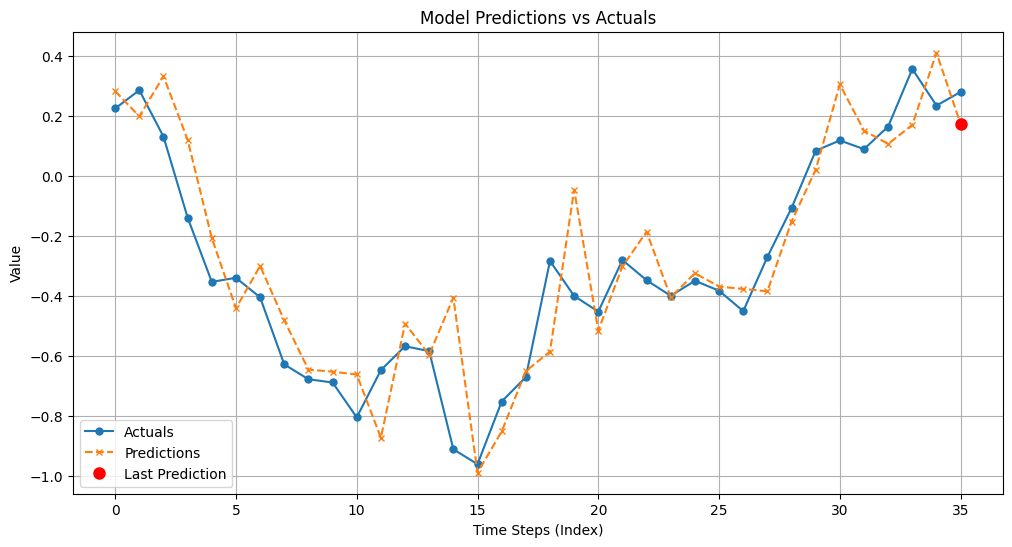

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Ensure results DataFrame exists from the previous run
if results and 'predictions' in results and 'actual' in results:
    df_results = pd.DataFrame({
        'predictions': results['predictions'],
        'actuals': results['actual']
    })

    # Plotting predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(df_results['actuals'].values, label='Actuals', marker='o', linestyle='-', markersize=5)
    plt.plot(df_results['predictions'].values, label='Predictions', marker='x', linestyle='--', markersize=5)

    # Add a point - for example, the last predicted point
    last_index = len(df_results) - 1
    plt.plot(last_index, df_results['predictions'].iloc[last_index], 'ro', markersize=8, label='Last Prediction')

    plt.title('Model Predictions vs Actuals')
    plt.xlabel('Time Steps (Index)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Results DataFrame not available from previous run.")
    print("Please ensure the 'main()' function was executed successfully and returned results.")

In [ ]:


class BSTSForecaster:
    """
    Bayesian Structural Time Series Forecaster for Treasury Curve
    """

    def __init__(self, target_col='Spread', test_size=36):
        self.target_col = target_col
        self.test_size = test_size
        self.scaler = StandardScaler()
        self.feature_selector = None
        self.selected_features = None
        self.model = None
        self.feature_data = None

    def create_lead_lag_features(self, df, other_cols=None, max_lags=5):
        """
        Create lead and lag features for time series analysis
        """
        feature_df = df.copy()

        # If no other columns specified, use all numeric columns except target and Date
        if other_cols is None:
            other_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                         if col != self.target_col]

        print(f"Creating features for {len(other_cols)} variables...")

        # Create lag features for target variable
        for lag in range(1, max_lags + 1):
            feature_df[f'{self.target_col}_lag_{lag}'] = feature_df[self.target_col].shift(lag)

        # Create lag and additional features for other variables
        for col in other_cols:
            # Lag features
            for lag in range(1, max_lags + 1):
                feature_df[f'{col}_lag_{lag}'] = feature_df[col].shift(lag)

            # Rolling statistics
            for window in [3, 5, 10]:
                feature_df[f'{col}_rolling_mean_{window}'] = feature_df[col].rolling(window).mean()
                feature_df[f'{col}_rolling_std_{window}'] = feature_df[col].rolling(window).std()
                feature_df[f'{col}_rolling_min_{window}'] = feature_df[col].rolling(window).min()
                feature_df[f'{col}_rolling_max_{window}'] = feature_df[col].rolling(window).max()

            # Differencing features
            feature_df[f'{col}_diff_1'] = feature_df[col].diff(1)
            feature_df[f'{col}_diff_2'] = feature_df[col].diff(2)

            # Percentage change
            feature_df[f'{col}_pct_change'] = feature_df[col].pct_change()

            # Momentum features
            feature_df[f'{col}_momentum_3'] = feature_df[col] - feature_df[col].shift(3)
            feature_df[f'{col}_momentum_5'] = feature_df[col] - feature_df[col].shift(5)

        return feature_df

    def select_features(self, df, k=50):
        """
        Select top k features using multiple methods
        """
        # Prepare data
        feature_cols = [col for col in df.columns if col != self.target_col and df[col].dtype in ['float64', 'int64']]

        # Remove rows with NaN in target
        clean_df = df.dropna(subset=[self.target_col])

        # Prepare feature matrix
        X = clean_df[feature_cols].fillna(clean_df[feature_cols].mean())
        y = clean_df[self.target_col]

        # Remove features with zero variance
        valid_features = []
        for col in feature_cols:
            if X[col].std() > 1e-8:
                valid_features.append(col)

        X = X[valid_features]

        if len(valid_features) == 0:
            print("No valid features found")
            return []

        # Feature selection using F-regression
        k_best = min(k, len(valid_features))
        selector = SelectKBest(score_func=f_regression, k=k_best)
        selector.fit(X, y)

        # Get selected features
        selected_features = [valid_features[i] for i in selector.get_support(indices=True)]

        print(f"Selected {len(selected_features)} features out of {len(valid_features)}")

        return selected_features

    def prepare_data_for_bsts(self, df, selected_features):
        """
        Prepare data for BSTS model
        """
        # Include target and selected features
        model_cols = [self.target_col] + selected_features

        # Clean data
        model_data = df[model_cols].dropna()

        # Split train/test
        train_data = model_data[:-self.test_size]
        test_data = model_data[-self.test_size:]

        return train_data, test_data

    def fit_bsts_python(self, train_data, selected_features):
        """
        Fit BSTS model using pybsts (if available)
        """
        if not PYBSTS_AVAILABLE:
            print("pybsts not available. Cannot fit BSTS model with Python.")
            return None

        try:
            # Prepare data for pybsts
            y = train_data[self.target_col].values
            X = train_data[selected_features].values

            # Create BSTS model
            model = pybsts.BSTS()

            # Add components
            model.add_local_level()
            model.add_seasonal(nseasons=12)  # Monthly seasonality

            # Add regression component if we have features
            if X.shape[1] > 0:
                model.add_regression(X)

            # Fit model
            model.fit(y)

            return model

        except Exception as e:
            print(f"Error fitting BSTS model with pybsts: {str(e)}")
            return None

    def fit_bsts_r(self, train_data, selected_features):
        """
        Fit BSTS model using R (if available)
        """
        if not R_AVAILABLE:
            print("rpy2 not available. Cannot fit BSTS model with R.")
            return None

        try:
            # Import R libraries
            bsts = importr('bsts')
            base = importr('base')

            # Prepare data
            y = train_data[self.target_col].values

            # Convert to R
            r_y = robjects.FloatVector(y)

            # Create state specification
            r_code = '''
            fit_bsts_model <- function(y, niter=1000) {
                library(bsts)

                # Create state specification
                ss <- AddLocalLevel(list(), y)
                ss <- AddSeasonal(ss, y, nseasons=12)

                # Fit model
                model <- bsts(y, state.specification=ss, niter=niter, ping=0)

                return(model)
            }
            '''

            robjects.r(r_code)
            fit_function = robjects.globalenv['fit_bsts_model']

            # Fit model
            model = fit_function(r_y, niter=1000)

            return model

        except Exception as e:
            print(f"Error fitting BSTS model with R: {str(e)}")
            return None

    def predict_bsts(self, model, test_data, selected_features, method='python'):
        """
        Make predictions using BSTS model
        """
        if model is None:
            return None

        try:
            if method == 'python' and PYBSTS_AVAILABLE:
                # Predict using pybsts
                horizon = len(test_data)
                predictions = model.predict(horizon)
                return predictions

            elif method == 'r' and R_AVAILABLE:
                # Predict using R
                r_code = '''
                predict_bsts <- function(model, horizon) {
                    library(bsts)
                    pred <- predict(model, horizon=horizon)
                    return(as.numeric(pred$mean))
                }
                '''

                robjects.r(r_code)
                predict_function = robjects.globalenv['predict_bsts']

                horizon = len(test_data)
                predictions = predict_function(model, horizon)

                return np.array(predictions)

            else:
                print("No suitable method available for prediction")
                return None

        except Exception as e:
            print(f"Error making predictions: {str(e)}")
            return None

    def time_series_cross_validation(self, df, selected_features, n_splits=5):
        """
        Perform time series cross validation
        """
        print(f"\nPerforming Time Series Cross Validation with {n_splits} splits...")

        # Prepare data
        model_cols = [self.target_col] + selected_features
        clean_data = df[model_cols].dropna()

        # Use only the last portion of data for CV (to simulate real-world scenario)
        cv_data = clean_data[-self.test_size*2:]  # Use 2x test_size for CV

        # Time series split
        tscv = TimeSeriesSplit(n_splits=n_splits)

        cv_scores = []

        for fold, (train_idx, val_idx) in enumerate(tscv.split(cv_data)):
            print(f"Fold {fold + 1}/{n_splits}")

            train_fold = cv_data.iloc[train_idx]
            val_fold = cv_data.iloc[val_idx]

            # Fit model (using simple linear regression as fallback)
            X_train = train_fold[selected_features].fillna(train_fold[selected_features].mean())
            y_train = train_fold[self.target_col]
            X_val = val_fold[selected_features].fillna(train_fold[selected_features].mean())
            y_val = val_fold[self.target_col]

            # Standardize features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            # Fit simple linear regression (as BSTS alternative)
            reg = LinearRegression()
            reg.fit(X_train_scaled, y_train)

            # Predict
            y_pred = reg.predict(X_val_scaled)

            # Calculate MAE
            mae = mean_absolute_error(y_val, y_pred)
            cv_scores.append(mae)

            print(f"  Fold {fold + 1} MAE: {mae:.4f}")

        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        print(f"\nCross Validation Results:")
        print(f"Mean MAE: {mean_cv_score:.4f} (+/- {std_cv_score:.4f})")

        return cv_scores

    def fit_and_evaluate(self, df, other_features=None):
        """
        Complete workflow: feature engineering, selection, model fitting, and evaluation
        """
        print("="*80)
        print("BSTS MODEL FOR TREASURY CURVE FORECASTING")
        print("="*80)

        print(f"Original data shape: {df.shape}")

        # Step 1: Feature Engineering
        print("\n1. Feature Engineering...")
        self.feature_data = self.create_lead_lag_features(df, other_features)
        print(f"After feature engineering: {self.feature_data.shape}")

        # Step 2: Feature Selection
        print("\n2. Feature Selection...")
        self.selected_features = self.select_features(self.feature_data, k=30)

        if len(self.selected_features) == 0:
            print("No features selected. Cannot proceed.")
            return None

        # Step 3: Prepare data
        print("\n3. Preparing data...")
        train_data, test_data = self.prepare_data_for_bsts(self.feature_data, self.selected_features)

        print(f"Train data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")

        # Step 4: Time Series Cross Validation
        print("\n4. Time Series Cross Validation...")
        cv_scores = self.time_series_cross_validation(self.feature_data, self.selected_features)

        # Step 5: Fit BSTS model
        print("\n5. Fitting BSTS Model...")

        # Try Python implementation first
        bsts_model = self.fit_bsts_python(train_data, self.selected_features)

        if bsts_model is None:
            # Try R implementation
            bsts_model = self.fit_bsts_r(train_data, self.selected_features)

        # Step 6: Fallback to Linear Regression if BSTS fails
        if bsts_model is None:
            print("BSTS model fitting failed. Using Linear Regression as fallback...")

            # Prepare data for linear regression
            X_train = train_data[self.selected_features].fillna(train_data[self.selected_features].mean())
            y_train = train_data[self.target_col]
            X_test = test_data[self.selected_features].fillna(train_data[self.selected_features].mean())
            y_test = test_data[self.target_col]

            # Standardize features
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            # Fit linear regression
            self.model = LinearRegression()
            self.model.fit(X_train_scaled, y_train)

            # Make predictions
            y_pred = self.model.predict(X_test_scaled)

        else:
            # Use BSTS model
            self.model = bsts_model
            y_test = test_data[self.target_col].values

            # Make predictions
            y_pred = self.predict_bsts(bsts_model, test_data, self.selected_features)

            if y_pred is None:
                print("BSTS prediction failed.")
                return None

        # Step 7: Evaluate performance
        print("\n6. Model Evaluation...")

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"Test Set Performance:")
        print(f"MAE:  {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²:   {r2:.4f}")

        # Step 8: Feature Importance (for linear regression fallback)
        if isinstance(self.model, LinearRegression):
            print("\n7. Feature Importance (Linear Regression)...")
            feature_importance = pd.DataFrame({
                'Feature': self.selected_features,
                'Coefficient': self.model.coef_,
                'Abs_Coefficient': np.abs(self.model.coef_)
            }).sort_values('Abs_Coefficient', ascending=False)

            print(f"Top 10 Most Important Features:")
            print(f"{'Feature':<40} {'Coefficient':<12}")
            print(f"{'-'*60}")

            for _, row in feature_importance.head(10).iterrows():
                print(f"{row['Feature']:<40} {row['Coefficient']:<12.6f}")

        # Results summary
        results = {
            'model': self.model,
            'selected_features': self.selected_features,
            'test_mae': mae,
            'test_rmse': rmse,
            'test_r2': r2,
            'cv_scores': cv_scores,
            'predictions': y_pred,
            'actual': y_test
        }

        return results

# Main execution
def main():
    # Load data
    print("Loading data...")
    data = pd.read_csv(r"/content/final_feature_library_all_features.csv")

    # Create target variable
    data['Spread'] = data['USGG10YR_mean'] - data['USGG2YR_mean']
    data['Spread'] = data['Spread'].shift(-1)
    data = data[:-1]

    # Clean data
    cols = data.isna().sum()[data.isna().sum()==0].index.tolist()
    data = data[cols]

    # Drop all columns ending with 'median'
    data = data.loc[:, ~data.columns.str.endswith('median')]

    print(f"Final data shape: {data.shape}")
    print(f"Target variable (Spread) statistics:")
    print(data['Spread'].describe())

    # Initialize forecaster
    forecaster = BSTSForecaster(target_col='Spread', test_size=36)

    # Get other features (exclude target and Date)
    other_features = [col for col in data.columns if col != 'Spread' and col != 'Date']

    # Run complete analysis
    results = forecaster.fit_and_evaluate(data, other_features)

    if results:
        print("\n" + "="*80)
        print("FINAL RESULTS SUMMARY")
        print("="*80)
        print(f"Test MAE: {results['test_mae']:.4f}")
        print(f"Cross-validation MAE: {np.mean(results['cv_scores']):.4f} (+/- {np.std(results['cv_scores']):.4f})")
        print(f"Number of selected features: {len(results['selected_features'])}")

        # Save results
        results_df = pd.DataFrame({
            'Actual': results['actual'],
            'Predicted': results['predictions']
        })

        print("\nSample predictions:")
        print(results_df.head(10))

        return results
    else:
        print("Model fitting failed.")
        return None

if __name__ == "__main__":
    # Install required packages if needed
    print("Note: For full BSTS functionality, install:")
    print("pip install pybsts rpy2")
    print("And in R: install.packages('bsts')")
    print("\nRunning with available libraries...\n")

    results = main()